In [1]:
import catboost as cat
import numpy as np
import pandas as pd
import statsmodels.api as sm

# Gráficos
# ==============================================================================
import matplotlib.pyplot as plt

# Preprocesado y modelado
# ==============================================================================
from sklearn.datasets import load_boston
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import plot_confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import log_loss
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
from sklearn.model_selection import RepeatedKFold
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import ParameterGrid
from sklearn.inspection import permutation_importance
from sklearn.neighbors import KNeighborsClassifier
import multiprocessing

# Configuración warnings
# ==================

In [2]:
df = pd.read_csv( "../Training.csv" )
df.T

0      \
ID                                                   27761   
Region                                                EMEA   
Territory                                             None   
Pricing, Delivery_Terms_Quote_Appr                       1   
Pricing, Delivery_Terms_Approved                         1   
Bureaucratic_Code_0_Approval                             1   
Bureaucratic_Code_0_Approved                             1   
Submitted_for_Approval                                   0   
Bureaucratic_Code                      Bureaucratic_Code_4   
Account_Created_Date                             6/16/2015   
Source                                                None   
Billing_Country                                Netherlands   
Account_Name                              Account_Name_619   
Opportunity_Name                    Opportunity_Name_12598   
Opportunity_ID                                           0   
Sales_Contract_No                                     None   
Account_Owner                               Person_Name_51   
Opportunity_Owner                           Person_Name_18   
Account_Type                                Account_Type_2   
Opportunity_Type                        Opportunity_Type_1   
Quote_Type                                     Non Binding   
Delivery_Terms                            Delivery_Terms_2   
Opportunity_Created_Date                         12/7/2015   
Brand                                                 None   
Product_Type                                          None   
Size                                                  None   
Product_Category_B                                    None   
Price                                                 None   
Currency                                              None   
Last_Activity                                          NaT   
Quote_Expiry_Date                                1/30/2016   
Last_Modified_Date                               6/13/2016   
Last_Modified_By                            Person_Name_18   
Product_Family                           Product_Family_77   
Product_Name                               Product_Name_99   
ASP_Currency                                           EUR   
ASP                                                   0.52   
ASP_(converted)_Currency                               USD   
ASP_(converted)                                    0.58817   
Planned_Delivery_Start_Date                       5/1/2016   
Planned_Delivery_End_Date                        6/30/2016   
Month                                             2016 - 5   
Delivery_Quarter                                        Q2   
Delivery_Year                                         2016   
Actual_Delivery_Date                                   NaT   
TRF                                                     10   
Total_Amount_Currency                                  EUR   
Total_Amount                                    5.2728e+06   
Total_Taxable_Amount_Currency                          EUR   
Total_Taxable_Amount                            5.2728e+06   
Stage                                          Closed Lost   
Prod_Category_A                       Prod_Category_A_None   

                                                     1      \
ID                                                   27760   
Region                                                EMEA   
Territory                                             None   
Pricing, Delivery_Terms_Quote_Appr                       0   
Pricing, Delivery_Terms_Approved                         0   
Bureaucratic_Code_0_Approval                             0   
Bureaucratic_Code_0_Approved                             0   
Submitted_for_Approval                                   0   
Bureaucratic_Code                      Bureaucratic_Code_4   
Account_Created_Date                             6/16/2015   
Source                                                None   
Billing_Country       

In [3]:
df.loc[df['Total_Amount_Currency'] == 'JPY', 'Total_Amount'] = df['Total_Amount']*0.0096
df.loc[df['Total_Amount_Currency'] == 'JPY', 'Total_Amount_Currency'] = 'USD'

df.loc[df['Total_Amount_Currency'] == 'EUR', 'Total_Amount'] = df['Total_Amount']*1.17
df.loc[df['Total_Amount_Currency'] == 'EUR', 'Total_Amount_Currency'] = 'USD'

df.loc[df['Total_Amount_Currency'] == 'AUD', 'Total_Amount'] = df['Total_Amount']*0.70
df.loc[df['Total_Amount_Currency'] == 'AUD', 'Total_Amount_Currency'] = 'USD'

df.loc[df['Total_Amount_Currency'] == 'GBP', 'Total_Amount'] = df['Total_Amount']*1.29
df.loc[df['Total_Amount_Currency'] == 'GBP', 'Total_Amount_Currency'] = 'USD'
df.dropna(inplace = True)
df['Opportunity_Created_Date'] = pd.to_datetime(df['Opportunity_Created_Date'],errors='coerce')
df["Year Created"] = df["Opportunity_Created_Date"].dt.year
df["Month Created"] =df["Opportunity_Created_Date"].dt.month
df["Expensive"] = np.where(df["Total_Taxable_Amount"] >= 80000, 1, 0)
df['Planned_Delivery_Start_Date'] = pd.to_datetime(df['Planned_Delivery_Start_Date'],errors='coerce')
df['Planned_Delivery_End_Date'] = pd.to_datetime(df['Planned_Delivery_End_Date'],errors='coerce')
df = df[df["Total_Amount"] > 0]
df["Total_Amount"] = np.log(df["Total_Amount"])
entrenamiento_by_region = df.groupby("Region").agg({"Stage" : "count"})
entrenamiento_by_region.rename(columns = {"Stage" : "Amount of Cases"}, inplace = True)
entrenamiento_won_by_region = df[df["Stage"] == "Closed Won"].groupby("Region").agg({"Stage" : "count"})
entrenamiento_won_by_region.rename(columns = {"Stage" : "Cases won"}, inplace = True)

entrenamiento_won_by_region["percentage"] = (entrenamiento_won_by_region["Cases won"] / entrenamiento_by_region["Amount of Cases"]) * 100
df = df.merge(entrenamiento_won_by_region, on = "Region")
df["Años en entregar"] = df["Delivery_Year"] - df["Year Created"]

In [4]:
df["Source "]

0            None
1            None
2        Source_7
3        Source_7
4            None
           ...   
13637    Source_7
13638        None
13639    Source_7
13640    Source_7
13641    Source_7
Name: Source , Length: 13642, dtype: object

In [5]:
df.corr()
df1 = df.copy()
df1["Stage"] = np.where(df1["Stage"] == "Closed Won", 1, 0)
df1["Stage"].value_counts()

1    7525
0    6117
Name: Stage, dtype: int64

In [6]:
df["Product_Name"].value_counts()

Product_Name_100    968
Product_Name_226    835
Product_Name_231    576
Product_Name_192    437
Product_Name_111    386
                   ... 
Product_Name_489      1
Product_Name_136      1
Product_Name_275      1
Product_Name_55       1
Product_Name_60       1
Name: Product_Name, Length: 435, dtype: int64

In [7]:
short_df = df[['Opportunity_ID', "Total_Amount", "Años en entregar","Month Created", "Product_Name", "Opportunity_Owner", 'Stage' ]].rename(columns={'Stage': 'Decision'})
short_df = short_df[ (short_df['Decision'] == 'Closed Won') | (short_df['Decision'] == 'Closed Lost') ]
short_df['Decision'] = np.where(short_df['Decision'] == 'Closed Won',1,0)
short_df.set_index('Opportunity_ID', inplace = True)


short_df.describe()
short_df.dropna(inplace = True)

In [8]:
short_df["Product_Name"] = np.where(short_df.groupby('Product_Name')["Product_Name"].transform(len) > 5, short_df["Product_Name"], "Other")
short_df["Product_Name"].value_counts()

Product_Name_100    968
Product_Name_226    835
Product_Name_231    574
Product_Name_192    437
Other               397
                   ... 
Product_Name_17       6
Product_Name_146      6
Product_Name_104      6
Product_Name_180      6
Product_Name_300      6
Name: Product_Name, Length: 237, dtype: int64

In [9]:
short_df["Opportunity_Owner"] = np.where(short_df.groupby('Opportunity_Owner')["Opportunity_Owner"].transform(len) > 5, short_df["Opportunity_Owner"], "Other")
short_df["Opportunity_Owner"].value_counts()

Person_Name_8     1352
Person_Name_13    1252
Person_Name_50    1071
Person_Name_18     979
Person_Name_43     831
Person_Name_3      760
Person_Name_4      682
Person_Name_32     655
Person_Name_19     614
Person_Name_16     438
Person_Name_23     422
Person_Name_64     408
Person_Name_65     322
Person_Name_49     285
Person_Name_46     238
Person_Name_44     225
Person_Name_66     218
Person_Name_39     210
Person_Name_60     206
Person_Name_48     198
Person_Name_38     193
Person_Name_62     174
Person_Name_52     173
Person_Name_54     168
Person_Name_5      152
Person_Name_59     134
Person_Name_2      118
Person_Name_41     112
Person_Name_45     112
Person_Name_51     111
Person_Name_33      86
Person_Name_14      82
Person_Name_55      79
Person_Name_11      70
Person_Name_30      64
Person_Name_63      61
Person_Name_40      50
Person_Name_25      48
Person_Name_20      48
Person_Name_26      33
Person_Name_22      33
Person_Name_37      21
Person_Name_42      19
Person_Name

In [10]:
mean_encoded_product = short_df.groupby("Product_Name")["Decision"].mean().to_dict()

In [11]:
short_df["Product_Name"] = short_df["Product_Name"].map(mean_encoded_product)

In [12]:
mean_encoded_owner = short_df.groupby("Opportunity_Owner")["Decision"].mean().to_dict()
short_df["Opportunity_Owner"] = short_df["Opportunity_Owner"].map(mean_encoded_owner)

In [13]:
short_df.head()

Total_Amount  Años en entregar  Month Created  Product_Name  \
Opportunity_ID                                                                
0                  15.635076                 1             12      0.186992   
1                  10.940740                 1             12      0.592975   
19                 12.624960                 1             12      0.561404   
20                 11.702880                 1             12      0.592975   
23                 12.433069                 1             12      0.592975   

                Opportunity_Owner   Source     Account_Type  \
Opportunity_ID                                                
0                        0.560776      None  Account_Type_2   
1                        0.750000      None  Account_Type_2   
19                       0.261905  Source_7  Account_Type_0   
20                       0.664537  Source_7  Account_Type_0   
23                       0.560776      None  Account_Type_0   

                     Account_Name   Account_Owner    Bureaucratic_Code  \
Opportunity_ID                                                           
0                Account_Name_619  Person_Name_51  Bureaucratic_Code_4   
1                Account_Name_619  Person_Name_51  Bureaucratic_Code_4   
19              Account_Name_1067   Person_Name_2  Bureaucratic_Code_4   
20               Account_Name_263  Person_Name_13  Bureaucratic_Code_4   
23               Account_Name_270  Person_Name_18  Bureaucratic_Code_4   

                Decision  
Opportunity_ID            
0                      0  
1                      1  
19                     0  
20                     1  
23                     1

In [14]:
mean_encoded_source = short_df.groupby("Source ")["Decision"].mean().to_dict()
short_df["Source "] = short_df["Source "].map(mean_encoded_source)

In [15]:
short_df["Account_Owner"] = np.where(short_df.groupby('Account_Owner')["Account_Owner"].transform(len) > 5, short_df["Account_Owner"], "Other")
short_df["Account_Owner"].value_counts()

Person_Name_13    1325
Person_Name_43    1234
Person_Name_8     1233
Person_Name_18    1092
Person_Name_50    1072
Person_Name_3      798
Person_Name_4      659
Person_Name_65     623
Person_Name_32     599
Person_Name_64     477
Person_Name_16     431
Person_Name_2      333
Person_Name_42     304
Person_Name_46     291
Person_Name_45     275
Person_Name_38     254
Person_Name_66     231
Person_Name_60     226
Person_Name_59     201
Person_Name_49     200
Person_Name_62     179
Person_Name_54     175
Person_Name_52     172
Person_Name_21     166
Person_Name_5      149
Person_Name_63     130
Person_Name_55     125
Person_Name_51     106
Person_Name_39     102
Person_Name_33      85
Person_Name_14      74
Person_Name_61      68
Person_Name_41      50
Person_Name_44      49
Person_Name_9       33
Other               23
Person_Name_58      14
Person_Name_26      12
Person_Name_25       7
Person_Name_29       6
Name: Account_Owner, dtype: int64

In [16]:
mean_encoded_accountowner = short_df.groupby("Account_Owner")["Decision"].mean().to_dict()
short_df["Account_Owner"] = short_df["Account_Owner"].map(mean_encoded_accountowner)

In [17]:
short_df["Account_Type"] = np.where(short_df.groupby('Account_Type')["Account_Type"].transform(len) > 5, short_df["Account_Type"], "Other")
short_df["Account_Type"].value_counts()

Account_Type_2    5745
Account_Type_0    5719
Account_Type_5    1833
Account_Type_1     159
None               100
Account_Type_6      17
Account_Type_4      10
Name: Account_Type, dtype: int64

In [18]:
mean_encoded_acc = short_df.groupby("Account_Type")["Decision"].mean().to_dict()
short_df["Account_Type"] = short_df["Account_Type"].map(mean_encoded_acc)

In [19]:
short_df["Account_Name"] = np.where(short_df.groupby('Account_Name')["Account_Name"].transform(len) > 5, short_df["Account_Name"], "Other")
mean_encoded_accow = short_df.groupby("Account_Name")["Decision"].mean().to_dict()
short_df["Account_Name"] = short_df["Account_Name"].map(mean_encoded_accow)

In [20]:
mean_encoded_accow

{'Account_Name_1006': 0.2857142857142857,
 'Account_Name_1012': 0.3333333333333333,
 'Account_Name_1017': 0.5,
 'Account_Name_1039': 0.8571428571428571,
 'Account_Name_1053': 0.5151515151515151,
 'Account_Name_1059': 0.0,
 'Account_Name_1063': 0.42857142857142855,
 'Account_Name_1064': 0.08333333333333333,
 'Account_Name_1067': 0.5689655172413793,
 'Account_Name_1074': 0.9,
 'Account_Name_1075': 0.8217821782178217,
 'Account_Name_108': 0.0,
 'Account_Name_1083': 0.7777777777777778,
 'Account_Name_1087': 0.3684210526315789,
 'Account_Name_110': 0.8571428571428571,
 'Account_Name_1100': 0.6575342465753424,
 'Account_Name_1114': 0.7,
 'Account_Name_1128': 0.8823529411764706,
 'Account_Name_1134': 0.6666666666666666,
 'Account_Name_1136': 0.42857142857142855,
 'Account_Name_1139': 0.7333333333333333,
 'Account_Name_1144': 0.125,
 'Account_Name_1147': 0.42857142857142855,
 'Account_Name_1149': 0.3888888888888889,
 'Account_Name_1159': 0.24444444444444444,
 'Account_Name_1161': 0.125,
 'Acco

In [21]:
mean_encoded_bur = short_df.groupby("Bureaucratic_Code")["Decision"].mean().to_dict()
short_df["Bureaucratic_Code"] = short_df["Bureaucratic_Code"].map(mean_encoded_bur)

In [22]:
short_df["Bureaucratic_Code"]

Opportunity_ID
0        0.610497
1        0.610497
19       0.610497
20       0.610497
23       0.610497
           ...   
9821     0.610497
9899     0.610497
9968     0.610497
10156    0.351264
10339    0.351264
Name: Bureaucratic_Code, Length: 13583, dtype: float64

In [23]:

# División de los datos en train y test
# ==============================================================================
X_train, X_test, y_train, y_test = train_test_split(
                                        short_df.drop(columns = 'Decision'),
                                        short_df['Decision'],
                                        random_state = 123,
                                        test_size = 0.3
                                    )




In [59]:
# One-hot-encoding de las variables categóricas
# ==============================================================================
# Se identifica el nobre de las columnas numéricas y categóricas
cat_cols = X_train.select_dtypes(include=['object', 'category']).columns.to_list()
numeric_cols = X_train.select_dtypes(include=['float64', 'int']).columns.to_list()

# Se aplica one-hot-encoding solo a las columnas categóricas
preprocessor = ColumnTransformer(
                    [('onehot', OneHotEncoder(handle_unknown='ignore'), cat_cols)],
                    remainder='passthrough'
               )

# Una vez que se ha definido el objeto ColumnTransformer, con el método fit()
# se aprenden las transformaciones con los datos de entrenamiento y se aplican a
# los dos conjuntos con transform(). Ambas operaciones a la vez con fit_transform().
X_train_prep = preprocessor.fit_transform(X_train)
X_test_prep  = preprocessor.transform(X_test)

#El resultado devuelto por ColumnTransformer es un numpy array, por lo que se pierden los nombres de las columnas. Es interesante poder inspeccionar cómo queda el set de datos tras el preprocesado en formato dataframe. Por defecto, OneHotEncoder ordena las nuevas columnas de izquierda a derecha por orden alfabético.

# Convertir el output del ColumnTransformer en dataframe y añadir nombre columnas
# ==============================================================================
# Nombre de todas las columnas
encoded_cat = preprocessor.named_transformers_['onehot'].get_feature_names(cat_cols)
labels = np.concatenate([encoded_cat, numeric_cols])

print(X_train_prep)

# Conversión a dataframe
X_train_prep1 = pd.DataFrame(X_train_prep, columns = labels)
X_test_prep1  = pd.DataFrame(X_test_prep, columns = labels)
X_train_prep1.info()


NotFittedError: This OneHotEncoder instance is not fitted yet. Call 'fit' with appropriate arguments before using this estimator.

In [ ]:
X_train_prep1.head(5)

In [89]:
# División de los datos en train y test
# ==============================================================================
X_train, X_test, y_train, y_test = train_test_split(
                                        short_df.drop(columns = 'Decision'),
                                        short_df['Decision'],
                                        random_state = 123
                                    )


# CATBOOST

In [24]:
model = cat.CatBoostRegressor(learning_rate = 0.0075, verbose = True, random_seed = 123, loss_function = "RMSE", num_boost_round = 1500, max_depth = 16)

In [231]:
model.fit(X_train, y_train)

0:	learn: 0.4950847	total: 260ms	remaining: 6m 29s
1:	learn: 0.4934014	total: 434ms	remaining: 5m 25s
2:	learn: 0.4916993	total: 616ms	remaining: 5m 7s
3:	learn: 0.4900490	total: 790ms	remaining: 4m 55s
4:	learn: 0.4883971	total: 969ms	remaining: 4m 49s
5:	learn: 0.4867174	total: 1.15s	remaining: 4m 46s
6:	learn: 0.4850338	total: 1.33s	remaining: 4m 43s
7:	learn: 0.4833907	total: 1.51s	remaining: 4m 41s
8:	learn: 0.4817558	total: 1.69s	remaining: 4m 39s
9:	learn: 0.4800993	total: 1.87s	remaining: 4m 38s
10:	learn: 0.4785599	total: 2.05s	remaining: 4m 38s
11:	learn: 0.4769954	total: 2.23s	remaining: 4m 36s
12:	learn: 0.4755236	total: 2.23s	remaining: 4m 15s
13:	learn: 0.4739158	total: 2.41s	remaining: 4m 16s
14:	learn: 0.4723614	total: 2.59s	remaining: 4m 16s
15:	learn: 0.4708114	total: 2.77s	remaining: 4m 16s
16:	learn: 0.4692748	total: 2.94s	remaining: 4m 16s
17:	learn: 0.4677555	total: 3.12s	remaining: 4m 16s
18:	learn: 0.4662472	total: 3.3s	remaining: 4m 17s
19:	learn: 0.4647294	tot

158:	learn: 0.3399925	total: 27.1s	remaining: 3m 48s
159:	learn: 0.3394315	total: 27.3s	remaining: 3m 48s
160:	learn: 0.3388676	total: 27.5s	remaining: 3m 48s
161:	learn: 0.3383467	total: 27.6s	remaining: 3m 48s
162:	learn: 0.3378218	total: 27.8s	remaining: 3m 48s
163:	learn: 0.3373156	total: 28s	remaining: 3m 48s
164:	learn: 0.3367862	total: 28.2s	remaining: 3m 47s
165:	learn: 0.3362897	total: 28.4s	remaining: 3m 47s
166:	learn: 0.3357940	total: 28.5s	remaining: 3m 47s
167:	learn: 0.3353683	total: 28.7s	remaining: 3m 47s
168:	learn: 0.3348709	total: 28.9s	remaining: 3m 47s
169:	learn: 0.3343368	total: 29.1s	remaining: 3m 47s
170:	learn: 0.3339002	total: 29.2s	remaining: 3m 47s
171:	learn: 0.3334396	total: 29.4s	remaining: 3m 47s
172:	learn: 0.3329943	total: 29.6s	remaining: 3m 46s
173:	learn: 0.3325231	total: 29.8s	remaining: 3m 46s
174:	learn: 0.3320756	total: 29.9s	remaining: 3m 46s
175:	learn: 0.3316613	total: 30.1s	remaining: 3m 46s
176:	learn: 0.3311854	total: 30.3s	remaining: 3m

314:	learn: 0.2885998	total: 54s	remaining: 3m 23s
315:	learn: 0.2884096	total: 54.2s	remaining: 3m 23s
316:	learn: 0.2881757	total: 54.4s	remaining: 3m 22s
317:	learn: 0.2879097	total: 54.5s	remaining: 3m 22s
318:	learn: 0.2876495	total: 54.7s	remaining: 3m 22s
319:	learn: 0.2874907	total: 54.9s	remaining: 3m 22s
320:	learn: 0.2872604	total: 55.1s	remaining: 3m 22s
321:	learn: 0.2870981	total: 55.3s	remaining: 3m 22s
322:	learn: 0.2869334	total: 55.4s	remaining: 3m 21s
323:	learn: 0.2866845	total: 55.6s	remaining: 3m 21s
324:	learn: 0.2865082	total: 55.8s	remaining: 3m 21s
325:	learn: 0.2863347	total: 56s	remaining: 3m 21s
326:	learn: 0.2862801	total: 56s	remaining: 3m 20s
327:	learn: 0.2861138	total: 56.1s	remaining: 3m 20s
328:	learn: 0.2859323	total: 56.3s	remaining: 3m 20s
329:	learn: 0.2857315	total: 56.5s	remaining: 3m 20s
330:	learn: 0.2854434	total: 56.7s	remaining: 3m 20s
331:	learn: 0.2852715	total: 56.8s	remaining: 3m 19s
332:	learn: 0.2850755	total: 57s	remaining: 3m 19s
3

470:	learn: 0.2640190	total: 1m 20s	remaining: 2m 55s
471:	learn: 0.2638610	total: 1m 20s	remaining: 2m 55s
472:	learn: 0.2637499	total: 1m 20s	remaining: 2m 55s
473:	learn: 0.2636220	total: 1m 20s	remaining: 2m 55s
474:	learn: 0.2635402	total: 1m 21s	remaining: 2m 55s
475:	learn: 0.2633621	total: 1m 21s	remaining: 2m 54s
476:	learn: 0.2632484	total: 1m 21s	remaining: 2m 54s
477:	learn: 0.2631413	total: 1m 21s	remaining: 2m 54s
478:	learn: 0.2630568	total: 1m 21s	remaining: 2m 54s
479:	learn: 0.2629610	total: 1m 22s	remaining: 2m 54s
480:	learn: 0.2628449	total: 1m 22s	remaining: 2m 54s
481:	learn: 0.2627249	total: 1m 22s	remaining: 2m 54s
482:	learn: 0.2626234	total: 1m 22s	remaining: 2m 53s
483:	learn: 0.2624526	total: 1m 22s	remaining: 2m 53s
484:	learn: 0.2623611	total: 1m 22s	remaining: 2m 53s
485:	learn: 0.2622008	total: 1m 23s	remaining: 2m 53s
486:	learn: 0.2620950	total: 1m 23s	remaining: 2m 53s
487:	learn: 0.2619158	total: 1m 23s	remaining: 2m 53s
488:	learn: 0.2618015	total:

623:	learn: 0.2480595	total: 1m 46s	remaining: 2m 28s
624:	learn: 0.2479485	total: 1m 46s	remaining: 2m 28s
625:	learn: 0.2478752	total: 1m 46s	remaining: 2m 28s
626:	learn: 0.2478214	total: 1m 46s	remaining: 2m 28s
627:	learn: 0.2477148	total: 1m 46s	remaining: 2m 28s
628:	learn: 0.2476235	total: 1m 47s	remaining: 2m 28s
629:	learn: 0.2475189	total: 1m 47s	remaining: 2m 28s
630:	learn: 0.2474466	total: 1m 47s	remaining: 2m 27s
631:	learn: 0.2473353	total: 1m 47s	remaining: 2m 27s
632:	learn: 0.2472291	total: 1m 47s	remaining: 2m 27s
633:	learn: 0.2470730	total: 1m 47s	remaining: 2m 27s
634:	learn: 0.2469607	total: 1m 48s	remaining: 2m 27s
635:	learn: 0.2469541	total: 1m 48s	remaining: 2m 26s
636:	learn: 0.2468433	total: 1m 48s	remaining: 2m 26s
637:	learn: 0.2467744	total: 1m 48s	remaining: 2m 26s
638:	learn: 0.2466716	total: 1m 48s	remaining: 2m 26s
639:	learn: 0.2466130	total: 1m 48s	remaining: 2m 26s
640:	learn: 0.2465276	total: 1m 48s	remaining: 2m 26s
641:	learn: 0.2464515	total:

777:	learn: 0.2352229	total: 2m 11s	remaining: 2m 2s
778:	learn: 0.2351167	total: 2m 11s	remaining: 2m 1s
779:	learn: 0.2350411	total: 2m 11s	remaining: 2m 1s
780:	learn: 0.2349568	total: 2m 12s	remaining: 2m 1s
781:	learn: 0.2349425	total: 2m 12s	remaining: 2m 1s
782:	learn: 0.2348928	total: 2m 12s	remaining: 2m 1s
783:	learn: 0.2348083	total: 2m 12s	remaining: 2m
784:	learn: 0.2347309	total: 2m 12s	remaining: 2m
785:	learn: 0.2345836	total: 2m 12s	remaining: 2m
786:	learn: 0.2345077	total: 2m 12s	remaining: 2m
787:	learn: 0.2344433	total: 2m 13s	remaining: 2m
788:	learn: 0.2343902	total: 2m 13s	remaining: 2m
789:	learn: 0.2342907	total: 2m 13s	remaining: 1m 59s
790:	learn: 0.2341938	total: 2m 13s	remaining: 1m 59s
791:	learn: 0.2340949	total: 2m 13s	remaining: 1m 59s
792:	learn: 0.2340162	total: 2m 13s	remaining: 1m 59s
793:	learn: 0.2339484	total: 2m 14s	remaining: 1m 59s
794:	learn: 0.2338148	total: 2m 14s	remaining: 1m 59s
795:	learn: 0.2337667	total: 2m 14s	remaining: 1m 58s
796:

931:	learn: 0.2243403	total: 2m 36s	remaining: 1m 35s
932:	learn: 0.2242806	total: 2m 37s	remaining: 1m 35s
933:	learn: 0.2242315	total: 2m 37s	remaining: 1m 35s
934:	learn: 0.2241579	total: 2m 37s	remaining: 1m 35s
935:	learn: 0.2241185	total: 2m 37s	remaining: 1m 34s
936:	learn: 0.2240391	total: 2m 37s	remaining: 1m 34s
937:	learn: 0.2239841	total: 2m 37s	remaining: 1m 34s
938:	learn: 0.2239318	total: 2m 38s	remaining: 1m 34s
939:	learn: 0.2238449	total: 2m 38s	remaining: 1m 34s
940:	learn: 0.2237997	total: 2m 38s	remaining: 1m 34s
941:	learn: 0.2237368	total: 2m 38s	remaining: 1m 33s
942:	learn: 0.2236166	total: 2m 38s	remaining: 1m 33s
943:	learn: 0.2235608	total: 2m 38s	remaining: 1m 33s
944:	learn: 0.2234912	total: 2m 39s	remaining: 1m 33s
945:	learn: 0.2234104	total: 2m 39s	remaining: 1m 33s
946:	learn: 0.2233079	total: 2m 39s	remaining: 1m 33s
947:	learn: 0.2232668	total: 2m 39s	remaining: 1m 32s
948:	learn: 0.2231963	total: 2m 39s	remaining: 1m 32s
949:	learn: 0.2231155	total:

1082:	learn: 0.2149324	total: 3m 2s	remaining: 1m 10s
1083:	learn: 0.2148736	total: 3m 2s	remaining: 1m 9s
1084:	learn: 0.2147661	total: 3m 2s	remaining: 1m 9s
1085:	learn: 0.2146998	total: 3m 2s	remaining: 1m 9s
1086:	learn: 0.2146554	total: 3m 2s	remaining: 1m 9s
1087:	learn: 0.2145880	total: 3m 3s	remaining: 1m 9s
1088:	learn: 0.2144756	total: 3m 3s	remaining: 1m 9s
1089:	learn: 0.2144741	total: 3m 3s	remaining: 1m 8s
1090:	learn: 0.2143798	total: 3m 3s	remaining: 1m 8s
1091:	learn: 0.2143445	total: 3m 3s	remaining: 1m 8s
1092:	learn: 0.2143052	total: 3m 3s	remaining: 1m 8s
1093:	learn: 0.2142320	total: 3m 3s	remaining: 1m 8s
1094:	learn: 0.2141727	total: 3m 4s	remaining: 1m 8s
1095:	learn: 0.2140945	total: 3m 4s	remaining: 1m 7s
1096:	learn: 0.2140305	total: 3m 4s	remaining: 1m 7s
1097:	learn: 0.2139309	total: 3m 4s	remaining: 1m 7s
1098:	learn: 0.2138491	total: 3m 4s	remaining: 1m 7s
1099:	learn: 0.2138087	total: 3m 4s	remaining: 1m 7s
1100:	learn: 0.2137444	total: 3m 5s	remaining

1236:	learn: 0.2051733	total: 3m 28s	remaining: 44.3s
1237:	learn: 0.2051224	total: 3m 28s	remaining: 44.2s
1238:	learn: 0.2051217	total: 3m 28s	remaining: 44s
1239:	learn: 0.2050802	total: 3m 28s	remaining: 43.8s
1240:	learn: 0.2049867	total: 3m 29s	remaining: 43.6s
1241:	learn: 0.2049099	total: 3m 29s	remaining: 43.5s
1242:	learn: 0.2048451	total: 3m 29s	remaining: 43.3s
1243:	learn: 0.2047723	total: 3m 29s	remaining: 43.1s
1244:	learn: 0.2047715	total: 3m 29s	remaining: 42.9s
1245:	learn: 0.2047034	total: 3m 29s	remaining: 42.8s
1246:	learn: 0.2046338	total: 3m 29s	remaining: 42.6s
1247:	learn: 0.2045814	total: 3m 30s	remaining: 42.4s
1248:	learn: 0.2045271	total: 3m 30s	remaining: 42.3s
1249:	learn: 0.2044722	total: 3m 30s	remaining: 42.1s
1250:	learn: 0.2044156	total: 3m 30s	remaining: 41.9s
1251:	learn: 0.2043254	total: 3m 30s	remaining: 41.8s
1252:	learn: 0.2042720	total: 3m 31s	remaining: 41.6s
1253:	learn: 0.2041908	total: 3m 31s	remaining: 41.4s
1254:	learn: 0.2041336	total: 

1389:	learn: 0.1965379	total: 3m 54s	remaining: 18.6s
1390:	learn: 0.1965022	total: 3m 54s	remaining: 18.4s
1391:	learn: 0.1964386	total: 3m 55s	remaining: 18.2s
1392:	learn: 0.1963708	total: 3m 55s	remaining: 18.1s
1393:	learn: 0.1963299	total: 3m 55s	remaining: 17.9s
1394:	learn: 0.1963017	total: 3m 55s	remaining: 17.7s
1395:	learn: 0.1962788	total: 3m 55s	remaining: 17.6s
1396:	learn: 0.1962436	total: 3m 55s	remaining: 17.4s
1397:	learn: 0.1961856	total: 3m 56s	remaining: 17.2s
1398:	learn: 0.1961220	total: 3m 56s	remaining: 17.1s
1399:	learn: 0.1960791	total: 3m 56s	remaining: 16.9s
1400:	learn: 0.1960169	total: 3m 56s	remaining: 16.7s
1401:	learn: 0.1959436	total: 3m 56s	remaining: 16.6s
1402:	learn: 0.1958578	total: 3m 56s	remaining: 16.4s
1403:	learn: 0.1958144	total: 3m 57s	remaining: 16.2s
1404:	learn: 0.1957736	total: 3m 57s	remaining: 16s
1405:	learn: 0.1957169	total: 3m 57s	remaining: 15.9s
1406:	learn: 0.1956588	total: 3m 57s	remaining: 15.7s
1407:	learn: 0.1955912	total: 

In [232]:
preds = model.predict(X_test)

In [233]:
loss = log_loss(y_test, preds)
loss

0.3540556075034567

In [234]:
fi = model.feature_importances_

In [235]:
fi

array([12.20682845,  6.27463813, 13.49203076, 11.880603  ,  9.16342218,
        8.11086677,  6.86731659, 15.13472906,  6.48501535, 10.38454971])

In [236]:
featureImportance = pd.DataFrame(fi)

In [237]:
featureImportance["Attribute"] = model.feature_names_

In [238]:
featureImportance.columns = ["Value", "Attribute"]

<AxesSubplot:xlabel='Attribute'>

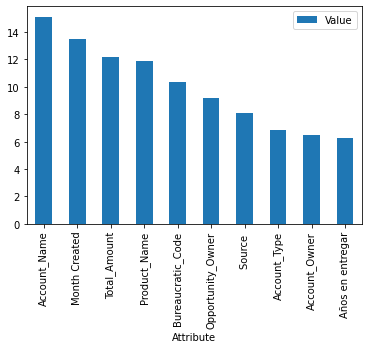

In [239]:
featureImportance.set_index("Attribute").sort_values(by = "Value", ascending = False).plot.bar()

# ADABOOST

In [26]:
from sklearn.ensemble import AdaBoostRegressor
from sklearn.ensemble import RandomForestRegressor
from lightgbm.sklearn import LGBMRegressor

In [26]:
X_train.isnull().sum()

Total_Amount         0
Años en entregar     0
Month Created        0
Product_Name         0
Opportunity_Owner    0
Source               0
Account_Type         0
Account_Name         0
Account_Owner        0
Bureaucratic_Code    0
dtype: int64

In [27]:

adaModel = AdaBoostRegressor(base_estimator = cat.CatBoostRegressor(learning_rate = 0.0075, verbose = True, random_seed = 123, loss_function = "RMSE", num_boost_round = 1500, max_depth = 8), learning_rate = 0.01, n_estimators = 55, random_state = 123)


In [ ]:
adaModel.fit(X_train, y_train)

0:	learn: 0.4947979	total: 260ms	remaining: 6m 30s
1:	learn: 0.4929538	total: 436ms	remaining: 5m 26s
2:	learn: 0.4911866	total: 528ms	remaining: 4m 23s
3:	learn: 0.4894500	total: 703ms	remaining: 4m 23s
4:	learn: 0.4876263	total: 883ms	remaining: 4m 24s
5:	learn: 0.4858986	total: 1.06s	remaining: 4m 23s
6:	learn: 0.4841611	total: 1.24s	remaining: 4m 25s
7:	learn: 0.4824301	total: 1.42s	remaining: 4m 24s
8:	learn: 0.4807891	total: 1.6s	remaining: 4m 25s
9:	learn: 0.4790773	total: 1.79s	remaining: 4m 26s
10:	learn: 0.4774038	total: 1.97s	remaining: 4m 26s
11:	learn: 0.4757058	total: 2.15s	remaining: 4m 26s
12:	learn: 0.4745294	total: 2.15s	remaining: 4m 5s
13:	learn: 0.4730148	total: 2.15s	remaining: 3m 48s
14:	learn: 0.4715009	total: 2.17s	remaining: 3m 34s
15:	learn: 0.4698165	total: 2.35s	remaining: 3m 38s
16:	learn: 0.4681973	total: 2.53s	remaining: 3m 40s
17:	learn: 0.4664967	total: 2.71s	remaining: 3m 43s
18:	learn: 0.4649491	total: 2.91s	remaining: 3m 46s
19:	learn: 0.4633644	tot

159:	learn: 0.3238852	total: 26.6s	remaining: 3m 42s
160:	learn: 0.3232790	total: 26.8s	remaining: 3m 42s
161:	learn: 0.3227111	total: 26.9s	remaining: 3m 42s
162:	learn: 0.3220906	total: 27.1s	remaining: 3m 42s
163:	learn: 0.3215337	total: 27.3s	remaining: 3m 42s
164:	learn: 0.3208984	total: 27.5s	remaining: 3m 42s
165:	learn: 0.3202857	total: 27.6s	remaining: 3m 42s
166:	learn: 0.3197925	total: 27.7s	remaining: 3m 41s
167:	learn: 0.3192653	total: 27.9s	remaining: 3m 41s
168:	learn: 0.3187511	total: 28.1s	remaining: 3m 41s
169:	learn: 0.3181495	total: 28.3s	remaining: 3m 41s
170:	learn: 0.3175086	total: 28.4s	remaining: 3m 41s
171:	learn: 0.3168925	total: 28.6s	remaining: 3m 40s
172:	learn: 0.3162629	total: 28.8s	remaining: 3m 40s
173:	learn: 0.3156610	total: 29s	remaining: 3m 40s
174:	learn: 0.3151617	total: 29.1s	remaining: 3m 40s
175:	learn: 0.3145331	total: 29.3s	remaining: 3m 40s
176:	learn: 0.3139730	total: 29.5s	remaining: 3m 40s
177:	learn: 0.3133865	total: 29.7s	remaining: 3m

316:	learn: 0.2606371	total: 53.5s	remaining: 3m 19s
317:	learn: 0.2605697	total: 53.6s	remaining: 3m 19s
318:	learn: 0.2603324	total: 53.7s	remaining: 3m 18s
319:	learn: 0.2601169	total: 53.9s	remaining: 3m 18s
320:	learn: 0.2598949	total: 54.1s	remaining: 3m 18s
321:	learn: 0.2596353	total: 54.3s	remaining: 3m 18s
322:	learn: 0.2592530	total: 54.4s	remaining: 3m 18s
323:	learn: 0.2589934	total: 54.6s	remaining: 3m 18s
324:	learn: 0.2587932	total: 54.8s	remaining: 3m 18s
325:	learn: 0.2585361	total: 55s	remaining: 3m 18s
326:	learn: 0.2582956	total: 55.2s	remaining: 3m 17s
327:	learn: 0.2579914	total: 55.3s	remaining: 3m 17s
328:	learn: 0.2577499	total: 55.5s	remaining: 3m 17s
329:	learn: 0.2574822	total: 55.7s	remaining: 3m 17s
330:	learn: 0.2572383	total: 55.9s	remaining: 3m 17s
331:	learn: 0.2570196	total: 56.1s	remaining: 3m 17s
332:	learn: 0.2568351	total: 56.2s	remaining: 3m 17s
333:	learn: 0.2565594	total: 56.4s	remaining: 3m 16s
334:	learn: 0.2562783	total: 56.6s	remaining: 3m

472:	learn: 0.2295192	total: 1m 20s	remaining: 2m 54s
473:	learn: 0.2293319	total: 1m 20s	remaining: 2m 54s
474:	learn: 0.2291737	total: 1m 20s	remaining: 2m 54s
475:	learn: 0.2289401	total: 1m 20s	remaining: 2m 53s
476:	learn: 0.2287831	total: 1m 20s	remaining: 2m 53s
477:	learn: 0.2287529	total: 1m 20s	remaining: 2m 53s
478:	learn: 0.2286015	total: 1m 21s	remaining: 2m 53s
479:	learn: 0.2284508	total: 1m 21s	remaining: 2m 52s
480:	learn: 0.2282894	total: 1m 21s	remaining: 2m 52s
481:	learn: 0.2281637	total: 1m 21s	remaining: 2m 52s
482:	learn: 0.2280556	total: 1m 21s	remaining: 2m 52s
483:	learn: 0.2279548	total: 1m 22s	remaining: 2m 52s
484:	learn: 0.2278206	total: 1m 22s	remaining: 2m 52s
485:	learn: 0.2277033	total: 1m 22s	remaining: 2m 51s
486:	learn: 0.2275335	total: 1m 22s	remaining: 2m 51s
487:	learn: 0.2274101	total: 1m 22s	remaining: 2m 51s
488:	learn: 0.2272916	total: 1m 22s	remaining: 2m 51s
489:	learn: 0.2271386	total: 1m 23s	remaining: 2m 51s
490:	learn: 0.2269828	total:

625:	learn: 0.2110467	total: 1m 45s	remaining: 2m 27s
626:	learn: 0.2110400	total: 1m 45s	remaining: 2m 26s
627:	learn: 0.2109414	total: 1m 45s	remaining: 2m 26s
628:	learn: 0.2108486	total: 1m 45s	remaining: 2m 26s
629:	learn: 0.2107880	total: 1m 45s	remaining: 2m 26s
630:	learn: 0.2106732	total: 1m 46s	remaining: 2m 26s
631:	learn: 0.2105731	total: 1m 46s	remaining: 2m 26s
632:	learn: 0.2104353	total: 1m 46s	remaining: 2m 25s
633:	learn: 0.2103529	total: 1m 46s	remaining: 2m 25s
634:	learn: 0.2102329	total: 1m 46s	remaining: 2m 25s
635:	learn: 0.2101296	total: 1m 47s	remaining: 2m 25s
636:	learn: 0.2099874	total: 1m 47s	remaining: 2m 25s
637:	learn: 0.2098435	total: 1m 47s	remaining: 2m 25s
638:	learn: 0.2097910	total: 1m 47s	remaining: 2m 24s
639:	learn: 0.2096701	total: 1m 47s	remaining: 2m 24s
640:	learn: 0.2095241	total: 1m 47s	remaining: 2m 24s
641:	learn: 0.2094515	total: 1m 48s	remaining: 2m 24s
642:	learn: 0.2093237	total: 1m 48s	remaining: 2m 24s
643:	learn: 0.2091731	total:

780:	learn: 0.1960820	total: 2m 11s	remaining: 2m
781:	learn: 0.1959748	total: 2m 11s	remaining: 2m
782:	learn: 0.1958640	total: 2m 11s	remaining: 2m
783:	learn: 0.1957606	total: 2m 11s	remaining: 2m
784:	learn: 0.1956354	total: 2m 11s	remaining: 2m
785:	learn: 0.1955464	total: 2m 12s	remaining: 2m
786:	learn: 0.1954944	total: 2m 12s	remaining: 1m 59s
787:	learn: 0.1954152	total: 2m 12s	remaining: 1m 59s
788:	learn: 0.1953172	total: 2m 12s	remaining: 1m 59s
789:	learn: 0.1952722	total: 2m 12s	remaining: 1m 59s
790:	learn: 0.1951581	total: 2m 13s	remaining: 1m 59s
791:	learn: 0.1950913	total: 2m 13s	remaining: 1m 59s
792:	learn: 0.1949472	total: 2m 13s	remaining: 1m 58s
793:	learn: 0.1949445	total: 2m 13s	remaining: 1m 58s
794:	learn: 0.1949066	total: 2m 13s	remaining: 1m 58s
795:	learn: 0.1948425	total: 2m 13s	remaining: 1m 58s
796:	learn: 0.1947349	total: 2m 13s	remaining: 1m 58s
797:	learn: 0.1946331	total: 2m 14s	remaining: 1m 57s
798:	learn: 0.1945378	total: 2m 14s	remaining: 1m 57

933:	learn: 0.1833884	total: 2m 36s	remaining: 1m 35s
934:	learn: 0.1833215	total: 2m 37s	remaining: 1m 34s
935:	learn: 0.1832761	total: 2m 37s	remaining: 1m 34s
936:	learn: 0.1831877	total: 2m 37s	remaining: 1m 34s
937:	learn: 0.1830923	total: 2m 37s	remaining: 1m 34s
938:	learn: 0.1830153	total: 2m 37s	remaining: 1m 34s
939:	learn: 0.1829032	total: 2m 37s	remaining: 1m 34s
940:	learn: 0.1828056	total: 2m 38s	remaining: 1m 33s
941:	learn: 0.1827664	total: 2m 38s	remaining: 1m 33s
942:	learn: 0.1826500	total: 2m 38s	remaining: 1m 33s
943:	learn: 0.1826099	total: 2m 38s	remaining: 1m 33s
944:	learn: 0.1825297	total: 2m 38s	remaining: 1m 33s
945:	learn: 0.1823979	total: 2m 38s	remaining: 1m 33s
946:	learn: 0.1823461	total: 2m 39s	remaining: 1m 32s
947:	learn: 0.1822746	total: 2m 39s	remaining: 1m 32s
948:	learn: 0.1822008	total: 2m 39s	remaining: 1m 32s
949:	learn: 0.1820854	total: 2m 39s	remaining: 1m 32s
950:	learn: 0.1820249	total: 2m 39s	remaining: 1m 32s
951:	learn: 0.1819653	total:

1085:	learn: 0.1718136	total: 3m 2s	remaining: 1m 9s
1086:	learn: 0.1717286	total: 3m 2s	remaining: 1m 9s
1087:	learn: 0.1716115	total: 3m 2s	remaining: 1m 9s
1088:	learn: 0.1715467	total: 3m 2s	remaining: 1m 8s
1089:	learn: 0.1714759	total: 3m 2s	remaining: 1m 8s
1090:	learn: 0.1713842	total: 3m 3s	remaining: 1m 8s
1091:	learn: 0.1713234	total: 3m 3s	remaining: 1m 8s
1092:	learn: 0.1711898	total: 3m 3s	remaining: 1m 8s
1093:	learn: 0.1711054	total: 3m 3s	remaining: 1m 8s
1094:	learn: 0.1710376	total: 3m 3s	remaining: 1m 7s
1095:	learn: 0.1709493	total: 3m 3s	remaining: 1m 7s
1096:	learn: 0.1708770	total: 3m 4s	remaining: 1m 7s
1097:	learn: 0.1708082	total: 3m 4s	remaining: 1m 7s
1098:	learn: 0.1707697	total: 3m 4s	remaining: 1m 7s
1099:	learn: 0.1707693	total: 3m 4s	remaining: 1m 7s
1100:	learn: 0.1706907	total: 3m 4s	remaining: 1m 6s
1101:	learn: 0.1706903	total: 3m 4s	remaining: 1m 6s
1102:	learn: 0.1706341	total: 3m 4s	remaining: 1m 6s
1103:	learn: 0.1705924	total: 3m 5s	remaining:

1240:	learn: 0.1612960	total: 3m 28s	remaining: 43.5s
1241:	learn: 0.1611685	total: 3m 28s	remaining: 43.3s
1242:	learn: 0.1610968	total: 3m 28s	remaining: 43.2s
1243:	learn: 0.1610150	total: 3m 29s	remaining: 43s
1244:	learn: 0.1609663	total: 3m 29s	remaining: 42.8s
1245:	learn: 0.1609226	total: 3m 29s	remaining: 42.7s
1246:	learn: 0.1608369	total: 3m 29s	remaining: 42.5s
1247:	learn: 0.1607521	total: 3m 29s	remaining: 42.3s
1248:	learn: 0.1606916	total: 3m 29s	remaining: 42.2s
1249:	learn: 0.1606312	total: 3m 30s	remaining: 42s
1250:	learn: 0.1605873	total: 3m 30s	remaining: 41.8s
1251:	learn: 0.1605217	total: 3m 30s	remaining: 41.7s
1252:	learn: 0.1604390	total: 3m 30s	remaining: 41.5s
1253:	learn: 0.1603974	total: 3m 30s	remaining: 41.3s
1254:	learn: 0.1603435	total: 3m 30s	remaining: 41.2s
1255:	learn: 0.1602590	total: 3m 31s	remaining: 41s
1256:	learn: 0.1602158	total: 3m 31s	remaining: 40.8s
1257:	learn: 0.1601335	total: 3m 31s	remaining: 40.7s
1258:	learn: 0.1600882	total: 3m 3

1394:	learn: 0.1518555	total: 3m 55s	remaining: 17.7s
1395:	learn: 0.1518000	total: 3m 55s	remaining: 17.5s
1396:	learn: 0.1517600	total: 3m 55s	remaining: 17.4s
1397:	learn: 0.1517209	total: 3m 55s	remaining: 17.2s
1398:	learn: 0.1516658	total: 3m 55s	remaining: 17s
1399:	learn: 0.1516153	total: 3m 56s	remaining: 16.9s
1400:	learn: 0.1515589	total: 3m 56s	remaining: 16.7s
1401:	learn: 0.1514987	total: 3m 56s	remaining: 16.5s
1402:	learn: 0.1514251	total: 3m 56s	remaining: 16.4s
1403:	learn: 0.1513730	total: 3m 56s	remaining: 16.2s
1404:	learn: 0.1513399	total: 3m 57s	remaining: 16s
1405:	learn: 0.1513036	total: 3m 57s	remaining: 15.9s
1406:	learn: 0.1512190	total: 3m 57s	remaining: 15.7s
1407:	learn: 0.1511632	total: 3m 57s	remaining: 15.5s
1408:	learn: 0.1510907	total: 3m 57s	remaining: 15.4s
1409:	learn: 0.1510514	total: 3m 57s	remaining: 15.2s
1410:	learn: 0.1510229	total: 3m 58s	remaining: 15s
1411:	learn: 0.1509801	total: 3m 58s	remaining: 14.8s
1412:	learn: 0.1509496	total: 3m 5

51:	learn: 0.4170640	total: 8.73s	remaining: 4m 3s
52:	learn: 0.4157816	total: 8.91s	remaining: 4m 3s
53:	learn: 0.4145061	total: 9.08s	remaining: 4m 3s
54:	learn: 0.4133353	total: 9.26s	remaining: 4m 3s
55:	learn: 0.4122622	total: 9.27s	remaining: 3m 59s
56:	learn: 0.4109733	total: 9.45s	remaining: 3m 59s
57:	learn: 0.4097997	total: 9.62s	remaining: 3m 59s
58:	learn: 0.4086337	total: 9.8s	remaining: 3m 59s
59:	learn: 0.4073064	total: 9.97s	remaining: 3m 59s
60:	learn: 0.4061052	total: 10.2s	remaining: 3m 59s
61:	learn: 0.4049377	total: 10.3s	remaining: 3m 59s
62:	learn: 0.4037048	total: 10.5s	remaining: 3m 59s
63:	learn: 0.4024605	total: 10.7s	remaining: 3m 59s
64:	learn: 0.4012596	total: 10.9s	remaining: 3m 59s
65:	learn: 0.4000841	total: 11s	remaining: 3m 59s
66:	learn: 0.3988874	total: 11.2s	remaining: 3m 59s
67:	learn: 0.3978167	total: 11.4s	remaining: 3m 59s
68:	learn: 0.3966712	total: 11.6s	remaining: 3m 59s
69:	learn: 0.3954844	total: 11.7s	remaining: 3m 59s
70:	learn: 0.394303

208:	learn: 0.2940977	total: 35.9s	remaining: 3m 41s
209:	learn: 0.2937174	total: 36.1s	remaining: 3m 41s
210:	learn: 0.2933307	total: 36.3s	remaining: 3m 41s
211:	learn: 0.2928298	total: 36.5s	remaining: 3m 41s
212:	learn: 0.2924005	total: 36.6s	remaining: 3m 41s
213:	learn: 0.2919493	total: 36.8s	remaining: 3m 41s
214:	learn: 0.2914913	total: 37s	remaining: 3m 41s
215:	learn: 0.2910424	total: 37.2s	remaining: 3m 40s
216:	learn: 0.2905991	total: 37.3s	remaining: 3m 40s
217:	learn: 0.2901298	total: 37.5s	remaining: 3m 40s
218:	learn: 0.2896221	total: 37.7s	remaining: 3m 40s
219:	learn: 0.2891406	total: 37.9s	remaining: 3m 40s
220:	learn: 0.2888000	total: 38s	remaining: 3m 40s
221:	learn: 0.2883945	total: 38.2s	remaining: 3m 40s
222:	learn: 0.2879568	total: 38.4s	remaining: 3m 39s
223:	learn: 0.2874939	total: 38.6s	remaining: 3m 39s
224:	learn: 0.2870994	total: 38.7s	remaining: 3m 39s
225:	learn: 0.2869052	total: 38.7s	remaining: 3m 38s
226:	learn: 0.2864935	total: 38.9s	remaining: 3m 3

364:	learn: 0.2471347	total: 1m 2s	remaining: 3m 14s
365:	learn: 0.2469448	total: 1m 2s	remaining: 3m 14s
366:	learn: 0.2467782	total: 1m 3s	remaining: 3m 14s
367:	learn: 0.2465710	total: 1m 3s	remaining: 3m 14s
368:	learn: 0.2463646	total: 1m 3s	remaining: 3m 14s
369:	learn: 0.2460936	total: 1m 3s	remaining: 3m 14s
370:	learn: 0.2458906	total: 1m 3s	remaining: 3m 13s
371:	learn: 0.2457304	total: 1m 3s	remaining: 3m 13s
372:	learn: 0.2455750	total: 1m 4s	remaining: 3m 13s
373:	learn: 0.2454060	total: 1m 4s	remaining: 3m 13s
374:	learn: 0.2452101	total: 1m 4s	remaining: 3m 13s
375:	learn: 0.2449818	total: 1m 4s	remaining: 3m 13s
376:	learn: 0.2447895	total: 1m 4s	remaining: 3m 13s
377:	learn: 0.2445558	total: 1m 4s	remaining: 3m 12s
378:	learn: 0.2443840	total: 1m 5s	remaining: 3m 12s
379:	learn: 0.2440818	total: 1m 5s	remaining: 3m 12s
380:	learn: 0.2438444	total: 1m 5s	remaining: 3m 12s
381:	learn: 0.2437900	total: 1m 5s	remaining: 3m 11s
382:	learn: 0.2435816	total: 1m 5s	remaining: 

518:	learn: 0.2217288	total: 1m 29s	remaining: 2m 48s
519:	learn: 0.2216297	total: 1m 29s	remaining: 2m 48s
520:	learn: 0.2215357	total: 1m 29s	remaining: 2m 48s
521:	learn: 0.2214449	total: 1m 29s	remaining: 2m 47s
522:	learn: 0.2212670	total: 1m 29s	remaining: 2m 47s
523:	learn: 0.2211852	total: 1m 30s	remaining: 2m 47s
524:	learn: 0.2210584	total: 1m 30s	remaining: 2m 47s
525:	learn: 0.2209618	total: 1m 30s	remaining: 2m 47s
526:	learn: 0.2208369	total: 1m 30s	remaining: 2m 47s
527:	learn: 0.2207325	total: 1m 30s	remaining: 2m 47s
528:	learn: 0.2206916	total: 1m 30s	remaining: 2m 46s
529:	learn: 0.2206029	total: 1m 30s	remaining: 2m 46s
530:	learn: 0.2205128	total: 1m 31s	remaining: 2m 46s
531:	learn: 0.2203047	total: 1m 31s	remaining: 2m 46s
532:	learn: 0.2201938	total: 1m 31s	remaining: 2m 45s
533:	learn: 0.2200746	total: 1m 31s	remaining: 2m 45s
534:	learn: 0.2198874	total: 1m 31s	remaining: 2m 45s
535:	learn: 0.2197340	total: 1m 32s	remaining: 2m 45s
536:	learn: 0.2195888	total:

671:	learn: 0.2048772	total: 1m 55s	remaining: 2m 22s
672:	learn: 0.2048568	total: 1m 56s	remaining: 2m 22s
673:	learn: 0.2047536	total: 1m 56s	remaining: 2m 22s
674:	learn: 0.2047074	total: 1m 56s	remaining: 2m 22s
675:	learn: 0.2046178	total: 1m 56s	remaining: 2m 22s
676:	learn: 0.2045528	total: 1m 56s	remaining: 2m 21s
677:	learn: 0.2045511	total: 1m 56s	remaining: 2m 21s
678:	learn: 0.2044709	total: 1m 56s	remaining: 2m 21s
679:	learn: 0.2043223	total: 1m 57s	remaining: 2m 21s
680:	learn: 0.2042008	total: 1m 57s	remaining: 2m 21s
681:	learn: 0.2041328	total: 1m 57s	remaining: 2m 20s
682:	learn: 0.2040426	total: 1m 57s	remaining: 2m 20s
683:	learn: 0.2039524	total: 1m 57s	remaining: 2m 20s
684:	learn: 0.2039034	total: 1m 57s	remaining: 2m 20s
685:	learn: 0.2038178	total: 1m 58s	remaining: 2m 20s
686:	learn: 0.2037169	total: 1m 58s	remaining: 2m 20s
687:	learn: 0.2036492	total: 1m 58s	remaining: 2m 19s
688:	learn: 0.2035315	total: 1m 58s	remaining: 2m 19s
689:	learn: 0.2034192	total:

827:	learn: 0.1916278	total: 2m 22s	remaining: 1m 55s
828:	learn: 0.1915571	total: 2m 22s	remaining: 1m 55s
829:	learn: 0.1914851	total: 2m 22s	remaining: 1m 55s
830:	learn: 0.1914265	total: 2m 22s	remaining: 1m 54s
831:	learn: 0.1913628	total: 2m 22s	remaining: 1m 54s
832:	learn: 0.1912647	total: 2m 23s	remaining: 1m 54s
833:	learn: 0.1912602	total: 2m 23s	remaining: 1m 54s
834:	learn: 0.1911993	total: 2m 23s	remaining: 1m 54s
835:	learn: 0.1911433	total: 2m 23s	remaining: 1m 53s
836:	learn: 0.1910264	total: 2m 23s	remaining: 1m 53s
837:	learn: 0.1910242	total: 2m 23s	remaining: 1m 53s
838:	learn: 0.1909496	total: 2m 23s	remaining: 1m 53s
839:	learn: 0.1908718	total: 2m 24s	remaining: 1m 53s
840:	learn: 0.1907846	total: 2m 24s	remaining: 1m 52s
841:	learn: 0.1906689	total: 2m 24s	remaining: 1m 52s
842:	learn: 0.1905943	total: 2m 24s	remaining: 1m 52s
843:	learn: 0.1904591	total: 2m 24s	remaining: 1m 52s
844:	learn: 0.1903516	total: 2m 24s	remaining: 1m 52s
845:	learn: 0.1902892	total:

979:	learn: 0.1808077	total: 2m 47s	remaining: 1m 29s
980:	learn: 0.1807648	total: 2m 48s	remaining: 1m 28s
981:	learn: 0.1807254	total: 2m 48s	remaining: 1m 28s
982:	learn: 0.1806397	total: 2m 48s	remaining: 1m 28s
983:	learn: 0.1805708	total: 2m 48s	remaining: 1m 28s
984:	learn: 0.1805008	total: 2m 48s	remaining: 1m 28s
985:	learn: 0.1804210	total: 2m 49s	remaining: 1m 28s
986:	learn: 0.1803421	total: 2m 49s	remaining: 1m 27s
987:	learn: 0.1802853	total: 2m 49s	remaining: 1m 27s
988:	learn: 0.1802043	total: 2m 49s	remaining: 1m 27s
989:	learn: 0.1801472	total: 2m 49s	remaining: 1m 27s
990:	learn: 0.1800697	total: 2m 49s	remaining: 1m 27s
991:	learn: 0.1799973	total: 2m 50s	remaining: 1m 27s
992:	learn: 0.1799536	total: 2m 50s	remaining: 1m 26s
993:	learn: 0.1799110	total: 2m 50s	remaining: 1m 26s
994:	learn: 0.1798534	total: 2m 50s	remaining: 1m 26s
995:	learn: 0.1797767	total: 2m 50s	remaining: 1m 26s
996:	learn: 0.1797750	total: 2m 50s	remaining: 1m 26s
997:	learn: 0.1796856	total:

1132:	learn: 0.1704625	total: 3m 14s	remaining: 1m 2s
1133:	learn: 0.1703812	total: 3m 14s	remaining: 1m 2s
1134:	learn: 0.1703065	total: 3m 14s	remaining: 1m 2s
1135:	learn: 0.1702566	total: 3m 14s	remaining: 1m 2s
1136:	learn: 0.1702562	total: 3m 14s	remaining: 1m 2s
1137:	learn: 0.1702182	total: 3m 14s	remaining: 1m 1s
1138:	learn: 0.1701681	total: 3m 15s	remaining: 1m 1s
1139:	learn: 0.1700954	total: 3m 15s	remaining: 1m 1s
1140:	learn: 0.1700244	total: 3m 15s	remaining: 1m 1s
1141:	learn: 0.1699705	total: 3m 15s	remaining: 1m 1s
1142:	learn: 0.1698886	total: 3m 15s	remaining: 1m 1s
1143:	learn: 0.1698349	total: 3m 15s	remaining: 1m
1144:	learn: 0.1697480	total: 3m 16s	remaining: 1m
1145:	learn: 0.1696956	total: 3m 16s	remaining: 1m
1146:	learn: 0.1696347	total: 3m 16s	remaining: 1m
1147:	learn: 0.1695450	total: 3m 16s	remaining: 1m
1148:	learn: 0.1694864	total: 3m 16s	remaining: 1m
1149:	learn: 0.1694130	total: 3m 17s	remaining: 60s
1150:	learn: 0.1693519	total: 3m 17s	remaining: 

1286:	learn: 0.1611578	total: 3m 40s	remaining: 36.5s
1287:	learn: 0.1610998	total: 3m 40s	remaining: 36.4s
1288:	learn: 0.1610611	total: 3m 41s	remaining: 36.2s
1289:	learn: 0.1609869	total: 3m 41s	remaining: 36s
1290:	learn: 0.1609566	total: 3m 41s	remaining: 35.9s
1291:	learn: 0.1608996	total: 3m 41s	remaining: 35.7s
1292:	learn: 0.1608620	total: 3m 41s	remaining: 35.5s
1293:	learn: 0.1608208	total: 3m 42s	remaining: 35.3s
1294:	learn: 0.1607800	total: 3m 42s	remaining: 35.2s
1295:	learn: 0.1607233	total: 3m 42s	remaining: 35s
1296:	learn: 0.1606550	total: 3m 42s	remaining: 34.8s
1297:	learn: 0.1606132	total: 3m 42s	remaining: 34.7s
1298:	learn: 0.1605663	total: 3m 42s	remaining: 34.5s
1299:	learn: 0.1604933	total: 3m 43s	remaining: 34.3s
1300:	learn: 0.1604362	total: 3m 43s	remaining: 34.2s
1301:	learn: 0.1603861	total: 3m 43s	remaining: 34s
1302:	learn: 0.1603469	total: 3m 43s	remaining: 33.8s
1303:	learn: 0.1602816	total: 3m 43s	remaining: 33.6s
1304:	learn: 0.1602273	total: 3m 4

1441:	learn: 0.1527493	total: 4m 8s	remaining: 10s
1442:	learn: 0.1526846	total: 4m 8s	remaining: 9.83s
1443:	learn: 0.1526417	total: 4m 9s	remaining: 9.66s
1444:	learn: 0.1526121	total: 4m 9s	remaining: 9.48s
1445:	learn: 0.1525326	total: 4m 9s	remaining: 9.31s
1446:	learn: 0.1524599	total: 4m 9s	remaining: 9.14s
1447:	learn: 0.1524098	total: 4m 9s	remaining: 8.97s
1448:	learn: 0.1523536	total: 4m 9s	remaining: 8.79s
1449:	learn: 0.1522867	total: 4m 10s	remaining: 8.62s
1450:	learn: 0.1522298	total: 4m 10s	remaining: 8.45s
1451:	learn: 0.1521857	total: 4m 10s	remaining: 8.28s
1452:	learn: 0.1521308	total: 4m 10s	remaining: 8.11s
1453:	learn: 0.1520546	total: 4m 10s	remaining: 7.93s
1454:	learn: 0.1520376	total: 4m 10s	remaining: 7.76s
1455:	learn: 0.1519832	total: 4m 10s	remaining: 7.58s
1456:	learn: 0.1519455	total: 4m 11s	remaining: 7.41s
1457:	learn: 0.1518770	total: 4m 11s	remaining: 7.24s
1458:	learn: 0.1518081	total: 4m 11s	remaining: 7.07s
1459:	learn: 0.1517621	total: 4m 11s	r

In [31]:
preds = adaModel.predict(X_test)

In [32]:
loss = log_loss(y_test, preds)
loss

0.3296595043211818

In [33]:
adaModel.score(X_test, y_test)

0.5882860419980883

In [34]:
fi = adaModel.feature_importances_

In [35]:
featureImportance = pd.DataFrame(fi)
featureImportance["Attribute"] = X_train.columns
featureImportance.columns = ["Value", "Attribute"]

<AxesSubplot:title={'center':'Feature Importance'}, xlabel='Attribute'>

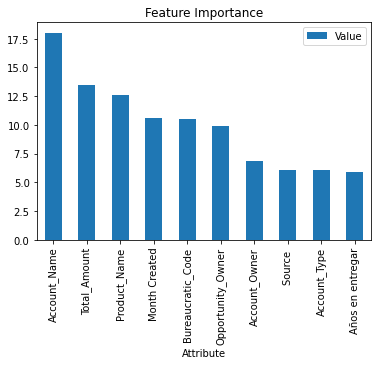

In [36]:
featureImportance.set_index("Attribute").sort_values(by = "Value", ascending = False).plot.bar(title = "Feature Importance")

In [ ]:
preds1 = []
for pred in preds:
    if pred < 0:
        preds1.append(0)
    else:
        preds1.append(pred)

In [ ]:
subir = pd.DataFrame()
subir['Opportunity_ID'] =X_test.reset_index()['Opportunity_ID']
subir['target'] = preds1
subir.sort_values('Opportunity_ID',inplace = True)
subir = subir.drop_duplicates('Opportunity_ID',keep = 'last')
subir.set_index('Opportunity_ID', inplace = True)
subir.describe()

In [ ]:
loss = log_loss(y_test, preds1)
loss

### Combinacion Random Forest Regressor con CATBoost

In [ ]:
modelo_final = RandomForestRegressor(random_state = 123, n_estimators = 1100, min_samples_leaf = 5)
modelo_final.fit(X = X_train_prep1.drop(columns = "Total_Amount"), y = y_train)

In [ ]:
RFPredicts = modelo_final.predict(X_test_prep1.drop(columns = "Total_Amount"))

In [ ]:
loss = log_loss(y_test, RFPredicts)
loss

In [ ]:
finalPreds = []
for i in range(len(RFPredicts)):
    value = (RFPredicts[i] + preds[i]) / 2
    finalPreds.append(value)

In [ ]:
loss = log_loss(y_test, finalPreds)
loss

In [139]:
DataFrame_test = pd.read_csv( "../Test/Test.csv" )
DataFrame_test

ID    Region   Territory  Pricing, Delivery_Terms_Quote_Appr  \
0      6140      EMEA     Germany                                   1   
1      6146      EMEA     Germany                                   1   
2      6151      EMEA     Germany                                   1   
3      6118      EMEA     Germany                                   1   
4      6124      EMEA     Germany                                   1   
...     ...       ...         ...                                 ...   
2546  16345      EMEA         KSA                                   1   
2547  15218  Americas  SE America                                   1   
2548  15224  Americas  SE America                                   1   
2549   7286  Americas  NE America                                   1   
2550  11263      EMEA     Belgium                                   1   

      Pricing, Delivery_Terms_Approved  Bureaucratic_Code_0_Approval  \
0                                    1                             1   
1                                    1                             1   
2                                    1                             1   
3                                    1                             1   
4                                    1                             1   
...                                ...                           ...   
2546                                 1                             0   
2547                                 1                             0   
2548                                 1                             1   
2549                                 1                             0   
2550                                 0                             0   

      Bureaucratic_Code_0_Approved  Submitted_for_Approval  \
0                                1                       0   
1                                1                       0   
2                                1                       0   
3                                1                       0   
4                                1                       0   
...                            ...                     ...   
2546                             0                       0   
2547                             0                       0   
2548                             1                       0   
2549                             0                       0   
2550                             0                       0   

        Bureaucratic_Code Account_Created_Date  ...      Month  \
0     Bureaucratic_Code_4             7/5/2017  ...   2019 - 5   
1     Bureaucratic_Code_4             7/5/2017  ...   2019 - 5   
2     Bureaucratic_Code_4             7/5/2017  ...   2019 - 5   
3     Bureaucratic_Code_4             7/5/2017  ...   2019 - 6   
4     Bureaucratic_Code_4             7/5/2017  ...   2019 - 6   
...                   ...                  ...  ...        ...   
2546  Bureaucratic_Code_4            6/12/2017  ...   2019 - 5   
2547  Bureaucratic_Code_4             6/8/2018  ...  2019 - 10   
2548  Bureaucratic_Code_4             6/8/2018  ...  2019 - 10   
2549  Bureaucratic_Code_4            8/29/2018  ...   2019 - 8   
2550  Bureaucratic_Code_5             3/3/2016  ...  2019 - 10   

     Delivery_Quarter Delivery_Year Actual_Delivery_Date  TRF  \
0                  Q2          2019                  NaT    0   
1                  Q2          2019                  NaT    0   
2                  Q2          2019                  NaT    0   
3                  Q2          2019                  NaT    1   
4                  Q2          2019                  NaT    0   
...               ...           ...                  ...  ...   
2546               Q2          2019                  NaT    0   
2547               Q4          2019                  NaT    0   
2548               Q4          2019                  NaT    0   
2549               Q3          2019                  NaT    0   
2550          

In [140]:

DataFrame_test.loc[DataFrame_test['Total_Amount_Currency'] == 'JPY', 'Total_Amount'] = DataFrame_test['Total_Amount']*0.0096
DataFrame_test.loc[DataFrame_test['Total_Amount_Currency'] == 'JPY', 'Total_Amount_Currency'] = 'USD'

DataFrame_test.loc[DataFrame_test['Total_Amount_Currency'] == 'EUR', 'Total_Amount'] = DataFrame_test['Total_Amount']*1.17
DataFrame_test.loc[DataFrame_test['Total_Amount_Currency'] == 'EUR', 'Total_Amount_Currency'] 
DataFrame_test.loc[DataFrame_test['Total_Amount_Currency'] == 'AUD', 'Total_Taxable_Amount'] = DataFrame_test['Total_Amount']*0.70
DataFrame_test.loc[DataFrame_test['Total_Amount_Currency'] == 'AUD', 'Total_Taxable_Amount_Currency'] = 'USD'

DataFrame_test.loc[DataFrame_test['Total_Amount_Currency'] == 'GBP', 'Total_Amount'] = DataFrame_test['Total_Amount']*1.29
DataFrame_test.loc[DataFrame_test['Total_Amount_Currency'] == 'GBP', 'Total_Amount_Currency'] = 'USD'

DataFrame_test['Opportunity_Created_Date'] = pd.to_datetime(DataFrame_test['Opportunity_Created_Date'],errors='coerce')

DataFrame_test["Year Created"] = DataFrame_test["Opportunity_Created_Date"].dt.year
DataFrame_test["Month Created"] =DataFrame_test["Opportunity_Created_Date"].dt.month
DataFrame_test["Expensive"] = np.where(DataFrame_test["Total_Amount"] >= 80000, 1, 0)


DataFrame_test = DataFrame_test.merge(entrenamiento_won_by_region, on = "Region")
DataFrame_test["Años en entregar"] = DataFrame_test["Delivery_Year"] - DataFrame_test["Year Created"]
DataFrame_test["Total_Taxable_Amount"].describe()

count    2.551000e+03
mean     3.393353e+06
std      2.430590e+07
min      0.000000e+00
25%      6.987750e+04
50%      2.195684e+05
75%      7.818624e+05
max      6.808725e+08
Name: Total_Taxable_Amount, dtype: float64

In [141]:
DataFrame_test

ID       Region Territory  Pricing, Delivery_Terms_Quote_Appr  \
0      6140         EMEA   Germany                                   1   
1      6146         EMEA   Germany                                   1   
2      6151         EMEA   Germany                                   1   
3      6118         EMEA   Germany                                   1   
4      6124         EMEA   Germany                                   1   
...     ...          ...       ...                                 ...   
2546   8547  Middle East       KSA                                   1   
2547   7968  Middle East    Jordan                                   1   
2548  13087  Middle East    Jordan                                   1   
2549  13098  Middle East    Jordan                                   1   
2550  13104  Middle East    Jordan                                   1   

      Pricing, Delivery_Terms_Approved  Bureaucratic_Code_0_Approval  \
0                                    1                             1   
1                                    1                             1   
2                                    1                             1   
3                                    1                             1   
4                                    1                             1   
...                                ...                           ...   
2546                                 1                             1   
2547                                 1                             1   
2548                                 1                             0   
2549                                 1                             1   
2550                                 1                             1   

      Bureaucratic_Code_0_Approved  Submitted_for_Approval  \
0                                1                       0   
1                                1                       0   
2                                1                       0   
3                                1                       0   
4                                1                       0   
...                            ...                     ...   
2546                             1                       0   
2547                             1                       0   
2548                             0                       0   
2549                             1                       0   
2550                             1                       0   

        Bureaucratic_Code Account_Created_Date  ... Total_Amount  \
0     Bureaucratic_Code_4             7/5/2017  ...    189820.80   
1     Bureaucratic_Code_4             7/5/2017  ...     91990.08   
2     Bureaucratic_Code_4             7/5/2017  ...    148069.35   
3     Bureaucratic_Code_4             7/5/2017  ...    284731.20   
4     Bureaucratic_Code_4             7/5/2017  ...    183980.16   
...                   ...                  ...  ...          ...   
2546  Bureaucratic_Code_4           10/15/2018  ...    301455.00   
2547  Bureaucratic_Code_4            8/21/2017  ...     76230.00   
2548  Bureaucratic_Code_4            3/17/2016  ...     75141.00   
2549  Bureaucratic_Code_4            3/17/2016  ...     35640.00   
2550  Bureaucratic_Code_4            3/17/2016  ...     40986.00   

     Total_Taxable_Amount_Currency Total_Taxable_Amount       Prod_Category_A  \
0                              EUR             367419.0  Prod_Category_A_None   
1                              EUR             367419.0  Prod_Category_A_None   
2                              EUR             367419.0  Prod_Category_A_None   
3                              EUR             757783.5  Prod_Category_A_None   
4                              EUR             757783.5  Prod_Category_A_None   
...                            ...                  ...                   ...   
2546                           USD             301455.0  Prod_Category_A_None   
2547                           USD           

In [142]:
DataFrame_test["Total_Amount"] = np.log(DataFrame_test["Total_Amount"])
DataFrame_test = DataFrame_test[['Opportunity_ID', "Total_Amount", "Años en entregar","Month Created", "Product_Name", "Opportunity_Owner"]]
DataFrame_test = DataFrame_test.drop_duplicates('Opportunity_ID',keep = 'first')
DataFrame_test.set_index('Opportunity_ID', inplace = True)
DataFrame_test["Product_Name"] = DataFrame_test["Product_Name"].map(mean_encoded_product)
DataFrame_test["Opportunity_Owner"] = DataFrame_test["Opportunity_Owner"].map(mean_encoded_owner)
DataFrame_test["Source "] = DataFrame_test["Source "].map(mean_encoded_source)
DataFrame_test["Account_Type"] = DataFrame_test["Account_Type"].map(mean_encoded_acc)
DataFrame_test["Account_Name"] = DataFrame_test["Account_Name"].map(mean_encoded_accow)

In [143]:
DataFrame_test["Product_Name"].fillna(mean_encoded_product["Other"], inplace = True)
DataFrame_test["Opportunity_Owner"].fillna(mean_encoded_owner["Other"], inplace = True)

In [144]:
DataFrame_test["Account_Name"].isnull().sum()

643

In [145]:
DataFrame_test["Account_Name"].fillna(mean_encoded_accow["Other"], inplace = True)

In [146]:
DataFrame_test["Account_Name"].isnull().sum()

0

In [54]:
from sklearn.impute import KNNImputer
imputer = KNNImputer(n_neighbors = 2)
test = pd.DataFrame(imputer.fit_transform(DataFrame_test), columns = DataFrame_test.columns, index = DataFrame_test.index)


In [134]:
test = DataFrame_test.copy()

In [304]:
# Se identifica el nobre de las columnas numéricas y categóricas
cat_cols = DataFrame_test.select_dtypes(include=['object', 'category']).columns.to_list()
numeric_cols = DataFrame_test.select_dtypes(include=['float64', 'int']).columns.to_list()

# Se aplica one-hot-encoding solo a las columnas categóricas
preprocessor = ColumnTransformer(
                    [('onehot', OneHotEncoder(handle_unknown='ignore'), cat_cols)],
                    remainder='passthrough'
               )

# Una vez que se ha definido el objeto ColumnTransformer, con el método fit()
# se aprenden las transformaciones con los datos de entrenamiento y se aplican a
# los dos conjuntos con transform(). Ambas operaciones a la vez con fit_transform().
KaggleTest = preprocessor.fit_transform(DataFrame_test)


#El resultado devuelto por ColumnTransformer es un numpy array, por lo que se pierden los nombres de las columnas. Es interesante poder inspeccionar cómo queda el set de datos tras el preprocesado en formato dataframe. Por defecto, OneHotEncoder ordena las nuevas columnas de izquierda a derecha por orden alfabético.

# Convertir el output del ColumnTransformer en dataframe y añadir nombre columnas
# ==============================================================================
# Nombre de todas las columnas
encoded_cat = preprocessor.named_transformers_['onehot'].get_feature_names(cat_cols)
labels = np.concatenate([encoded_cat, numeric_cols])

# Conversión a dataframe
KaggleTest = pd.DataFrame(KaggleTest, columns=labels)
KaggleTest.info()

NotFittedError: This OneHotEncoder instance is not fitted yet. Call 'fit' with appropriate arguments before using this estimator.

In [ ]:
KaggleTest.head(5)

In [59]:
ADAPredicts = adaModel.predict(test)

In [ ]:
CATPredicts = model.predict(KaggleTest)

In [ ]:
CATPredicts

In [ ]:
RFPredicts = modelo_final.predict(KaggleTest.drop(columns = "Total_Amount"))

In [ ]:
finalPreds = []
for i in range(len(RFPredicts)):
    value = (RFPredicts[i] + CATPredicts[i]) / 2
    finalPreds.append(value)

In [ ]:
finalPreds

In [60]:
subir = pd.DataFrame()
subir['Opportunity_ID'] = DataFrame_test.reset_index()['Opportunity_ID']
subir['target'] = ADAPredicts
subir.sort_values('Opportunity_ID',inplace = True)
subir = subir.drop_duplicates('Opportunity_ID',keep = 'last')
subir.set_index('Opportunity_ID', inplace = True)
subir

target
Opportunity_ID          
10689           0.378458
10690           0.321804
10691           0.745833
10692           0.384475
10693           0.887453
...                  ...
12364           0.964823
12365           0.611641
12366           0.186986
12367           0.424286
12368           0.261987

[1567 rows x 1 columns]

In [61]:
subir['target'].value_counts()

0.598769    12
0.582269     9
0.701056     6
0.332605     5
0.531191     5
            ..
0.827891     1
0.490964     1
0.446067     1
0.127981     1
0.964429     1
Name: target, Length: 1374, dtype: int64

In [62]:
subir.describe()

target
count  1567.000000
mean      0.549401
std       0.251311
min      -0.039299
25%       0.349243
50%       0.578485
75%       0.772093
max       1.021011

In [63]:
subir.to_csv('ADABoost7.csv')

In [21]:
from sklearn import svm
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC

clf = make_pipeline(StandardScaler(), svm.NuSVR())

In [320]:
clf.fit(X_train, y_train)

Pipeline(steps=[('standardscaler', StandardScaler()), ('nusvr', NuSVR())])

In [321]:
pred = clf.predict(X_test)
loss = log_loss(y_test, pred)

In [322]:
loss

0.6924924819764865

In [343]:
from sklearn.naive_bayes import BernoulliNB

In [344]:
gnb = BernoulliNB()
gnb.fit(X_train, y_train)

BernoulliNB()

In [345]:
pred = gnb.predict(X_test)
loss = log_loss(y_test, pred)

In [346]:
loss

9.323472732270755

In [18]:
from sklearn.ensemble import BaggingRegressor

In [19]:
regr1 = BaggingRegressor(base_estimator=RandomForestRegressor(random_state=123, n_estimators = 1100),
...                         n_estimators=10, random_state=0)

In [55]:
pred = regr1.predict(X_test)
log_loss(y_test, pred)

0.4382615645758496

In [92]:
from sklearn.neural_network import MLPRegressor
regr = MLPRegressor(activation = 'relu',alpha = 0.2, beta_1 = 0.85, hidden_layer_sizes = (70,70,70), solver = 'adam', max_iter = 1000, random_state = 123).fit(X_train, y_train)
pred = regr.predict(X_test)
log_loss(y_test, pred)

0.48754109745201857

In [93]:
regr.score(X_train, y_train)

0.3609713469531538

In [28]:
from sklearn.ensemble import VotingRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor

In [29]:
reg1 = model
reg3 = adaModel
ereg = VotingRegressor(estimators=[('gb', reg1), ('ada', reg3)])

ereg.fit(X_train, y_train)

0:	learn: 0.4950847	total: 452ms	remaining: 11m 18s
1:	learn: 0.4934014	total: 631ms	remaining: 7m 52s
2:	learn: 0.4916993	total: 807ms	remaining: 6m 42s
3:	learn: 0.4900490	total: 987ms	remaining: 6m 9s
4:	learn: 0.4883971	total: 1.17s	remaining: 5m 48s
5:	learn: 0.4867174	total: 1.35s	remaining: 5m 36s
6:	learn: 0.4850338	total: 1.53s	remaining: 5m 26s
7:	learn: 0.4833907	total: 1.71s	remaining: 5m 18s
8:	learn: 0.4817558	total: 1.89s	remaining: 5m 12s
9:	learn: 0.4800993	total: 2.07s	remaining: 5m 8s
10:	learn: 0.4785599	total: 2.25s	remaining: 5m 4s
11:	learn: 0.4769954	total: 2.43s	remaining: 5m 1s
12:	learn: 0.4755236	total: 2.43s	remaining: 4m 38s
13:	learn: 0.4739158	total: 2.63s	remaining: 4m 38s
14:	learn: 0.4723614	total: 2.84s	remaining: 4m 40s
15:	learn: 0.4708114	total: 3.02s	remaining: 4m 40s
16:	learn: 0.4692748	total: 3.2s	remaining: 4m 39s
17:	learn: 0.4677555	total: 3.38s	remaining: 4m 38s
18:	learn: 0.4662472	total: 3.56s	remaining: 4m 37s
19:	learn: 0.4647294	total

159:	learn: 0.3394315	total: 27.8s	remaining: 3m 52s
160:	learn: 0.3388676	total: 28s	remaining: 3m 52s
161:	learn: 0.3383467	total: 28.1s	remaining: 3m 52s
162:	learn: 0.3378218	total: 28.3s	remaining: 3m 52s
163:	learn: 0.3373156	total: 28.5s	remaining: 3m 52s
164:	learn: 0.3367862	total: 28.7s	remaining: 3m 51s
165:	learn: 0.3362897	total: 28.8s	remaining: 3m 51s
166:	learn: 0.3357940	total: 29s	remaining: 3m 51s
167:	learn: 0.3353683	total: 29.2s	remaining: 3m 51s
168:	learn: 0.3348709	total: 29.4s	remaining: 3m 51s
169:	learn: 0.3343368	total: 29.5s	remaining: 3m 51s
170:	learn: 0.3339002	total: 29.7s	remaining: 3m 50s
171:	learn: 0.3334396	total: 29.9s	remaining: 3m 50s
172:	learn: 0.3329943	total: 30.1s	remaining: 3m 50s
173:	learn: 0.3325231	total: 30.2s	remaining: 3m 50s
174:	learn: 0.3320756	total: 30.4s	remaining: 3m 50s
175:	learn: 0.3316613	total: 30.6s	remaining: 3m 50s
176:	learn: 0.3311854	total: 30.8s	remaining: 3m 50s
177:	learn: 0.3307427	total: 31s	remaining: 3m 49s

316:	learn: 0.2881757	total: 54.5s	remaining: 3m 23s
317:	learn: 0.2879097	total: 54.6s	remaining: 3m 23s
318:	learn: 0.2876495	total: 54.8s	remaining: 3m 22s
319:	learn: 0.2874907	total: 55s	remaining: 3m 22s
320:	learn: 0.2872604	total: 55.2s	remaining: 3m 22s
321:	learn: 0.2870981	total: 55.3s	remaining: 3m 22s
322:	learn: 0.2869334	total: 55.5s	remaining: 3m 22s
323:	learn: 0.2866845	total: 55.7s	remaining: 3m 22s
324:	learn: 0.2865082	total: 55.9s	remaining: 3m 22s
325:	learn: 0.2863347	total: 56s	remaining: 3m 21s
326:	learn: 0.2862801	total: 56s	remaining: 3m 21s
327:	learn: 0.2861138	total: 56.2s	remaining: 3m 20s
328:	learn: 0.2859323	total: 56.4s	remaining: 3m 20s
329:	learn: 0.2857315	total: 56.6s	remaining: 3m 20s
330:	learn: 0.2854434	total: 56.8s	remaining: 3m 20s
331:	learn: 0.2852715	total: 56.9s	remaining: 3m 20s
332:	learn: 0.2850755	total: 57.1s	remaining: 3m 20s
333:	learn: 0.2849152	total: 57.3s	remaining: 3m 19s
334:	learn: 0.2846811	total: 57.5s	remaining: 3m 19s

472:	learn: 0.2637499	total: 1m 20s	remaining: 2m 55s
473:	learn: 0.2636220	total: 1m 20s	remaining: 2m 55s
474:	learn: 0.2635402	total: 1m 21s	remaining: 2m 55s
475:	learn: 0.2633621	total: 1m 21s	remaining: 2m 55s
476:	learn: 0.2632484	total: 1m 21s	remaining: 2m 54s
477:	learn: 0.2631413	total: 1m 21s	remaining: 2m 54s
478:	learn: 0.2630568	total: 1m 21s	remaining: 2m 54s
479:	learn: 0.2629610	total: 1m 22s	remaining: 2m 54s
480:	learn: 0.2628449	total: 1m 22s	remaining: 2m 54s
481:	learn: 0.2627249	total: 1m 22s	remaining: 2m 54s
482:	learn: 0.2626234	total: 1m 22s	remaining: 2m 53s
483:	learn: 0.2624526	total: 1m 22s	remaining: 2m 53s
484:	learn: 0.2623611	total: 1m 22s	remaining: 2m 53s
485:	learn: 0.2622008	total: 1m 23s	remaining: 2m 53s
486:	learn: 0.2620950	total: 1m 23s	remaining: 2m 53s
487:	learn: 0.2619158	total: 1m 23s	remaining: 2m 53s
488:	learn: 0.2618015	total: 1m 23s	remaining: 2m 52s
489:	learn: 0.2616319	total: 1m 23s	remaining: 2m 52s
490:	learn: 0.2615017	total:

624:	learn: 0.2479485	total: 1m 46s	remaining: 2m 28s
625:	learn: 0.2478752	total: 1m 46s	remaining: 2m 28s
626:	learn: 0.2478214	total: 1m 46s	remaining: 2m 28s
627:	learn: 0.2477148	total: 1m 46s	remaining: 2m 28s
628:	learn: 0.2476235	total: 1m 46s	remaining: 2m 27s
629:	learn: 0.2475189	total: 1m 46s	remaining: 2m 27s
630:	learn: 0.2474466	total: 1m 47s	remaining: 2m 27s
631:	learn: 0.2473353	total: 1m 47s	remaining: 2m 27s
632:	learn: 0.2472291	total: 1m 47s	remaining: 2m 27s
633:	learn: 0.2470730	total: 1m 47s	remaining: 2m 27s
634:	learn: 0.2469607	total: 1m 47s	remaining: 2m 26s
635:	learn: 0.2469541	total: 1m 47s	remaining: 2m 26s
636:	learn: 0.2468433	total: 1m 48s	remaining: 2m 26s
637:	learn: 0.2467744	total: 1m 48s	remaining: 2m 26s
638:	learn: 0.2466716	total: 1m 48s	remaining: 2m 26s
639:	learn: 0.2466130	total: 1m 48s	remaining: 2m 25s
640:	learn: 0.2465276	total: 1m 48s	remaining: 2m 25s
641:	learn: 0.2464515	total: 1m 48s	remaining: 2m 25s
642:	learn: 0.2463484	total:

780:	learn: 0.2349568	total: 2m 11s	remaining: 2m 1s
781:	learn: 0.2349425	total: 2m 11s	remaining: 2m
782:	learn: 0.2348928	total: 2m 11s	remaining: 2m
783:	learn: 0.2348083	total: 2m 11s	remaining: 2m
784:	learn: 0.2347309	total: 2m 12s	remaining: 2m
785:	learn: 0.2345836	total: 2m 12s	remaining: 2m
786:	learn: 0.2345077	total: 2m 12s	remaining: 1m 59s
787:	learn: 0.2344433	total: 2m 12s	remaining: 1m 59s
788:	learn: 0.2343902	total: 2m 12s	remaining: 1m 59s
789:	learn: 0.2342907	total: 2m 12s	remaining: 1m 59s
790:	learn: 0.2341938	total: 2m 13s	remaining: 1m 59s
791:	learn: 0.2340949	total: 2m 13s	remaining: 1m 59s
792:	learn: 0.2340162	total: 2m 13s	remaining: 1m 59s
793:	learn: 0.2339484	total: 2m 13s	remaining: 1m 58s
794:	learn: 0.2338148	total: 2m 13s	remaining: 1m 58s
795:	learn: 0.2337667	total: 2m 14s	remaining: 1m 58s
796:	learn: 0.2336712	total: 2m 14s	remaining: 1m 58s
797:	learn: 0.2335585	total: 2m 14s	remaining: 1m 58s
798:	learn: 0.2334897	total: 2m 14s	remaining: 1m

934:	learn: 0.2241579	total: 2m 36s	remaining: 1m 34s
935:	learn: 0.2241185	total: 2m 37s	remaining: 1m 34s
936:	learn: 0.2240391	total: 2m 37s	remaining: 1m 34s
937:	learn: 0.2239841	total: 2m 37s	remaining: 1m 34s
938:	learn: 0.2239318	total: 2m 37s	remaining: 1m 34s
939:	learn: 0.2238449	total: 2m 37s	remaining: 1m 34s
940:	learn: 0.2237997	total: 2m 38s	remaining: 1m 33s
941:	learn: 0.2237368	total: 2m 38s	remaining: 1m 33s
942:	learn: 0.2236166	total: 2m 38s	remaining: 1m 33s
943:	learn: 0.2235608	total: 2m 38s	remaining: 1m 33s
944:	learn: 0.2234912	total: 2m 38s	remaining: 1m 33s
945:	learn: 0.2234104	total: 2m 38s	remaining: 1m 33s
946:	learn: 0.2233079	total: 2m 39s	remaining: 1m 32s
947:	learn: 0.2232668	total: 2m 39s	remaining: 1m 32s
948:	learn: 0.2231963	total: 2m 39s	remaining: 1m 32s
949:	learn: 0.2231155	total: 2m 39s	remaining: 1m 32s
950:	learn: 0.2230324	total: 2m 39s	remaining: 1m 32s
951:	learn: 0.2229599	total: 2m 39s	remaining: 1m 32s
952:	learn: 0.2228746	total:

1085:	learn: 0.2146998	total: 3m 2s	remaining: 1m 9s
1086:	learn: 0.2146554	total: 3m 2s	remaining: 1m 9s
1087:	learn: 0.2145880	total: 3m 2s	remaining: 1m 9s
1088:	learn: 0.2144756	total: 3m 2s	remaining: 1m 8s
1089:	learn: 0.2144741	total: 3m 2s	remaining: 1m 8s
1090:	learn: 0.2143798	total: 3m 2s	remaining: 1m 8s
1091:	learn: 0.2143445	total: 3m 2s	remaining: 1m 8s
1092:	learn: 0.2143052	total: 3m 3s	remaining: 1m 8s
1093:	learn: 0.2142320	total: 3m 3s	remaining: 1m 8s
1094:	learn: 0.2141727	total: 3m 3s	remaining: 1m 7s
1095:	learn: 0.2140945	total: 3m 3s	remaining: 1m 7s
1096:	learn: 0.2140305	total: 3m 3s	remaining: 1m 7s
1097:	learn: 0.2139309	total: 3m 3s	remaining: 1m 7s
1098:	learn: 0.2138491	total: 3m 4s	remaining: 1m 7s
1099:	learn: 0.2138087	total: 3m 4s	remaining: 1m 7s
1100:	learn: 0.2137444	total: 3m 4s	remaining: 1m 6s
1101:	learn: 0.2136695	total: 3m 4s	remaining: 1m 6s
1102:	learn: 0.2136157	total: 3m 4s	remaining: 1m 6s
1103:	learn: 0.2135414	total: 3m 5s	remaining:

1240:	learn: 0.2049867	total: 3m 28s	remaining: 43.5s
1241:	learn: 0.2049099	total: 3m 28s	remaining: 43.3s
1242:	learn: 0.2048451	total: 3m 28s	remaining: 43.2s
1243:	learn: 0.2047723	total: 3m 28s	remaining: 43s
1244:	learn: 0.2047715	total: 3m 28s	remaining: 42.8s
1245:	learn: 0.2047034	total: 3m 29s	remaining: 42.6s
1246:	learn: 0.2046338	total: 3m 29s	remaining: 42.5s
1247:	learn: 0.2045814	total: 3m 29s	remaining: 42.3s
1248:	learn: 0.2045271	total: 3m 29s	remaining: 42.1s
1249:	learn: 0.2044722	total: 3m 29s	remaining: 42s
1250:	learn: 0.2044156	total: 3m 30s	remaining: 41.8s
1251:	learn: 0.2043254	total: 3m 30s	remaining: 41.6s
1252:	learn: 0.2042720	total: 3m 30s	remaining: 41.5s
1253:	learn: 0.2041908	total: 3m 30s	remaining: 41.3s
1254:	learn: 0.2041336	total: 3m 30s	remaining: 41.1s
1255:	learn: 0.2040516	total: 3m 30s	remaining: 41s
1256:	learn: 0.2039675	total: 3m 31s	remaining: 40.8s
1257:	learn: 0.2039086	total: 3m 31s	remaining: 40.6s
1258:	learn: 0.2038432	total: 3m 3

1394:	learn: 0.1963017	total: 3m 54s	remaining: 17.7s
1395:	learn: 0.1962788	total: 3m 55s	remaining: 17.5s
1396:	learn: 0.1962436	total: 3m 55s	remaining: 17.3s
1397:	learn: 0.1961856	total: 3m 55s	remaining: 17.2s
1398:	learn: 0.1961220	total: 3m 55s	remaining: 17s
1399:	learn: 0.1960791	total: 3m 55s	remaining: 16.8s
1400:	learn: 0.1960169	total: 3m 55s	remaining: 16.7s
1401:	learn: 0.1959436	total: 3m 56s	remaining: 16.5s
1402:	learn: 0.1958578	total: 3m 56s	remaining: 16.3s
1403:	learn: 0.1958144	total: 3m 56s	remaining: 16.2s
1404:	learn: 0.1957736	total: 3m 56s	remaining: 16s
1405:	learn: 0.1957169	total: 3m 56s	remaining: 15.8s
1406:	learn: 0.1956588	total: 3m 57s	remaining: 15.7s
1407:	learn: 0.1955912	total: 3m 57s	remaining: 15.5s
1408:	learn: 0.1955453	total: 3m 57s	remaining: 15.3s
1409:	learn: 0.1954490	total: 3m 57s	remaining: 15.2s
1410:	learn: 0.1953789	total: 3m 57s	remaining: 15s
1411:	learn: 0.1953387	total: 3m 57s	remaining: 14.8s
1412:	learn: 0.1952801	total: 3m 5

112:	learn: 0.3911139	total: 198ms	remaining: 2.43s
113:	learn: 0.3905498	total: 202ms	remaining: 2.46s
114:	learn: 0.3900352	total: 205ms	remaining: 2.47s
115:	learn: 0.3895462	total: 207ms	remaining: 2.46s
116:	learn: 0.3890697	total: 208ms	remaining: 2.46s
117:	learn: 0.3885914	total: 212ms	remaining: 2.49s
118:	learn: 0.3881413	total: 216ms	remaining: 2.51s
119:	learn: 0.3876701	total: 218ms	remaining: 2.51s
120:	learn: 0.3872257	total: 226ms	remaining: 2.57s
121:	learn: 0.3867623	total: 235ms	remaining: 2.65s
122:	learn: 0.3863028	total: 237ms	remaining: 2.65s
123:	learn: 0.3857860	total: 239ms	remaining: 2.65s
124:	learn: 0.3853762	total: 240ms	remaining: 2.64s
125:	learn: 0.3848833	total: 241ms	remaining: 2.63s
126:	learn: 0.3844668	total: 243ms	remaining: 2.63s
127:	learn: 0.3840805	total: 244ms	remaining: 2.62s
128:	learn: 0.3836271	total: 246ms	remaining: 2.61s
129:	learn: 0.3832008	total: 248ms	remaining: 2.61s
130:	learn: 0.3827417	total: 249ms	remaining: 2.6s
131:	learn: 0

310:	learn: 0.3440967	total: 593ms	remaining: 2.27s
311:	learn: 0.3439969	total: 595ms	remaining: 2.27s
312:	learn: 0.3439039	total: 597ms	remaining: 2.26s
313:	learn: 0.3438098	total: 598ms	remaining: 2.26s
314:	learn: 0.3437183	total: 600ms	remaining: 2.25s
315:	learn: 0.3436079	total: 604ms	remaining: 2.26s
316:	learn: 0.3435237	total: 609ms	remaining: 2.27s
317:	learn: 0.3434153	total: 612ms	remaining: 2.27s
318:	learn: 0.3433003	total: 614ms	remaining: 2.27s
319:	learn: 0.3432251	total: 615ms	remaining: 2.27s
320:	learn: 0.3431237	total: 617ms	remaining: 2.26s
321:	learn: 0.3429822	total: 618ms	remaining: 2.26s
322:	learn: 0.3428691	total: 624ms	remaining: 2.27s
323:	learn: 0.3427665	total: 628ms	remaining: 2.28s
324:	learn: 0.3426289	total: 632ms	remaining: 2.29s
325:	learn: 0.3424938	total: 637ms	remaining: 2.29s
326:	learn: 0.3423909	total: 639ms	remaining: 2.29s
327:	learn: 0.3422974	total: 641ms	remaining: 2.29s
328:	learn: 0.3422186	total: 643ms	remaining: 2.29s
329:	learn: 

524:	learn: 0.3295338	total: 984ms	remaining: 1.83s
525:	learn: 0.3294914	total: 989ms	remaining: 1.83s
526:	learn: 0.3294467	total: 993ms	remaining: 1.83s
527:	learn: 0.3294046	total: 994ms	remaining: 1.83s
528:	learn: 0.3293690	total: 996ms	remaining: 1.83s
529:	learn: 0.3293175	total: 997ms	remaining: 1.82s
530:	learn: 0.3292823	total: 999ms	remaining: 1.82s
531:	learn: 0.3292544	total: 1s	remaining: 1.82s
532:	learn: 0.3292073	total: 1.01s	remaining: 1.83s
533:	learn: 0.3291487	total: 1.01s	remaining: 1.82s
534:	learn: 0.3290973	total: 1.01s	remaining: 1.83s
535:	learn: 0.3290491	total: 1.02s	remaining: 1.83s
536:	learn: 0.3290296	total: 1.02s	remaining: 1.83s
537:	learn: 0.3289906	total: 1.02s	remaining: 1.83s
538:	learn: 0.3289332	total: 1.02s	remaining: 1.83s
539:	learn: 0.3288887	total: 1.02s	remaining: 1.82s
540:	learn: 0.3288180	total: 1.03s	remaining: 1.82s
541:	learn: 0.3287940	total: 1.03s	remaining: 1.82s
542:	learn: 0.3287346	total: 1.03s	remaining: 1.82s
543:	learn: 0.3

733:	learn: 0.3194367	total: 1.38s	remaining: 1.44s
734:	learn: 0.3194011	total: 1.38s	remaining: 1.44s
735:	learn: 0.3193799	total: 1.38s	remaining: 1.44s
736:	learn: 0.3193207	total: 1.39s	remaining: 1.44s
737:	learn: 0.3192742	total: 1.39s	remaining: 1.43s
738:	learn: 0.3192352	total: 1.39s	remaining: 1.43s
739:	learn: 0.3191814	total: 1.39s	remaining: 1.43s
740:	learn: 0.3191660	total: 1.39s	remaining: 1.43s
741:	learn: 0.3191380	total: 1.39s	remaining: 1.42s
742:	learn: 0.3190827	total: 1.4s	remaining: 1.42s
743:	learn: 0.3189929	total: 1.4s	remaining: 1.42s
744:	learn: 0.3189430	total: 1.4s	remaining: 1.42s
745:	learn: 0.3189083	total: 1.4s	remaining: 1.42s
746:	learn: 0.3188553	total: 1.4s	remaining: 1.41s
747:	learn: 0.3187837	total: 1.4s	remaining: 1.41s
748:	learn: 0.3187090	total: 1.4s	remaining: 1.41s
749:	learn: 0.3186536	total: 1.41s	remaining: 1.41s
750:	learn: 0.3185938	total: 1.41s	remaining: 1.41s
751:	learn: 0.3185450	total: 1.42s	remaining: 1.41s
752:	learn: 0.31851

961:	learn: 0.3097211	total: 1.79s	remaining: 1s
962:	learn: 0.3096710	total: 1.79s	remaining: 1000ms
963:	learn: 0.3096128	total: 1.8s	remaining: 1000ms
964:	learn: 0.3095804	total: 1.8s	remaining: 999ms
965:	learn: 0.3095288	total: 1.81s	remaining: 999ms
966:	learn: 0.3095099	total: 1.81s	remaining: 998ms
967:	learn: 0.3094837	total: 1.81s	remaining: 996ms
968:	learn: 0.3094190	total: 1.81s	remaining: 994ms
969:	learn: 0.3093761	total: 1.81s	remaining: 992ms
970:	learn: 0.3093322	total: 1.82s	remaining: 990ms
971:	learn: 0.3093149	total: 1.82s	remaining: 988ms
972:	learn: 0.3092746	total: 1.82s	remaining: 986ms
973:	learn: 0.3092418	total: 1.82s	remaining: 984ms
974:	learn: 0.3091946	total: 1.82s	remaining: 982ms
975:	learn: 0.3091677	total: 1.83s	remaining: 981ms
976:	learn: 0.3091400	total: 1.83s	remaining: 980ms
977:	learn: 0.3091051	total: 1.83s	remaining: 979ms
978:	learn: 0.3090756	total: 1.83s	remaining: 977ms
979:	learn: 0.3090443	total: 1.84s	remaining: 975ms
980:	learn: 0.3

1179:	learn: 0.3008179	total: 2.18s	remaining: 592ms
1180:	learn: 0.3007667	total: 2.19s	remaining: 591ms
1181:	learn: 0.3007033	total: 2.19s	remaining: 589ms
1182:	learn: 0.3006781	total: 2.19s	remaining: 587ms
1183:	learn: 0.3006429	total: 2.19s	remaining: 585ms
1184:	learn: 0.3006063	total: 2.19s	remaining: 583ms
1185:	learn: 0.3005663	total: 2.2s	remaining: 582ms
1186:	learn: 0.3005473	total: 2.2s	remaining: 580ms
1187:	learn: 0.3005153	total: 2.2s	remaining: 578ms
1188:	learn: 0.3004370	total: 2.2s	remaining: 576ms
1189:	learn: 0.3004126	total: 2.2s	remaining: 574ms
1190:	learn: 0.3003454	total: 2.2s	remaining: 572ms
1191:	learn: 0.3002915	total: 2.21s	remaining: 570ms
1192:	learn: 0.3002380	total: 2.21s	remaining: 568ms
1193:	learn: 0.3001927	total: 2.21s	remaining: 566ms
1194:	learn: 0.3001448	total: 2.22s	remaining: 566ms
1195:	learn: 0.3001128	total: 2.22s	remaining: 564ms
1196:	learn: 0.3000911	total: 2.22s	remaining: 562ms
1197:	learn: 0.3000524	total: 2.22s	remaining: 560ms

1403:	learn: 0.2922285	total: 2.58s	remaining: 176ms
1404:	learn: 0.2922005	total: 2.58s	remaining: 174ms
1405:	learn: 0.2921761	total: 2.58s	remaining: 173ms
1406:	learn: 0.2921333	total: 2.58s	remaining: 171ms
1407:	learn: 0.2921076	total: 2.59s	remaining: 169ms
1408:	learn: 0.2920594	total: 2.59s	remaining: 167ms
1409:	learn: 0.2919988	total: 2.59s	remaining: 165ms
1410:	learn: 0.2919701	total: 2.59s	remaining: 164ms
1411:	learn: 0.2919400	total: 2.6s	remaining: 162ms
1412:	learn: 0.2918725	total: 2.6s	remaining: 160ms
1413:	learn: 0.2918376	total: 2.6s	remaining: 158ms
1414:	learn: 0.2918182	total: 2.6s	remaining: 156ms
1415:	learn: 0.2917874	total: 2.6s	remaining: 154ms
1416:	learn: 0.2917558	total: 2.6s	remaining: 153ms
1417:	learn: 0.2917346	total: 2.61s	remaining: 151ms
1418:	learn: 0.2917126	total: 2.61s	remaining: 149ms
1419:	learn: 0.2916904	total: 2.61s	remaining: 147ms
1420:	learn: 0.2916481	total: 2.61s	remaining: 145ms
1421:	learn: 0.2916047	total: 2.62s	remaining: 144ms

121:	learn: 0.3864960	total: 200ms	remaining: 2.26s
122:	learn: 0.3860307	total: 205ms	remaining: 2.29s
123:	learn: 0.3855063	total: 206ms	remaining: 2.29s
124:	learn: 0.3850303	total: 208ms	remaining: 2.28s
125:	learn: 0.3845529	total: 209ms	remaining: 2.28s
126:	learn: 0.3841104	total: 210ms	remaining: 2.27s
127:	learn: 0.3837052	total: 212ms	remaining: 2.27s
128:	learn: 0.3832965	total: 213ms	remaining: 2.27s
129:	learn: 0.3829082	total: 215ms	remaining: 2.27s
130:	learn: 0.3824632	total: 217ms	remaining: 2.26s
131:	learn: 0.3820612	total: 218ms	remaining: 2.26s
132:	learn: 0.3815952	total: 221ms	remaining: 2.27s
133:	learn: 0.3812114	total: 222ms	remaining: 2.27s
134:	learn: 0.3807330	total: 224ms	remaining: 2.26s
135:	learn: 0.3803536	total: 225ms	remaining: 2.26s
136:	learn: 0.3799616	total: 227ms	remaining: 2.26s
137:	learn: 0.3795423	total: 229ms	remaining: 2.25s
138:	learn: 0.3792121	total: 232ms	remaining: 2.27s
139:	learn: 0.3788219	total: 237ms	remaining: 2.3s
140:	learn: 0

336:	learn: 0.3408194	total: 591ms	remaining: 2.04s
337:	learn: 0.3406981	total: 595ms	remaining: 2.04s
338:	learn: 0.3406125	total: 598ms	remaining: 2.05s
339:	learn: 0.3404539	total: 599ms	remaining: 2.04s
340:	learn: 0.3403583	total: 601ms	remaining: 2.04s
341:	learn: 0.3402801	total: 602ms	remaining: 2.04s
342:	learn: 0.3401804	total: 604ms	remaining: 2.04s
343:	learn: 0.3401002	total: 606ms	remaining: 2.04s
344:	learn: 0.3399864	total: 607ms	remaining: 2.03s
345:	learn: 0.3398982	total: 609ms	remaining: 2.03s
346:	learn: 0.3398044	total: 610ms	remaining: 2.03s
347:	learn: 0.3396310	total: 612ms	remaining: 2.02s
348:	learn: 0.3395431	total: 613ms	remaining: 2.02s
349:	learn: 0.3394302	total: 615ms	remaining: 2.02s
350:	learn: 0.3393657	total: 620ms	remaining: 2.03s
351:	learn: 0.3393085	total: 624ms	remaining: 2.04s
352:	learn: 0.3392488	total: 627ms	remaining: 2.04s
353:	learn: 0.3391603	total: 629ms	remaining: 2.04s
354:	learn: 0.3390561	total: 630ms	remaining: 2.03s
355:	learn: 

560:	learn: 0.3257188	total: 985ms	remaining: 1.65s
561:	learn: 0.3256729	total: 989ms	remaining: 1.65s
562:	learn: 0.3256345	total: 991ms	remaining: 1.65s
563:	learn: 0.3255885	total: 992ms	remaining: 1.65s
564:	learn: 0.3255680	total: 994ms	remaining: 1.64s
565:	learn: 0.3255067	total: 996ms	remaining: 1.64s
566:	learn: 0.3254828	total: 998ms	remaining: 1.64s
567:	learn: 0.3254285	total: 1000ms	remaining: 1.64s
568:	learn: 0.3253929	total: 1s	remaining: 1.64s
569:	learn: 0.3253579	total: 1s	remaining: 1.64s
570:	learn: 0.3253089	total: 1s	remaining: 1.63s
571:	learn: 0.3252291	total: 1.01s	remaining: 1.63s
572:	learn: 0.3251148	total: 1.01s	remaining: 1.64s
573:	learn: 0.3250856	total: 1.02s	remaining: 1.64s
574:	learn: 0.3250580	total: 1.02s	remaining: 1.64s
575:	learn: 0.3249916	total: 1.02s	remaining: 1.64s
576:	learn: 0.3249753	total: 1.02s	remaining: 1.64s
577:	learn: 0.3249358	total: 1.02s	remaining: 1.63s
578:	learn: 0.3248884	total: 1.02s	remaining: 1.63s
579:	learn: 0.324865

791:	learn: 0.3155813	total: 1.38s	remaining: 1.23s
792:	learn: 0.3155106	total: 1.38s	remaining: 1.23s
793:	learn: 0.3154877	total: 1.38s	remaining: 1.23s
794:	learn: 0.3154567	total: 1.38s	remaining: 1.23s
795:	learn: 0.3154363	total: 1.38s	remaining: 1.22s
796:	learn: 0.3153793	total: 1.38s	remaining: 1.22s
797:	learn: 0.3153494	total: 1.39s	remaining: 1.22s
798:	learn: 0.3153284	total: 1.39s	remaining: 1.22s
799:	learn: 0.3152821	total: 1.39s	remaining: 1.22s
800:	learn: 0.3152514	total: 1.39s	remaining: 1.21s
801:	learn: 0.3151843	total: 1.39s	remaining: 1.21s
802:	learn: 0.3151543	total: 1.39s	remaining: 1.21s
803:	learn: 0.3150941	total: 1.4s	remaining: 1.21s
804:	learn: 0.3150797	total: 1.4s	remaining: 1.21s
805:	learn: 0.3150629	total: 1.4s	remaining: 1.21s
806:	learn: 0.3150206	total: 1.41s	remaining: 1.21s
807:	learn: 0.3150055	total: 1.41s	remaining: 1.21s
808:	learn: 0.3149856	total: 1.41s	remaining: 1.21s
809:	learn: 0.3149106	total: 1.41s	remaining: 1.2s
810:	learn: 0.31

1023:	learn: 0.3067467	total: 1.77s	remaining: 824ms
1024:	learn: 0.3067219	total: 1.78s	remaining: 823ms
1025:	learn: 0.3066807	total: 1.78s	remaining: 822ms
1026:	learn: 0.3066582	total: 1.78s	remaining: 820ms
1027:	learn: 0.3066452	total: 1.78s	remaining: 818ms
1028:	learn: 0.3066210	total: 1.78s	remaining: 816ms
1029:	learn: 0.3066025	total: 1.78s	remaining: 814ms
1030:	learn: 0.3065397	total: 1.78s	remaining: 812ms
1031:	learn: 0.3065017	total: 1.79s	remaining: 810ms
1032:	learn: 0.3064570	total: 1.79s	remaining: 809ms
1033:	learn: 0.3064303	total: 1.79s	remaining: 807ms
1034:	learn: 0.3064038	total: 1.79s	remaining: 805ms
1035:	learn: 0.3063618	total: 1.79s	remaining: 803ms
1036:	learn: 0.3063026	total: 1.79s	remaining: 801ms
1037:	learn: 0.3062658	total: 1.8s	remaining: 800ms
1038:	learn: 0.3062468	total: 1.8s	remaining: 798ms
1039:	learn: 0.3062123	total: 1.8s	remaining: 796ms
1040:	learn: 0.3061816	total: 1.8s	remaining: 794ms
1041:	learn: 0.3061639	total: 1.8s	remaining: 792m

1268:	learn: 0.2975681	total: 2.17s	remaining: 394ms
1269:	learn: 0.2975420	total: 2.17s	remaining: 393ms
1270:	learn: 0.2974980	total: 2.17s	remaining: 391ms
1271:	learn: 0.2974510	total: 2.17s	remaining: 390ms
1272:	learn: 0.2973855	total: 2.17s	remaining: 388ms
1273:	learn: 0.2973445	total: 2.18s	remaining: 386ms
1274:	learn: 0.2973209	total: 2.18s	remaining: 384ms
1275:	learn: 0.2973017	total: 2.18s	remaining: 383ms
1276:	learn: 0.2972500	total: 2.18s	remaining: 381ms
1277:	learn: 0.2972142	total: 2.18s	remaining: 379ms
1278:	learn: 0.2971967	total: 2.18s	remaining: 377ms
1279:	learn: 0.2971600	total: 2.19s	remaining: 376ms
1280:	learn: 0.2971384	total: 2.19s	remaining: 375ms
1281:	learn: 0.2971104	total: 2.2s	remaining: 374ms
1282:	learn: 0.2970558	total: 2.2s	remaining: 372ms
1283:	learn: 0.2970164	total: 2.2s	remaining: 370ms
1284:	learn: 0.2969756	total: 2.2s	remaining: 368ms
1285:	learn: 0.2969464	total: 2.2s	remaining: 367ms
1286:	learn: 0.2969286	total: 2.2s	remaining: 365ms

1496:	learn: 0.2888926	total: 2.56s	remaining: 5.12ms
1497:	learn: 0.2888402	total: 2.56s	remaining: 3.42ms
1498:	learn: 0.2887903	total: 2.56s	remaining: 1.71ms
1499:	learn: 0.2887637	total: 2.56s	remaining: 0us
0:	learn: 0.4957660	total: 1.52ms	remaining: 2.28s
1:	learn: 0.4941916	total: 2.93ms	remaining: 2.19s
2:	learn: 0.4925581	total: 4.35ms	remaining: 2.17s
3:	learn: 0.4909935	total: 5.74ms	remaining: 2.15s
4:	learn: 0.4894475	total: 7.16ms	remaining: 2.14s
5:	learn: 0.4878741	total: 8.57ms	remaining: 2.13s
6:	learn: 0.4863768	total: 10ms	remaining: 2.14s
7:	learn: 0.4848478	total: 11.5ms	remaining: 2.14s
8:	learn: 0.4834546	total: 12.9ms	remaining: 2.14s
9:	learn: 0.4820901	total: 14.3ms	remaining: 2.14s
10:	learn: 0.4806392	total: 15.7ms	remaining: 2.13s
11:	learn: 0.4791930	total: 17.1ms	remaining: 2.12s
12:	learn: 0.4777690	total: 18.6ms	remaining: 2.13s
13:	learn: 0.4763856	total: 20ms	remaining: 2.12s
14:	learn: 0.4750320	total: 21.4ms	remaining: 2.12s
15:	learn: 0.4736543	

226:	learn: 0.3528627	total: 393ms	remaining: 2.2s
227:	learn: 0.3527284	total: 398ms	remaining: 2.22s
228:	learn: 0.3525661	total: 401ms	remaining: 2.23s
229:	learn: 0.3523810	total: 403ms	remaining: 2.23s
230:	learn: 0.3522246	total: 405ms	remaining: 2.22s
231:	learn: 0.3520448	total: 407ms	remaining: 2.23s
232:	learn: 0.3519155	total: 409ms	remaining: 2.22s
233:	learn: 0.3517236	total: 411ms	remaining: 2.23s
234:	learn: 0.3515799	total: 413ms	remaining: 2.22s
235:	learn: 0.3513896	total: 416ms	remaining: 2.23s
236:	learn: 0.3512055	total: 418ms	remaining: 2.23s
237:	learn: 0.3509350	total: 420ms	remaining: 2.23s
238:	learn: 0.3508018	total: 423ms	remaining: 2.23s
239:	learn: 0.3506574	total: 425ms	remaining: 2.23s
240:	learn: 0.3504946	total: 426ms	remaining: 2.23s
241:	learn: 0.3503086	total: 427ms	remaining: 2.22s
242:	learn: 0.3501246	total: 429ms	remaining: 2.22s
243:	learn: 0.3499241	total: 431ms	remaining: 2.22s
244:	learn: 0.3497376	total: 432ms	remaining: 2.21s
245:	learn: 0

446:	learn: 0.3298489	total: 786ms	remaining: 1.85s
447:	learn: 0.3297823	total: 788ms	remaining: 1.85s
448:	learn: 0.3297327	total: 790ms	remaining: 1.85s
449:	learn: 0.3296818	total: 792ms	remaining: 1.85s
450:	learn: 0.3296497	total: 793ms	remaining: 1.84s
451:	learn: 0.3295725	total: 795ms	remaining: 1.84s
452:	learn: 0.3295050	total: 796ms	remaining: 1.84s
453:	learn: 0.3294466	total: 800ms	remaining: 1.84s
454:	learn: 0.3294170	total: 804ms	remaining: 1.84s
455:	learn: 0.3293345	total: 808ms	remaining: 1.85s
456:	learn: 0.3292981	total: 809ms	remaining: 1.85s
457:	learn: 0.3291979	total: 811ms	remaining: 1.84s
458:	learn: 0.3291494	total: 813ms	remaining: 1.84s
459:	learn: 0.3290851	total: 815ms	remaining: 1.84s
460:	learn: 0.3290306	total: 816ms	remaining: 1.84s
461:	learn: 0.3289575	total: 818ms	remaining: 1.84s
462:	learn: 0.3289197	total: 819ms	remaining: 1.83s
463:	learn: 0.3288707	total: 821ms	remaining: 1.83s
464:	learn: 0.3287875	total: 822ms	remaining: 1.83s
465:	learn: 

670:	learn: 0.3185707	total: 1.18s	remaining: 1.45s
671:	learn: 0.3185252	total: 1.18s	remaining: 1.45s
672:	learn: 0.3184636	total: 1.19s	remaining: 1.46s
673:	learn: 0.3184431	total: 1.19s	remaining: 1.46s
674:	learn: 0.3184021	total: 1.19s	remaining: 1.46s
675:	learn: 0.3183453	total: 1.2s	remaining: 1.46s
676:	learn: 0.3182293	total: 1.2s	remaining: 1.46s
677:	learn: 0.3182058	total: 1.2s	remaining: 1.46s
678:	learn: 0.3181752	total: 1.2s	remaining: 1.46s
679:	learn: 0.3181248	total: 1.21s	remaining: 1.46s
680:	learn: 0.3180836	total: 1.21s	remaining: 1.45s
681:	learn: 0.3180691	total: 1.21s	remaining: 1.45s
682:	learn: 0.3180428	total: 1.21s	remaining: 1.45s
683:	learn: 0.3180161	total: 1.21s	remaining: 1.45s
684:	learn: 0.3179655	total: 1.22s	remaining: 1.45s
685:	learn: 0.3179020	total: 1.22s	remaining: 1.45s
686:	learn: 0.3177755	total: 1.22s	remaining: 1.44s
687:	learn: 0.3177497	total: 1.22s	remaining: 1.44s
688:	learn: 0.3177180	total: 1.22s	remaining: 1.44s
689:	learn: 0.31

891:	learn: 0.3088254	total: 1.57s	remaining: 1.07s
892:	learn: 0.3087632	total: 1.57s	remaining: 1.07s
893:	learn: 0.3087310	total: 1.58s	remaining: 1.07s
894:	learn: 0.3086830	total: 1.58s	remaining: 1.07s
895:	learn: 0.3086376	total: 1.58s	remaining: 1.06s
896:	learn: 0.3086171	total: 1.58s	remaining: 1.06s
897:	learn: 0.3085677	total: 1.58s	remaining: 1.06s
898:	learn: 0.3085303	total: 1.58s	remaining: 1.06s
899:	learn: 0.3084995	total: 1.59s	remaining: 1.06s
900:	learn: 0.3084648	total: 1.59s	remaining: 1.05s
901:	learn: 0.3084187	total: 1.59s	remaining: 1.05s
902:	learn: 0.3083973	total: 1.59s	remaining: 1.05s
903:	learn: 0.3083624	total: 1.59s	remaining: 1.05s
904:	learn: 0.3083167	total: 1.59s	remaining: 1.05s
905:	learn: 0.3082441	total: 1.6s	remaining: 1.05s
906:	learn: 0.3082066	total: 1.6s	remaining: 1.04s
907:	learn: 0.3081497	total: 1.6s	remaining: 1.04s
908:	learn: 0.3081326	total: 1.6s	remaining: 1.04s
909:	learn: 0.3080860	total: 1.6s	remaining: 1.04s
910:	learn: 0.308

1129:	learn: 0.2989736	total: 1.96s	remaining: 643ms
1130:	learn: 0.2989375	total: 1.97s	remaining: 642ms
1131:	learn: 0.2989065	total: 1.97s	remaining: 640ms
1132:	learn: 0.2988808	total: 1.97s	remaining: 638ms
1133:	learn: 0.2988381	total: 1.97s	remaining: 636ms
1134:	learn: 0.2988137	total: 1.97s	remaining: 634ms
1135:	learn: 0.2987680	total: 1.97s	remaining: 632ms
1136:	learn: 0.2987385	total: 1.98s	remaining: 631ms
1137:	learn: 0.2987219	total: 1.98s	remaining: 629ms
1138:	learn: 0.2986849	total: 1.98s	remaining: 627ms
1139:	learn: 0.2986764	total: 1.98s	remaining: 626ms
1140:	learn: 0.2986378	total: 1.98s	remaining: 624ms
1141:	learn: 0.2985769	total: 1.98s	remaining: 622ms
1142:	learn: 0.2985613	total: 1.99s	remaining: 620ms
1143:	learn: 0.2985320	total: 1.99s	remaining: 618ms
1144:	learn: 0.2984997	total: 1.99s	remaining: 617ms
1145:	learn: 0.2984786	total: 1.99s	remaining: 615ms
1146:	learn: 0.2984364	total: 1.99s	remaining: 613ms
1147:	learn: 0.2984052	total: 1.99s	remaining:

1360:	learn: 0.2902329	total: 2.35s	remaining: 240ms
1361:	learn: 0.2902037	total: 2.36s	remaining: 239ms
1362:	learn: 0.2901820	total: 2.36s	remaining: 237ms
1363:	learn: 0.2901503	total: 2.37s	remaining: 236ms
1364:	learn: 0.2901163	total: 2.37s	remaining: 235ms
1365:	learn: 0.2900867	total: 2.37s	remaining: 233ms
1366:	learn: 0.2900547	total: 2.37s	remaining: 231ms
1367:	learn: 0.2900079	total: 2.38s	remaining: 229ms
1368:	learn: 0.2899850	total: 2.38s	remaining: 228ms
1369:	learn: 0.2899453	total: 2.38s	remaining: 226ms
1370:	learn: 0.2899144	total: 2.38s	remaining: 224ms
1371:	learn: 0.2898512	total: 2.38s	remaining: 222ms
1372:	learn: 0.2898291	total: 2.38s	remaining: 221ms
1373:	learn: 0.2897826	total: 2.39s	remaining: 219ms
1374:	learn: 0.2897659	total: 2.39s	remaining: 217ms
1375:	learn: 0.2897412	total: 2.39s	remaining: 215ms
1376:	learn: 0.2897193	total: 2.39s	remaining: 214ms
1377:	learn: 0.2896758	total: 2.39s	remaining: 212ms
1378:	learn: 0.2896275	total: 2.39s	remaining:

113:	learn: 0.3882939	total: 207ms	remaining: 2.52s
114:	learn: 0.3877474	total: 211ms	remaining: 2.54s
115:	learn: 0.3872256	total: 215ms	remaining: 2.57s
116:	learn: 0.3867165	total: 221ms	remaining: 2.61s
117:	learn: 0.3861971	total: 222ms	remaining: 2.6s
118:	learn: 0.3857232	total: 224ms	remaining: 2.6s
119:	learn: 0.3852053	total: 229ms	remaining: 2.63s
120:	learn: 0.3847649	total: 231ms	remaining: 2.63s
121:	learn: 0.3842584	total: 233ms	remaining: 2.63s
122:	learn: 0.3837747	total: 234ms	remaining: 2.62s
123:	learn: 0.3832438	total: 236ms	remaining: 2.61s
124:	learn: 0.3828166	total: 237ms	remaining: 2.61s
125:	learn: 0.3823251	total: 239ms	remaining: 2.6s
126:	learn: 0.3819006	total: 240ms	remaining: 2.6s
127:	learn: 0.3814866	total: 242ms	remaining: 2.59s
128:	learn: 0.3810759	total: 243ms	remaining: 2.59s
129:	learn: 0.3806200	total: 245ms	remaining: 2.58s
130:	learn: 0.3801806	total: 247ms	remaining: 2.58s
131:	learn: 0.3797646	total: 248ms	remaining: 2.57s
132:	learn: 0.37

336:	learn: 0.3379347	total: 600ms	remaining: 2.07s
337:	learn: 0.3378543	total: 605ms	remaining: 2.08s
338:	learn: 0.3377741	total: 606ms	remaining: 2.08s
339:	learn: 0.3377045	total: 609ms	remaining: 2.08s
340:	learn: 0.3375836	total: 610ms	remaining: 2.07s
341:	learn: 0.3375170	total: 614ms	remaining: 2.08s
342:	learn: 0.3373855	total: 616ms	remaining: 2.08s
343:	learn: 0.3372995	total: 618ms	remaining: 2.08s
344:	learn: 0.3372236	total: 622ms	remaining: 2.08s
345:	learn: 0.3371522	total: 625ms	remaining: 2.08s
346:	learn: 0.3370299	total: 628ms	remaining: 2.09s
347:	learn: 0.3369121	total: 630ms	remaining: 2.09s
348:	learn: 0.3367843	total: 632ms	remaining: 2.08s
349:	learn: 0.3366747	total: 633ms	remaining: 2.08s
350:	learn: 0.3365317	total: 635ms	remaining: 2.08s
351:	learn: 0.3364636	total: 637ms	remaining: 2.08s
352:	learn: 0.3363866	total: 639ms	remaining: 2.08s
353:	learn: 0.3363160	total: 640ms	remaining: 2.07s
354:	learn: 0.3362084	total: 642ms	remaining: 2.07s
355:	learn: 

549:	learn: 0.3247338	total: 997ms	remaining: 1.72s
550:	learn: 0.3246971	total: 1s	remaining: 1.72s
551:	learn: 0.3246411	total: 1s	remaining: 1.72s
552:	learn: 0.3245874	total: 1s	remaining: 1.72s
553:	learn: 0.3245624	total: 1s	remaining: 1.72s
554:	learn: 0.3245042	total: 1.01s	remaining: 1.71s
555:	learn: 0.3244677	total: 1.01s	remaining: 1.71s
556:	learn: 0.3243997	total: 1.01s	remaining: 1.71s
557:	learn: 0.3243592	total: 1.01s	remaining: 1.71s
558:	learn: 0.3243323	total: 1.01s	remaining: 1.7s
559:	learn: 0.3242974	total: 1.01s	remaining: 1.7s
560:	learn: 0.3242538	total: 1.01s	remaining: 1.7s
561:	learn: 0.3242043	total: 1.02s	remaining: 1.7s
562:	learn: 0.3241586	total: 1.02s	remaining: 1.7s
563:	learn: 0.3240838	total: 1.02s	remaining: 1.7s
564:	learn: 0.3240668	total: 1.02s	remaining: 1.69s
565:	learn: 0.3240372	total: 1.02s	remaining: 1.69s
566:	learn: 0.3239465	total: 1.03s	remaining: 1.69s
567:	learn: 0.3238828	total: 1.03s	remaining: 1.69s
568:	learn: 0.3238490	total: 1

771:	learn: 0.3153889	total: 1.39s	remaining: 1.31s
772:	learn: 0.3153683	total: 1.39s	remaining: 1.31s
773:	learn: 0.3153477	total: 1.4s	remaining: 1.31s
774:	learn: 0.3153276	total: 1.4s	remaining: 1.31s
775:	learn: 0.3152966	total: 1.4s	remaining: 1.3s
776:	learn: 0.3152262	total: 1.4s	remaining: 1.3s
777:	learn: 0.3151668	total: 1.4s	remaining: 1.3s
778:	learn: 0.3151383	total: 1.4s	remaining: 1.3s
779:	learn: 0.3150867	total: 1.41s	remaining: 1.3s
780:	learn: 0.3150667	total: 1.41s	remaining: 1.29s
781:	learn: 0.3150227	total: 1.41s	remaining: 1.29s
782:	learn: 0.3149953	total: 1.41s	remaining: 1.29s
783:	learn: 0.3149382	total: 1.41s	remaining: 1.29s
784:	learn: 0.3149101	total: 1.41s	remaining: 1.29s
785:	learn: 0.3148853	total: 1.42s	remaining: 1.29s
786:	learn: 0.3148204	total: 1.42s	remaining: 1.28s
787:	learn: 0.3147862	total: 1.42s	remaining: 1.28s
788:	learn: 0.3147615	total: 1.42s	remaining: 1.28s
789:	learn: 0.3147359	total: 1.42s	remaining: 1.28s
790:	learn: 0.3146897	t

991:	learn: 0.3061057	total: 1.78s	remaining: 912ms
992:	learn: 0.3060624	total: 1.78s	remaining: 911ms
993:	learn: 0.3060335	total: 1.78s	remaining: 909ms
994:	learn: 0.3060158	total: 1.79s	remaining: 907ms
995:	learn: 0.3059741	total: 1.79s	remaining: 905ms
996:	learn: 0.3059566	total: 1.79s	remaining: 903ms
997:	learn: 0.3058880	total: 1.79s	remaining: 902ms
998:	learn: 0.3058211	total: 1.79s	remaining: 900ms
999:	learn: 0.3057656	total: 1.79s	remaining: 898ms
1000:	learn: 0.3057507	total: 1.8s	remaining: 896ms
1001:	learn: 0.3057161	total: 1.8s	remaining: 894ms
1002:	learn: 0.3056695	total: 1.8s	remaining: 892ms
1003:	learn: 0.3056533	total: 1.8s	remaining: 890ms
1004:	learn: 0.3056320	total: 1.8s	remaining: 888ms
1005:	learn: 0.3055573	total: 1.8s	remaining: 886ms
1006:	learn: 0.3054703	total: 1.81s	remaining: 885ms
1007:	learn: 0.3054229	total: 1.81s	remaining: 883ms
1008:	learn: 0.3053912	total: 1.81s	remaining: 881ms
1009:	learn: 0.3053492	total: 1.81s	remaining: 879ms
1010:	le

1203:	learn: 0.2980023	total: 2.17s	remaining: 534ms
1204:	learn: 0.2979725	total: 2.17s	remaining: 532ms
1205:	learn: 0.2979447	total: 2.18s	remaining: 531ms
1206:	learn: 0.2978963	total: 2.18s	remaining: 529ms
1207:	learn: 0.2978637	total: 2.18s	remaining: 527ms
1208:	learn: 0.2978314	total: 2.19s	remaining: 527ms
1209:	learn: 0.2978037	total: 2.19s	remaining: 525ms
1210:	learn: 0.2977544	total: 2.19s	remaining: 523ms
1211:	learn: 0.2977397	total: 2.19s	remaining: 522ms
1212:	learn: 0.2976712	total: 2.2s	remaining: 520ms
1213:	learn: 0.2976241	total: 2.2s	remaining: 518ms
1214:	learn: 0.2975831	total: 2.2s	remaining: 516ms
1215:	learn: 0.2975147	total: 2.2s	remaining: 514ms
1216:	learn: 0.2974604	total: 2.2s	remaining: 512ms
1217:	learn: 0.2974362	total: 2.2s	remaining: 510ms
1218:	learn: 0.2974113	total: 2.21s	remaining: 508ms
1219:	learn: 0.2973652	total: 2.21s	remaining: 507ms
1220:	learn: 0.2973213	total: 2.21s	remaining: 505ms
1221:	learn: 0.2972517	total: 2.21s	remaining: 503ms

1433:	learn: 0.2891960	total: 2.56s	remaining: 118ms
1434:	learn: 0.2891460	total: 2.56s	remaining: 116ms
1435:	learn: 0.2891044	total: 2.57s	remaining: 114ms
1436:	learn: 0.2890560	total: 2.57s	remaining: 113ms
1437:	learn: 0.2890243	total: 2.57s	remaining: 111ms
1438:	learn: 0.2889731	total: 2.57s	remaining: 109ms
1439:	learn: 0.2889419	total: 2.57s	remaining: 107ms
1440:	learn: 0.2888989	total: 2.58s	remaining: 106ms
1441:	learn: 0.2888475	total: 2.58s	remaining: 104ms
1442:	learn: 0.2888284	total: 2.58s	remaining: 102ms
1443:	learn: 0.2887904	total: 2.58s	remaining: 100ms
1444:	learn: 0.2887532	total: 2.59s	remaining: 98.5ms
1445:	learn: 0.2887020	total: 2.59s	remaining: 96.7ms
1446:	learn: 0.2886741	total: 2.59s	remaining: 94.9ms
1447:	learn: 0.2886363	total: 2.59s	remaining: 93.1ms
1448:	learn: 0.2885958	total: 2.59s	remaining: 91.3ms
1449:	learn: 0.2885727	total: 2.59s	remaining: 89.5ms
1450:	learn: 0.2885405	total: 2.6s	remaining: 87.7ms
1451:	learn: 0.2884912	total: 2.6s	remai

125:	learn: 0.3815816	total: 196ms	remaining: 2.14s
126:	learn: 0.3811700	total: 201ms	remaining: 2.17s
127:	learn: 0.3806365	total: 205ms	remaining: 2.2s
128:	learn: 0.3802074	total: 208ms	remaining: 2.21s
129:	learn: 0.3797632	total: 212ms	remaining: 2.24s
130:	learn: 0.3793306	total: 216ms	remaining: 2.26s
131:	learn: 0.3788745	total: 218ms	remaining: 2.26s
132:	learn: 0.3784762	total: 219ms	remaining: 2.26s
133:	learn: 0.3780010	total: 222ms	remaining: 2.26s
134:	learn: 0.3775369	total: 223ms	remaining: 2.25s
135:	learn: 0.3771310	total: 225ms	remaining: 2.25s
136:	learn: 0.3766758	total: 226ms	remaining: 2.25s
137:	learn: 0.3762594	total: 227ms	remaining: 2.24s
138:	learn: 0.3758285	total: 229ms	remaining: 2.24s
139:	learn: 0.3754703	total: 230ms	remaining: 2.24s
140:	learn: 0.3750515	total: 232ms	remaining: 2.23s
141:	learn: 0.3746313	total: 233ms	remaining: 2.23s
142:	learn: 0.3742084	total: 235ms	remaining: 2.23s
143:	learn: 0.3737806	total: 237ms	remaining: 2.23s
144:	learn: 0

355:	learn: 0.3356300	total: 589ms	remaining: 1.89s
356:	learn: 0.3355091	total: 592ms	remaining: 1.9s
357:	learn: 0.3354498	total: 594ms	remaining: 1.89s
358:	learn: 0.3353890	total: 601ms	remaining: 1.91s
359:	learn: 0.3353225	total: 603ms	remaining: 1.91s
360:	learn: 0.3352074	total: 607ms	remaining: 1.91s
361:	learn: 0.3351341	total: 608ms	remaining: 1.91s
362:	learn: 0.3350421	total: 610ms	remaining: 1.91s
363:	learn: 0.3349560	total: 611ms	remaining: 1.91s
364:	learn: 0.3348444	total: 619ms	remaining: 1.93s
365:	learn: 0.3347578	total: 624ms	remaining: 1.93s
366:	learn: 0.3346848	total: 626ms	remaining: 1.93s
367:	learn: 0.3346335	total: 627ms	remaining: 1.93s
368:	learn: 0.3345701	total: 629ms	remaining: 1.93s
369:	learn: 0.3345043	total: 630ms	remaining: 1.92s
370:	learn: 0.3344407	total: 632ms	remaining: 1.92s
371:	learn: 0.3343517	total: 633ms	remaining: 1.92s
372:	learn: 0.3342977	total: 635ms	remaining: 1.92s
373:	learn: 0.3342343	total: 636ms	remaining: 1.91s
374:	learn: 0

584:	learn: 0.3221497	total: 991ms	remaining: 1.55s
585:	learn: 0.3220866	total: 995ms	remaining: 1.55s
586:	learn: 0.3220318	total: 997ms	remaining: 1.55s
587:	learn: 0.3220113	total: 999ms	remaining: 1.55s
588:	learn: 0.3219388	total: 1.01s	remaining: 1.56s
589:	learn: 0.3218958	total: 1.01s	remaining: 1.56s
590:	learn: 0.3218711	total: 1.01s	remaining: 1.56s
591:	learn: 0.3218065	total: 1.01s	remaining: 1.56s
592:	learn: 0.3217762	total: 1.02s	remaining: 1.55s
593:	learn: 0.3217406	total: 1.02s	remaining: 1.55s
594:	learn: 0.3217070	total: 1.02s	remaining: 1.55s
595:	learn: 0.3216439	total: 1.02s	remaining: 1.55s
596:	learn: 0.3216064	total: 1.02s	remaining: 1.55s
597:	learn: 0.3215396	total: 1.02s	remaining: 1.54s
598:	learn: 0.3214781	total: 1.02s	remaining: 1.54s
599:	learn: 0.3214489	total: 1.03s	remaining: 1.54s
600:	learn: 0.3213704	total: 1.03s	remaining: 1.54s
601:	learn: 0.3213328	total: 1.03s	remaining: 1.54s
602:	learn: 0.3213033	total: 1.03s	remaining: 1.53s
603:	learn: 

804:	learn: 0.3127567	total: 1.39s	remaining: 1.2s
805:	learn: 0.3127305	total: 1.39s	remaining: 1.2s
806:	learn: 0.3127018	total: 1.39s	remaining: 1.19s
807:	learn: 0.3126577	total: 1.39s	remaining: 1.19s
808:	learn: 0.3126423	total: 1.4s	remaining: 1.19s
809:	learn: 0.3126017	total: 1.4s	remaining: 1.2s
810:	learn: 0.3125468	total: 1.4s	remaining: 1.19s
811:	learn: 0.3125067	total: 1.41s	remaining: 1.19s
812:	learn: 0.3124683	total: 1.41s	remaining: 1.19s
813:	learn: 0.3123836	total: 1.41s	remaining: 1.19s
814:	learn: 0.3123481	total: 1.41s	remaining: 1.19s
815:	learn: 0.3123266	total: 1.41s	remaining: 1.18s
816:	learn: 0.3122888	total: 1.41s	remaining: 1.18s
817:	learn: 0.3122596	total: 1.41s	remaining: 1.18s
818:	learn: 0.3122106	total: 1.42s	remaining: 1.18s
819:	learn: 0.3121756	total: 1.42s	remaining: 1.18s
820:	learn: 0.3120977	total: 1.42s	remaining: 1.18s
821:	learn: 0.3120758	total: 1.43s	remaining: 1.18s
822:	learn: 0.3120537	total: 1.43s	remaining: 1.17s
823:	learn: 0.3120

1018:	learn: 0.3041222	total: 1.79s	remaining: 845ms
1019:	learn: 0.3040937	total: 1.79s	remaining: 844ms
1020:	learn: 0.3040610	total: 1.79s	remaining: 842ms
1021:	learn: 0.3040364	total: 1.8s	remaining: 842ms
1022:	learn: 0.3039598	total: 1.8s	remaining: 842ms
1023:	learn: 0.3039166	total: 1.81s	remaining: 841ms
1024:	learn: 0.3038881	total: 1.81s	remaining: 839ms
1025:	learn: 0.3038670	total: 1.81s	remaining: 837ms
1026:	learn: 0.3037621	total: 1.81s	remaining: 835ms
1027:	learn: 0.3037442	total: 1.81s	remaining: 833ms
1028:	learn: 0.3037195	total: 1.82s	remaining: 831ms
1029:	learn: 0.3036742	total: 1.82s	remaining: 829ms
1030:	learn: 0.3036586	total: 1.82s	remaining: 828ms
1031:	learn: 0.3036237	total: 1.82s	remaining: 826ms
1032:	learn: 0.3035917	total: 1.82s	remaining: 824ms
1033:	learn: 0.3035504	total: 1.82s	remaining: 822ms
1034:	learn: 0.3035249	total: 1.82s	remaining: 820ms
1035:	learn: 0.3034930	total: 1.83s	remaining: 819ms
1036:	learn: 0.3034019	total: 1.83s	remaining: 8

1246:	learn: 0.2952147	total: 2.18s	remaining: 442ms
1247:	learn: 0.2951915	total: 2.18s	remaining: 441ms
1248:	learn: 0.2951434	total: 2.19s	remaining: 440ms
1249:	learn: 0.2951184	total: 2.19s	remaining: 438ms
1250:	learn: 0.2950683	total: 2.19s	remaining: 436ms
1251:	learn: 0.2950144	total: 2.19s	remaining: 434ms
1252:	learn: 0.2949660	total: 2.19s	remaining: 433ms
1253:	learn: 0.2949169	total: 2.2s	remaining: 431ms
1254:	learn: 0.2948548	total: 2.2s	remaining: 429ms
1255:	learn: 0.2948247	total: 2.2s	remaining: 428ms
1256:	learn: 0.2947855	total: 2.2s	remaining: 426ms
1257:	learn: 0.2947754	total: 2.2s	remaining: 424ms
1258:	learn: 0.2947562	total: 2.21s	remaining: 422ms
1259:	learn: 0.2947222	total: 2.21s	remaining: 420ms
1260:	learn: 0.2946868	total: 2.21s	remaining: 419ms
1261:	learn: 0.2946595	total: 2.21s	remaining: 417ms
1262:	learn: 0.2946082	total: 2.21s	remaining: 415ms
1263:	learn: 0.2945602	total: 2.21s	remaining: 413ms
1264:	learn: 0.2945271	total: 2.21s	remaining: 411m

1472:	learn: 0.2868332	total: 2.57s	remaining: 47.1ms
1473:	learn: 0.2868098	total: 2.57s	remaining: 45.4ms
1474:	learn: 0.2867702	total: 2.58s	remaining: 43.7ms
1475:	learn: 0.2867511	total: 2.58s	remaining: 41.9ms
1476:	learn: 0.2866836	total: 2.58s	remaining: 40.2ms
1477:	learn: 0.2866453	total: 2.59s	remaining: 38.5ms
1478:	learn: 0.2866306	total: 2.59s	remaining: 36.8ms
1479:	learn: 0.2866014	total: 2.59s	remaining: 35ms
1480:	learn: 0.2865709	total: 2.59s	remaining: 33.3ms
1481:	learn: 0.2865289	total: 2.6s	remaining: 31.5ms
1482:	learn: 0.2864697	total: 2.6s	remaining: 29.8ms
1483:	learn: 0.2864054	total: 2.6s	remaining: 28ms
1484:	learn: 0.2863741	total: 2.6s	remaining: 26.3ms
1485:	learn: 0.2863400	total: 2.6s	remaining: 24.5ms
1486:	learn: 0.2863217	total: 2.6s	remaining: 22.8ms
1487:	learn: 0.2862754	total: 2.6s	remaining: 21ms
1488:	learn: 0.2862026	total: 2.61s	remaining: 19.3ms
1489:	learn: 0.2861782	total: 2.61s	remaining: 17.5ms
1490:	learn: 0.2861169	total: 2.61s	remai

221:	learn: 0.3543930	total: 397ms	remaining: 2.29s
222:	learn: 0.3542053	total: 405ms	remaining: 2.32s
223:	learn: 0.3539345	total: 410ms	remaining: 2.33s
224:	learn: 0.3536894	total: 415ms	remaining: 2.35s
225:	learn: 0.3535277	total: 419ms	remaining: 2.36s
226:	learn: 0.3533591	total: 421ms	remaining: 2.36s
227:	learn: 0.3532007	total: 423ms	remaining: 2.36s
228:	learn: 0.3529949	total: 424ms	remaining: 2.35s
229:	learn: 0.3528257	total: 426ms	remaining: 2.35s
230:	learn: 0.3526384	total: 428ms	remaining: 2.35s
231:	learn: 0.3524855	total: 430ms	remaining: 2.35s
232:	learn: 0.3523216	total: 432ms	remaining: 2.35s
233:	learn: 0.3520959	total: 439ms	remaining: 2.38s
234:	learn: 0.3519323	total: 443ms	remaining: 2.38s
235:	learn: 0.3517524	total: 446ms	remaining: 2.39s
236:	learn: 0.3516172	total: 448ms	remaining: 2.39s
237:	learn: 0.3514802	total: 450ms	remaining: 2.38s
238:	learn: 0.3513071	total: 451ms	remaining: 2.38s
239:	learn: 0.3511265	total: 453ms	remaining: 2.38s
240:	learn: 

442:	learn: 0.3311787	total: 790ms	remaining: 1.89s
443:	learn: 0.3311221	total: 794ms	remaining: 1.89s
444:	learn: 0.3310682	total: 801ms	remaining: 1.9s
445:	learn: 0.3310269	total: 805ms	remaining: 1.9s
446:	learn: 0.3309489	total: 809ms	remaining: 1.91s
447:	learn: 0.3309140	total: 811ms	remaining: 1.9s
448:	learn: 0.3308520	total: 812ms	remaining: 1.9s
449:	learn: 0.3307886	total: 814ms	remaining: 1.9s
450:	learn: 0.3306895	total: 815ms	remaining: 1.9s
451:	learn: 0.3306511	total: 816ms	remaining: 1.89s
452:	learn: 0.3306004	total: 818ms	remaining: 1.89s
453:	learn: 0.3305704	total: 821ms	remaining: 1.89s
454:	learn: 0.3305314	total: 822ms	remaining: 1.89s
455:	learn: 0.3304713	total: 824ms	remaining: 1.89s
456:	learn: 0.3304430	total: 831ms	remaining: 1.9s
457:	learn: 0.3303833	total: 834ms	remaining: 1.9s
458:	learn: 0.3303573	total: 837ms	remaining: 1.9s
459:	learn: 0.3302785	total: 838ms	remaining: 1.89s
460:	learn: 0.3301860	total: 840ms	remaining: 1.89s
461:	learn: 0.3301029

672:	learn: 0.3195166	total: 1.18s	remaining: 1.45s
673:	learn: 0.3194469	total: 1.19s	remaining: 1.45s
674:	learn: 0.3193541	total: 1.19s	remaining: 1.46s
675:	learn: 0.3193152	total: 1.2s	remaining: 1.46s
676:	learn: 0.3192668	total: 1.2s	remaining: 1.46s
677:	learn: 0.3192134	total: 1.2s	remaining: 1.46s
678:	learn: 0.3191504	total: 1.2s	remaining: 1.45s
679:	learn: 0.3191213	total: 1.2s	remaining: 1.45s
680:	learn: 0.3190933	total: 1.21s	remaining: 1.45s
681:	learn: 0.3190577	total: 1.21s	remaining: 1.45s
682:	learn: 0.3190244	total: 1.21s	remaining: 1.45s
683:	learn: 0.3189402	total: 1.21s	remaining: 1.45s
684:	learn: 0.3189122	total: 1.21s	remaining: 1.44s
685:	learn: 0.3188777	total: 1.22s	remaining: 1.44s
686:	learn: 0.3188310	total: 1.22s	remaining: 1.44s
687:	learn: 0.3188010	total: 1.22s	remaining: 1.44s
688:	learn: 0.3187251	total: 1.23s	remaining: 1.44s
689:	learn: 0.3186909	total: 1.23s	remaining: 1.44s
690:	learn: 0.3186556	total: 1.23s	remaining: 1.44s
691:	learn: 0.318

905:	learn: 0.3096152	total: 1.58s	remaining: 1.04s
906:	learn: 0.3095412	total: 1.58s	remaining: 1.03s
907:	learn: 0.3095100	total: 1.58s	remaining: 1.03s
908:	learn: 0.3094685	total: 1.59s	remaining: 1.03s
909:	learn: 0.3094314	total: 1.59s	remaining: 1.03s
910:	learn: 0.3094136	total: 1.59s	remaining: 1.03s
911:	learn: 0.3093695	total: 1.59s	remaining: 1.02s
912:	learn: 0.3093470	total: 1.59s	remaining: 1.02s
913:	learn: 0.3093010	total: 1.59s	remaining: 1.02s
914:	learn: 0.3092584	total: 1.6s	remaining: 1.02s
915:	learn: 0.3092218	total: 1.6s	remaining: 1.02s
916:	learn: 0.3092024	total: 1.6s	remaining: 1.02s
917:	learn: 0.3091732	total: 1.6s	remaining: 1.01s
918:	learn: 0.3091262	total: 1.6s	remaining: 1.01s
919:	learn: 0.3091072	total: 1.6s	remaining: 1.01s
920:	learn: 0.3090423	total: 1.61s	remaining: 1.01s
921:	learn: 0.3090051	total: 1.61s	remaining: 1.01s
922:	learn: 0.3089462	total: 1.61s	remaining: 1.01s
923:	learn: 0.3088959	total: 1.62s	remaining: 1.01s
924:	learn: 0.3088

1137:	learn: 0.3006950	total: 1.97s	remaining: 628ms
1138:	learn: 0.3006728	total: 1.98s	remaining: 627ms
1139:	learn: 0.3006607	total: 1.98s	remaining: 626ms
1140:	learn: 0.3006077	total: 1.98s	remaining: 624ms
1141:	learn: 0.3005696	total: 1.98s	remaining: 622ms
1142:	learn: 0.3005519	total: 1.99s	remaining: 621ms
1143:	learn: 0.3005095	total: 1.99s	remaining: 620ms
1144:	learn: 0.3004877	total: 1.99s	remaining: 618ms
1145:	learn: 0.3004424	total: 2s	remaining: 616ms
1146:	learn: 0.3004159	total: 2s	remaining: 615ms
1147:	learn: 0.3003575	total: 2s	remaining: 614ms
1148:	learn: 0.3003229	total: 2.01s	remaining: 613ms
1149:	learn: 0.3002830	total: 2.01s	remaining: 611ms
1150:	learn: 0.3002332	total: 2.01s	remaining: 610ms
1151:	learn: 0.3002018	total: 2.01s	remaining: 608ms
1152:	learn: 0.3001856	total: 2.01s	remaining: 606ms
1153:	learn: 0.3001453	total: 2.01s	remaining: 604ms
1154:	learn: 0.3001059	total: 2.02s	remaining: 602ms
1155:	learn: 0.3000649	total: 2.02s	remaining: 600ms
11

1367:	learn: 0.2924856	total: 2.36s	remaining: 228ms
1368:	learn: 0.2924447	total: 2.37s	remaining: 227ms
1369:	learn: 0.2924182	total: 2.37s	remaining: 225ms
1370:	learn: 0.2923841	total: 2.38s	remaining: 224ms
1371:	learn: 0.2923382	total: 2.38s	remaining: 222ms
1372:	learn: 0.2922922	total: 2.39s	remaining: 221ms
1373:	learn: 0.2922703	total: 2.39s	remaining: 219ms
1374:	learn: 0.2922477	total: 2.39s	remaining: 218ms
1375:	learn: 0.2922107	total: 2.4s	remaining: 216ms
1376:	learn: 0.2921688	total: 2.4s	remaining: 215ms
1377:	learn: 0.2921467	total: 2.4s	remaining: 213ms
1378:	learn: 0.2921127	total: 2.41s	remaining: 211ms
1379:	learn: 0.2920813	total: 2.41s	remaining: 209ms
1380:	learn: 0.2920376	total: 2.41s	remaining: 208ms
1381:	learn: 0.2920084	total: 2.41s	remaining: 206ms
1382:	learn: 0.2919566	total: 2.41s	remaining: 204ms
1383:	learn: 0.2919210	total: 2.41s	remaining: 202ms
1384:	learn: 0.2918913	total: 2.42s	remaining: 201ms
1385:	learn: 0.2918353	total: 2.42s	remaining: 19

129:	learn: 0.3873465	total: 200ms	remaining: 2.1s
130:	learn: 0.3869563	total: 203ms	remaining: 2.12s
131:	learn: 0.3865697	total: 205ms	remaining: 2.12s
132:	learn: 0.3861834	total: 206ms	remaining: 2.12s
133:	learn: 0.3857439	total: 208ms	remaining: 2.12s
134:	learn: 0.3853895	total: 212ms	remaining: 2.15s
135:	learn: 0.3849586	total: 216ms	remaining: 2.16s
136:	learn: 0.3845588	total: 218ms	remaining: 2.17s
137:	learn: 0.3841171	total: 219ms	remaining: 2.16s
138:	learn: 0.3837140	total: 221ms	remaining: 2.16s
139:	learn: 0.3833361	total: 222ms	remaining: 2.16s
140:	learn: 0.3829231	total: 224ms	remaining: 2.15s
141:	learn: 0.3825604	total: 227ms	remaining: 2.17s
142:	learn: 0.3821484	total: 228ms	remaining: 2.17s
143:	learn: 0.3818083	total: 230ms	remaining: 2.16s
144:	learn: 0.3814865	total: 231ms	remaining: 2.16s
145:	learn: 0.3811286	total: 233ms	remaining: 2.16s
146:	learn: 0.3808005	total: 234ms	remaining: 2.15s
147:	learn: 0.3805014	total: 236ms	remaining: 2.15s
148:	learn: 0

359:	learn: 0.3446883	total: 594ms	remaining: 1.88s
360:	learn: 0.3446213	total: 598ms	remaining: 1.89s
361:	learn: 0.3445474	total: 602ms	remaining: 1.89s
362:	learn: 0.3444551	total: 606ms	remaining: 1.9s
363:	learn: 0.3443944	total: 610ms	remaining: 1.9s
364:	learn: 0.3443395	total: 612ms	remaining: 1.9s
365:	learn: 0.3442781	total: 613ms	remaining: 1.9s
366:	learn: 0.3442074	total: 615ms	remaining: 1.9s
367:	learn: 0.3441361	total: 616ms	remaining: 1.89s
368:	learn: 0.3440531	total: 618ms	remaining: 1.89s
369:	learn: 0.3440023	total: 619ms	remaining: 1.89s
370:	learn: 0.3439519	total: 621ms	remaining: 1.89s
371:	learn: 0.3439069	total: 623ms	remaining: 1.89s
372:	learn: 0.3438297	total: 624ms	remaining: 1.89s
373:	learn: 0.3437548	total: 626ms	remaining: 1.88s
374:	learn: 0.3436573	total: 628ms	remaining: 1.89s
375:	learn: 0.3435821	total: 630ms	remaining: 1.88s
376:	learn: 0.3435398	total: 631ms	remaining: 1.88s
377:	learn: 0.3434500	total: 633ms	remaining: 1.88s
378:	learn: 0.343

586:	learn: 0.3313204	total: 990ms	remaining: 1.54s
587:	learn: 0.3312942	total: 1s	remaining: 1.55s
588:	learn: 0.3312348	total: 1.01s	remaining: 1.56s
589:	learn: 0.3311567	total: 1.01s	remaining: 1.55s
590:	learn: 0.3311292	total: 1.01s	remaining: 1.55s
591:	learn: 0.3310754	total: 1.01s	remaining: 1.55s
592:	learn: 0.3310357	total: 1.01s	remaining: 1.55s
593:	learn: 0.3309808	total: 1.01s	remaining: 1.55s
594:	learn: 0.3309255	total: 1.01s	remaining: 1.54s
595:	learn: 0.3308501	total: 1.02s	remaining: 1.54s
596:	learn: 0.3307936	total: 1.02s	remaining: 1.54s
597:	learn: 0.3307437	total: 1.02s	remaining: 1.54s
598:	learn: 0.3306884	total: 1.02s	remaining: 1.54s
599:	learn: 0.3306491	total: 1.02s	remaining: 1.53s
600:	learn: 0.3306082	total: 1.02s	remaining: 1.53s
601:	learn: 0.3305263	total: 1.03s	remaining: 1.53s
602:	learn: 0.3304773	total: 1.03s	remaining: 1.53s
603:	learn: 0.3304484	total: 1.03s	remaining: 1.53s
604:	learn: 0.3304007	total: 1.04s	remaining: 1.53s
605:	learn: 0.3

819:	learn: 0.3209674	total: 1.39s	remaining: 1.15s
820:	learn: 0.3208861	total: 1.39s	remaining: 1.15s
821:	learn: 0.3208423	total: 1.39s	remaining: 1.15s
822:	learn: 0.3208076	total: 1.39s	remaining: 1.14s
823:	learn: 0.3207755	total: 1.39s	remaining: 1.14s
824:	learn: 0.3207283	total: 1.4s	remaining: 1.14s
825:	learn: 0.3206989	total: 1.4s	remaining: 1.14s
826:	learn: 0.3206608	total: 1.41s	remaining: 1.14s
827:	learn: 0.3206213	total: 1.41s	remaining: 1.14s
828:	learn: 0.3205682	total: 1.41s	remaining: 1.14s
829:	learn: 0.3205363	total: 1.41s	remaining: 1.14s
830:	learn: 0.3205260	total: 1.42s	remaining: 1.14s
831:	learn: 0.3204821	total: 1.42s	remaining: 1.14s
832:	learn: 0.3204568	total: 1.43s	remaining: 1.14s
833:	learn: 0.3204053	total: 1.43s	remaining: 1.14s
834:	learn: 0.3203502	total: 1.43s	remaining: 1.14s
835:	learn: 0.3203163	total: 1.43s	remaining: 1.14s
836:	learn: 0.3202888	total: 1.43s	remaining: 1.14s
837:	learn: 0.3202383	total: 1.44s	remaining: 1.13s
838:	learn: 0.

1039:	learn: 0.3120682	total: 1.77s	remaining: 785ms
1040:	learn: 0.3120298	total: 1.78s	remaining: 786ms
1041:	learn: 0.3120130	total: 1.79s	remaining: 785ms
1042:	learn: 0.3119849	total: 1.79s	remaining: 785ms
1043:	learn: 0.3119247	total: 1.79s	remaining: 784ms
1044:	learn: 0.3119147	total: 1.8s	remaining: 783ms
1045:	learn: 0.3118803	total: 1.8s	remaining: 781ms
1046:	learn: 0.3118184	total: 1.8s	remaining: 780ms
1047:	learn: 0.3117699	total: 1.8s	remaining: 778ms
1048:	learn: 0.3117352	total: 1.8s	remaining: 776ms
1049:	learn: 0.3117016	total: 1.81s	remaining: 774ms
1050:	learn: 0.3116624	total: 1.81s	remaining: 773ms
1051:	learn: 0.3115969	total: 1.81s	remaining: 771ms
1052:	learn: 0.3115675	total: 1.81s	remaining: 769ms
1053:	learn: 0.3115440	total: 1.82s	remaining: 768ms
1054:	learn: 0.3115029	total: 1.82s	remaining: 768ms
1055:	learn: 0.3114630	total: 1.82s	remaining: 766ms
1056:	learn: 0.3113763	total: 1.82s	remaining: 764ms
1057:	learn: 0.3113319	total: 1.82s	remaining: 762m

1270:	learn: 0.3028797	total: 2.17s	remaining: 391ms
1271:	learn: 0.3028379	total: 2.17s	remaining: 390ms
1272:	learn: 0.3027929	total: 2.18s	remaining: 389ms
1273:	learn: 0.3027544	total: 2.18s	remaining: 387ms
1274:	learn: 0.3027312	total: 2.19s	remaining: 386ms
1275:	learn: 0.3026875	total: 2.19s	remaining: 385ms
1276:	learn: 0.3026546	total: 2.19s	remaining: 383ms
1277:	learn: 0.3026214	total: 2.19s	remaining: 381ms
1278:	learn: 0.3025584	total: 2.19s	remaining: 379ms
1279:	learn: 0.3025230	total: 2.2s	remaining: 378ms
1280:	learn: 0.3024930	total: 2.2s	remaining: 376ms
1281:	learn: 0.3024654	total: 2.2s	remaining: 374ms
1282:	learn: 0.3024251	total: 2.2s	remaining: 372ms
1283:	learn: 0.3024037	total: 2.2s	remaining: 371ms
1284:	learn: 0.3023754	total: 2.21s	remaining: 369ms
1285:	learn: 0.3023336	total: 2.21s	remaining: 368ms
1286:	learn: 0.3023114	total: 2.21s	remaining: 366ms
1287:	learn: 0.3022679	total: 2.21s	remaining: 365ms
1288:	learn: 0.3022308	total: 2.22s	remaining: 363m

1485:	learn: 0.2944089	total: 2.56s	remaining: 24.2ms
1486:	learn: 0.2943240	total: 2.57s	remaining: 22.4ms
1487:	learn: 0.2942738	total: 2.57s	remaining: 20.7ms
1488:	learn: 0.2942273	total: 2.57s	remaining: 19ms
1489:	learn: 0.2942103	total: 2.57s	remaining: 17.3ms
1490:	learn: 0.2941733	total: 2.57s	remaining: 15.5ms
1491:	learn: 0.2941064	total: 2.58s	remaining: 13.8ms
1492:	learn: 0.2940603	total: 2.58s	remaining: 12.1ms
1493:	learn: 0.2940172	total: 2.58s	remaining: 10.4ms
1494:	learn: 0.2939936	total: 2.58s	remaining: 8.63ms
1495:	learn: 0.2939511	total: 2.58s	remaining: 6.91ms
1496:	learn: 0.2939003	total: 2.58s	remaining: 5.18ms
1497:	learn: 0.2938554	total: 2.59s	remaining: 3.45ms
1498:	learn: 0.2937816	total: 2.59s	remaining: 1.73ms
1499:	learn: 0.2937425	total: 2.59s	remaining: 0us
0:	learn: 0.4948042	total: 1.5ms	remaining: 2.24s
1:	learn: 0.4932810	total: 2.91ms	remaining: 2.18s
2:	learn: 0.4918657	total: 4.36ms	remaining: 2.18s
3:	learn: 0.4903786	total: 5.81ms	remaining

243:	learn: 0.3561242	total: 392ms	remaining: 2.02s
244:	learn: 0.3559423	total: 396ms	remaining: 2.03s
245:	learn: 0.3557957	total: 400ms	remaining: 2.04s
246:	learn: 0.3556446	total: 405ms	remaining: 2.06s
247:	learn: 0.3554860	total: 410ms	remaining: 2.07s
248:	learn: 0.3553530	total: 412ms	remaining: 2.07s
249:	learn: 0.3552137	total: 414ms	remaining: 2.07s
250:	learn: 0.3550577	total: 416ms	remaining: 2.07s
251:	learn: 0.3549101	total: 418ms	remaining: 2.07s
252:	learn: 0.3547632	total: 419ms	remaining: 2.07s
253:	learn: 0.3545662	total: 421ms	remaining: 2.07s
254:	learn: 0.3544391	total: 423ms	remaining: 2.07s
255:	learn: 0.3543560	total: 426ms	remaining: 2.07s
256:	learn: 0.3542230	total: 430ms	remaining: 2.08s
257:	learn: 0.3541146	total: 435ms	remaining: 2.09s
258:	learn: 0.3539715	total: 438ms	remaining: 2.1s
259:	learn: 0.3537887	total: 442ms	remaining: 2.11s
260:	learn: 0.3536797	total: 444ms	remaining: 2.1s
261:	learn: 0.3535163	total: 445ms	remaining: 2.1s
262:	learn: 0.3

467:	learn: 0.3361225	total: 785ms	remaining: 1.73s
468:	learn: 0.3360202	total: 789ms	remaining: 1.74s
469:	learn: 0.3359551	total: 791ms	remaining: 1.73s
470:	learn: 0.3358854	total: 793ms	remaining: 1.73s
471:	learn: 0.3358553	total: 794ms	remaining: 1.73s
472:	learn: 0.3357974	total: 796ms	remaining: 1.73s
473:	learn: 0.3357144	total: 797ms	remaining: 1.73s
474:	learn: 0.3356990	total: 798ms	remaining: 1.72s
475:	learn: 0.3356622	total: 800ms	remaining: 1.72s
476:	learn: 0.3356197	total: 801ms	remaining: 1.72s
477:	learn: 0.3355727	total: 803ms	remaining: 1.72s
478:	learn: 0.3354480	total: 806ms	remaining: 1.72s
479:	learn: 0.3354162	total: 811ms	remaining: 1.72s
480:	learn: 0.3353783	total: 815ms	remaining: 1.73s
481:	learn: 0.3353276	total: 824ms	remaining: 1.74s
482:	learn: 0.3352896	total: 826ms	remaining: 1.74s
483:	learn: 0.3352530	total: 827ms	remaining: 1.74s
484:	learn: 0.3352130	total: 829ms	remaining: 1.74s
485:	learn: 0.3351598	total: 831ms	remaining: 1.73s
486:	learn: 

679:	learn: 0.3257914	total: 1.18s	remaining: 1.42s
680:	learn: 0.3257500	total: 1.18s	remaining: 1.42s
681:	learn: 0.3257166	total: 1.18s	remaining: 1.42s
682:	learn: 0.3256819	total: 1.18s	remaining: 1.41s
683:	learn: 0.3256512	total: 1.18s	remaining: 1.41s
684:	learn: 0.3256189	total: 1.19s	remaining: 1.41s
685:	learn: 0.3255767	total: 1.19s	remaining: 1.41s
686:	learn: 0.3255343	total: 1.19s	remaining: 1.41s
687:	learn: 0.3254931	total: 1.19s	remaining: 1.4s
688:	learn: 0.3254758	total: 1.19s	remaining: 1.4s
689:	learn: 0.3254326	total: 1.19s	remaining: 1.4s
690:	learn: 0.3253756	total: 1.2s	remaining: 1.4s
691:	learn: 0.3253432	total: 1.2s	remaining: 1.4s
692:	learn: 0.3252821	total: 1.2s	remaining: 1.4s
693:	learn: 0.3252499	total: 1.2s	remaining: 1.4s
694:	learn: 0.3252162	total: 1.2s	remaining: 1.39s
695:	learn: 0.3251497	total: 1.2s	remaining: 1.39s
696:	learn: 0.3251081	total: 1.21s	remaining: 1.39s
697:	learn: 0.3250853	total: 1.21s	remaining: 1.39s
698:	learn: 0.3250631	tot

910:	learn: 0.3158158	total: 1.57s	remaining: 1.01s
911:	learn: 0.3157902	total: 1.57s	remaining: 1.01s
912:	learn: 0.3157717	total: 1.57s	remaining: 1.01s
913:	learn: 0.3157017	total: 1.58s	remaining: 1.01s
914:	learn: 0.3156650	total: 1.58s	remaining: 1.01s
915:	learn: 0.3156451	total: 1.59s	remaining: 1.01s
916:	learn: 0.3155477	total: 1.59s	remaining: 1.01s
917:	learn: 0.3155280	total: 1.59s	remaining: 1.01s
918:	learn: 0.3155068	total: 1.59s	remaining: 1.01s
919:	learn: 0.3154287	total: 1.6s	remaining: 1.01s
920:	learn: 0.3153849	total: 1.6s	remaining: 1.01s
921:	learn: 0.3153610	total: 1.6s	remaining: 1s
922:	learn: 0.3153233	total: 1.6s	remaining: 1s
923:	learn: 0.3152750	total: 1.61s	remaining: 1s
924:	learn: 0.3152287	total: 1.61s	remaining: 1s
925:	learn: 0.3151766	total: 1.61s	remaining: 998ms
926:	learn: 0.3151238	total: 1.61s	remaining: 996ms
927:	learn: 0.3150539	total: 1.61s	remaining: 995ms
928:	learn: 0.3150271	total: 1.61s	remaining: 993ms
929:	learn: 0.3149751	total:

1125:	learn: 0.3073109	total: 1.97s	remaining: 653ms
1126:	learn: 0.3072542	total: 1.97s	remaining: 651ms
1127:	learn: 0.3072037	total: 1.97s	remaining: 649ms
1128:	learn: 0.3071860	total: 1.97s	remaining: 647ms
1129:	learn: 0.3071379	total: 1.97s	remaining: 646ms
1130:	learn: 0.3071052	total: 1.97s	remaining: 644ms
1131:	learn: 0.3070705	total: 1.98s	remaining: 642ms
1132:	learn: 0.3070410	total: 1.98s	remaining: 640ms
1133:	learn: 0.3070194	total: 1.98s	remaining: 638ms
1134:	learn: 0.3069911	total: 1.98s	remaining: 637ms
1135:	learn: 0.3069633	total: 1.98s	remaining: 635ms
1136:	learn: 0.3069194	total: 1.98s	remaining: 634ms
1137:	learn: 0.3068747	total: 1.99s	remaining: 632ms
1138:	learn: 0.3068334	total: 1.99s	remaining: 630ms
1139:	learn: 0.3067965	total: 1.99s	remaining: 629ms
1140:	learn: 0.3067400	total: 2s	remaining: 628ms
1141:	learn: 0.3067107	total: 2s	remaining: 627ms
1142:	learn: 0.3066568	total: 2s	remaining: 625ms
1143:	learn: 0.3066438	total: 2s	remaining: 623ms
1144:

1360:	learn: 0.2982863	total: 2.36s	remaining: 241ms
1361:	learn: 0.2982446	total: 2.36s	remaining: 239ms
1362:	learn: 0.2982146	total: 2.36s	remaining: 237ms
1363:	learn: 0.2981856	total: 2.36s	remaining: 236ms
1364:	learn: 0.2981535	total: 2.37s	remaining: 234ms
1365:	learn: 0.2981196	total: 2.37s	remaining: 232ms
1366:	learn: 0.2980838	total: 2.37s	remaining: 230ms
1367:	learn: 0.2980506	total: 2.37s	remaining: 229ms
1368:	learn: 0.2979801	total: 2.37s	remaining: 227ms
1369:	learn: 0.2979381	total: 2.37s	remaining: 225ms
1370:	learn: 0.2978977	total: 2.37s	remaining: 223ms
1371:	learn: 0.2978523	total: 2.38s	remaining: 222ms
1372:	learn: 0.2978247	total: 2.38s	remaining: 220ms
1373:	learn: 0.2977948	total: 2.38s	remaining: 218ms
1374:	learn: 0.2977785	total: 2.38s	remaining: 217ms
1375:	learn: 0.2977464	total: 2.38s	remaining: 215ms
1376:	learn: 0.2977017	total: 2.38s	remaining: 213ms
1377:	learn: 0.2976426	total: 2.38s	remaining: 211ms
1378:	learn: 0.2976083	total: 2.39s	remaining:

117:	learn: 0.3867790	total: 197ms	remaining: 2.31s
118:	learn: 0.3862331	total: 202ms	remaining: 2.35s
119:	learn: 0.3857256	total: 205ms	remaining: 2.36s
120:	learn: 0.3852191	total: 207ms	remaining: 2.35s
121:	learn: 0.3847218	total: 208ms	remaining: 2.35s
122:	learn: 0.3842309	total: 209ms	remaining: 2.34s
123:	learn: 0.3837986	total: 213ms	remaining: 2.37s
124:	learn: 0.3833754	total: 217ms	remaining: 2.39s
125:	learn: 0.3828565	total: 219ms	remaining: 2.39s
126:	learn: 0.3824090	total: 221ms	remaining: 2.39s
127:	learn: 0.3820506	total: 223ms	remaining: 2.39s
128:	learn: 0.3815811	total: 224ms	remaining: 2.38s
129:	learn: 0.3811231	total: 226ms	remaining: 2.38s
130:	learn: 0.3806916	total: 228ms	remaining: 2.38s
131:	learn: 0.3803059	total: 229ms	remaining: 2.37s
132:	learn: 0.3799409	total: 231ms	remaining: 2.37s
133:	learn: 0.3795029	total: 232ms	remaining: 2.37s
134:	learn: 0.3790809	total: 233ms	remaining: 2.36s
135:	learn: 0.3786903	total: 235ms	remaining: 2.36s
136:	learn: 

348:	learn: 0.3388114	total: 588ms	remaining: 1.94s
349:	learn: 0.3386859	total: 590ms	remaining: 1.94s
350:	learn: 0.3385909	total: 592ms	remaining: 1.94s
351:	learn: 0.3385284	total: 598ms	remaining: 1.95s
352:	learn: 0.3384705	total: 602ms	remaining: 1.96s
353:	learn: 0.3384001	total: 605ms	remaining: 1.96s
354:	learn: 0.3382792	total: 609ms	remaining: 1.96s
355:	learn: 0.3381801	total: 610ms	remaining: 1.96s
356:	learn: 0.3380644	total: 612ms	remaining: 1.96s
357:	learn: 0.3380036	total: 613ms	remaining: 1.96s
358:	learn: 0.3378741	total: 615ms	remaining: 1.95s
359:	learn: 0.3378246	total: 617ms	remaining: 1.95s
360:	learn: 0.3377223	total: 621ms	remaining: 1.96s
361:	learn: 0.3376381	total: 622ms	remaining: 1.96s
362:	learn: 0.3375315	total: 624ms	remaining: 1.95s
363:	learn: 0.3374560	total: 625ms	remaining: 1.95s
364:	learn: 0.3373831	total: 627ms	remaining: 1.95s
365:	learn: 0.3373119	total: 628ms	remaining: 1.95s
366:	learn: 0.3372301	total: 630ms	remaining: 1.94s
367:	learn: 

550:	learn: 0.3268339	total: 985ms	remaining: 1.7s
551:	learn: 0.3267934	total: 989ms	remaining: 1.7s
552:	learn: 0.3267726	total: 995ms	remaining: 1.7s
553:	learn: 0.3267377	total: 1000ms	remaining: 1.71s
554:	learn: 0.3266914	total: 1s	remaining: 1.71s
555:	learn: 0.3266611	total: 1s	remaining: 1.71s
556:	learn: 0.3266311	total: 1.01s	remaining: 1.7s
557:	learn: 0.3265980	total: 1.01s	remaining: 1.7s
558:	learn: 0.3265603	total: 1.01s	remaining: 1.7s
559:	learn: 0.3265140	total: 1.01s	remaining: 1.7s
560:	learn: 0.3264697	total: 1.01s	remaining: 1.7s
561:	learn: 0.3264401	total: 1.01s	remaining: 1.69s
562:	learn: 0.3263807	total: 1.02s	remaining: 1.69s
563:	learn: 0.3262664	total: 1.02s	remaining: 1.69s
564:	learn: 0.3262117	total: 1.02s	remaining: 1.69s
565:	learn: 0.3261296	total: 1.02s	remaining: 1.68s
566:	learn: 0.3260952	total: 1.02s	remaining: 1.68s
567:	learn: 0.3260465	total: 1.02s	remaining: 1.68s
568:	learn: 0.3260045	total: 1.02s	remaining: 1.68s
569:	learn: 0.3259182	tot

770:	learn: 0.3172349	total: 1.38s	remaining: 1.3s
771:	learn: 0.3171898	total: 1.38s	remaining: 1.3s
772:	learn: 0.3171365	total: 1.38s	remaining: 1.3s
773:	learn: 0.3171128	total: 1.38s	remaining: 1.3s
774:	learn: 0.3170751	total: 1.39s	remaining: 1.29s
775:	learn: 0.3170522	total: 1.39s	remaining: 1.29s
776:	learn: 0.3169702	total: 1.39s	remaining: 1.29s
777:	learn: 0.3169346	total: 1.39s	remaining: 1.29s
778:	learn: 0.3168744	total: 1.39s	remaining: 1.29s
779:	learn: 0.3168247	total: 1.39s	remaining: 1.28s
780:	learn: 0.3167977	total: 1.39s	remaining: 1.28s
781:	learn: 0.3167379	total: 1.4s	remaining: 1.28s
782:	learn: 0.3166977	total: 1.4s	remaining: 1.28s
783:	learn: 0.3166565	total: 1.4s	remaining: 1.28s
784:	learn: 0.3166047	total: 1.4s	remaining: 1.28s
785:	learn: 0.3165426	total: 1.4s	remaining: 1.27s
786:	learn: 0.3164958	total: 1.4s	remaining: 1.27s
787:	learn: 0.3164475	total: 1.41s	remaining: 1.27s
788:	learn: 0.3164035	total: 1.41s	remaining: 1.27s
789:	learn: 0.3163410	

1003:	learn: 0.3080325	total: 1.77s	remaining: 875ms
1004:	learn: 0.3080300	total: 1.77s	remaining: 874ms
1005:	learn: 0.3080000	total: 1.78s	remaining: 873ms
1006:	learn: 0.3079679	total: 1.78s	remaining: 873ms
1007:	learn: 0.3079320	total: 1.79s	remaining: 872ms
1008:	learn: 0.3079062	total: 1.79s	remaining: 871ms
1009:	learn: 0.3079049	total: 1.79s	remaining: 869ms
1010:	learn: 0.3078770	total: 1.79s	remaining: 868ms
1011:	learn: 0.3078407	total: 1.79s	remaining: 866ms
1012:	learn: 0.3078124	total: 1.8s	remaining: 864ms
1013:	learn: 0.3077113	total: 1.8s	remaining: 862ms
1014:	learn: 0.3076709	total: 1.8s	remaining: 860ms
1015:	learn: 0.3076414	total: 1.8s	remaining: 858ms
1016:	learn: 0.3075965	total: 1.8s	remaining: 857ms
1017:	learn: 0.3075579	total: 1.8s	remaining: 855ms
1018:	learn: 0.3075198	total: 1.81s	remaining: 853ms
1019:	learn: 0.3074725	total: 1.81s	remaining: 851ms
1020:	learn: 0.3074441	total: 1.81s	remaining: 849ms
1021:	learn: 0.3073944	total: 1.81s	remaining: 848ms

1205:	learn: 0.3000900	total: 2.17s	remaining: 528ms
1206:	learn: 0.3000428	total: 2.17s	remaining: 526ms
1207:	learn: 0.3000198	total: 2.17s	remaining: 525ms
1208:	learn: 0.2999482	total: 2.18s	remaining: 524ms
1209:	learn: 0.2998906	total: 2.18s	remaining: 523ms
1210:	learn: 0.2998649	total: 2.19s	remaining: 521ms
1211:	learn: 0.2998357	total: 2.19s	remaining: 520ms
1212:	learn: 0.2997742	total: 2.19s	remaining: 518ms
1213:	learn: 0.2997176	total: 2.19s	remaining: 516ms
1214:	learn: 0.2996714	total: 2.19s	remaining: 514ms
1215:	learn: 0.2996400	total: 2.19s	remaining: 512ms
1216:	learn: 0.2996215	total: 2.19s	remaining: 510ms
1217:	learn: 0.2995872	total: 2.19s	remaining: 508ms
1218:	learn: 0.2994985	total: 2.2s	remaining: 506ms
1219:	learn: 0.2994695	total: 2.2s	remaining: 505ms
1220:	learn: 0.2994396	total: 2.2s	remaining: 503ms
1221:	learn: 0.2994153	total: 2.2s	remaining: 501ms
1222:	learn: 0.2993941	total: 2.2s	remaining: 499ms
1223:	learn: 0.2993784	total: 2.2s	remaining: 497ms

1434:	learn: 0.2916165	total: 2.56s	remaining: 116ms
1435:	learn: 0.2915861	total: 2.56s	remaining: 114ms
1436:	learn: 0.2915626	total: 2.56s	remaining: 112ms
1437:	learn: 0.2915404	total: 2.56s	remaining: 111ms
1438:	learn: 0.2915143	total: 2.57s	remaining: 109ms
1439:	learn: 0.2914915	total: 2.57s	remaining: 107ms
1440:	learn: 0.2914767	total: 2.58s	remaining: 106ms
1441:	learn: 0.2914266	total: 2.58s	remaining: 104ms
1442:	learn: 0.2913789	total: 2.58s	remaining: 102ms
1443:	learn: 0.2913543	total: 2.58s	remaining: 100ms
1444:	learn: 0.2913163	total: 2.59s	remaining: 98.5ms
1445:	learn: 0.2912673	total: 2.59s	remaining: 96.7ms
1446:	learn: 0.2912460	total: 2.59s	remaining: 94.9ms
1447:	learn: 0.2912138	total: 2.59s	remaining: 93.1ms
1448:	learn: 0.2911666	total: 2.59s	remaining: 91.3ms
1449:	learn: 0.2911260	total: 2.6s	remaining: 89.5ms
1450:	learn: 0.2910918	total: 2.6s	remaining: 87.7ms
1451:	learn: 0.2910527	total: 2.6s	remaining: 85.9ms
1452:	learn: 0.2910105	total: 2.6s	remain

119:	learn: 0.3953712	total: 198ms	remaining: 2.28s
120:	learn: 0.3949261	total: 202ms	remaining: 2.3s
121:	learn: 0.3944651	total: 206ms	remaining: 2.33s
122:	learn: 0.3940342	total: 210ms	remaining: 2.35s
123:	learn: 0.3936045	total: 214ms	remaining: 2.38s
124:	learn: 0.3932013	total: 219ms	remaining: 2.41s
125:	learn: 0.3927415	total: 220ms	remaining: 2.4s
126:	learn: 0.3923265	total: 222ms	remaining: 2.4s
127:	learn: 0.3919448	total: 223ms	remaining: 2.39s
128:	learn: 0.3915900	total: 225ms	remaining: 2.39s
129:	learn: 0.3911986	total: 226ms	remaining: 2.38s
130:	learn: 0.3907953	total: 229ms	remaining: 2.39s
131:	learn: 0.3903891	total: 230ms	remaining: 2.39s
132:	learn: 0.3899663	total: 232ms	remaining: 2.38s
133:	learn: 0.3895418	total: 233ms	remaining: 2.38s
134:	learn: 0.3891348	total: 235ms	remaining: 2.38s
135:	learn: 0.3887023	total: 237ms	remaining: 2.37s
136:	learn: 0.3883076	total: 238ms	remaining: 2.37s
137:	learn: 0.3879229	total: 240ms	remaining: 2.37s
138:	learn: 0.3

330:	learn: 0.3520606	total: 589ms	remaining: 2.08s
331:	learn: 0.3519804	total: 595ms	remaining: 2.09s
332:	learn: 0.3518673	total: 600ms	remaining: 2.1s
333:	learn: 0.3517779	total: 607ms	remaining: 2.12s
334:	learn: 0.3516917	total: 610ms	remaining: 2.12s
335:	learn: 0.3515847	total: 611ms	remaining: 2.12s
336:	learn: 0.3514700	total: 613ms	remaining: 2.11s
337:	learn: 0.3514128	total: 614ms	remaining: 2.11s
338:	learn: 0.3513292	total: 616ms	remaining: 2.11s
339:	learn: 0.3512638	total: 617ms	remaining: 2.1s
340:	learn: 0.3511795	total: 619ms	remaining: 2.1s
341:	learn: 0.3510696	total: 620ms	remaining: 2.1s
342:	learn: 0.3509814	total: 622ms	remaining: 2.1s
343:	learn: 0.3509059	total: 623ms	remaining: 2.09s
344:	learn: 0.3507778	total: 625ms	remaining: 2.09s
345:	learn: 0.3506708	total: 626ms	remaining: 2.09s
346:	learn: 0.3505906	total: 628ms	remaining: 2.08s
347:	learn: 0.3505122	total: 629ms	remaining: 2.08s
348:	learn: 0.3503736	total: 631ms	remaining: 2.08s
349:	learn: 0.350

557:	learn: 0.3376610	total: 979ms	remaining: 1.65s
558:	learn: 0.3375598	total: 986ms	remaining: 1.66s
559:	learn: 0.3375289	total: 988ms	remaining: 1.66s
560:	learn: 0.3374940	total: 991ms	remaining: 1.66s
561:	learn: 0.3373723	total: 994ms	remaining: 1.66s
562:	learn: 0.3373469	total: 997ms	remaining: 1.66s
563:	learn: 0.3373206	total: 1s	remaining: 1.66s
564:	learn: 0.3372713	total: 1s	remaining: 1.66s
565:	learn: 0.3372205	total: 1.01s	remaining: 1.66s
566:	learn: 0.3371965	total: 1.01s	remaining: 1.66s
567:	learn: 0.3371389	total: 1.01s	remaining: 1.66s
568:	learn: 0.3370615	total: 1.01s	remaining: 1.66s
569:	learn: 0.3370119	total: 1.02s	remaining: 1.66s
570:	learn: 0.3369531	total: 1.02s	remaining: 1.66s
571:	learn: 0.3369154	total: 1.02s	remaining: 1.65s
572:	learn: 0.3368272	total: 1.02s	remaining: 1.65s
573:	learn: 0.3367905	total: 1.02s	remaining: 1.65s
574:	learn: 0.3367415	total: 1.02s	remaining: 1.65s
575:	learn: 0.3367111	total: 1.02s	remaining: 1.64s
576:	learn: 0.3366

780:	learn: 0.3268474	total: 1.38s	remaining: 1.27s
781:	learn: 0.3267932	total: 1.38s	remaining: 1.27s
782:	learn: 0.3267039	total: 1.38s	remaining: 1.27s
783:	learn: 0.3266790	total: 1.39s	remaining: 1.26s
784:	learn: 0.3266124	total: 1.39s	remaining: 1.27s
785:	learn: 0.3265572	total: 1.4s	remaining: 1.27s
786:	learn: 0.3265398	total: 1.4s	remaining: 1.27s
787:	learn: 0.3264606	total: 1.4s	remaining: 1.26s
788:	learn: 0.3264221	total: 1.4s	remaining: 1.26s
789:	learn: 0.3263621	total: 1.4s	remaining: 1.26s
790:	learn: 0.3263214	total: 1.41s	remaining: 1.26s
791:	learn: 0.3263193	total: 1.41s	remaining: 1.26s
792:	learn: 0.3262664	total: 1.41s	remaining: 1.25s
793:	learn: 0.3262103	total: 1.41s	remaining: 1.25s
794:	learn: 0.3261797	total: 1.41s	remaining: 1.25s
795:	learn: 0.3261236	total: 1.41s	remaining: 1.25s
796:	learn: 0.3260765	total: 1.41s	remaining: 1.25s
797:	learn: 0.3260290	total: 1.42s	remaining: 1.25s
798:	learn: 0.3259878	total: 1.42s	remaining: 1.24s
799:	learn: 0.325

1005:	learn: 0.3171623	total: 1.77s	remaining: 869ms
1006:	learn: 0.3171232	total: 1.77s	remaining: 868ms
1007:	learn: 0.3171161	total: 1.77s	remaining: 866ms
1008:	learn: 0.3170922	total: 1.77s	remaining: 864ms
1009:	learn: 0.3170607	total: 1.78s	remaining: 862ms
1010:	learn: 0.3170396	total: 1.78s	remaining: 860ms
1011:	learn: 0.3170247	total: 1.78s	remaining: 858ms
1012:	learn: 0.3169700	total: 1.78s	remaining: 857ms
1013:	learn: 0.3169244	total: 1.78s	remaining: 855ms
1014:	learn: 0.3168980	total: 1.78s	remaining: 853ms
1015:	learn: 0.3168290	total: 1.79s	remaining: 851ms
1016:	learn: 0.3167640	total: 1.79s	remaining: 849ms
1017:	learn: 0.3166889	total: 1.79s	remaining: 847ms
1018:	learn: 0.3166354	total: 1.79s	remaining: 845ms
1019:	learn: 0.3165772	total: 1.79s	remaining: 844ms
1020:	learn: 0.3165463	total: 1.79s	remaining: 842ms
1021:	learn: 0.3165002	total: 1.8s	remaining: 840ms
1022:	learn: 0.3164644	total: 1.8s	remaining: 839ms
1023:	learn: 0.3164327	total: 1.8s	remaining: 83

1235:	learn: 0.3075979	total: 2.16s	remaining: 462ms
1236:	learn: 0.3075434	total: 2.17s	remaining: 461ms
1237:	learn: 0.3075011	total: 2.17s	remaining: 459ms
1238:	learn: 0.3074539	total: 2.17s	remaining: 457ms
1239:	learn: 0.3074245	total: 2.17s	remaining: 456ms
1240:	learn: 0.3073755	total: 2.17s	remaining: 454ms
1241:	learn: 0.3073406	total: 2.17s	remaining: 452ms
1242:	learn: 0.3073025	total: 2.18s	remaining: 450ms
1243:	learn: 0.3072844	total: 2.18s	remaining: 448ms
1244:	learn: 0.3072406	total: 2.18s	remaining: 446ms
1245:	learn: 0.3072205	total: 2.18s	remaining: 445ms
1246:	learn: 0.3071762	total: 2.18s	remaining: 443ms
1247:	learn: 0.3071698	total: 2.19s	remaining: 441ms
1248:	learn: 0.3071407	total: 2.19s	remaining: 440ms
1249:	learn: 0.3071213	total: 2.19s	remaining: 438ms
1250:	learn: 0.3070732	total: 2.19s	remaining: 436ms
1251:	learn: 0.3070366	total: 2.19s	remaining: 434ms
1252:	learn: 0.3070020	total: 2.19s	remaining: 432ms
1253:	learn: 0.3069675	total: 2.19s	remaining:

1455:	learn: 0.2991351	total: 2.55s	remaining: 77.2ms
1456:	learn: 0.2990970	total: 2.56s	remaining: 75.5ms
1457:	learn: 0.2990682	total: 2.56s	remaining: 73.7ms
1458:	learn: 0.2990239	total: 2.56s	remaining: 72ms
1459:	learn: 0.2989756	total: 2.56s	remaining: 70.2ms
1460:	learn: 0.2989364	total: 2.56s	remaining: 68.5ms
1461:	learn: 0.2988755	total: 2.56s	remaining: 66.7ms
1462:	learn: 0.2988400	total: 2.57s	remaining: 64.9ms
1463:	learn: 0.2987905	total: 2.57s	remaining: 63.2ms
1464:	learn: 0.2987482	total: 2.58s	remaining: 61.5ms
1465:	learn: 0.2987104	total: 2.58s	remaining: 59.8ms
1466:	learn: 0.2986775	total: 2.58s	remaining: 58ms
1467:	learn: 0.2986366	total: 2.58s	remaining: 56.2ms
1468:	learn: 0.2986042	total: 2.58s	remaining: 54.5ms
1469:	learn: 0.2985497	total: 2.58s	remaining: 52.7ms
1470:	learn: 0.2985319	total: 2.58s	remaining: 51ms
1471:	learn: 0.2984936	total: 2.59s	remaining: 49.2ms
1472:	learn: 0.2984689	total: 2.59s	remaining: 47.4ms
1473:	learn: 0.2984446	total: 2.59

115:	learn: 0.3885314	total: 201ms	remaining: 2.4s
116:	learn: 0.3880594	total: 205ms	remaining: 2.42s
117:	learn: 0.3875714	total: 209ms	remaining: 2.45s
118:	learn: 0.3871586	total: 213ms	remaining: 2.47s
119:	learn: 0.3866862	total: 217ms	remaining: 2.5s
120:	learn: 0.3862306	total: 219ms	remaining: 2.5s
121:	learn: 0.3857891	total: 221ms	remaining: 2.5s
122:	learn: 0.3853243	total: 222ms	remaining: 2.49s
123:	learn: 0.3848088	total: 224ms	remaining: 2.48s
124:	learn: 0.3843766	total: 225ms	remaining: 2.48s
125:	learn: 0.3839190	total: 227ms	remaining: 2.47s
126:	learn: 0.3835112	total: 228ms	remaining: 2.47s
127:	learn: 0.3831052	total: 233ms	remaining: 2.49s
128:	learn: 0.3827123	total: 237ms	remaining: 2.52s
129:	learn: 0.3823427	total: 240ms	remaining: 2.53s
130:	learn: 0.3819340	total: 242ms	remaining: 2.52s
131:	learn: 0.3815278	total: 243ms	remaining: 2.52s
132:	learn: 0.3810943	total: 244ms	remaining: 2.51s
133:	learn: 0.3806695	total: 246ms	remaining: 2.51s
134:	learn: 0.38

343:	learn: 0.3391390	total: 592ms	remaining: 1.99s
344:	learn: 0.3390754	total: 603ms	remaining: 2.02s
345:	learn: 0.3390211	total: 607ms	remaining: 2.02s
346:	learn: 0.3388801	total: 610ms	remaining: 2.03s
347:	learn: 0.3388039	total: 613ms	remaining: 2.03s
348:	learn: 0.3387396	total: 615ms	remaining: 2.03s
349:	learn: 0.3386580	total: 616ms	remaining: 2.02s
350:	learn: 0.3385725	total: 619ms	remaining: 2.03s
351:	learn: 0.3385002	total: 623ms	remaining: 2.03s
352:	learn: 0.3384198	total: 627ms	remaining: 2.04s
353:	learn: 0.3383411	total: 632ms	remaining: 2.05s
354:	learn: 0.3382458	total: 638ms	remaining: 2.06s
355:	learn: 0.3381426	total: 640ms	remaining: 2.06s
356:	learn: 0.3380345	total: 641ms	remaining: 2.05s
357:	learn: 0.3379628	total: 646ms	remaining: 2.06s
358:	learn: 0.3378854	total: 648ms	remaining: 2.06s
359:	learn: 0.3377899	total: 649ms	remaining: 2.06s
360:	learn: 0.3377008	total: 651ms	remaining: 2.05s
361:	learn: 0.3376035	total: 652ms	remaining: 2.05s
362:	learn: 

553:	learn: 0.3259493	total: 985ms	remaining: 1.68s
554:	learn: 0.3258816	total: 989ms	remaining: 1.68s
555:	learn: 0.3258348	total: 991ms	remaining: 1.68s
556:	learn: 0.3258073	total: 992ms	remaining: 1.68s
557:	learn: 0.3257293	total: 994ms	remaining: 1.68s
558:	learn: 0.3256873	total: 995ms	remaining: 1.68s
559:	learn: 0.3256679	total: 997ms	remaining: 1.67s
560:	learn: 0.3256544	total: 1s	remaining: 1.68s
561:	learn: 0.3255864	total: 1s	remaining: 1.68s
562:	learn: 0.3255390	total: 1s	remaining: 1.67s
563:	learn: 0.3254627	total: 1.01s	remaining: 1.67s
564:	learn: 0.3253689	total: 1.01s	remaining: 1.67s
565:	learn: 0.3253341	total: 1.01s	remaining: 1.67s
566:	learn: 0.3253104	total: 1.01s	remaining: 1.67s
567:	learn: 0.3252465	total: 1.01s	remaining: 1.66s
568:	learn: 0.3252183	total: 1.02s	remaining: 1.66s
569:	learn: 0.3251351	total: 1.02s	remaining: 1.66s
570:	learn: 0.3251028	total: 1.02s	remaining: 1.66s
571:	learn: 0.3250601	total: 1.02s	remaining: 1.66s
572:	learn: 0.3249854

786:	learn: 0.3153490	total: 1.38s	remaining: 1.25s
787:	learn: 0.3152951	total: 1.38s	remaining: 1.25s
788:	learn: 0.3152371	total: 1.38s	remaining: 1.25s
789:	learn: 0.3151851	total: 1.38s	remaining: 1.24s
790:	learn: 0.3151337	total: 1.39s	remaining: 1.24s
791:	learn: 0.3151316	total: 1.39s	remaining: 1.24s
792:	learn: 0.3150911	total: 1.39s	remaining: 1.24s
793:	learn: 0.3150409	total: 1.4s	remaining: 1.24s
794:	learn: 0.3150199	total: 1.4s	remaining: 1.24s
795:	learn: 0.3149303	total: 1.4s	remaining: 1.24s
796:	learn: 0.3148881	total: 1.41s	remaining: 1.24s
797:	learn: 0.3148723	total: 1.41s	remaining: 1.24s
798:	learn: 0.3148393	total: 1.41s	remaining: 1.24s
799:	learn: 0.3148176	total: 1.41s	remaining: 1.24s
800:	learn: 0.3147713	total: 1.41s	remaining: 1.23s
801:	learn: 0.3147518	total: 1.41s	remaining: 1.23s
802:	learn: 0.3147236	total: 1.42s	remaining: 1.23s
803:	learn: 0.3146990	total: 1.42s	remaining: 1.23s
804:	learn: 0.3146572	total: 1.42s	remaining: 1.23s
805:	learn: 0.3

980:	learn: 0.3074958	total: 1.72s	remaining: 915ms
981:	learn: 0.3074851	total: 1.73s	remaining: 911ms
982:	learn: 0.3074627	total: 1.73s	remaining: 909ms
983:	learn: 0.3074454	total: 1.73s	remaining: 907ms
984:	learn: 0.3074051	total: 1.73s	remaining: 906ms
985:	learn: 0.3073801	total: 1.73s	remaining: 904ms
986:	learn: 0.3073486	total: 1.73s	remaining: 902ms
987:	learn: 0.3073442	total: 1.74s	remaining: 901ms
988:	learn: 0.3073157	total: 1.74s	remaining: 899ms
989:	learn: 0.3073076	total: 1.74s	remaining: 898ms
990:	learn: 0.3072820	total: 1.74s	remaining: 896ms
991:	learn: 0.3072388	total: 1.75s	remaining: 896ms
992:	learn: 0.3071831	total: 1.75s	remaining: 894ms
993:	learn: 0.3071354	total: 1.75s	remaining: 893ms
994:	learn: 0.3071170	total: 1.75s	remaining: 892ms
995:	learn: 0.3070528	total: 1.76s	remaining: 890ms
996:	learn: 0.3070082	total: 1.76s	remaining: 888ms
997:	learn: 0.3069457	total: 1.76s	remaining: 886ms
998:	learn: 0.3069290	total: 1.76s	remaining: 884ms
999:	learn: 

1205:	learn: 0.2990792	total: 2.12s	remaining: 518ms
1206:	learn: 0.2990496	total: 2.13s	remaining: 517ms
1207:	learn: 0.2989843	total: 2.13s	remaining: 515ms
1208:	learn: 0.2989208	total: 2.13s	remaining: 513ms
1209:	learn: 0.2988974	total: 2.13s	remaining: 511ms
1210:	learn: 0.2988473	total: 2.13s	remaining: 510ms
1211:	learn: 0.2988079	total: 2.13s	remaining: 508ms
1212:	learn: 0.2987538	total: 2.14s	remaining: 507ms
1213:	learn: 0.2987175	total: 2.14s	remaining: 505ms
1214:	learn: 0.2986726	total: 2.14s	remaining: 503ms
1215:	learn: 0.2986647	total: 2.15s	remaining: 502ms
1216:	learn: 0.2986337	total: 2.15s	remaining: 500ms
1217:	learn: 0.2986039	total: 2.15s	remaining: 498ms
1218:	learn: 0.2985719	total: 2.15s	remaining: 496ms
1219:	learn: 0.2985379	total: 2.15s	remaining: 494ms
1220:	learn: 0.2985164	total: 2.15s	remaining: 492ms
1221:	learn: 0.2984765	total: 2.15s	remaining: 491ms
1222:	learn: 0.2984248	total: 2.16s	remaining: 489ms
1223:	learn: 0.2983547	total: 2.16s	remaining:

1442:	learn: 0.2902252	total: 2.51s	remaining: 99.4ms
1443:	learn: 0.2902058	total: 2.52s	remaining: 97.6ms
1444:	learn: 0.2901501	total: 2.52s	remaining: 95.9ms
1445:	learn: 0.2901077	total: 2.52s	remaining: 94.1ms
1446:	learn: 0.2900804	total: 2.52s	remaining: 92.4ms
1447:	learn: 0.2900515	total: 2.52s	remaining: 90.7ms
1448:	learn: 0.2899933	total: 2.53s	remaining: 89.1ms
1449:	learn: 0.2899709	total: 2.53s	remaining: 87.4ms
1450:	learn: 0.2899295	total: 2.54s	remaining: 85.7ms
1451:	learn: 0.2898973	total: 2.54s	remaining: 84ms
1452:	learn: 0.2898736	total: 2.54s	remaining: 82.2ms
1453:	learn: 0.2898296	total: 2.54s	remaining: 80.4ms
1454:	learn: 0.2897949	total: 2.54s	remaining: 78.7ms
1455:	learn: 0.2897503	total: 2.54s	remaining: 76.9ms
1456:	learn: 0.2897340	total: 2.54s	remaining: 75.2ms
1457:	learn: 0.2897011	total: 2.55s	remaining: 73.4ms
1458:	learn: 0.2896747	total: 2.55s	remaining: 71.7ms
1459:	learn: 0.2896497	total: 2.55s	remaining: 69.9ms
1460:	learn: 0.2896031	total: 

122:	learn: 0.3843394	total: 197ms	remaining: 2.2s
123:	learn: 0.3837988	total: 201ms	remaining: 2.23s
124:	learn: 0.3833482	total: 209ms	remaining: 2.3s
125:	learn: 0.3828597	total: 213ms	remaining: 2.32s
126:	learn: 0.3824406	total: 217ms	remaining: 2.35s
127:	learn: 0.3820423	total: 219ms	remaining: 2.35s
128:	learn: 0.3815977	total: 220ms	remaining: 2.34s
129:	learn: 0.3811441	total: 222ms	remaining: 2.34s
130:	learn: 0.3807350	total: 223ms	remaining: 2.33s
131:	learn: 0.3803034	total: 225ms	remaining: 2.33s
132:	learn: 0.3798955	total: 226ms	remaining: 2.33s
133:	learn: 0.3794795	total: 228ms	remaining: 2.33s
134:	learn: 0.3790213	total: 230ms	remaining: 2.33s
135:	learn: 0.3786052	total: 232ms	remaining: 2.32s
136:	learn: 0.3782096	total: 233ms	remaining: 2.32s
137:	learn: 0.3777771	total: 235ms	remaining: 2.32s
138:	learn: 0.3773476	total: 237ms	remaining: 2.31s
139:	learn: 0.3769617	total: 238ms	remaining: 2.31s
140:	learn: 0.3765815	total: 239ms	remaining: 2.31s
141:	learn: 0.

334:	learn: 0.3399955	total: 592ms	remaining: 2.06s
335:	learn: 0.3398895	total: 596ms	remaining: 2.06s
336:	learn: 0.3397954	total: 600ms	remaining: 2.07s
337:	learn: 0.3397403	total: 604ms	remaining: 2.08s
338:	learn: 0.3396538	total: 609ms	remaining: 2.08s
339:	learn: 0.3395762	total: 613ms	remaining: 2.09s
340:	learn: 0.3395011	total: 614ms	remaining: 2.09s
341:	learn: 0.3394261	total: 616ms	remaining: 2.08s
342:	learn: 0.3392518	total: 618ms	remaining: 2.08s
343:	learn: 0.3391955	total: 622ms	remaining: 2.09s
344:	learn: 0.3391168	total: 623ms	remaining: 2.09s
345:	learn: 0.3390548	total: 625ms	remaining: 2.08s
346:	learn: 0.3389328	total: 626ms	remaining: 2.08s
347:	learn: 0.3388756	total: 628ms	remaining: 2.08s
348:	learn: 0.3387997	total: 629ms	remaining: 2.08s
349:	learn: 0.3387195	total: 631ms	remaining: 2.07s
350:	learn: 0.3386177	total: 632ms	remaining: 2.07s
351:	learn: 0.3385459	total: 634ms	remaining: 2.07s
352:	learn: 0.3384695	total: 635ms	remaining: 2.06s
353:	learn: 

541:	learn: 0.3278282	total: 983ms	remaining: 1.74s
542:	learn: 0.3277652	total: 987ms	remaining: 1.74s
543:	learn: 0.3277280	total: 995ms	remaining: 1.75s
544:	learn: 0.3276902	total: 999ms	remaining: 1.75s
545:	learn: 0.3276496	total: 1s	remaining: 1.75s
546:	learn: 0.3275825	total: 1s	remaining: 1.75s
547:	learn: 0.3275468	total: 1.01s	remaining: 1.75s
548:	learn: 0.3274892	total: 1.01s	remaining: 1.75s
549:	learn: 0.3274112	total: 1.01s	remaining: 1.75s
550:	learn: 0.3273688	total: 1.01s	remaining: 1.74s
551:	learn: 0.3272653	total: 1.01s	remaining: 1.74s
552:	learn: 0.3272266	total: 1.01s	remaining: 1.74s
553:	learn: 0.3271927	total: 1.02s	remaining: 1.74s
554:	learn: 0.3271365	total: 1.02s	remaining: 1.73s
555:	learn: 0.3270977	total: 1.02s	remaining: 1.73s
556:	learn: 0.3270710	total: 1.02s	remaining: 1.73s
557:	learn: 0.3269642	total: 1.02s	remaining: 1.73s
558:	learn: 0.3269217	total: 1.02s	remaining: 1.72s
559:	learn: 0.3269069	total: 1.02s	remaining: 1.72s
560:	learn: 0.3268

777:	learn: 0.3180390	total: 1.37s	remaining: 1.27s
778:	learn: 0.3179892	total: 1.38s	remaining: 1.28s
779:	learn: 0.3179662	total: 1.39s	remaining: 1.28s
780:	learn: 0.3179136	total: 1.39s	remaining: 1.28s
781:	learn: 0.3178573	total: 1.39s	remaining: 1.28s
782:	learn: 0.3178133	total: 1.4s	remaining: 1.28s
783:	learn: 0.3178012	total: 1.4s	remaining: 1.27s
784:	learn: 0.3177662	total: 1.4s	remaining: 1.27s
785:	learn: 0.3177492	total: 1.4s	remaining: 1.27s
786:	learn: 0.3177037	total: 1.4s	remaining: 1.27s
787:	learn: 0.3176687	total: 1.4s	remaining: 1.27s
788:	learn: 0.3175829	total: 1.41s	remaining: 1.27s
789:	learn: 0.3175421	total: 1.41s	remaining: 1.26s
790:	learn: 0.3175088	total: 1.41s	remaining: 1.26s
791:	learn: 0.3174491	total: 1.41s	remaining: 1.26s
792:	learn: 0.3174134	total: 1.42s	remaining: 1.26s
793:	learn: 0.3173746	total: 1.42s	remaining: 1.26s
794:	learn: 0.3173398	total: 1.42s	remaining: 1.26s
795:	learn: 0.3172892	total: 1.42s	remaining: 1.26s
796:	learn: 0.3172

996:	learn: 0.3092404	total: 1.77s	remaining: 892ms
997:	learn: 0.3092033	total: 1.77s	remaining: 891ms
998:	learn: 0.3091940	total: 1.77s	remaining: 891ms
999:	learn: 0.3091574	total: 1.78s	remaining: 890ms
1000:	learn: 0.3091436	total: 1.78s	remaining: 889ms
1001:	learn: 0.3091337	total: 1.79s	remaining: 889ms
1002:	learn: 0.3090940	total: 1.79s	remaining: 887ms
1003:	learn: 0.3090418	total: 1.79s	remaining: 885ms
1004:	learn: 0.3090096	total: 1.79s	remaining: 883ms
1005:	learn: 0.3090082	total: 1.79s	remaining: 881ms
1006:	learn: 0.3089795	total: 1.79s	remaining: 879ms
1007:	learn: 0.3089602	total: 1.8s	remaining: 877ms
1008:	learn: 0.3089262	total: 1.8s	remaining: 875ms
1009:	learn: 0.3088299	total: 1.8s	remaining: 873ms
1010:	learn: 0.3088052	total: 1.8s	remaining: 871ms
1011:	learn: 0.3087759	total: 1.8s	remaining: 870ms
1012:	learn: 0.3087300	total: 1.8s	remaining: 868ms
1013:	learn: 0.3086710	total: 1.81s	remaining: 866ms
1014:	learn: 0.3086407	total: 1.81s	remaining: 864ms
101

1238:	learn: 0.3003628	total: 2.16s	remaining: 454ms
1239:	learn: 0.3003183	total: 2.16s	remaining: 453ms
1240:	learn: 0.3003031	total: 2.17s	remaining: 452ms
1241:	learn: 0.3002341	total: 2.17s	remaining: 451ms
1242:	learn: 0.3001823	total: 2.17s	remaining: 450ms
1243:	learn: 0.3001529	total: 2.18s	remaining: 448ms
1244:	learn: 0.3001311	total: 2.18s	remaining: 447ms
1245:	learn: 0.3000920	total: 2.18s	remaining: 445ms
1246:	learn: 0.3000695	total: 2.18s	remaining: 443ms
1247:	learn: 0.3000531	total: 2.18s	remaining: 441ms
1248:	learn: 0.3000413	total: 2.19s	remaining: 439ms
1249:	learn: 0.3000152	total: 2.19s	remaining: 438ms
1250:	learn: 0.2999946	total: 2.19s	remaining: 436ms
1251:	learn: 0.2999653	total: 2.19s	remaining: 434ms
1252:	learn: 0.2999481	total: 2.19s	remaining: 432ms
1253:	learn: 0.2998821	total: 2.19s	remaining: 431ms
1254:	learn: 0.2998602	total: 2.2s	remaining: 429ms
1255:	learn: 0.2998001	total: 2.2s	remaining: 427ms
1256:	learn: 0.2997741	total: 2.2s	remaining: 42

1460:	learn: 0.2919699	total: 2.55s	remaining: 68.1ms
1461:	learn: 0.2919342	total: 2.56s	remaining: 66.5ms
1462:	learn: 0.2919128	total: 2.56s	remaining: 64.8ms
1463:	learn: 0.2918883	total: 2.56s	remaining: 63.1ms
1464:	learn: 0.2918370	total: 2.57s	remaining: 61.4ms
1465:	learn: 0.2918107	total: 2.57s	remaining: 59.6ms
1466:	learn: 0.2917873	total: 2.57s	remaining: 57.9ms
1467:	learn: 0.2917564	total: 2.57s	remaining: 56.1ms
1468:	learn: 0.2917287	total: 2.57s	remaining: 54.3ms
1469:	learn: 0.2916975	total: 2.58s	remaining: 52.6ms
1470:	learn: 0.2916486	total: 2.58s	remaining: 50.8ms
1471:	learn: 0.2916099	total: 2.58s	remaining: 49.1ms
1472:	learn: 0.2915566	total: 2.58s	remaining: 47.3ms
1473:	learn: 0.2914901	total: 2.58s	remaining: 45.6ms
1474:	learn: 0.2914636	total: 2.58s	remaining: 43.8ms
1475:	learn: 0.2914237	total: 2.59s	remaining: 42.1ms
1476:	learn: 0.2913738	total: 2.59s	remaining: 40.3ms
1477:	learn: 0.2913316	total: 2.59s	remaining: 38.6ms
1478:	learn: 0.2913002	total

226:	learn: 0.3577330	total: 394ms	remaining: 2.21s
227:	learn: 0.3575988	total: 395ms	remaining: 2.2s
228:	learn: 0.3573880	total: 397ms	remaining: 2.2s
229:	learn: 0.3572150	total: 398ms	remaining: 2.2s
230:	learn: 0.3570508	total: 400ms	remaining: 2.19s
231:	learn: 0.3569151	total: 401ms	remaining: 2.19s
232:	learn: 0.3567062	total: 403ms	remaining: 2.19s
233:	learn: 0.3565219	total: 404ms	remaining: 2.19s
234:	learn: 0.3563867	total: 405ms	remaining: 2.18s
235:	learn: 0.3562241	total: 407ms	remaining: 2.18s
236:	learn: 0.3560774	total: 408ms	remaining: 2.18s
237:	learn: 0.3559231	total: 413ms	remaining: 2.19s
238:	learn: 0.3557304	total: 420ms	remaining: 2.21s
239:	learn: 0.3555497	total: 423ms	remaining: 2.22s
240:	learn: 0.3553874	total: 425ms	remaining: 2.22s
241:	learn: 0.3552453	total: 426ms	remaining: 2.22s
242:	learn: 0.3550130	total: 428ms	remaining: 2.21s
243:	learn: 0.3548737	total: 429ms	remaining: 2.21s
244:	learn: 0.3547053	total: 431ms	remaining: 2.21s
245:	learn: 0.3

454:	learn: 0.3351903	total: 784ms	remaining: 1.8s
455:	learn: 0.3351472	total: 792ms	remaining: 1.81s
456:	learn: 0.3351194	total: 796ms	remaining: 1.81s
457:	learn: 0.3350722	total: 799ms	remaining: 1.82s
458:	learn: 0.3350148	total: 803ms	remaining: 1.82s
459:	learn: 0.3349837	total: 812ms	remaining: 1.84s
460:	learn: 0.3349380	total: 814ms	remaining: 1.83s
461:	learn: 0.3348982	total: 816ms	remaining: 1.83s
462:	learn: 0.3348599	total: 817ms	remaining: 1.83s
463:	learn: 0.3348072	total: 819ms	remaining: 1.83s
464:	learn: 0.3347383	total: 820ms	remaining: 1.82s
465:	learn: 0.3346823	total: 822ms	remaining: 1.82s
466:	learn: 0.3346065	total: 824ms	remaining: 1.82s
467:	learn: 0.3344958	total: 826ms	remaining: 1.82s
468:	learn: 0.3344270	total: 827ms	remaining: 1.82s
469:	learn: 0.3343680	total: 829ms	remaining: 1.82s
470:	learn: 0.3343246	total: 830ms	remaining: 1.81s
471:	learn: 0.3342704	total: 832ms	remaining: 1.81s
472:	learn: 0.3342266	total: 833ms	remaining: 1.81s
473:	learn: 0

686:	learn: 0.3241891	total: 1.18s	remaining: 1.39s
687:	learn: 0.3241382	total: 1.18s	remaining: 1.39s
688:	learn: 0.3240868	total: 1.18s	remaining: 1.39s
689:	learn: 0.3240318	total: 1.19s	remaining: 1.39s
690:	learn: 0.3239837	total: 1.19s	remaining: 1.39s
691:	learn: 0.3239346	total: 1.2s	remaining: 1.4s
692:	learn: 0.3238690	total: 1.2s	remaining: 1.4s
693:	learn: 0.3238583	total: 1.2s	remaining: 1.4s
694:	learn: 0.3238186	total: 1.21s	remaining: 1.4s
695:	learn: 0.3237739	total: 1.21s	remaining: 1.39s
696:	learn: 0.3237143	total: 1.21s	remaining: 1.39s
697:	learn: 0.3236791	total: 1.21s	remaining: 1.39s
698:	learn: 0.3236251	total: 1.21s	remaining: 1.39s
699:	learn: 0.3235932	total: 1.21s	remaining: 1.39s
700:	learn: 0.3235604	total: 1.21s	remaining: 1.38s
701:	learn: 0.3235290	total: 1.22s	remaining: 1.38s
702:	learn: 0.3235086	total: 1.22s	remaining: 1.38s
703:	learn: 0.3234986	total: 1.22s	remaining: 1.38s
704:	learn: 0.3234764	total: 1.22s	remaining: 1.38s
705:	learn: 0.32344

918:	learn: 0.3147380	total: 1.56s	remaining: 990ms
919:	learn: 0.3147265	total: 1.57s	remaining: 990ms
920:	learn: 0.3146907	total: 1.57s	remaining: 990ms
921:	learn: 0.3146807	total: 1.58s	remaining: 990ms
922:	learn: 0.3146373	total: 1.58s	remaining: 990ms
923:	learn: 0.3145924	total: 1.58s	remaining: 988ms
924:	learn: 0.3145579	total: 1.59s	remaining: 991ms
925:	learn: 0.3145287	total: 1.6s	remaining: 990ms
926:	learn: 0.3145140	total: 1.6s	remaining: 988ms
927:	learn: 0.3144924	total: 1.6s	remaining: 987ms
928:	learn: 0.3144630	total: 1.6s	remaining: 985ms
929:	learn: 0.3144050	total: 1.6s	remaining: 984ms
930:	learn: 0.3143316	total: 1.61s	remaining: 983ms
931:	learn: 0.3143039	total: 1.61s	remaining: 981ms
932:	learn: 0.3142922	total: 1.61s	remaining: 979ms
933:	learn: 0.3142686	total: 1.61s	remaining: 978ms
934:	learn: 0.3142474	total: 1.61s	remaining: 976ms
935:	learn: 0.3142114	total: 1.62s	remaining: 974ms
936:	learn: 0.3141855	total: 1.62s	remaining: 973ms
937:	learn: 0.314

1122:	learn: 0.3071332	total: 1.96s	remaining: 658ms
1123:	learn: 0.3071139	total: 1.96s	remaining: 657ms
1124:	learn: 0.3070973	total: 1.97s	remaining: 657ms
1125:	learn: 0.3070793	total: 1.97s	remaining: 656ms
1126:	learn: 0.3070598	total: 1.98s	remaining: 655ms
1127:	learn: 0.3070367	total: 1.99s	remaining: 655ms
1128:	learn: 0.3069807	total: 1.99s	remaining: 654ms
1129:	learn: 0.3069249	total: 1.99s	remaining: 652ms
1130:	learn: 0.3068861	total: 1.99s	remaining: 650ms
1131:	learn: 0.3068601	total: 1.99s	remaining: 648ms
1132:	learn: 0.3067946	total: 2s	remaining: 647ms
1133:	learn: 0.3067707	total: 2s	remaining: 645ms
1134:	learn: 0.3067475	total: 2s	remaining: 643ms
1135:	learn: 0.3067118	total: 2s	remaining: 641ms
1136:	learn: 0.3066571	total: 2s	remaining: 639ms
1137:	learn: 0.3066401	total: 2.01s	remaining: 639ms
1138:	learn: 0.3066281	total: 2.01s	remaining: 637ms
1139:	learn: 0.3065800	total: 2.01s	remaining: 635ms
1140:	learn: 0.3065575	total: 2.01s	remaining: 633ms
1141:	le

1334:	learn: 0.2998082	total: 2.35s	remaining: 291ms
1335:	learn: 0.2997860	total: 2.36s	remaining: 290ms
1336:	learn: 0.2997446	total: 2.36s	remaining: 288ms
1337:	learn: 0.2997273	total: 2.37s	remaining: 287ms
1338:	learn: 0.2996635	total: 2.37s	remaining: 285ms
1339:	learn: 0.2996132	total: 2.38s	remaining: 284ms
1340:	learn: 0.2996000	total: 2.38s	remaining: 283ms
1341:	learn: 0.2995700	total: 2.38s	remaining: 281ms
1342:	learn: 0.2995229	total: 2.39s	remaining: 279ms
1343:	learn: 0.2994598	total: 2.39s	remaining: 277ms
1344:	learn: 0.2994341	total: 2.39s	remaining: 275ms
1345:	learn: 0.2994007	total: 2.39s	remaining: 274ms
1346:	learn: 0.2993606	total: 2.39s	remaining: 272ms
1347:	learn: 0.2993227	total: 2.39s	remaining: 270ms
1348:	learn: 0.2992963	total: 2.4s	remaining: 268ms
1349:	learn: 0.2992569	total: 2.4s	remaining: 266ms
1350:	learn: 0.2992366	total: 2.4s	remaining: 265ms
1351:	learn: 0.2991856	total: 2.4s	remaining: 263ms
1352:	learn: 0.2991547	total: 2.4s	remaining: 261m

0:	learn: 0.4957654	total: 5.42ms	remaining: 8.13s
1:	learn: 0.4942788	total: 10.5ms	remaining: 7.85s
2:	learn: 0.4927530	total: 15.9ms	remaining: 7.94s
3:	learn: 0.4912776	total: 20ms	remaining: 7.47s
4:	learn: 0.4898873	total: 23.5ms	remaining: 7.03s
5:	learn: 0.4884196	total: 26.3ms	remaining: 6.55s
6:	learn: 0.4870330	total: 29.2ms	remaining: 6.22s
7:	learn: 0.4856134	total: 31.5ms	remaining: 5.87s
8:	learn: 0.4841958	total: 33.8ms	remaining: 5.59s
9:	learn: 0.4827672	total: 36ms	remaining: 5.37s
10:	learn: 0.4813762	total: 37.9ms	remaining: 5.13s
11:	learn: 0.4800400	total: 39.8ms	remaining: 4.94s
12:	learn: 0.4786578	total: 41.7ms	remaining: 4.77s
13:	learn: 0.4773460	total: 43.6ms	remaining: 4.63s
14:	learn: 0.4760721	total: 45.5ms	remaining: 4.5s
15:	learn: 0.4748300	total: 50.2ms	remaining: 4.66s
16:	learn: 0.4734918	total: 53.9ms	remaining: 4.71s
17:	learn: 0.4721890	total: 55.9ms	remaining: 4.6s
18:	learn: 0.4709906	total: 57.4ms	remaining: 4.47s
19:	learn: 0.4697664	total: 

231:	learn: 0.3608911	total: 395ms	remaining: 2.16s
232:	learn: 0.3607573	total: 402ms	remaining: 2.19s
233:	learn: 0.3605732	total: 406ms	remaining: 2.19s
234:	learn: 0.3603959	total: 410ms	remaining: 2.21s
235:	learn: 0.3602208	total: 413ms	remaining: 2.21s
236:	learn: 0.3600807	total: 417ms	remaining: 2.22s
237:	learn: 0.3598528	total: 418ms	remaining: 2.22s
238:	learn: 0.3597236	total: 420ms	remaining: 2.22s
239:	learn: 0.3595668	total: 422ms	remaining: 2.21s
240:	learn: 0.3593903	total: 423ms	remaining: 2.21s
241:	learn: 0.3592376	total: 425ms	remaining: 2.21s
242:	learn: 0.3590458	total: 426ms	remaining: 2.2s
243:	learn: 0.3588674	total: 428ms	remaining: 2.2s
244:	learn: 0.3586809	total: 429ms	remaining: 2.2s
245:	learn: 0.3585572	total: 431ms	remaining: 2.19s
246:	learn: 0.3583938	total: 432ms	remaining: 2.19s
247:	learn: 0.3582685	total: 434ms	remaining: 2.19s
248:	learn: 0.3581142	total: 435ms	remaining: 2.19s
249:	learn: 0.3579313	total: 437ms	remaining: 2.18s
250:	learn: 0.3

444:	learn: 0.3402187	total: 789ms	remaining: 1.87s
445:	learn: 0.3400872	total: 792ms	remaining: 1.87s
446:	learn: 0.3400706	total: 794ms	remaining: 1.87s
447:	learn: 0.3400335	total: 795ms	remaining: 1.87s
448:	learn: 0.3399931	total: 797ms	remaining: 1.86s
449:	learn: 0.3398797	total: 799ms	remaining: 1.86s
450:	learn: 0.3398319	total: 801ms	remaining: 1.86s
451:	learn: 0.3397901	total: 802ms	remaining: 1.86s
452:	learn: 0.3396834	total: 804ms	remaining: 1.86s
453:	learn: 0.3396456	total: 809ms	remaining: 1.86s
454:	learn: 0.3395462	total: 811ms	remaining: 1.86s
455:	learn: 0.3394783	total: 812ms	remaining: 1.86s
456:	learn: 0.3394143	total: 814ms	remaining: 1.86s
457:	learn: 0.3393711	total: 815ms	remaining: 1.85s
458:	learn: 0.3393005	total: 817ms	remaining: 1.85s
459:	learn: 0.3392683	total: 818ms	remaining: 1.85s
460:	learn: 0.3392496	total: 819ms	remaining: 1.85s
461:	learn: 0.3391749	total: 821ms	remaining: 1.84s
462:	learn: 0.3391078	total: 823ms	remaining: 1.84s
463:	learn: 

674:	learn: 0.3285722	total: 1.18s	remaining: 1.44s
675:	learn: 0.3285372	total: 1.18s	remaining: 1.44s
676:	learn: 0.3285078	total: 1.19s	remaining: 1.45s
677:	learn: 0.3284458	total: 1.19s	remaining: 1.45s
678:	learn: 0.3283786	total: 1.2s	remaining: 1.45s
679:	learn: 0.3283594	total: 1.2s	remaining: 1.45s
680:	learn: 0.3283151	total: 1.2s	remaining: 1.45s
681:	learn: 0.3282816	total: 1.21s	remaining: 1.45s
682:	learn: 0.3282014	total: 1.21s	remaining: 1.44s
683:	learn: 0.3281286	total: 1.21s	remaining: 1.44s
684:	learn: 0.3280805	total: 1.21s	remaining: 1.44s
685:	learn: 0.3280425	total: 1.21s	remaining: 1.44s
686:	learn: 0.3280004	total: 1.21s	remaining: 1.44s
687:	learn: 0.3279878	total: 1.21s	remaining: 1.43s
688:	learn: 0.3279334	total: 1.22s	remaining: 1.43s
689:	learn: 0.3278993	total: 1.22s	remaining: 1.43s
690:	learn: 0.3278708	total: 1.23s	remaining: 1.43s
691:	learn: 0.3278007	total: 1.23s	remaining: 1.44s
692:	learn: 0.3277407	total: 1.23s	remaining: 1.44s
693:	learn: 0.3

896:	learn: 0.3186263	total: 1.57s	remaining: 1.06s
897:	learn: 0.3186035	total: 1.58s	remaining: 1.06s
898:	learn: 0.3185773	total: 1.58s	remaining: 1.05s
899:	learn: 0.3185477	total: 1.59s	remaining: 1.06s
900:	learn: 0.3184793	total: 1.59s	remaining: 1.06s
901:	learn: 0.3184452	total: 1.6s	remaining: 1.06s
902:	learn: 0.3183716	total: 1.6s	remaining: 1.06s
903:	learn: 0.3183494	total: 1.6s	remaining: 1.05s
904:	learn: 0.3182571	total: 1.6s	remaining: 1.05s
905:	learn: 0.3181618	total: 1.6s	remaining: 1.05s
906:	learn: 0.3181134	total: 1.6s	remaining: 1.05s
907:	learn: 0.3180989	total: 1.61s	remaining: 1.05s
908:	learn: 0.3180463	total: 1.61s	remaining: 1.04s
909:	learn: 0.3180198	total: 1.61s	remaining: 1.04s
910:	learn: 0.3179724	total: 1.61s	remaining: 1.04s
911:	learn: 0.3179095	total: 1.62s	remaining: 1.04s
912:	learn: 0.3178839	total: 1.62s	remaining: 1.04s
913:	learn: 0.3178335	total: 1.62s	remaining: 1.04s
914:	learn: 0.3177807	total: 1.62s	remaining: 1.04s
915:	learn: 0.3177

1127:	learn: 0.3095157	total: 1.97s	remaining: 648ms
1128:	learn: 0.3094837	total: 1.97s	remaining: 647ms
1129:	learn: 0.3094385	total: 1.97s	remaining: 645ms
1130:	learn: 0.3093964	total: 1.97s	remaining: 643ms
1131:	learn: 0.3093680	total: 1.97s	remaining: 642ms
1132:	learn: 0.3092873	total: 1.98s	remaining: 640ms
1133:	learn: 0.3092525	total: 1.98s	remaining: 638ms
1134:	learn: 0.3092204	total: 1.98s	remaining: 636ms
1135:	learn: 0.3091764	total: 1.98s	remaining: 634ms
1136:	learn: 0.3091247	total: 1.98s	remaining: 633ms
1137:	learn: 0.3091099	total: 1.98s	remaining: 631ms
1138:	learn: 0.3090353	total: 1.98s	remaining: 629ms
1139:	learn: 0.3089849	total: 1.99s	remaining: 628ms
1140:	learn: 0.3088682	total: 1.99s	remaining: 626ms
1141:	learn: 0.3088343	total: 1.99s	remaining: 624ms
1142:	learn: 0.3087966	total: 1.99s	remaining: 623ms
1143:	learn: 0.3087844	total: 1.99s	remaining: 621ms
1144:	learn: 0.3087319	total: 2s	remaining: 619ms
1145:	learn: 0.3086712	total: 2s	remaining: 617ms

1355:	learn: 0.3005949	total: 2.36s	remaining: 251ms
1356:	learn: 0.3005446	total: 2.36s	remaining: 249ms
1357:	learn: 0.3004896	total: 2.37s	remaining: 247ms
1358:	learn: 0.3004631	total: 2.37s	remaining: 246ms
1359:	learn: 0.3004357	total: 2.37s	remaining: 244ms
1360:	learn: 0.3003620	total: 2.37s	remaining: 242ms
1361:	learn: 0.3003172	total: 2.37s	remaining: 240ms
1362:	learn: 0.3002603	total: 2.37s	remaining: 239ms
1363:	learn: 0.3002024	total: 2.37s	remaining: 237ms
1364:	learn: 0.3001818	total: 2.38s	remaining: 235ms
1365:	learn: 0.3001389	total: 2.38s	remaining: 233ms
1366:	learn: 0.3001104	total: 2.38s	remaining: 232ms
1367:	learn: 0.3000792	total: 2.39s	remaining: 230ms
1368:	learn: 0.3000403	total: 2.39s	remaining: 229ms
1369:	learn: 0.3000018	total: 2.39s	remaining: 227ms
1370:	learn: 0.2999672	total: 2.39s	remaining: 225ms
1371:	learn: 0.2999415	total: 2.39s	remaining: 223ms
1372:	learn: 0.2999079	total: 2.4s	remaining: 222ms
1373:	learn: 0.2998787	total: 2.4s	remaining: 2

122:	learn: 0.3887398	total: 197ms	remaining: 2.2s
123:	learn: 0.3882625	total: 202ms	remaining: 2.24s
124:	learn: 0.3878167	total: 206ms	remaining: 2.27s
125:	learn: 0.3873388	total: 211ms	remaining: 2.3s
126:	learn: 0.3869481	total: 215ms	remaining: 2.33s
127:	learn: 0.3865507	total: 220ms	remaining: 2.36s
128:	learn: 0.3861512	total: 222ms	remaining: 2.35s
129:	learn: 0.3857463	total: 223ms	remaining: 2.35s
130:	learn: 0.3853428	total: 225ms	remaining: 2.35s
131:	learn: 0.3849624	total: 226ms	remaining: 2.34s
132:	learn: 0.3845057	total: 227ms	remaining: 2.34s
133:	learn: 0.3841007	total: 229ms	remaining: 2.33s
134:	learn: 0.3836833	total: 230ms	remaining: 2.33s
135:	learn: 0.3832188	total: 232ms	remaining: 2.33s
136:	learn: 0.3828484	total: 233ms	remaining: 2.32s
137:	learn: 0.3824462	total: 235ms	remaining: 2.32s
138:	learn: 0.3820789	total: 237ms	remaining: 2.32s
139:	learn: 0.3816859	total: 238ms	remaining: 2.32s
140:	learn: 0.3813317	total: 240ms	remaining: 2.31s
141:	learn: 0.

338:	learn: 0.3439670	total: 592ms	remaining: 2.03s
339:	learn: 0.3439051	total: 597ms	remaining: 2.04s
340:	learn: 0.3438026	total: 601ms	remaining: 2.04s
341:	learn: 0.3437425	total: 606ms	remaining: 2.05s
342:	learn: 0.3435714	total: 611ms	remaining: 2.06s
343:	learn: 0.3434972	total: 614ms	remaining: 2.06s
344:	learn: 0.3434156	total: 618ms	remaining: 2.07s
345:	learn: 0.3433646	total: 620ms	remaining: 2.07s
346:	learn: 0.3432570	total: 622ms	remaining: 2.06s
347:	learn: 0.3432020	total: 624ms	remaining: 2.06s
348:	learn: 0.3431495	total: 625ms	remaining: 2.06s
349:	learn: 0.3430663	total: 629ms	remaining: 2.07s
350:	learn: 0.3429568	total: 630ms	remaining: 2.06s
351:	learn: 0.3428724	total: 632ms	remaining: 2.06s
352:	learn: 0.3428340	total: 633ms	remaining: 2.06s
353:	learn: 0.3427168	total: 635ms	remaining: 2.06s
354:	learn: 0.3426331	total: 638ms	remaining: 2.06s
355:	learn: 0.3425739	total: 640ms	remaining: 2.06s
356:	learn: 0.3424402	total: 642ms	remaining: 2.06s
357:	learn: 

548:	learn: 0.3309695	total: 987ms	remaining: 1.71s
549:	learn: 0.3309242	total: 991ms	remaining: 1.71s
550:	learn: 0.3308882	total: 992ms	remaining: 1.71s
551:	learn: 0.3308364	total: 994ms	remaining: 1.71s
552:	learn: 0.3307909	total: 995ms	remaining: 1.7s
553:	learn: 0.3307579	total: 997ms	remaining: 1.7s
554:	learn: 0.3306867	total: 998ms	remaining: 1.7s
555:	learn: 0.3306483	total: 1000ms	remaining: 1.7s
556:	learn: 0.3305736	total: 1s	remaining: 1.7s
557:	learn: 0.3305088	total: 1s	remaining: 1.69s
558:	learn: 0.3304642	total: 1.01s	remaining: 1.7s
559:	learn: 0.3304023	total: 1.01s	remaining: 1.7s
560:	learn: 0.3303504	total: 1.01s	remaining: 1.69s
561:	learn: 0.3303051	total: 1.01s	remaining: 1.69s
562:	learn: 0.3302642	total: 1.01s	remaining: 1.69s
563:	learn: 0.3301918	total: 1.02s	remaining: 1.69s
564:	learn: 0.3301271	total: 1.02s	remaining: 1.69s
565:	learn: 0.3300463	total: 1.02s	remaining: 1.69s
566:	learn: 0.3300112	total: 1.02s	remaining: 1.68s
567:	learn: 0.3299303	to

773:	learn: 0.3203156	total: 1.38s	remaining: 1.29s
774:	learn: 0.3202650	total: 1.38s	remaining: 1.29s
775:	learn: 0.3202221	total: 1.38s	remaining: 1.29s
776:	learn: 0.3201524	total: 1.39s	remaining: 1.29s
777:	learn: 0.3200809	total: 1.39s	remaining: 1.29s
778:	learn: 0.3200312	total: 1.39s	remaining: 1.28s
779:	learn: 0.3199803	total: 1.39s	remaining: 1.28s
780:	learn: 0.3199393	total: 1.39s	remaining: 1.28s
781:	learn: 0.3199178	total: 1.39s	remaining: 1.28s
782:	learn: 0.3198542	total: 1.4s	remaining: 1.28s
783:	learn: 0.3198128	total: 1.4s	remaining: 1.27s
784:	learn: 0.3197577	total: 1.4s	remaining: 1.27s
785:	learn: 0.3197394	total: 1.4s	remaining: 1.27s
786:	learn: 0.3196814	total: 1.4s	remaining: 1.27s
787:	learn: 0.3196333	total: 1.41s	remaining: 1.27s
788:	learn: 0.3195951	total: 1.41s	remaining: 1.27s
789:	learn: 0.3195467	total: 1.42s	remaining: 1.27s
790:	learn: 0.3194898	total: 1.42s	remaining: 1.27s
791:	learn: 0.3194248	total: 1.42s	remaining: 1.27s
792:	learn: 0.319

1003:	learn: 0.3105043	total: 1.79s	remaining: 886ms
1004:	learn: 0.3104576	total: 1.8s	remaining: 885ms
1005:	learn: 0.3104202	total: 1.8s	remaining: 884ms
1006:	learn: 0.3103619	total: 1.8s	remaining: 883ms
1007:	learn: 0.3103286	total: 1.8s	remaining: 881ms
1008:	learn: 0.3102650	total: 1.81s	remaining: 879ms
1009:	learn: 0.3102239	total: 1.81s	remaining: 877ms
1010:	learn: 0.3102012	total: 1.81s	remaining: 875ms
1011:	learn: 0.3101466	total: 1.81s	remaining: 874ms
1012:	learn: 0.3101140	total: 1.81s	remaining: 872ms
1013:	learn: 0.3100973	total: 1.81s	remaining: 870ms
1014:	learn: 0.3100526	total: 1.82s	remaining: 868ms
1015:	learn: 0.3100349	total: 1.82s	remaining: 866ms
1016:	learn: 0.3100158	total: 1.82s	remaining: 864ms
1017:	learn: 0.3099584	total: 1.82s	remaining: 862ms
1018:	learn: 0.3098970	total: 1.82s	remaining: 861ms
1019:	learn: 0.3098585	total: 1.83s	remaining: 860ms
1020:	learn: 0.3098378	total: 1.83s	remaining: 858ms
1021:	learn: 0.3098081	total: 1.83s	remaining: 857

1220:	learn: 0.3018945	total: 2.19s	remaining: 500ms
1221:	learn: 0.3018523	total: 2.19s	remaining: 498ms
1222:	learn: 0.3018146	total: 2.19s	remaining: 496ms
1223:	learn: 0.3017427	total: 2.19s	remaining: 494ms
1224:	learn: 0.3017133	total: 2.19s	remaining: 493ms
1225:	learn: 0.3016510	total: 2.2s	remaining: 491ms
1226:	learn: 0.3015941	total: 2.2s	remaining: 489ms
1227:	learn: 0.3015621	total: 2.2s	remaining: 487ms
1228:	learn: 0.3015406	total: 2.2s	remaining: 485ms
1229:	learn: 0.3015269	total: 2.2s	remaining: 483ms
1230:	learn: 0.3014745	total: 2.2s	remaining: 482ms
1231:	learn: 0.3014458	total: 2.21s	remaining: 480ms
1232:	learn: 0.3014168	total: 2.21s	remaining: 478ms
1233:	learn: 0.3013993	total: 2.21s	remaining: 476ms
1234:	learn: 0.3013715	total: 2.21s	remaining: 475ms
1235:	learn: 0.3013406	total: 2.22s	remaining: 474ms
1236:	learn: 0.3013062	total: 2.22s	remaining: 472ms
1237:	learn: 0.3012659	total: 2.22s	remaining: 470ms
1238:	learn: 0.3012315	total: 2.22s	remaining: 469ms

1451:	learn: 0.2931592	total: 2.58s	remaining: 85.2ms
1452:	learn: 0.2931183	total: 2.58s	remaining: 83.6ms
1453:	learn: 0.2930693	total: 2.59s	remaining: 81.8ms
1454:	learn: 0.2930241	total: 2.59s	remaining: 80ms
1455:	learn: 0.2930028	total: 2.59s	remaining: 78.2ms
1456:	learn: 0.2929786	total: 2.59s	remaining: 76.5ms
1457:	learn: 0.2929474	total: 2.59s	remaining: 74.7ms
1458:	learn: 0.2929094	total: 2.6s	remaining: 73ms
1459:	learn: 0.2928510	total: 2.6s	remaining: 71.2ms
1460:	learn: 0.2928162	total: 2.6s	remaining: 69.5ms
1461:	learn: 0.2927723	total: 2.61s	remaining: 67.8ms
1462:	learn: 0.2927362	total: 2.61s	remaining: 66ms
1463:	learn: 0.2926917	total: 2.61s	remaining: 64.2ms
1464:	learn: 0.2926643	total: 2.61s	remaining: 62.4ms
1465:	learn: 0.2925930	total: 2.61s	remaining: 60.6ms
1466:	learn: 0.2925509	total: 2.62s	remaining: 58.8ms
1467:	learn: 0.2925029	total: 2.62s	remaining: 57ms
1468:	learn: 0.2924777	total: 2.62s	remaining: 55.3ms
1469:	learn: 0.2924493	total: 2.62s	rem

122:	learn: 0.3880053	total: 197ms	remaining: 2.2s
123:	learn: 0.3874960	total: 201ms	remaining: 2.23s
124:	learn: 0.3870725	total: 202ms	remaining: 2.23s
125:	learn: 0.3865714	total: 204ms	remaining: 2.22s
126:	learn: 0.3861350	total: 205ms	remaining: 2.22s
127:	learn: 0.3857497	total: 207ms	remaining: 2.22s
128:	learn: 0.3853419	total: 208ms	remaining: 2.21s
129:	learn: 0.3849219	total: 210ms	remaining: 2.21s
130:	learn: 0.3844944	total: 211ms	remaining: 2.21s
131:	learn: 0.3841198	total: 213ms	remaining: 2.21s
132:	learn: 0.3837057	total: 215ms	remaining: 2.21s
133:	learn: 0.3833023	total: 217ms	remaining: 2.21s
134:	learn: 0.3828691	total: 219ms	remaining: 2.21s
135:	learn: 0.3824572	total: 220ms	remaining: 2.21s
136:	learn: 0.3820271	total: 222ms	remaining: 2.2s
137:	learn: 0.3816413	total: 223ms	remaining: 2.2s
138:	learn: 0.3811920	total: 224ms	remaining: 2.2s
139:	learn: 0.3808076	total: 226ms	remaining: 2.19s
140:	learn: 0.3804273	total: 228ms	remaining: 2.19s
141:	learn: 0.37

338:	learn: 0.3435251	total: 587ms	remaining: 2.01s
339:	learn: 0.3434187	total: 591ms	remaining: 2.02s
340:	learn: 0.3433286	total: 592ms	remaining: 2.01s
341:	learn: 0.3432589	total: 596ms	remaining: 2.02s
342:	learn: 0.3431175	total: 601ms	remaining: 2.03s
343:	learn: 0.3430610	total: 606ms	remaining: 2.04s
344:	learn: 0.3428678	total: 610ms	remaining: 2.04s
345:	learn: 0.3427742	total: 612ms	remaining: 2.04s
346:	learn: 0.3426963	total: 613ms	remaining: 2.04s
347:	learn: 0.3426307	total: 614ms	remaining: 2.03s
348:	learn: 0.3424792	total: 616ms	remaining: 2.03s
349:	learn: 0.3424063	total: 618ms	remaining: 2.03s
350:	learn: 0.3423236	total: 620ms	remaining: 2.03s
351:	learn: 0.3422518	total: 622ms	remaining: 2.03s
352:	learn: 0.3421581	total: 623ms	remaining: 2.02s
353:	learn: 0.3420565	total: 625ms	remaining: 2.02s
354:	learn: 0.3419654	total: 626ms	remaining: 2.02s
355:	learn: 0.3418605	total: 628ms	remaining: 2.02s
356:	learn: 0.3417733	total: 629ms	remaining: 2.01s
357:	learn: 

558:	learn: 0.3299216	total: 981ms	remaining: 1.65s
559:	learn: 0.3298689	total: 985ms	remaining: 1.65s
560:	learn: 0.3298244	total: 991ms	remaining: 1.66s
561:	learn: 0.3297752	total: 996ms	remaining: 1.66s
562:	learn: 0.3297101	total: 1s	remaining: 1.67s
563:	learn: 0.3296480	total: 1s	remaining: 1.67s
564:	learn: 0.3295687	total: 1s	remaining: 1.66s
565:	learn: 0.3295297	total: 1.01s	remaining: 1.66s
566:	learn: 0.3294764	total: 1.01s	remaining: 1.66s
567:	learn: 0.3294380	total: 1.01s	remaining: 1.66s
568:	learn: 0.3293250	total: 1.01s	remaining: 1.66s
569:	learn: 0.3292914	total: 1.01s	remaining: 1.65s
570:	learn: 0.3292291	total: 1.01s	remaining: 1.65s
571:	learn: 0.3291519	total: 1.02s	remaining: 1.65s
572:	learn: 0.3291054	total: 1.02s	remaining: 1.65s
573:	learn: 0.3290594	total: 1.02s	remaining: 1.65s
574:	learn: 0.3290352	total: 1.02s	remaining: 1.64s
575:	learn: 0.3289837	total: 1.02s	remaining: 1.65s
576:	learn: 0.3289473	total: 1.03s	remaining: 1.64s
577:	learn: 0.3289278

781:	learn: 0.3197299	total: 1.37s	remaining: 1.26s
782:	learn: 0.3196924	total: 1.38s	remaining: 1.27s
783:	learn: 0.3196557	total: 1.39s	remaining: 1.27s
784:	learn: 0.3196174	total: 1.39s	remaining: 1.27s
785:	learn: 0.3195701	total: 1.4s	remaining: 1.27s
786:	learn: 0.3195189	total: 1.4s	remaining: 1.26s
787:	learn: 0.3194456	total: 1.4s	remaining: 1.26s
788:	learn: 0.3194053	total: 1.4s	remaining: 1.26s
789:	learn: 0.3193719	total: 1.4s	remaining: 1.26s
790:	learn: 0.3193391	total: 1.4s	remaining: 1.26s
791:	learn: 0.3192949	total: 1.4s	remaining: 1.25s
792:	learn: 0.3192608	total: 1.41s	remaining: 1.25s
793:	learn: 0.3192099	total: 1.41s	remaining: 1.25s
794:	learn: 0.3191692	total: 1.41s	remaining: 1.25s
795:	learn: 0.3191557	total: 1.41s	remaining: 1.25s
796:	learn: 0.3191107	total: 1.41s	remaining: 1.25s
797:	learn: 0.3190337	total: 1.41s	remaining: 1.24s
798:	learn: 0.3189856	total: 1.42s	remaining: 1.24s
799:	learn: 0.3189435	total: 1.42s	remaining: 1.24s
800:	learn: 0.31887

993:	learn: 0.3107498	total: 1.76s	remaining: 899ms
994:	learn: 0.3107175	total: 1.77s	remaining: 898ms
995:	learn: 0.3106901	total: 1.77s	remaining: 898ms
996:	learn: 0.3106545	total: 1.78s	remaining: 897ms
997:	learn: 0.3106176	total: 1.78s	remaining: 897ms
998:	learn: 0.3105725	total: 1.79s	remaining: 897ms
999:	learn: 0.3105006	total: 1.79s	remaining: 895ms
1000:	learn: 0.3104390	total: 1.79s	remaining: 893ms
1001:	learn: 0.3104027	total: 1.79s	remaining: 891ms
1002:	learn: 0.3103586	total: 1.79s	remaining: 889ms
1003:	learn: 0.3103106	total: 1.79s	remaining: 887ms
1004:	learn: 0.3102914	total: 1.8s	remaining: 885ms
1005:	learn: 0.3102773	total: 1.8s	remaining: 883ms
1006:	learn: 0.3102073	total: 1.8s	remaining: 881ms
1007:	learn: 0.3101523	total: 1.8s	remaining: 879ms
1008:	learn: 0.3100842	total: 1.8s	remaining: 877ms
1009:	learn: 0.3100478	total: 1.8s	remaining: 876ms
1010:	learn: 0.3100247	total: 1.81s	remaining: 874ms
1011:	learn: 0.3099763	total: 1.81s	remaining: 872ms
1012:	

1208:	learn: 0.3020696	total: 2.16s	remaining: 519ms
1209:	learn: 0.3020287	total: 2.16s	remaining: 518ms
1210:	learn: 0.3019978	total: 2.17s	remaining: 517ms
1211:	learn: 0.3019292	total: 2.17s	remaining: 516ms
1212:	learn: 0.3018805	total: 2.18s	remaining: 515ms
1213:	learn: 0.3018523	total: 2.18s	remaining: 513ms
1214:	learn: 0.3018243	total: 2.18s	remaining: 512ms
1215:	learn: 0.3017915	total: 2.18s	remaining: 510ms
1216:	learn: 0.3017659	total: 2.18s	remaining: 508ms
1217:	learn: 0.3016969	total: 2.19s	remaining: 506ms
1218:	learn: 0.3016522	total: 2.19s	remaining: 504ms
1219:	learn: 0.3016270	total: 2.19s	remaining: 502ms
1220:	learn: 0.3015885	total: 2.19s	remaining: 501ms
1221:	learn: 0.3015083	total: 2.19s	remaining: 499ms
1222:	learn: 0.3014783	total: 2.19s	remaining: 497ms
1223:	learn: 0.3014400	total: 2.2s	remaining: 495ms
1224:	learn: 0.3013855	total: 2.2s	remaining: 493ms
1225:	learn: 0.3013538	total: 2.2s	remaining: 491ms
1226:	learn: 0.3013355	total: 2.2s	remaining: 490

1423:	learn: 0.2932217	total: 2.55s	remaining: 136ms
1424:	learn: 0.2931719	total: 2.55s	remaining: 134ms
1425:	learn: 0.2931267	total: 2.55s	remaining: 133ms
1426:	learn: 0.2931004	total: 2.56s	remaining: 131ms
1427:	learn: 0.2930464	total: 2.56s	remaining: 129ms
1428:	learn: 0.2930057	total: 2.57s	remaining: 128ms
1429:	learn: 0.2929801	total: 2.57s	remaining: 126ms
1430:	learn: 0.2929329	total: 2.57s	remaining: 124ms
1431:	learn: 0.2929001	total: 2.57s	remaining: 122ms
1432:	learn: 0.2928590	total: 2.57s	remaining: 120ms
1433:	learn: 0.2928288	total: 2.57s	remaining: 119ms
1434:	learn: 0.2927837	total: 2.58s	remaining: 117ms
1435:	learn: 0.2927457	total: 2.58s	remaining: 115ms
1436:	learn: 0.2927050	total: 2.58s	remaining: 113ms
1437:	learn: 0.2926820	total: 2.58s	remaining: 111ms
1438:	learn: 0.2926100	total: 2.58s	remaining: 110ms
1439:	learn: 0.2925819	total: 2.58s	remaining: 108ms
1440:	learn: 0.2925411	total: 2.59s	remaining: 106ms
1441:	learn: 0.2924951	total: 2.59s	remaining:

122:	learn: 0.3886133	total: 197ms	remaining: 2.21s
123:	learn: 0.3881851	total: 201ms	remaining: 2.23s
124:	learn: 0.3878075	total: 206ms	remaining: 2.26s
125:	learn: 0.3873740	total: 211ms	remaining: 2.3s
126:	learn: 0.3869577	total: 216ms	remaining: 2.33s
127:	learn: 0.3866149	total: 219ms	remaining: 2.35s
128:	learn: 0.3861922	total: 222ms	remaining: 2.35s
129:	learn: 0.3857453	total: 224ms	remaining: 2.36s
130:	learn: 0.3853554	total: 226ms	remaining: 2.36s
131:	learn: 0.3849649	total: 228ms	remaining: 2.36s
132:	learn: 0.3845803	total: 230ms	remaining: 2.36s
133:	learn: 0.3841973	total: 233ms	remaining: 2.38s
134:	learn: 0.3837870	total: 235ms	remaining: 2.37s
135:	learn: 0.3834275	total: 236ms	remaining: 2.37s
136:	learn: 0.3830112	total: 238ms	remaining: 2.36s
137:	learn: 0.3826156	total: 240ms	remaining: 2.36s
138:	learn: 0.3822148	total: 242ms	remaining: 2.37s
139:	learn: 0.3818591	total: 243ms	remaining: 2.36s
140:	learn: 0.3814779	total: 245ms	remaining: 2.36s
141:	learn: 0

336:	learn: 0.3447099	total: 588ms	remaining: 2.03s
337:	learn: 0.3445855	total: 592ms	remaining: 2.04s
338:	learn: 0.3445191	total: 597ms	remaining: 2.04s
339:	learn: 0.3444268	total: 601ms	remaining: 2.05s
340:	learn: 0.3443639	total: 607ms	remaining: 2.06s
341:	learn: 0.3442738	total: 609ms	remaining: 2.06s
342:	learn: 0.3441961	total: 611ms	remaining: 2.06s
343:	learn: 0.3440674	total: 613ms	remaining: 2.06s
344:	learn: 0.3440175	total: 614ms	remaining: 2.06s
345:	learn: 0.3439402	total: 615ms	remaining: 2.05s
346:	learn: 0.3438162	total: 617ms	remaining: 2.05s
347:	learn: 0.3437332	total: 618ms	remaining: 2.05s
348:	learn: 0.3436556	total: 620ms	remaining: 2.04s
349:	learn: 0.3436066	total: 621ms	remaining: 2.04s
350:	learn: 0.3434690	total: 624ms	remaining: 2.04s
351:	learn: 0.3433516	total: 625ms	remaining: 2.04s
352:	learn: 0.3431993	total: 627ms	remaining: 2.04s
353:	learn: 0.3431279	total: 628ms	remaining: 2.03s
354:	learn: 0.3430783	total: 630ms	remaining: 2.03s
355:	learn: 

546:	learn: 0.3316332	total: 982ms	remaining: 1.71s
547:	learn: 0.3315917	total: 984ms	remaining: 1.71s
548:	learn: 0.3315576	total: 986ms	remaining: 1.71s
549:	learn: 0.3315322	total: 991ms	remaining: 1.71s
550:	learn: 0.3314872	total: 995ms	remaining: 1.71s
551:	learn: 0.3314276	total: 1s	remaining: 1.72s
552:	learn: 0.3313730	total: 1s	remaining: 1.72s
553:	learn: 0.3313450	total: 1s	remaining: 1.71s
554:	learn: 0.3313081	total: 1s	remaining: 1.71s
555:	learn: 0.3312659	total: 1.01s	remaining: 1.71s
556:	learn: 0.3312261	total: 1.01s	remaining: 1.71s
557:	learn: 0.3311930	total: 1.01s	remaining: 1.71s
558:	learn: 0.3311376	total: 1.01s	remaining: 1.7s
559:	learn: 0.3310659	total: 1.01s	remaining: 1.7s
560:	learn: 0.3310268	total: 1.01s	remaining: 1.7s
561:	learn: 0.3309517	total: 1.02s	remaining: 1.7s
562:	learn: 0.3309015	total: 1.02s	remaining: 1.69s
563:	learn: 0.3308466	total: 1.02s	remaining: 1.69s
564:	learn: 0.3307942	total: 1.02s	remaining: 1.69s
565:	learn: 0.3307463	total:

771:	learn: 0.3216000	total: 1.37s	remaining: 1.29s
772:	learn: 0.3215855	total: 1.38s	remaining: 1.29s
773:	learn: 0.3215349	total: 1.38s	remaining: 1.29s
774:	learn: 0.3214949	total: 1.38s	remaining: 1.29s
775:	learn: 0.3214607	total: 1.39s	remaining: 1.29s
776:	learn: 0.3213964	total: 1.39s	remaining: 1.3s
777:	learn: 0.3213304	total: 1.4s	remaining: 1.3s
778:	learn: 0.3212891	total: 1.4s	remaining: 1.29s
779:	learn: 0.3212548	total: 1.4s	remaining: 1.29s
780:	learn: 0.3212345	total: 1.4s	remaining: 1.29s
781:	learn: 0.3212040	total: 1.41s	remaining: 1.29s
782:	learn: 0.3211788	total: 1.41s	remaining: 1.29s
783:	learn: 0.3211370	total: 1.41s	remaining: 1.28s
784:	learn: 0.3211352	total: 1.41s	remaining: 1.28s
785:	learn: 0.3210950	total: 1.41s	remaining: 1.28s
786:	learn: 0.3210874	total: 1.41s	remaining: 1.28s
787:	learn: 0.3210700	total: 1.41s	remaining: 1.28s
788:	learn: 0.3210349	total: 1.42s	remaining: 1.28s
789:	learn: 0.3210017	total: 1.42s	remaining: 1.27s
790:	learn: 0.3209

985:	learn: 0.3133071	total: 1.77s	remaining: 923ms
986:	learn: 0.3132647	total: 1.77s	remaining: 921ms
987:	learn: 0.3132392	total: 1.77s	remaining: 919ms
988:	learn: 0.3132037	total: 1.77s	remaining: 917ms
989:	learn: 0.3131738	total: 1.78s	remaining: 915ms
990:	learn: 0.3131338	total: 1.78s	remaining: 914ms
991:	learn: 0.3131008	total: 1.78s	remaining: 912ms
992:	learn: 0.3130633	total: 1.78s	remaining: 911ms
993:	learn: 0.3130257	total: 1.78s	remaining: 909ms
994:	learn: 0.3129411	total: 1.79s	remaining: 907ms
995:	learn: 0.3129244	total: 1.79s	remaining: 907ms
996:	learn: 0.3129000	total: 1.79s	remaining: 905ms
997:	learn: 0.3128939	total: 1.79s	remaining: 903ms
998:	learn: 0.3128692	total: 1.8s	remaining: 901ms
999:	learn: 0.3128357	total: 1.8s	remaining: 899ms
1000:	learn: 0.3128256	total: 1.8s	remaining: 897ms
1001:	learn: 0.3127424	total: 1.8s	remaining: 895ms
1002:	learn: 0.3127228	total: 1.8s	remaining: 893ms
1003:	learn: 0.3126237	total: 1.8s	remaining: 892ms
1004:	learn: 0

1210:	learn: 0.3048429	total: 2.16s	remaining: 516ms
1211:	learn: 0.3048054	total: 2.17s	remaining: 515ms
1212:	learn: 0.3047877	total: 2.17s	remaining: 514ms
1213:	learn: 0.3047624	total: 2.18s	remaining: 513ms
1214:	learn: 0.3047339	total: 2.18s	remaining: 512ms
1215:	learn: 0.3047134	total: 2.19s	remaining: 511ms
1216:	learn: 0.3046733	total: 2.19s	remaining: 509ms
1217:	learn: 0.3046435	total: 2.19s	remaining: 507ms
1218:	learn: 0.3046069	total: 2.19s	remaining: 505ms
1219:	learn: 0.3045726	total: 2.19s	remaining: 504ms
1220:	learn: 0.3045373	total: 2.2s	remaining: 502ms
1221:	learn: 0.3044710	total: 2.2s	remaining: 500ms
1222:	learn: 0.3044223	total: 2.2s	remaining: 498ms
1223:	learn: 0.3043979	total: 2.2s	remaining: 497ms
1224:	learn: 0.3043827	total: 2.2s	remaining: 495ms
1225:	learn: 0.3043597	total: 2.21s	remaining: 494ms
1226:	learn: 0.3043119	total: 2.21s	remaining: 492ms
1227:	learn: 0.3042535	total: 2.21s	remaining: 491ms
1228:	learn: 0.3042270	total: 2.22s	remaining: 489m

1422:	learn: 0.2970992	total: 2.55s	remaining: 138ms
1423:	learn: 0.2970407	total: 2.56s	remaining: 137ms
1424:	learn: 0.2969893	total: 2.56s	remaining: 135ms
1425:	learn: 0.2969536	total: 2.56s	remaining: 133ms
1426:	learn: 0.2969248	total: 2.56s	remaining: 131ms
1427:	learn: 0.2968806	total: 2.57s	remaining: 129ms
1428:	learn: 0.2968424	total: 2.57s	remaining: 128ms
1429:	learn: 0.2967912	total: 2.57s	remaining: 126ms
1430:	learn: 0.2967587	total: 2.57s	remaining: 124ms
1431:	learn: 0.2967323	total: 2.57s	remaining: 122ms
1432:	learn: 0.2966880	total: 2.58s	remaining: 120ms
1433:	learn: 0.2966401	total: 2.58s	remaining: 119ms
1434:	learn: 0.2966155	total: 2.58s	remaining: 117ms
1435:	learn: 0.2965905	total: 2.58s	remaining: 115ms
1436:	learn: 0.2965675	total: 2.58s	remaining: 113ms
1437:	learn: 0.2965239	total: 2.59s	remaining: 112ms
1438:	learn: 0.2964914	total: 2.59s	remaining: 110ms
1439:	learn: 0.2964418	total: 2.59s	remaining: 108ms
1440:	learn: 0.2964099	total: 2.59s	remaining:

110:	learn: 0.3931080	total: 201ms	remaining: 2.51s
111:	learn: 0.3926057	total: 205ms	remaining: 2.54s
112:	learn: 0.3921877	total: 211ms	remaining: 2.58s
113:	learn: 0.3916398	total: 217ms	remaining: 2.64s
114:	learn: 0.3911725	total: 221ms	remaining: 2.66s
115:	learn: 0.3907052	total: 226ms	remaining: 2.69s
116:	learn: 0.3902823	total: 228ms	remaining: 2.7s
117:	learn: 0.3898281	total: 230ms	remaining: 2.69s
118:	learn: 0.3893452	total: 232ms	remaining: 2.69s
119:	learn: 0.3888603	total: 234ms	remaining: 2.69s
120:	learn: 0.3884435	total: 235ms	remaining: 2.68s
121:	learn: 0.3879912	total: 237ms	remaining: 2.67s
122:	learn: 0.3874842	total: 238ms	remaining: 2.67s
123:	learn: 0.3870777	total: 240ms	remaining: 2.66s
124:	learn: 0.3866730	total: 242ms	remaining: 2.66s
125:	learn: 0.3861511	total: 243ms	remaining: 2.65s
126:	learn: 0.3857177	total: 245ms	remaining: 2.64s
127:	learn: 0.3853668	total: 246ms	remaining: 2.64s
128:	learn: 0.3848718	total: 248ms	remaining: 2.64s
129:	learn: 0

324:	learn: 0.3441613	total: 594ms	remaining: 2.15s
325:	learn: 0.3440573	total: 597ms	remaining: 2.15s
326:	learn: 0.3439257	total: 599ms	remaining: 2.15s
327:	learn: 0.3438471	total: 605ms	remaining: 2.16s
328:	learn: 0.3437581	total: 608ms	remaining: 2.16s
329:	learn: 0.3436795	total: 615ms	remaining: 2.18s
330:	learn: 0.3435760	total: 618ms	remaining: 2.18s
331:	learn: 0.3435007	total: 620ms	remaining: 2.18s
332:	learn: 0.3434189	total: 621ms	remaining: 2.18s
333:	learn: 0.3433024	total: 623ms	remaining: 2.17s
334:	learn: 0.3432249	total: 624ms	remaining: 2.17s
335:	learn: 0.3431541	total: 626ms	remaining: 2.17s
336:	learn: 0.3430346	total: 627ms	remaining: 2.16s
337:	learn: 0.3429640	total: 629ms	remaining: 2.16s
338:	learn: 0.3428916	total: 630ms	remaining: 2.16s
339:	learn: 0.3428287	total: 632ms	remaining: 2.15s
340:	learn: 0.3427615	total: 633ms	remaining: 2.15s
341:	learn: 0.3426439	total: 635ms	remaining: 2.15s
342:	learn: 0.3425331	total: 636ms	remaining: 2.15s
343:	learn: 

555:	learn: 0.3303946	total: 986ms	remaining: 1.67s
556:	learn: 0.3303164	total: 989ms	remaining: 1.68s
557:	learn: 0.3302889	total: 995ms	remaining: 1.68s
558:	learn: 0.3302579	total: 1s	remaining: 1.68s
559:	learn: 0.3302017	total: 1s	remaining: 1.69s
560:	learn: 0.3301785	total: 1.01s	remaining: 1.69s
561:	learn: 0.3301380	total: 1.01s	remaining: 1.68s
562:	learn: 0.3300875	total: 1.01s	remaining: 1.68s
563:	learn: 0.3300523	total: 1.01s	remaining: 1.68s
564:	learn: 0.3300140	total: 1.01s	remaining: 1.68s
565:	learn: 0.3299563	total: 1.01s	remaining: 1.68s
566:	learn: 0.3299344	total: 1.02s	remaining: 1.67s
567:	learn: 0.3298841	total: 1.02s	remaining: 1.67s
568:	learn: 0.3298442	total: 1.02s	remaining: 1.67s
569:	learn: 0.3298030	total: 1.02s	remaining: 1.67s
570:	learn: 0.3297824	total: 1.02s	remaining: 1.67s
571:	learn: 0.3296938	total: 1.03s	remaining: 1.66s
572:	learn: 0.3296759	total: 1.03s	remaining: 1.66s
573:	learn: 0.3296512	total: 1.03s	remaining: 1.66s
574:	learn: 0.3296

791:	learn: 0.3192859	total: 1.38s	remaining: 1.23s
792:	learn: 0.3192291	total: 1.39s	remaining: 1.24s
793:	learn: 0.3191957	total: 1.4s	remaining: 1.24s
794:	learn: 0.3191539	total: 1.4s	remaining: 1.24s
795:	learn: 0.3191127	total: 1.4s	remaining: 1.24s
796:	learn: 0.3190340	total: 1.41s	remaining: 1.24s
797:	learn: 0.3189840	total: 1.41s	remaining: 1.24s
798:	learn: 0.3189662	total: 1.41s	remaining: 1.23s
799:	learn: 0.3189188	total: 1.41s	remaining: 1.23s
800:	learn: 0.3188764	total: 1.41s	remaining: 1.23s
801:	learn: 0.3188546	total: 1.41s	remaining: 1.23s
802:	learn: 0.3188247	total: 1.41s	remaining: 1.23s
803:	learn: 0.3188058	total: 1.42s	remaining: 1.23s
804:	learn: 0.3187215	total: 1.42s	remaining: 1.22s
805:	learn: 0.3186818	total: 1.42s	remaining: 1.22s
806:	learn: 0.3186491	total: 1.42s	remaining: 1.22s
807:	learn: 0.3186031	total: 1.42s	remaining: 1.22s
808:	learn: 0.3185637	total: 1.42s	remaining: 1.22s
809:	learn: 0.3185398	total: 1.42s	remaining: 1.21s
810:	learn: 0.3

1023:	learn: 0.3096550	total: 1.77s	remaining: 824ms
1024:	learn: 0.3096243	total: 1.77s	remaining: 823ms
1025:	learn: 0.3095788	total: 1.78s	remaining: 821ms
1026:	learn: 0.3095127	total: 1.78s	remaining: 819ms
1027:	learn: 0.3094617	total: 1.78s	remaining: 817ms
1028:	learn: 0.3094283	total: 1.78s	remaining: 816ms
1029:	learn: 0.3094099	total: 1.78s	remaining: 814ms
1030:	learn: 0.3093876	total: 1.79s	remaining: 817ms
1031:	learn: 0.3093242	total: 1.8s	remaining: 816ms
1032:	learn: 0.3092700	total: 1.8s	remaining: 815ms
1033:	learn: 0.3092559	total: 1.8s	remaining: 813ms
1034:	learn: 0.3092117	total: 1.81s	remaining: 812ms
1035:	learn: 0.3091602	total: 1.81s	remaining: 810ms
1036:	learn: 0.3091327	total: 1.81s	remaining: 808ms
1037:	learn: 0.3090870	total: 1.81s	remaining: 806ms
1038:	learn: 0.3090581	total: 1.81s	remaining: 804ms
1039:	learn: 0.3090169	total: 1.81s	remaining: 802ms
1040:	learn: 0.3089924	total: 1.82s	remaining: 801ms
1041:	learn: 0.3089571	total: 1.82s	remaining: 79

1245:	learn: 0.3003110	total: 2.16s	remaining: 441ms
1246:	learn: 0.3002810	total: 2.17s	remaining: 440ms
1247:	learn: 0.3002418	total: 2.17s	remaining: 439ms
1248:	learn: 0.3002056	total: 2.18s	remaining: 438ms
1249:	learn: 0.3001806	total: 2.19s	remaining: 437ms
1250:	learn: 0.3001513	total: 2.19s	remaining: 435ms
1251:	learn: 0.3001061	total: 2.19s	remaining: 434ms
1252:	learn: 0.3000532	total: 2.19s	remaining: 432ms
1253:	learn: 0.3000168	total: 2.19s	remaining: 430ms
1254:	learn: 0.2999821	total: 2.19s	remaining: 428ms
1255:	learn: 0.2999618	total: 2.2s	remaining: 427ms
1256:	learn: 0.2999100	total: 2.2s	remaining: 425ms
1257:	learn: 0.2998820	total: 2.2s	remaining: 423ms
1258:	learn: 0.2998145	total: 2.2s	remaining: 421ms
1259:	learn: 0.2997362	total: 2.2s	remaining: 419ms
1260:	learn: 0.2997117	total: 2.2s	remaining: 418ms
1261:	learn: 0.2996560	total: 2.2s	remaining: 416ms
1262:	learn: 0.2996185	total: 2.21s	remaining: 414ms
1263:	learn: 0.2995887	total: 2.21s	remaining: 412ms


1468:	learn: 0.2917128	total: 2.57s	remaining: 54.2ms
1469:	learn: 0.2916854	total: 2.57s	remaining: 52.5ms
1470:	learn: 0.2916421	total: 2.57s	remaining: 50.8ms
1471:	learn: 0.2915735	total: 2.58s	remaining: 49.1ms
1472:	learn: 0.2915507	total: 2.58s	remaining: 47.3ms
1473:	learn: 0.2915252	total: 2.58s	remaining: 45.6ms
1474:	learn: 0.2914939	total: 2.58s	remaining: 43.8ms
1475:	learn: 0.2914533	total: 2.59s	remaining: 42.1ms
1476:	learn: 0.2914096	total: 2.59s	remaining: 40.3ms
1477:	learn: 0.2913888	total: 2.59s	remaining: 38.5ms
1478:	learn: 0.2913457	total: 2.59s	remaining: 36.8ms
1479:	learn: 0.2913156	total: 2.59s	remaining: 35ms
1480:	learn: 0.2912738	total: 2.59s	remaining: 33.3ms
1481:	learn: 0.2912384	total: 2.6s	remaining: 31.5ms
1482:	learn: 0.2912176	total: 2.6s	remaining: 29.8ms
1483:	learn: 0.2911546	total: 2.6s	remaining: 28ms
1484:	learn: 0.2911375	total: 2.6s	remaining: 26.3ms
1485:	learn: 0.2911049	total: 2.6s	remaining: 24.5ms
1486:	learn: 0.2910574	total: 2.6s	re

238:	learn: 0.3604801	total: 392ms	remaining: 2.07s
239:	learn: 0.3602815	total: 399ms	remaining: 2.09s
240:	learn: 0.3601026	total: 403ms	remaining: 2.1s
241:	learn: 0.3599454	total: 407ms	remaining: 2.12s
242:	learn: 0.3596919	total: 411ms	remaining: 2.12s
243:	learn: 0.3595455	total: 414ms	remaining: 2.13s
244:	learn: 0.3594061	total: 416ms	remaining: 2.13s
245:	learn: 0.3592702	total: 417ms	remaining: 2.13s
246:	learn: 0.3591170	total: 419ms	remaining: 2.12s
247:	learn: 0.3589984	total: 420ms	remaining: 2.12s
248:	learn: 0.3588299	total: 422ms	remaining: 2.12s
249:	learn: 0.3587162	total: 423ms	remaining: 2.12s
250:	learn: 0.3585837	total: 425ms	remaining: 2.11s
251:	learn: 0.3584009	total: 426ms	remaining: 2.11s
252:	learn: 0.3582432	total: 427ms	remaining: 2.11s
253:	learn: 0.3580690	total: 429ms	remaining: 2.11s
254:	learn: 0.3578843	total: 431ms	remaining: 2.1s
255:	learn: 0.3577396	total: 432ms	remaining: 2.1s
256:	learn: 0.3575998	total: 434ms	remaining: 2.1s
257:	learn: 0.35

455:	learn: 0.3401542	total: 786ms	remaining: 1.8s
456:	learn: 0.3401023	total: 788ms	remaining: 1.8s
457:	learn: 0.3400793	total: 796ms	remaining: 1.81s
458:	learn: 0.3400477	total: 800ms	remaining: 1.81s
459:	learn: 0.3399922	total: 804ms	remaining: 1.82s
460:	learn: 0.3398929	total: 807ms	remaining: 1.82s
461:	learn: 0.3398037	total: 808ms	remaining: 1.81s
462:	learn: 0.3397460	total: 810ms	remaining: 1.81s
463:	learn: 0.3396967	total: 811ms	remaining: 1.81s
464:	learn: 0.3396907	total: 812ms	remaining: 1.81s
465:	learn: 0.3396273	total: 814ms	remaining: 1.8s
466:	learn: 0.3395981	total: 815ms	remaining: 1.8s
467:	learn: 0.3395471	total: 817ms	remaining: 1.8s
468:	learn: 0.3394577	total: 819ms	remaining: 1.8s
469:	learn: 0.3393875	total: 822ms	remaining: 1.8s
470:	learn: 0.3393369	total: 824ms	remaining: 1.8s
471:	learn: 0.3392611	total: 825ms	remaining: 1.8s
472:	learn: 0.3391366	total: 829ms	remaining: 1.8s
473:	learn: 0.3390959	total: 833ms	remaining: 1.8s
474:	learn: 0.3390588	t

671:	learn: 0.3291777	total: 1.18s	remaining: 1.45s
672:	learn: 0.3291016	total: 1.18s	remaining: 1.46s
673:	learn: 0.3290555	total: 1.19s	remaining: 1.46s
674:	learn: 0.3290163	total: 1.19s	remaining: 1.46s
675:	learn: 0.3289601	total: 1.2s	remaining: 1.46s
676:	learn: 0.3289064	total: 1.2s	remaining: 1.46s
677:	learn: 0.3288748	total: 1.2s	remaining: 1.46s
678:	learn: 0.3288235	total: 1.2s	remaining: 1.46s
679:	learn: 0.3287751	total: 1.21s	remaining: 1.45s
680:	learn: 0.3287139	total: 1.21s	remaining: 1.45s
681:	learn: 0.3286629	total: 1.21s	remaining: 1.45s
682:	learn: 0.3285754	total: 1.21s	remaining: 1.45s
683:	learn: 0.3285502	total: 1.21s	remaining: 1.45s
684:	learn: 0.3284846	total: 1.21s	remaining: 1.45s
685:	learn: 0.3284268	total: 1.22s	remaining: 1.44s
686:	learn: 0.3283865	total: 1.22s	remaining: 1.44s
687:	learn: 0.3283618	total: 1.22s	remaining: 1.44s
688:	learn: 0.3283312	total: 1.22s	remaining: 1.44s
689:	learn: 0.3283091	total: 1.22s	remaining: 1.43s
690:	learn: 0.32

892:	learn: 0.3192176	total: 1.57s	remaining: 1.07s
893:	learn: 0.3191928	total: 1.58s	remaining: 1.07s
894:	learn: 0.3191286	total: 1.58s	remaining: 1.07s
895:	learn: 0.3190649	total: 1.58s	remaining: 1.07s
896:	learn: 0.3190323	total: 1.59s	remaining: 1.07s
897:	learn: 0.3189867	total: 1.59s	remaining: 1.07s
898:	learn: 0.3189227	total: 1.59s	remaining: 1.06s
899:	learn: 0.3188946	total: 1.59s	remaining: 1.06s
900:	learn: 0.3187992	total: 1.6s	remaining: 1.06s
901:	learn: 0.3187724	total: 1.6s	remaining: 1.06s
902:	learn: 0.3187109	total: 1.6s	remaining: 1.06s
903:	learn: 0.3186477	total: 1.6s	remaining: 1.06s
904:	learn: 0.3186180	total: 1.6s	remaining: 1.05s
905:	learn: 0.3185813	total: 1.61s	remaining: 1.05s
906:	learn: 0.3185443	total: 1.61s	remaining: 1.05s
907:	learn: 0.3185323	total: 1.61s	remaining: 1.05s
908:	learn: 0.3184896	total: 1.62s	remaining: 1.05s
909:	learn: 0.3184626	total: 1.62s	remaining: 1.05s
910:	learn: 0.3184158	total: 1.62s	remaining: 1.05s
911:	learn: 0.318

1108:	learn: 0.3107487	total: 1.96s	remaining: 692ms
1109:	learn: 0.3106986	total: 1.97s	remaining: 691ms
1110:	learn: 0.3106446	total: 1.97s	remaining: 690ms
1111:	learn: 0.3106336	total: 1.98s	remaining: 689ms
1112:	learn: 0.3105827	total: 1.98s	remaining: 688ms
1113:	learn: 0.3105596	total: 1.98s	remaining: 688ms
1114:	learn: 0.3105221	total: 1.99s	remaining: 686ms
1115:	learn: 0.3104881	total: 1.99s	remaining: 684ms
1116:	learn: 0.3104609	total: 1.99s	remaining: 682ms
1117:	learn: 0.3103844	total: 1.99s	remaining: 681ms
1118:	learn: 0.3103189	total: 1.99s	remaining: 679ms
1119:	learn: 0.3102945	total: 1.99s	remaining: 677ms
1120:	learn: 0.3102221	total: 2s	remaining: 675ms
1121:	learn: 0.3101453	total: 2s	remaining: 673ms
1122:	learn: 0.3101073	total: 2.01s	remaining: 674ms
1123:	learn: 0.3100626	total: 2.01s	remaining: 672ms
1124:	learn: 0.3100408	total: 2.01s	remaining: 670ms
1125:	learn: 0.3099720	total: 2.01s	remaining: 668ms
1126:	learn: 0.3099376	total: 2.01s	remaining: 666ms

1319:	learn: 0.3023845	total: 2.36s	remaining: 321ms
1320:	learn: 0.3023486	total: 2.36s	remaining: 320ms
1321:	learn: 0.3023187	total: 2.36s	remaining: 318ms
1322:	learn: 0.3022933	total: 2.37s	remaining: 316ms
1323:	learn: 0.3022722	total: 2.37s	remaining: 315ms
1324:	learn: 0.3022135	total: 2.37s	remaining: 313ms
1325:	learn: 0.3021914	total: 2.37s	remaining: 311ms
1326:	learn: 0.3021668	total: 2.37s	remaining: 309ms
1327:	learn: 0.3021490	total: 2.37s	remaining: 307ms
1328:	learn: 0.3021017	total: 2.37s	remaining: 305ms
1329:	learn: 0.3020797	total: 2.38s	remaining: 304ms
1330:	learn: 0.3020342	total: 2.38s	remaining: 302ms
1331:	learn: 0.3020015	total: 2.38s	remaining: 300ms
1332:	learn: 0.3019606	total: 2.38s	remaining: 299ms
1333:	learn: 0.3018678	total: 2.39s	remaining: 297ms
1334:	learn: 0.3018115	total: 2.4s	remaining: 296ms
1335:	learn: 0.3017819	total: 2.4s	remaining: 295ms
1336:	learn: 0.3017618	total: 2.4s	remaining: 293ms
1337:	learn: 0.3017206	total: 2.4s	remaining: 291

0:	learn: 0.4955088	total: 2ms	remaining: 2.99s
1:	learn: 0.4940393	total: 4.01ms	remaining: 3.01s
2:	learn: 0.4926000	total: 6.32ms	remaining: 3.15s
3:	learn: 0.4911746	total: 8.49ms	remaining: 3.17s
4:	learn: 0.4896782	total: 10.6ms	remaining: 3.16s
5:	learn: 0.4882485	total: 12.7ms	remaining: 3.15s
6:	learn: 0.4867824	total: 14.8ms	remaining: 3.15s
7:	learn: 0.4854096	total: 16.9ms	remaining: 3.16s
8:	learn: 0.4839929	total: 19ms	remaining: 3.15s
9:	learn: 0.4827036	total: 21.2ms	remaining: 3.16s
10:	learn: 0.4813728	total: 23.4ms	remaining: 3.17s
11:	learn: 0.4801244	total: 25.6ms	remaining: 3.18s
12:	learn: 0.4787455	total: 27.7ms	remaining: 3.17s
13:	learn: 0.4773937	total: 29.5ms	remaining: 3.13s
14:	learn: 0.4761229	total: 31.3ms	remaining: 3.1s
15:	learn: 0.4749621	total: 33.1ms	remaining: 3.07s
16:	learn: 0.4736269	total: 34.7ms	remaining: 3.03s
17:	learn: 0.4723168	total: 36.3ms	remaining: 2.99s
18:	learn: 0.4711040	total: 37.8ms	remaining: 2.95s
19:	learn: 0.4699358	total: 

226:	learn: 0.3627913	total: 395ms	remaining: 2.21s
227:	learn: 0.3625245	total: 398ms	remaining: 2.22s
228:	learn: 0.3623952	total: 402ms	remaining: 2.23s
229:	learn: 0.3622418	total: 406ms	remaining: 2.24s
230:	learn: 0.3620935	total: 410ms	remaining: 2.25s
231:	learn: 0.3619596	total: 414ms	remaining: 2.26s
232:	learn: 0.3618142	total: 417ms	remaining: 2.27s
233:	learn: 0.3616304	total: 419ms	remaining: 2.27s
234:	learn: 0.3614829	total: 420ms	remaining: 2.26s
235:	learn: 0.3613127	total: 422ms	remaining: 2.26s
236:	learn: 0.3611765	total: 425ms	remaining: 2.26s
237:	learn: 0.3609894	total: 426ms	remaining: 2.26s
238:	learn: 0.3607425	total: 428ms	remaining: 2.25s
239:	learn: 0.3606233	total: 429ms	remaining: 2.25s
240:	learn: 0.3604831	total: 430ms	remaining: 2.25s
241:	learn: 0.3603257	total: 432ms	remaining: 2.25s
242:	learn: 0.3601464	total: 433ms	remaining: 2.24s
243:	learn: 0.3599729	total: 437ms	remaining: 2.25s
244:	learn: 0.3597776	total: 439ms	remaining: 2.25s
245:	learn: 

432:	learn: 0.3418756	total: 790ms	remaining: 1.95s
433:	learn: 0.3418165	total: 794ms	remaining: 1.95s
434:	learn: 0.3417827	total: 798ms	remaining: 1.95s
435:	learn: 0.3417115	total: 802ms	remaining: 1.96s
436:	learn: 0.3416672	total: 806ms	remaining: 1.96s
437:	learn: 0.3415703	total: 810ms	remaining: 1.96s
438:	learn: 0.3415298	total: 812ms	remaining: 1.96s
439:	learn: 0.3414620	total: 813ms	remaining: 1.96s
440:	learn: 0.3414313	total: 815ms	remaining: 1.96s
441:	learn: 0.3413502	total: 816ms	remaining: 1.95s
442:	learn: 0.3412899	total: 818ms	remaining: 1.95s
443:	learn: 0.3412271	total: 819ms	remaining: 1.95s
444:	learn: 0.3411903	total: 821ms	remaining: 1.95s
445:	learn: 0.3411774	total: 822ms	remaining: 1.94s
446:	learn: 0.3411449	total: 824ms	remaining: 1.94s
447:	learn: 0.3410970	total: 825ms	remaining: 1.94s
448:	learn: 0.3410476	total: 827ms	remaining: 1.94s
449:	learn: 0.3409571	total: 829ms	remaining: 1.93s
450:	learn: 0.3408423	total: 830ms	remaining: 1.93s
451:	learn: 

633:	learn: 0.3316703	total: 1.18s	remaining: 1.61s
634:	learn: 0.3316409	total: 1.19s	remaining: 1.62s
635:	learn: 0.3315919	total: 1.19s	remaining: 1.61s
636:	learn: 0.3315574	total: 1.2s	remaining: 1.62s
637:	learn: 0.3315289	total: 1.2s	remaining: 1.62s
638:	learn: 0.3315040	total: 1.21s	remaining: 1.62s
639:	learn: 0.3314087	total: 1.21s	remaining: 1.62s
640:	learn: 0.3313405	total: 1.21s	remaining: 1.62s
641:	learn: 0.3313118	total: 1.21s	remaining: 1.62s
642:	learn: 0.3312605	total: 1.21s	remaining: 1.61s
643:	learn: 0.3312168	total: 1.21s	remaining: 1.61s
644:	learn: 0.3311862	total: 1.21s	remaining: 1.61s
645:	learn: 0.3310866	total: 1.22s	remaining: 1.61s
646:	learn: 0.3310386	total: 1.22s	remaining: 1.6s
647:	learn: 0.3310234	total: 1.22s	remaining: 1.6s
648:	learn: 0.3309791	total: 1.22s	remaining: 1.6s
649:	learn: 0.3309365	total: 1.22s	remaining: 1.6s
650:	learn: 0.3308938	total: 1.22s	remaining: 1.59s
651:	learn: 0.3308400	total: 1.22s	remaining: 1.59s
652:	learn: 0.3308

864:	learn: 0.3217956	total: 1.57s	remaining: 1.15s
865:	learn: 0.3217478	total: 1.58s	remaining: 1.15s
866:	learn: 0.3217387	total: 1.58s	remaining: 1.15s
867:	learn: 0.3217105	total: 1.59s	remaining: 1.16s
868:	learn: 0.3216944	total: 1.59s	remaining: 1.16s
869:	learn: 0.3216628	total: 1.6s	remaining: 1.16s
870:	learn: 0.3215732	total: 1.6s	remaining: 1.15s
871:	learn: 0.3215458	total: 1.6s	remaining: 1.15s
872:	learn: 0.3215225	total: 1.6s	remaining: 1.15s
873:	learn: 0.3215023	total: 1.6s	remaining: 1.15s
874:	learn: 0.3214511	total: 1.6s	remaining: 1.15s
875:	learn: 0.3214127	total: 1.61s	remaining: 1.14s
876:	learn: 0.3213707	total: 1.61s	remaining: 1.14s
877:	learn: 0.3213346	total: 1.61s	remaining: 1.14s
878:	learn: 0.3212420	total: 1.61s	remaining: 1.14s
879:	learn: 0.3212217	total: 1.61s	remaining: 1.14s
880:	learn: 0.3211973	total: 1.61s	remaining: 1.13s
881:	learn: 0.3211359	total: 1.62s	remaining: 1.13s
882:	learn: 0.3210509	total: 1.62s	remaining: 1.13s
883:	learn: 0.3210

1089:	learn: 0.3121701	total: 1.97s	remaining: 740ms
1090:	learn: 0.3120798	total: 1.97s	remaining: 739ms
1091:	learn: 0.3120347	total: 1.97s	remaining: 737ms
1092:	learn: 0.3119823	total: 1.97s	remaining: 735ms
1093:	learn: 0.3119226	total: 1.98s	remaining: 733ms
1094:	learn: 0.3119107	total: 1.98s	remaining: 731ms
1095:	learn: 0.3118749	total: 1.98s	remaining: 729ms
1096:	learn: 0.3118494	total: 1.98s	remaining: 727ms
1097:	learn: 0.3118266	total: 1.98s	remaining: 725ms
1098:	learn: 0.3117834	total: 1.98s	remaining: 724ms
1099:	learn: 0.3117231	total: 1.99s	remaining: 723ms
1100:	learn: 0.3116326	total: 1.99s	remaining: 721ms
1101:	learn: 0.3115976	total: 1.99s	remaining: 719ms
1102:	learn: 0.3115654	total: 1.99s	remaining: 717ms
1103:	learn: 0.3115185	total: 1.99s	remaining: 715ms
1104:	learn: 0.3115029	total: 2s	remaining: 713ms
1105:	learn: 0.3114766	total: 2s	remaining: 711ms
1106:	learn: 0.3114364	total: 2s	remaining: 710ms
1107:	learn: 0.3114137	total: 2s	remaining: 708ms
1108:

1318:	learn: 0.3033699	total: 2.36s	remaining: 324ms
1319:	learn: 0.3033392	total: 2.36s	remaining: 322ms
1320:	learn: 0.3032886	total: 2.37s	remaining: 321ms
1321:	learn: 0.3032446	total: 2.37s	remaining: 319ms
1322:	learn: 0.3032087	total: 2.37s	remaining: 317ms
1323:	learn: 0.3031546	total: 2.37s	remaining: 315ms
1324:	learn: 0.3031124	total: 2.37s	remaining: 313ms
1325:	learn: 0.3030914	total: 2.37s	remaining: 311ms
1326:	learn: 0.3030464	total: 2.38s	remaining: 310ms
1327:	learn: 0.3030065	total: 2.38s	remaining: 308ms
1328:	learn: 0.3029782	total: 2.38s	remaining: 306ms
1329:	learn: 0.3029488	total: 2.38s	remaining: 305ms
1330:	learn: 0.3028898	total: 2.38s	remaining: 303ms
1331:	learn: 0.3028357	total: 2.39s	remaining: 301ms
1332:	learn: 0.3027915	total: 2.39s	remaining: 299ms
1333:	learn: 0.3027580	total: 2.39s	remaining: 297ms
1334:	learn: 0.3027307	total: 2.39s	remaining: 296ms
1335:	learn: 0.3027100	total: 2.4s	remaining: 294ms
1336:	learn: 0.3026579	total: 2.4s	remaining: 2

0:	learn: 0.4951439	total: 5.35ms	remaining: 8.02s
1:	learn: 0.4936831	total: 10.5ms	remaining: 7.88s
2:	learn: 0.4922821	total: 15.7ms	remaining: 7.84s
3:	learn: 0.4908949	total: 20.7ms	remaining: 7.75s
4:	learn: 0.4894009	total: 25.8ms	remaining: 7.7s
5:	learn: 0.4879691	total: 31.3ms	remaining: 7.79s
6:	learn: 0.4866054	total: 36.5ms	remaining: 7.78s
7:	learn: 0.4852074	total: 41.6ms	remaining: 7.75s
8:	learn: 0.4838211	total: 45.6ms	remaining: 7.56s
9:	learn: 0.4825340	total: 49.5ms	remaining: 7.37s
10:	learn: 0.4812089	total: 52.6ms	remaining: 7.11s
11:	learn: 0.4799105	total: 55.5ms	remaining: 6.88s
12:	learn: 0.4786028	total: 58.3ms	remaining: 6.67s
13:	learn: 0.4773224	total: 60.8ms	remaining: 6.45s
14:	learn: 0.4760669	total: 63.1ms	remaining: 6.24s
15:	learn: 0.4748227	total: 65.4ms	remaining: 6.06s
16:	learn: 0.4736035	total: 67.6ms	remaining: 5.9s
17:	learn: 0.4723502	total: 69.6ms	remaining: 5.73s
18:	learn: 0.4711515	total: 71.6ms	remaining: 5.58s
19:	learn: 0.4699623	tot

195:	learn: 0.3706270	total: 396ms	remaining: 2.63s
196:	learn: 0.3703889	total: 403ms	remaining: 2.66s
197:	learn: 0.3702196	total: 407ms	remaining: 2.68s
198:	learn: 0.3700312	total: 411ms	remaining: 2.69s
199:	learn: 0.3698204	total: 416ms	remaining: 2.7s
200:	learn: 0.3696093	total: 420ms	remaining: 2.71s
201:	learn: 0.3693813	total: 423ms	remaining: 2.71s
202:	learn: 0.3691679	total: 424ms	remaining: 2.71s
203:	learn: 0.3689491	total: 426ms	remaining: 2.7s
204:	learn: 0.3687117	total: 427ms	remaining: 2.7s
205:	learn: 0.3685264	total: 428ms	remaining: 2.69s
206:	learn: 0.3682463	total: 430ms	remaining: 2.69s
207:	learn: 0.3680495	total: 432ms	remaining: 2.68s
208:	learn: 0.3678016	total: 434ms	remaining: 2.68s
209:	learn: 0.3676486	total: 437ms	remaining: 2.68s
210:	learn: 0.3673832	total: 440ms	remaining: 2.69s
211:	learn: 0.3672070	total: 442ms	remaining: 2.68s
212:	learn: 0.3669991	total: 443ms	remaining: 2.68s
213:	learn: 0.3667999	total: 445ms	remaining: 2.67s
214:	learn: 0.3

421:	learn: 0.3442310	total: 791ms	remaining: 2.02s
422:	learn: 0.3441792	total: 796ms	remaining: 2.03s
423:	learn: 0.3440835	total: 802ms	remaining: 2.04s
424:	learn: 0.3440313	total: 807ms	remaining: 2.04s
425:	learn: 0.3439653	total: 811ms	remaining: 2.04s
426:	learn: 0.3438857	total: 816ms	remaining: 2.05s
427:	learn: 0.3438229	total: 818ms	remaining: 2.05s
428:	learn: 0.3437671	total: 819ms	remaining: 2.04s
429:	learn: 0.3436766	total: 821ms	remaining: 2.04s
430:	learn: 0.3436401	total: 822ms	remaining: 2.04s
431:	learn: 0.3435756	total: 825ms	remaining: 2.04s
432:	learn: 0.3434933	total: 826ms	remaining: 2.04s
433:	learn: 0.3434586	total: 828ms	remaining: 2.03s
434:	learn: 0.3433897	total: 829ms	remaining: 2.03s
435:	learn: 0.3433140	total: 831ms	remaining: 2.03s
436:	learn: 0.3432707	total: 832ms	remaining: 2.02s
437:	learn: 0.3432091	total: 834ms	remaining: 2.02s
438:	learn: 0.3431279	total: 835ms	remaining: 2.02s
439:	learn: 0.3430566	total: 838ms	remaining: 2.02s
440:	learn: 

638:	learn: 0.3323526	total: 1.19s	remaining: 1.6s
639:	learn: 0.3322637	total: 1.19s	remaining: 1.6s
640:	learn: 0.3322173	total: 1.19s	remaining: 1.6s
641:	learn: 0.3321790	total: 1.2s	remaining: 1.6s
642:	learn: 0.3321511	total: 1.2s	remaining: 1.6s
643:	learn: 0.3321174	total: 1.21s	remaining: 1.6s
644:	learn: 0.3319938	total: 1.21s	remaining: 1.6s
645:	learn: 0.3319432	total: 1.21s	remaining: 1.6s
646:	learn: 0.3319156	total: 1.21s	remaining: 1.59s
647:	learn: 0.3319088	total: 1.21s	remaining: 1.59s
648:	learn: 0.3318828	total: 1.21s	remaining: 1.59s
649:	learn: 0.3318490	total: 1.21s	remaining: 1.59s
650:	learn: 0.3318129	total: 1.22s	remaining: 1.58s
651:	learn: 0.3317913	total: 1.22s	remaining: 1.58s
652:	learn: 0.3317466	total: 1.22s	remaining: 1.58s
653:	learn: 0.3316982	total: 1.22s	remaining: 1.58s
654:	learn: 0.3316755	total: 1.22s	remaining: 1.58s
655:	learn: 0.3316553	total: 1.22s	remaining: 1.57s
656:	learn: 0.3315722	total: 1.22s	remaining: 1.57s
657:	learn: 0.3314863	

852:	learn: 0.3228173	total: 1.58s	remaining: 1.2s
853:	learn: 0.3227522	total: 1.58s	remaining: 1.2s
854:	learn: 0.3226893	total: 1.59s	remaining: 1.2s
855:	learn: 0.3226499	total: 1.59s	remaining: 1.2s
856:	learn: 0.3225666	total: 1.6s	remaining: 1.2s
857:	learn: 0.3225126	total: 1.6s	remaining: 1.2s
858:	learn: 0.3224578	total: 1.6s	remaining: 1.2s
859:	learn: 0.3224116	total: 1.61s	remaining: 1.2s
860:	learn: 0.3223225	total: 1.61s	remaining: 1.19s
861:	learn: 0.3222537	total: 1.61s	remaining: 1.19s
862:	learn: 0.3222372	total: 1.61s	remaining: 1.19s
863:	learn: 0.3221882	total: 1.61s	remaining: 1.19s
864:	learn: 0.3221245	total: 1.61s	remaining: 1.18s
865:	learn: 0.3220820	total: 1.61s	remaining: 1.18s
866:	learn: 0.3220229	total: 1.62s	remaining: 1.18s
867:	learn: 0.3220050	total: 1.62s	remaining: 1.18s
868:	learn: 0.3219772	total: 1.62s	remaining: 1.18s
869:	learn: 0.3219384	total: 1.62s	remaining: 1.17s
870:	learn: 0.3219145	total: 1.62s	remaining: 1.17s
871:	learn: 0.3218630	t

1077:	learn: 0.3132901	total: 1.97s	remaining: 772ms
1078:	learn: 0.3132699	total: 1.98s	remaining: 771ms
1079:	learn: 0.3132491	total: 1.98s	remaining: 770ms
1080:	learn: 0.3132113	total: 1.99s	remaining: 770ms
1081:	learn: 0.3131790	total: 1.99s	remaining: 768ms
1082:	learn: 0.3131480	total: 1.99s	remaining: 767ms
1083:	learn: 0.3130942	total: 2s	remaining: 766ms
1084:	learn: 0.3130508	total: 2s	remaining: 764ms
1085:	learn: 0.3130173	total: 2s	remaining: 762ms
1086:	learn: 0.3129798	total: 2s	remaining: 760ms
1087:	learn: 0.3129560	total: 2s	remaining: 758ms
1088:	learn: 0.3129101	total: 2s	remaining: 756ms
1089:	learn: 0.3128893	total: 2s	remaining: 754ms
1090:	learn: 0.3127865	total: 2.01s	remaining: 752ms
1091:	learn: 0.3127428	total: 2.01s	remaining: 750ms
1092:	learn: 0.3127021	total: 2.01s	remaining: 748ms
1093:	learn: 0.3126481	total: 2.01s	remaining: 746ms
1094:	learn: 0.3126272	total: 2.01s	remaining: 744ms
1095:	learn: 0.3125750	total: 2.01s	remaining: 742ms
1096:	learn: 0

1301:	learn: 0.3040069	total: 2.37s	remaining: 360ms
1302:	learn: 0.3039590	total: 2.37s	remaining: 359ms
1303:	learn: 0.3039178	total: 2.38s	remaining: 357ms
1304:	learn: 0.3038703	total: 2.38s	remaining: 356ms
1305:	learn: 0.3038451	total: 2.38s	remaining: 354ms
1306:	learn: 0.3038214	total: 2.39s	remaining: 353ms
1307:	learn: 0.3037747	total: 2.39s	remaining: 351ms
1308:	learn: 0.3037257	total: 2.39s	remaining: 349ms
1309:	learn: 0.3036915	total: 2.39s	remaining: 347ms
1310:	learn: 0.3036603	total: 2.4s	remaining: 345ms
1311:	learn: 0.3036233	total: 2.4s	remaining: 343ms
1312:	learn: 0.3035893	total: 2.4s	remaining: 342ms
1313:	learn: 0.3035386	total: 2.4s	remaining: 340ms
1314:	learn: 0.3035117	total: 2.4s	remaining: 338ms
1315:	learn: 0.3034843	total: 2.4s	remaining: 336ms
1316:	learn: 0.3034454	total: 2.41s	remaining: 334ms
1317:	learn: 0.3033503	total: 2.41s	remaining: 332ms
1318:	learn: 0.3033289	total: 2.41s	remaining: 331ms
1319:	learn: 0.3032829	total: 2.41s	remaining: 329ms

0:	learn: 0.4950845	total: 1.47ms	remaining: 2.2s
1:	learn: 0.4935978	total: 2.91ms	remaining: 2.18s
2:	learn: 0.4921262	total: 4.37ms	remaining: 2.18s
3:	learn: 0.4906315	total: 5.78ms	remaining: 2.16s
4:	learn: 0.4891631	total: 7.27ms	remaining: 2.17s
5:	learn: 0.4877027	total: 8.72ms	remaining: 2.17s
6:	learn: 0.4862262	total: 10.2ms	remaining: 2.17s
7:	learn: 0.4848316	total: 11.6ms	remaining: 2.17s
8:	learn: 0.4834128	total: 13.1ms	remaining: 2.17s
9:	learn: 0.4821046	total: 14.5ms	remaining: 2.17s
10:	learn: 0.4807512	total: 16.1ms	remaining: 2.17s
11:	learn: 0.4794704	total: 17.5ms	remaining: 2.17s
12:	learn: 0.4780518	total: 18.9ms	remaining: 2.16s
13:	learn: 0.4768140	total: 20.3ms	remaining: 2.15s
14:	learn: 0.4755678	total: 21.7ms	remaining: 2.15s
15:	learn: 0.4743180	total: 23.3ms	remaining: 2.16s
16:	learn: 0.4730125	total: 24.7ms	remaining: 2.15s
17:	learn: 0.4716653	total: 26ms	remaining: 2.14s
18:	learn: 0.4703710	total: 27.5ms	remaining: 2.15s
19:	learn: 0.4692058	tota

228:	learn: 0.3618721	total: 393ms	remaining: 2.18s
229:	learn: 0.3617364	total: 400ms	remaining: 2.21s
230:	learn: 0.3615958	total: 404ms	remaining: 2.22s
231:	learn: 0.3614567	total: 408ms	remaining: 2.23s
232:	learn: 0.3612995	total: 411ms	remaining: 2.23s
233:	learn: 0.3611387	total: 415ms	remaining: 2.25s
234:	learn: 0.3610112	total: 417ms	remaining: 2.24s
235:	learn: 0.3608560	total: 418ms	remaining: 2.24s
236:	learn: 0.3606998	total: 420ms	remaining: 2.24s
237:	learn: 0.3605346	total: 421ms	remaining: 2.23s
238:	learn: 0.3602773	total: 423ms	remaining: 2.23s
239:	learn: 0.3601334	total: 424ms	remaining: 2.23s
240:	learn: 0.3599935	total: 428ms	remaining: 2.24s
241:	learn: 0.3598332	total: 432ms	remaining: 2.25s
242:	learn: 0.3596331	total: 436ms	remaining: 2.25s
243:	learn: 0.3594460	total: 438ms	remaining: 2.25s
244:	learn: 0.3592656	total: 439ms	remaining: 2.25s
245:	learn: 0.3591199	total: 441ms	remaining: 2.25s
246:	learn: 0.3589266	total: 442ms	remaining: 2.24s
247:	learn: 

443:	learn: 0.3411458	total: 784ms	remaining: 1.86s
444:	learn: 0.3410700	total: 788ms	remaining: 1.87s
445:	learn: 0.3410308	total: 793ms	remaining: 1.87s
446:	learn: 0.3409939	total: 797ms	remaining: 1.88s
447:	learn: 0.3409031	total: 801ms	remaining: 1.88s
448:	learn: 0.3408165	total: 806ms	remaining: 1.89s
449:	learn: 0.3407829	total: 808ms	remaining: 1.89s
450:	learn: 0.3407377	total: 810ms	remaining: 1.88s
451:	learn: 0.3407055	total: 811ms	remaining: 1.88s
452:	learn: 0.3406591	total: 813ms	remaining: 1.88s
453:	learn: 0.3405963	total: 814ms	remaining: 1.88s
454:	learn: 0.3405473	total: 816ms	remaining: 1.87s
455:	learn: 0.3404973	total: 821ms	remaining: 1.88s
456:	learn: 0.3404605	total: 826ms	remaining: 1.88s
457:	learn: 0.3404187	total: 830ms	remaining: 1.89s
458:	learn: 0.3403901	total: 832ms	remaining: 1.89s
459:	learn: 0.3403451	total: 834ms	remaining: 1.88s
460:	learn: 0.3402975	total: 835ms	remaining: 1.88s
461:	learn: 0.3402258	total: 836ms	remaining: 1.88s
462:	learn: 

668:	learn: 0.3302439	total: 1.18s	remaining: 1.46s
669:	learn: 0.3302176	total: 1.18s	remaining: 1.46s
670:	learn: 0.3301901	total: 1.19s	remaining: 1.46s
671:	learn: 0.3301568	total: 1.19s	remaining: 1.47s
672:	learn: 0.3300676	total: 1.2s	remaining: 1.47s
673:	learn: 0.3299686	total: 1.2s	remaining: 1.47s
674:	learn: 0.3299313	total: 1.2s	remaining: 1.47s
675:	learn: 0.3299115	total: 1.2s	remaining: 1.46s
676:	learn: 0.3298790	total: 1.2s	remaining: 1.46s
677:	learn: 0.3298533	total: 1.2s	remaining: 1.46s
678:	learn: 0.3298385	total: 1.21s	remaining: 1.46s
679:	learn: 0.3297904	total: 1.21s	remaining: 1.46s
680:	learn: 0.3297404	total: 1.21s	remaining: 1.46s
681:	learn: 0.3297097	total: 1.22s	remaining: 1.46s
682:	learn: 0.3296537	total: 1.22s	remaining: 1.46s
683:	learn: 0.3296297	total: 1.23s	remaining: 1.46s
684:	learn: 0.3296100	total: 1.23s	remaining: 1.46s
685:	learn: 0.3295803	total: 1.23s	remaining: 1.46s
686:	learn: 0.3295144	total: 1.23s	remaining: 1.46s
687:	learn: 0.3294

880:	learn: 0.3213404	total: 1.57s	remaining: 1.1s
881:	learn: 0.3213006	total: 1.58s	remaining: 1.11s
882:	learn: 0.3212417	total: 1.58s	remaining: 1.11s
883:	learn: 0.3211912	total: 1.59s	remaining: 1.11s
884:	learn: 0.3211630	total: 1.59s	remaining: 1.11s
885:	learn: 0.3211014	total: 1.59s	remaining: 1.1s
886:	learn: 0.3210391	total: 1.6s	remaining: 1.1s
887:	learn: 0.3210255	total: 1.6s	remaining: 1.1s
888:	learn: 0.3209811	total: 1.6s	remaining: 1.1s
889:	learn: 0.3209365	total: 1.6s	remaining: 1.1s
890:	learn: 0.3208980	total: 1.61s	remaining: 1.1s
891:	learn: 0.3207953	total: 1.61s	remaining: 1.1s
892:	learn: 0.3207571	total: 1.62s	remaining: 1.1s
893:	learn: 0.3207069	total: 1.62s	remaining: 1.1s
894:	learn: 0.3206604	total: 1.62s	remaining: 1.09s
895:	learn: 0.3206370	total: 1.62s	remaining: 1.09s
896:	learn: 0.3206146	total: 1.62s	remaining: 1.09s
897:	learn: 0.3205897	total: 1.62s	remaining: 1.09s
898:	learn: 0.3205436	total: 1.63s	remaining: 1.09s
899:	learn: 0.3205153	tota

1081:	learn: 0.3137247	total: 1.96s	remaining: 759ms
1082:	learn: 0.3136654	total: 1.97s	remaining: 757ms
1083:	learn: 0.3136328	total: 1.97s	remaining: 755ms
1084:	learn: 0.3135575	total: 1.97s	remaining: 753ms
1085:	learn: 0.3135227	total: 1.97s	remaining: 751ms
1086:	learn: 0.3135050	total: 1.97s	remaining: 749ms
1087:	learn: 0.3134383	total: 1.97s	remaining: 747ms
1088:	learn: 0.3134183	total: 1.98s	remaining: 745ms
1089:	learn: 0.3133565	total: 1.98s	remaining: 743ms
1090:	learn: 0.3133186	total: 1.98s	remaining: 741ms
1091:	learn: 0.3132445	total: 1.98s	remaining: 740ms
1092:	learn: 0.3132144	total: 1.98s	remaining: 738ms
1093:	learn: 0.3131677	total: 1.98s	remaining: 736ms
1094:	learn: 0.3131060	total: 1.98s	remaining: 734ms
1095:	learn: 0.3130607	total: 1.99s	remaining: 732ms
1096:	learn: 0.3130215	total: 1.99s	remaining: 730ms
1097:	learn: 0.3129560	total: 1.99s	remaining: 728ms
1098:	learn: 0.3129052	total: 1.99s	remaining: 726ms
1099:	learn: 0.3128485	total: 1.99s	remaining:

1305:	learn: 0.3045698	total: 2.36s	remaining: 350ms
1306:	learn: 0.3045425	total: 2.36s	remaining: 348ms
1307:	learn: 0.3045092	total: 2.36s	remaining: 347ms
1308:	learn: 0.3044842	total: 2.36s	remaining: 345ms
1309:	learn: 0.3044411	total: 2.36s	remaining: 343ms
1310:	learn: 0.3044093	total: 2.37s	remaining: 341ms
1311:	learn: 0.3043872	total: 2.37s	remaining: 339ms
1312:	learn: 0.3043751	total: 2.37s	remaining: 337ms
1313:	learn: 0.3043539	total: 2.37s	remaining: 335ms
1314:	learn: 0.3043168	total: 2.37s	remaining: 334ms
1315:	learn: 0.3042722	total: 2.37s	remaining: 332ms
1316:	learn: 0.3042498	total: 2.38s	remaining: 330ms
1317:	learn: 0.3042159	total: 2.38s	remaining: 328ms
1318:	learn: 0.3041869	total: 2.38s	remaining: 327ms
1319:	learn: 0.3041613	total: 2.38s	remaining: 325ms
1320:	learn: 0.3041200	total: 2.38s	remaining: 323ms
1321:	learn: 0.3040550	total: 2.39s	remaining: 322ms
1322:	learn: 0.3040218	total: 2.39s	remaining: 320ms
1323:	learn: 0.3039804	total: 2.39s	remaining:

0:	learn: 0.4959040	total: 1.49ms	remaining: 2.24s
1:	learn: 0.4944417	total: 2.89ms	remaining: 2.17s
2:	learn: 0.4929909	total: 4.44ms	remaining: 2.22s
3:	learn: 0.4915799	total: 5.84ms	remaining: 2.18s
4:	learn: 0.4901180	total: 7.19ms	remaining: 2.15s
5:	learn: 0.4886674	total: 8.64ms	remaining: 2.15s
6:	learn: 0.4871867	total: 10ms	remaining: 2.14s
7:	learn: 0.4857645	total: 11.4ms	remaining: 2.12s
8:	learn: 0.4843855	total: 12.8ms	remaining: 2.12s
9:	learn: 0.4829815	total: 14.1ms	remaining: 2.11s
10:	learn: 0.4815935	total: 15.5ms	remaining: 2.09s
11:	learn: 0.4802841	total: 16.8ms	remaining: 2.08s
12:	learn: 0.4789649	total: 18.2ms	remaining: 2.09s
13:	learn: 0.4776316	total: 19.7ms	remaining: 2.09s
14:	learn: 0.4762920	total: 21ms	remaining: 2.08s
15:	learn: 0.4751147	total: 22.4ms	remaining: 2.08s
16:	learn: 0.4737549	total: 23.8ms	remaining: 2.07s
17:	learn: 0.4724734	total: 25.2ms	remaining: 2.07s
18:	learn: 0.4712327	total: 26.6ms	remaining: 2.07s
19:	learn: 0.4699815	total

241:	learn: 0.3600456	total: 395ms	remaining: 2.06s
242:	learn: 0.3598625	total: 397ms	remaining: 2.05s
243:	learn: 0.3597038	total: 399ms	remaining: 2.05s
244:	learn: 0.3595682	total: 400ms	remaining: 2.05s
245:	learn: 0.3594402	total: 402ms	remaining: 2.05s
246:	learn: 0.3592628	total: 403ms	remaining: 2.04s
247:	learn: 0.3590866	total: 405ms	remaining: 2.04s
248:	learn: 0.3589247	total: 406ms	remaining: 2.04s
249:	learn: 0.3587444	total: 408ms	remaining: 2.04s
250:	learn: 0.3586316	total: 409ms	remaining: 2.04s
251:	learn: 0.3585228	total: 411ms	remaining: 2.03s
252:	learn: 0.3583872	total: 412ms	remaining: 2.03s
253:	learn: 0.3582520	total: 414ms	remaining: 2.03s
254:	learn: 0.3581680	total: 415ms	remaining: 2.03s
255:	learn: 0.3580519	total: 417ms	remaining: 2.02s
256:	learn: 0.3578645	total: 418ms	remaining: 2.02s
257:	learn: 0.3577505	total: 419ms	remaining: 2.02s
258:	learn: 0.3575989	total: 421ms	remaining: 2.02s
259:	learn: 0.3574902	total: 422ms	remaining: 2.01s
260:	learn: 

458:	learn: 0.3403270	total: 790ms	remaining: 1.79s
459:	learn: 0.3402846	total: 791ms	remaining: 1.79s
460:	learn: 0.3402648	total: 793ms	remaining: 1.79s
461:	learn: 0.3402142	total: 794ms	remaining: 1.78s
462:	learn: 0.3401766	total: 796ms	remaining: 1.78s
463:	learn: 0.3401262	total: 798ms	remaining: 1.78s
464:	learn: 0.3400642	total: 800ms	remaining: 1.78s
465:	learn: 0.3399915	total: 804ms	remaining: 1.78s
466:	learn: 0.3399247	total: 808ms	remaining: 1.79s
467:	learn: 0.3398557	total: 813ms	remaining: 1.79s
468:	learn: 0.3397981	total: 817ms	remaining: 1.8s
469:	learn: 0.3397036	total: 820ms	remaining: 1.8s
470:	learn: 0.3396678	total: 821ms	remaining: 1.79s
471:	learn: 0.3396291	total: 823ms	remaining: 1.79s
472:	learn: 0.3395891	total: 824ms	remaining: 1.79s
473:	learn: 0.3394734	total: 826ms	remaining: 1.79s
474:	learn: 0.3393412	total: 827ms	remaining: 1.78s
475:	learn: 0.3392961	total: 829ms	remaining: 1.78s
476:	learn: 0.3392659	total: 830ms	remaining: 1.78s
477:	learn: 0.

654:	learn: 0.3310044	total: 1.18s	remaining: 1.52s
655:	learn: 0.3309719	total: 1.19s	remaining: 1.53s
656:	learn: 0.3309137	total: 1.19s	remaining: 1.52s
657:	learn: 0.3308739	total: 1.19s	remaining: 1.52s
658:	learn: 0.3308406	total: 1.19s	remaining: 1.52s
659:	learn: 0.3308244	total: 1.19s	remaining: 1.52s
660:	learn: 0.3307904	total: 1.19s	remaining: 1.52s
661:	learn: 0.3307323	total: 1.2s	remaining: 1.51s
662:	learn: 0.3306593	total: 1.2s	remaining: 1.51s
663:	learn: 0.3306250	total: 1.2s	remaining: 1.51s
664:	learn: 0.3305679	total: 1.2s	remaining: 1.51s
665:	learn: 0.3304966	total: 1.2s	remaining: 1.5s
666:	learn: 0.3304198	total: 1.2s	remaining: 1.5s
667:	learn: 0.3303531	total: 1.2s	remaining: 1.5s
668:	learn: 0.3303279	total: 1.21s	remaining: 1.5s
669:	learn: 0.3302773	total: 1.21s	remaining: 1.5s
670:	learn: 0.3302393	total: 1.21s	remaining: 1.5s
671:	learn: 0.3301993	total: 1.21s	remaining: 1.49s
672:	learn: 0.3301654	total: 1.21s	remaining: 1.49s
673:	learn: 0.3301088	tot

887:	learn: 0.3209974	total: 1.57s	remaining: 1.08s
888:	learn: 0.3209743	total: 1.58s	remaining: 1.08s
889:	learn: 0.3209204	total: 1.58s	remaining: 1.08s
890:	learn: 0.3208918	total: 1.59s	remaining: 1.08s
891:	learn: 0.3208487	total: 1.59s	remaining: 1.08s
892:	learn: 0.3208134	total: 1.6s	remaining: 1.08s
893:	learn: 0.3207815	total: 1.6s	remaining: 1.08s
894:	learn: 0.3207493	total: 1.6s	remaining: 1.08s
895:	learn: 0.3207175	total: 1.6s	remaining: 1.08s
896:	learn: 0.3206606	total: 1.6s	remaining: 1.08s
897:	learn: 0.3206214	total: 1.6s	remaining: 1.08s
898:	learn: 0.3205731	total: 1.61s	remaining: 1.07s
899:	learn: 0.3205520	total: 1.61s	remaining: 1.07s
900:	learn: 0.3205356	total: 1.61s	remaining: 1.07s
901:	learn: 0.3205119	total: 1.61s	remaining: 1.07s
902:	learn: 0.3204460	total: 1.61s	remaining: 1.07s
903:	learn: 0.3203970	total: 1.61s	remaining: 1.06s
904:	learn: 0.3203417	total: 1.61s	remaining: 1.06s
905:	learn: 0.3203053	total: 1.62s	remaining: 1.06s
906:	learn: 0.3202

1104:	learn: 0.3118945	total: 1.96s	remaining: 702ms
1105:	learn: 0.3118795	total: 1.97s	remaining: 700ms
1106:	learn: 0.3118419	total: 1.97s	remaining: 699ms
1107:	learn: 0.3118030	total: 1.97s	remaining: 698ms
1108:	learn: 0.3117821	total: 1.98s	remaining: 697ms
1109:	learn: 0.3117562	total: 1.98s	remaining: 696ms
1110:	learn: 0.3117454	total: 1.99s	remaining: 695ms
1111:	learn: 0.3117244	total: 1.99s	remaining: 694ms
1112:	learn: 0.3116760	total: 1.99s	remaining: 692ms
1113:	learn: 0.3116204	total: 1.99s	remaining: 690ms
1114:	learn: 0.3116046	total: 1.99s	remaining: 689ms
1115:	learn: 0.3115425	total: 2s	remaining: 687ms
1116:	learn: 0.3114923	total: 2s	remaining: 685ms
1117:	learn: 0.3114551	total: 2s	remaining: 683ms
1118:	learn: 0.3114317	total: 2s	remaining: 682ms
1119:	learn: 0.3114088	total: 2s	remaining: 680ms
1120:	learn: 0.3113784	total: 2s	remaining: 678ms
1121:	learn: 0.3113392	total: 2.01s	remaining: 677ms
1122:	learn: 0.3113225	total: 2.01s	remaining: 675ms
1123:	learn

1320:	learn: 0.3029984	total: 2.36s	remaining: 320ms
1321:	learn: 0.3029661	total: 2.37s	remaining: 319ms
1322:	learn: 0.3029197	total: 2.37s	remaining: 317ms
1323:	learn: 0.3028883	total: 2.37s	remaining: 315ms
1324:	learn: 0.3028688	total: 2.37s	remaining: 314ms
1325:	learn: 0.3028252	total: 2.38s	remaining: 312ms
1326:	learn: 0.3027722	total: 2.38s	remaining: 310ms
1327:	learn: 0.3027489	total: 2.38s	remaining: 308ms
1328:	learn: 0.3026775	total: 2.38s	remaining: 306ms
1329:	learn: 0.3026124	total: 2.38s	remaining: 304ms
1330:	learn: 0.3025723	total: 2.38s	remaining: 303ms
1331:	learn: 0.3025550	total: 2.38s	remaining: 301ms
1332:	learn: 0.3024962	total: 2.39s	remaining: 299ms
1333:	learn: 0.3024668	total: 2.39s	remaining: 297ms
1334:	learn: 0.3024245	total: 2.39s	remaining: 296ms
1335:	learn: 0.3024026	total: 2.39s	remaining: 294ms
1336:	learn: 0.3023711	total: 2.39s	remaining: 292ms
1337:	learn: 0.3022958	total: 2.4s	remaining: 290ms
1338:	learn: 0.3022411	total: 2.4s	remaining: 2

0:	learn: 0.4964275	total: 1.55ms	remaining: 2.32s
1:	learn: 0.4949280	total: 2.96ms	remaining: 2.21s
2:	learn: 0.4935236	total: 4.43ms	remaining: 2.21s
3:	learn: 0.4920782	total: 5.83ms	remaining: 2.18s
4:	learn: 0.4906551	total: 7.2ms	remaining: 2.15s
5:	learn: 0.4892053	total: 8.55ms	remaining: 2.13s
6:	learn: 0.4878068	total: 9.99ms	remaining: 2.13s
7:	learn: 0.4863828	total: 11.4ms	remaining: 2.12s
8:	learn: 0.4849714	total: 12.8ms	remaining: 2.12s
9:	learn: 0.4835740	total: 14.2ms	remaining: 2.11s
10:	learn: 0.4822257	total: 15.6ms	remaining: 2.11s
11:	learn: 0.4809351	total: 17ms	remaining: 2.1s
12:	learn: 0.4797136	total: 18.4ms	remaining: 2.1s
13:	learn: 0.4784372	total: 19.8ms	remaining: 2.1s
14:	learn: 0.4771426	total: 21.2ms	remaining: 2.09s
15:	learn: 0.4758815	total: 22.6ms	remaining: 2.09s
16:	learn: 0.4745851	total: 23.9ms	remaining: 2.09s
17:	learn: 0.4733032	total: 25.3ms	remaining: 2.08s
18:	learn: 0.4720195	total: 26.7ms	remaining: 2.08s
19:	learn: 0.4708026	total: 

240:	learn: 0.3613896	total: 392ms	remaining: 2.04s
241:	learn: 0.3612335	total: 399ms	remaining: 2.07s
242:	learn: 0.3610205	total: 402ms	remaining: 2.08s
243:	learn: 0.3608493	total: 406ms	remaining: 2.09s
244:	learn: 0.3606173	total: 410ms	remaining: 2.1s
245:	learn: 0.3604808	total: 414ms	remaining: 2.11s
246:	learn: 0.3602894	total: 418ms	remaining: 2.12s
247:	learn: 0.3600852	total: 419ms	remaining: 2.12s
248:	learn: 0.3599352	total: 421ms	remaining: 2.11s
249:	learn: 0.3597777	total: 422ms	remaining: 2.11s
250:	learn: 0.3596398	total: 424ms	remaining: 2.11s
251:	learn: 0.3595116	total: 425ms	remaining: 2.1s
252:	learn: 0.3593536	total: 427ms	remaining: 2.1s
253:	learn: 0.3592298	total: 428ms	remaining: 2.1s
254:	learn: 0.3590820	total: 429ms	remaining: 2.1s
255:	learn: 0.3589220	total: 432ms	remaining: 2.1s
256:	learn: 0.3588042	total: 433ms	remaining: 2.1s
257:	learn: 0.3586109	total: 435ms	remaining: 2.09s
258:	learn: 0.3584332	total: 436ms	remaining: 2.09s
259:	learn: 0.35832

448:	learn: 0.3416703	total: 783ms	remaining: 1.83s
449:	learn: 0.3416307	total: 785ms	remaining: 1.83s
450:	learn: 0.3415746	total: 790ms	remaining: 1.84s
451:	learn: 0.3415236	total: 794ms	remaining: 1.84s
452:	learn: 0.3414858	total: 798ms	remaining: 1.84s
453:	learn: 0.3414564	total: 802ms	remaining: 1.85s
454:	learn: 0.3414226	total: 807ms	remaining: 1.85s
455:	learn: 0.3413461	total: 809ms	remaining: 1.85s
456:	learn: 0.3412582	total: 811ms	remaining: 1.85s
457:	learn: 0.3411571	total: 812ms	remaining: 1.85s
458:	learn: 0.3411027	total: 814ms	remaining: 1.84s
459:	learn: 0.3410499	total: 815ms	remaining: 1.84s
460:	learn: 0.3409274	total: 817ms	remaining: 1.84s
461:	learn: 0.3408965	total: 818ms	remaining: 1.84s
462:	learn: 0.3408315	total: 819ms	remaining: 1.83s
463:	learn: 0.3407943	total: 821ms	remaining: 1.83s
464:	learn: 0.3407093	total: 823ms	remaining: 1.83s
465:	learn: 0.3406700	total: 825ms	remaining: 1.83s
466:	learn: 0.3405611	total: 826ms	remaining: 1.83s
467:	learn: 

668:	learn: 0.3306662	total: 1.18s	remaining: 1.47s
669:	learn: 0.3306210	total: 1.19s	remaining: 1.47s
670:	learn: 0.3305890	total: 1.19s	remaining: 1.47s
671:	learn: 0.3305121	total: 1.19s	remaining: 1.47s
672:	learn: 0.3304886	total: 1.19s	remaining: 1.47s
673:	learn: 0.3304563	total: 1.19s	remaining: 1.46s
674:	learn: 0.3304181	total: 1.2s	remaining: 1.46s
675:	learn: 0.3303526	total: 1.2s	remaining: 1.46s
676:	learn: 0.3303226	total: 1.2s	remaining: 1.46s
677:	learn: 0.3302227	total: 1.2s	remaining: 1.45s
678:	learn: 0.3301589	total: 1.2s	remaining: 1.45s
679:	learn: 0.3301192	total: 1.2s	remaining: 1.45s
680:	learn: 0.3300771	total: 1.2s	remaining: 1.45s
681:	learn: 0.3299972	total: 1.21s	remaining: 1.45s
682:	learn: 0.3299726	total: 1.21s	remaining: 1.44s
683:	learn: 0.3299480	total: 1.21s	remaining: 1.45s
684:	learn: 0.3299135	total: 1.22s	remaining: 1.45s
685:	learn: 0.3298514	total: 1.22s	remaining: 1.45s
686:	learn: 0.3298007	total: 1.22s	remaining: 1.45s
687:	learn: 0.32973

897:	learn: 0.3201969	total: 1.58s	remaining: 1.06s
898:	learn: 0.3201618	total: 1.58s	remaining: 1.06s
899:	learn: 0.3201073	total: 1.58s	remaining: 1.06s
900:	learn: 0.3200563	total: 1.59s	remaining: 1.06s
901:	learn: 0.3200478	total: 1.59s	remaining: 1.06s
902:	learn: 0.3199898	total: 1.6s	remaining: 1.06s
903:	learn: 0.3199473	total: 1.6s	remaining: 1.05s
904:	learn: 0.3199042	total: 1.6s	remaining: 1.05s
905:	learn: 0.3198620	total: 1.6s	remaining: 1.05s
906:	learn: 0.3197789	total: 1.6s	remaining: 1.05s
907:	learn: 0.3197556	total: 1.61s	remaining: 1.05s
908:	learn: 0.3196817	total: 1.61s	remaining: 1.04s
909:	learn: 0.3196549	total: 1.61s	remaining: 1.04s
910:	learn: 0.3196406	total: 1.61s	remaining: 1.04s
911:	learn: 0.3195525	total: 1.61s	remaining: 1.04s
912:	learn: 0.3195252	total: 1.61s	remaining: 1.04s
913:	learn: 0.3194812	total: 1.62s	remaining: 1.04s
914:	learn: 0.3194037	total: 1.62s	remaining: 1.03s
915:	learn: 0.3193562	total: 1.62s	remaining: 1.03s
916:	learn: 0.319

1127:	learn: 0.3104827	total: 1.97s	remaining: 651ms
1128:	learn: 0.3104340	total: 1.98s	remaining: 650ms
1129:	learn: 0.3103369	total: 1.98s	remaining: 649ms
1130:	learn: 0.3103006	total: 1.99s	remaining: 648ms
1131:	learn: 0.3102832	total: 1.99s	remaining: 648ms
1132:	learn: 0.3102553	total: 2s	remaining: 647ms
1133:	learn: 0.3102154	total: 2s	remaining: 645ms
1134:	learn: 0.3102026	total: 2s	remaining: 643ms
1135:	learn: 0.3101886	total: 2s	remaining: 641ms
1136:	learn: 0.3101623	total: 2s	remaining: 639ms
1137:	learn: 0.3101155	total: 2s	remaining: 637ms
1138:	learn: 0.3100238	total: 2s	remaining: 635ms
1139:	learn: 0.3099848	total: 2.01s	remaining: 634ms
1140:	learn: 0.3099601	total: 2.01s	remaining: 632ms
1141:	learn: 0.3099397	total: 2.01s	remaining: 630ms
1142:	learn: 0.3099134	total: 2.01s	remaining: 628ms
1143:	learn: 0.3098790	total: 2.01s	remaining: 626ms
1144:	learn: 0.3098571	total: 2.01s	remaining: 625ms
1145:	learn: 0.3098299	total: 2.02s	remaining: 623ms
1146:	learn: 0

1348:	learn: 0.3019876	total: 2.37s	remaining: 265ms
1349:	learn: 0.3019363	total: 2.37s	remaining: 263ms
1350:	learn: 0.3018949	total: 2.37s	remaining: 261ms
1351:	learn: 0.3018257	total: 2.37s	remaining: 259ms
1352:	learn: 0.3018028	total: 2.37s	remaining: 258ms
1353:	learn: 0.3017817	total: 2.38s	remaining: 256ms
1354:	learn: 0.3017592	total: 2.38s	remaining: 255ms
1355:	learn: 0.3017351	total: 2.38s	remaining: 253ms
1356:	learn: 0.3017018	total: 2.39s	remaining: 252ms
1357:	learn: 0.3016491	total: 2.39s	remaining: 250ms
1358:	learn: 0.3016047	total: 2.39s	remaining: 248ms
1359:	learn: 0.3015514	total: 2.4s	remaining: 247ms
1360:	learn: 0.3014941	total: 2.4s	remaining: 245ms
1361:	learn: 0.3014596	total: 2.4s	remaining: 243ms
1362:	learn: 0.3014020	total: 2.4s	remaining: 241ms
1363:	learn: 0.3013683	total: 2.4s	remaining: 240ms
1364:	learn: 0.3013212	total: 2.4s	remaining: 238ms
1365:	learn: 0.3012626	total: 2.4s	remaining: 236ms
1366:	learn: 0.3012200	total: 2.41s	remaining: 234ms


110:	learn: 0.3978441	total: 197ms	remaining: 2.46s
111:	learn: 0.3973593	total: 199ms	remaining: 2.47s
112:	learn: 0.3968895	total: 201ms	remaining: 2.46s
113:	learn: 0.3963756	total: 202ms	remaining: 2.46s
114:	learn: 0.3959166	total: 203ms	remaining: 2.45s
115:	learn: 0.3954268	total: 205ms	remaining: 2.44s
116:	learn: 0.3949749	total: 206ms	remaining: 2.44s
117:	learn: 0.3945194	total: 208ms	remaining: 2.43s
118:	learn: 0.3940076	total: 209ms	remaining: 2.43s
119:	learn: 0.3935450	total: 211ms	remaining: 2.42s
120:	learn: 0.3930996	total: 213ms	remaining: 2.43s
121:	learn: 0.3926487	total: 215ms	remaining: 2.43s
122:	learn: 0.3921994	total: 217ms	remaining: 2.42s
123:	learn: 0.3918061	total: 221ms	remaining: 2.45s
124:	learn: 0.3914301	total: 224ms	remaining: 2.47s
125:	learn: 0.3909582	total: 226ms	remaining: 2.46s
126:	learn: 0.3905102	total: 227ms	remaining: 2.46s
127:	learn: 0.3901576	total: 229ms	remaining: 2.45s
128:	learn: 0.3897092	total: 230ms	remaining: 2.45s
129:	learn: 

342:	learn: 0.3483786	total: 592ms	remaining: 2s
343:	learn: 0.3482699	total: 596ms	remaining: 2s
344:	learn: 0.3482080	total: 597ms	remaining: 2s
345:	learn: 0.3481228	total: 599ms	remaining: 2s
346:	learn: 0.3480461	total: 600ms	remaining: 2s
347:	learn: 0.3479475	total: 603ms	remaining: 1.99s
348:	learn: 0.3478666	total: 604ms	remaining: 1.99s
349:	learn: 0.3477909	total: 606ms	remaining: 1.99s
350:	learn: 0.3476784	total: 607ms	remaining: 1.99s
351:	learn: 0.3476042	total: 609ms	remaining: 1.99s
352:	learn: 0.3475534	total: 610ms	remaining: 1.98s
353:	learn: 0.3474859	total: 612ms	remaining: 1.98s
354:	learn: 0.3473423	total: 617ms	remaining: 1.99s
355:	learn: 0.3472858	total: 622ms	remaining: 2s
356:	learn: 0.3471678	total: 626ms	remaining: 2s
357:	learn: 0.3471023	total: 630ms	remaining: 2.01s
358:	learn: 0.3470012	total: 632ms	remaining: 2.01s
359:	learn: 0.3469027	total: 634ms	remaining: 2.01s
360:	learn: 0.3468157	total: 636ms	remaining: 2s
361:	learn: 0.3467216	total: 637ms	r

554:	learn: 0.3346087	total: 987ms	remaining: 1.68s
555:	learn: 0.3345068	total: 991ms	remaining: 1.68s
556:	learn: 0.3344847	total: 996ms	remaining: 1.69s
557:	learn: 0.3344503	total: 1s	remaining: 1.69s
558:	learn: 0.3344258	total: 1s	remaining: 1.69s
559:	learn: 0.3343542	total: 1.01s	remaining: 1.7s
560:	learn: 0.3342934	total: 1.01s	remaining: 1.7s
561:	learn: 0.3342704	total: 1.02s	remaining: 1.7s
562:	learn: 0.3342277	total: 1.02s	remaining: 1.7s
563:	learn: 0.3341915	total: 1.03s	remaining: 1.7s
564:	learn: 0.3341338	total: 1.03s	remaining: 1.7s
565:	learn: 0.3340749	total: 1.03s	remaining: 1.7s
566:	learn: 0.3340460	total: 1.03s	remaining: 1.7s
567:	learn: 0.3339982	total: 1.03s	remaining: 1.69s
568:	learn: 0.3339699	total: 1.03s	remaining: 1.69s
569:	learn: 0.3339323	total: 1.03s	remaining: 1.69s
570:	learn: 0.3339298	total: 1.04s	remaining: 1.69s
571:	learn: 0.3338809	total: 1.04s	remaining: 1.69s
572:	learn: 0.3338480	total: 1.04s	remaining: 1.68s
573:	learn: 0.3338091	tota

769:	learn: 0.3249364	total: 1.38s	remaining: 1.31s
770:	learn: 0.3248811	total: 1.38s	remaining: 1.31s
771:	learn: 0.3248470	total: 1.38s	remaining: 1.3s
772:	learn: 0.3248067	total: 1.39s	remaining: 1.31s
773:	learn: 0.3247767	total: 1.39s	remaining: 1.31s
774:	learn: 0.3247074	total: 1.4s	remaining: 1.31s
775:	learn: 0.3246617	total: 1.4s	remaining: 1.31s
776:	learn: 0.3246323	total: 1.41s	remaining: 1.31s
777:	learn: 0.3246053	total: 1.41s	remaining: 1.3s
778:	learn: 0.3245394	total: 1.41s	remaining: 1.3s
779:	learn: 0.3244939	total: 1.41s	remaining: 1.3s
780:	learn: 0.3244700	total: 1.41s	remaining: 1.3s
781:	learn: 0.3244320	total: 1.41s	remaining: 1.3s
782:	learn: 0.3244042	total: 1.41s	remaining: 1.29s
783:	learn: 0.3243401	total: 1.42s	remaining: 1.29s
784:	learn: 0.3243111	total: 1.42s	remaining: 1.29s
785:	learn: 0.3242677	total: 1.42s	remaining: 1.29s
786:	learn: 0.3242318	total: 1.42s	remaining: 1.29s
787:	learn: 0.3242129	total: 1.42s	remaining: 1.28s
788:	learn: 0.324176

997:	learn: 0.3157275	total: 1.77s	remaining: 891ms
998:	learn: 0.3156886	total: 1.78s	remaining: 891ms
999:	learn: 0.3156879	total: 1.78s	remaining: 889ms
1000:	learn: 0.3156711	total: 1.78s	remaining: 890ms
1001:	learn: 0.3156326	total: 1.79s	remaining: 889ms
1002:	learn: 0.3156273	total: 1.79s	remaining: 888ms
1003:	learn: 0.3155904	total: 1.79s	remaining: 887ms
1004:	learn: 0.3155555	total: 1.8s	remaining: 885ms
1005:	learn: 0.3155315	total: 1.8s	remaining: 883ms
1006:	learn: 0.3154151	total: 1.8s	remaining: 881ms
1007:	learn: 0.3154138	total: 1.8s	remaining: 879ms
1008:	learn: 0.3153804	total: 1.8s	remaining: 878ms
1009:	learn: 0.3153452	total: 1.81s	remaining: 876ms
1010:	learn: 0.3153229	total: 1.81s	remaining: 874ms
1011:	learn: 0.3152730	total: 1.81s	remaining: 873ms
1012:	learn: 0.3152367	total: 1.81s	remaining: 871ms
1013:	learn: 0.3152137	total: 1.82s	remaining: 871ms
1014:	learn: 0.3151260	total: 1.82s	remaining: 869ms
1015:	learn: 0.3150471	total: 1.82s	remaining: 867ms
1

1200:	learn: 0.3079755	total: 2.17s	remaining: 540ms
1201:	learn: 0.3079466	total: 2.17s	remaining: 538ms
1202:	learn: 0.3079114	total: 2.17s	remaining: 536ms
1203:	learn: 0.3078725	total: 2.17s	remaining: 534ms
1204:	learn: 0.3078456	total: 2.17s	remaining: 532ms
1205:	learn: 0.3077847	total: 2.18s	remaining: 531ms
1206:	learn: 0.3077553	total: 2.18s	remaining: 530ms
1207:	learn: 0.3076912	total: 2.19s	remaining: 529ms
1208:	learn: 0.3076490	total: 2.19s	remaining: 528ms
1209:	learn: 0.3075899	total: 2.2s	remaining: 526ms
1210:	learn: 0.3075388	total: 2.2s	remaining: 525ms
1211:	learn: 0.3075127	total: 2.2s	remaining: 523ms
1212:	learn: 0.3074870	total: 2.2s	remaining: 521ms
1213:	learn: 0.3074682	total: 2.21s	remaining: 520ms
1214:	learn: 0.3074498	total: 2.21s	remaining: 518ms
1215:	learn: 0.3074027	total: 2.21s	remaining: 516ms
1216:	learn: 0.3073672	total: 2.21s	remaining: 514ms
1217:	learn: 0.3073267	total: 2.21s	remaining: 512ms
1218:	learn: 0.3072799	total: 2.21s	remaining: 510

1415:	learn: 0.3000436	total: 2.56s	remaining: 152ms
1416:	learn: 0.2999970	total: 2.57s	remaining: 151ms
1417:	learn: 0.2999679	total: 2.58s	remaining: 149ms
1418:	learn: 0.2999381	total: 2.58s	remaining: 147ms
1419:	learn: 0.2999022	total: 2.58s	remaining: 146ms
1420:	learn: 0.2998707	total: 2.59s	remaining: 144ms
1421:	learn: 0.2998388	total: 2.59s	remaining: 142ms
1422:	learn: 0.2998145	total: 2.59s	remaining: 140ms
1423:	learn: 0.2997806	total: 2.59s	remaining: 138ms
1424:	learn: 0.2997572	total: 2.59s	remaining: 137ms
1425:	learn: 0.2997256	total: 2.6s	remaining: 135ms
1426:	learn: 0.2997011	total: 2.6s	remaining: 133ms
1427:	learn: 0.2996795	total: 2.6s	remaining: 131ms
1428:	learn: 0.2996283	total: 2.6s	remaining: 129ms
1429:	learn: 0.2995849	total: 2.61s	remaining: 128ms
1430:	learn: 0.2995242	total: 2.61s	remaining: 126ms
1431:	learn: 0.2994681	total: 2.61s	remaining: 124ms
1432:	learn: 0.2994250	total: 2.61s	remaining: 122ms
1433:	learn: 0.2993939	total: 2.62s	remaining: 120

113:	learn: 0.3995994	total: 200ms	remaining: 2.44s
114:	learn: 0.3991317	total: 205ms	remaining: 2.46s
115:	learn: 0.3986501	total: 209ms	remaining: 2.49s
116:	learn: 0.3982350	total: 213ms	remaining: 2.52s
117:	learn: 0.3977389	total: 218ms	remaining: 2.55s
118:	learn: 0.3973713	total: 222ms	remaining: 2.57s
119:	learn: 0.3969487	total: 227ms	remaining: 2.6s
120:	learn: 0.3964930	total: 228ms	remaining: 2.6s
121:	learn: 0.3961003	total: 230ms	remaining: 2.59s
122:	learn: 0.3957154	total: 231ms	remaining: 2.59s
123:	learn: 0.3953259	total: 237ms	remaining: 2.63s
124:	learn: 0.3948981	total: 239ms	remaining: 2.63s
125:	learn: 0.3945256	total: 241ms	remaining: 2.62s
126:	learn: 0.3941186	total: 242ms	remaining: 2.62s
127:	learn: 0.3937824	total: 243ms	remaining: 2.61s
128:	learn: 0.3934245	total: 245ms	remaining: 2.61s
129:	learn: 0.3930494	total: 247ms	remaining: 2.6s
130:	learn: 0.3926556	total: 248ms	remaining: 2.6s
131:	learn: 0.3922578	total: 251ms	remaining: 2.6s
132:	learn: 0.391

300:	learn: 0.3586369	total: 593ms	remaining: 2.36s
301:	learn: 0.3585522	total: 597ms	remaining: 2.37s
302:	learn: 0.3584445	total: 602ms	remaining: 2.38s
303:	learn: 0.3583560	total: 607ms	remaining: 2.39s
304:	learn: 0.3582739	total: 612ms	remaining: 2.4s
305:	learn: 0.3581929	total: 617ms	remaining: 2.41s
306:	learn: 0.3580882	total: 619ms	remaining: 2.4s
307:	learn: 0.3580202	total: 620ms	remaining: 2.4s
308:	learn: 0.3579404	total: 622ms	remaining: 2.4s
309:	learn: 0.3578410	total: 623ms	remaining: 2.39s
310:	learn: 0.3577314	total: 626ms	remaining: 2.39s
311:	learn: 0.3576365	total: 629ms	remaining: 2.4s
312:	learn: 0.3575012	total: 631ms	remaining: 2.39s
313:	learn: 0.3574165	total: 633ms	remaining: 2.39s
314:	learn: 0.3572898	total: 634ms	remaining: 2.38s
315:	learn: 0.3572168	total: 636ms	remaining: 2.38s
316:	learn: 0.3571059	total: 637ms	remaining: 2.38s
317:	learn: 0.3570077	total: 639ms	remaining: 2.37s
318:	learn: 0.3569296	total: 640ms	remaining: 2.37s
319:	learn: 0.356

512:	learn: 0.3442185	total: 984ms	remaining: 1.89s
513:	learn: 0.3441261	total: 991ms	remaining: 1.9s
514:	learn: 0.3440642	total: 994ms	remaining: 1.9s
515:	learn: 0.3440209	total: 999ms	remaining: 1.9s
516:	learn: 0.3439670	total: 1s	remaining: 1.91s
517:	learn: 0.3439378	total: 1.01s	remaining: 1.91s
518:	learn: 0.3438792	total: 1.01s	remaining: 1.91s
519:	learn: 0.3438327	total: 1.01s	remaining: 1.91s
520:	learn: 0.3437952	total: 1.01s	remaining: 1.9s
521:	learn: 0.3437686	total: 1.01s	remaining: 1.9s
522:	learn: 0.3437268	total: 1.01s	remaining: 1.9s
523:	learn: 0.3436707	total: 1.02s	remaining: 1.9s
524:	learn: 0.3436003	total: 1.02s	remaining: 1.9s
525:	learn: 0.3435417	total: 1.02s	remaining: 1.9s
526:	learn: 0.3435067	total: 1.03s	remaining: 1.9s
527:	learn: 0.3434765	total: 1.03s	remaining: 1.89s
528:	learn: 0.3434230	total: 1.03s	remaining: 1.89s
529:	learn: 0.3433608	total: 1.03s	remaining: 1.89s
530:	learn: 0.3433506	total: 1.03s	remaining: 1.89s
531:	learn: 0.3433103	tot

744:	learn: 0.3330223	total: 1.37s	remaining: 1.39s
745:	learn: 0.3329537	total: 1.38s	remaining: 1.39s
746:	learn: 0.3329131	total: 1.38s	remaining: 1.4s
747:	learn: 0.3328741	total: 1.39s	remaining: 1.4s
748:	learn: 0.3328175	total: 1.39s	remaining: 1.4s
749:	learn: 0.3327651	total: 1.4s	remaining: 1.4s
750:	learn: 0.3326979	total: 1.4s	remaining: 1.4s
751:	learn: 0.3326227	total: 1.4s	remaining: 1.4s
752:	learn: 0.3325798	total: 1.4s	remaining: 1.39s
753:	learn: 0.3325478	total: 1.41s	remaining: 1.39s
754:	learn: 0.3325094	total: 1.41s	remaining: 1.39s
755:	learn: 0.3324851	total: 1.41s	remaining: 1.39s
756:	learn: 0.3324543	total: 1.42s	remaining: 1.39s
757:	learn: 0.3324048	total: 1.42s	remaining: 1.39s
758:	learn: 0.3323354	total: 1.42s	remaining: 1.39s
759:	learn: 0.3323022	total: 1.42s	remaining: 1.38s
760:	learn: 0.3322472	total: 1.42s	remaining: 1.38s
761:	learn: 0.3322150	total: 1.42s	remaining: 1.38s
762:	learn: 0.3321565	total: 1.43s	remaining: 1.38s
763:	learn: 0.3321313	

960:	learn: 0.3231248	total: 1.76s	remaining: 990ms
961:	learn: 0.3230873	total: 1.77s	remaining: 988ms
962:	learn: 0.3229730	total: 1.77s	remaining: 986ms
963:	learn: 0.3229298	total: 1.77s	remaining: 984ms
964:	learn: 0.3228864	total: 1.77s	remaining: 982ms
965:	learn: 0.3228525	total: 1.77s	remaining: 980ms
966:	learn: 0.3228197	total: 1.77s	remaining: 978ms
967:	learn: 0.3227921	total: 1.78s	remaining: 976ms
968:	learn: 0.3227357	total: 1.78s	remaining: 974ms
969:	learn: 0.3227039	total: 1.78s	remaining: 972ms
970:	learn: 0.3226538	total: 1.78s	remaining: 970ms
971:	learn: 0.3226321	total: 1.78s	remaining: 968ms
972:	learn: 0.3225749	total: 1.78s	remaining: 966ms
973:	learn: 0.3225318	total: 1.78s	remaining: 964ms
974:	learn: 0.3224574	total: 1.79s	remaining: 962ms
975:	learn: 0.3224053	total: 1.79s	remaining: 962ms
976:	learn: 0.3223740	total: 1.79s	remaining: 960ms
977:	learn: 0.3223107	total: 1.79s	remaining: 958ms
978:	learn: 0.3222851	total: 1.8s	remaining: 956ms
979:	learn: 0

1193:	learn: 0.3131337	total: 2.16s	remaining: 553ms
1194:	learn: 0.3131093	total: 2.16s	remaining: 552ms
1195:	learn: 0.3130685	total: 2.17s	remaining: 551ms
1196:	learn: 0.3130277	total: 2.17s	remaining: 550ms
1197:	learn: 0.3129978	total: 2.18s	remaining: 549ms
1198:	learn: 0.3129661	total: 2.18s	remaining: 548ms
1199:	learn: 0.3129433	total: 2.18s	remaining: 546ms
1200:	learn: 0.3128937	total: 2.19s	remaining: 544ms
1201:	learn: 0.3128629	total: 2.19s	remaining: 542ms
1202:	learn: 0.3128327	total: 2.19s	remaining: 540ms
1203:	learn: 0.3127922	total: 2.19s	remaining: 538ms
1204:	learn: 0.3127624	total: 2.2s	remaining: 538ms
1205:	learn: 0.3127350	total: 2.2s	remaining: 537ms
1206:	learn: 0.3126833	total: 2.2s	remaining: 535ms
1207:	learn: 0.3126248	total: 2.2s	remaining: 533ms
1208:	learn: 0.3125714	total: 2.21s	remaining: 531ms
1209:	learn: 0.3125123	total: 2.21s	remaining: 529ms
1210:	learn: 0.3124938	total: 2.21s	remaining: 527ms
1211:	learn: 0.3124674	total: 2.21s	remaining: 525

1416:	learn: 0.3042440	total: 2.55s	remaining: 149ms
1417:	learn: 0.3042047	total: 2.55s	remaining: 148ms
1418:	learn: 0.3041408	total: 2.56s	remaining: 146ms
1419:	learn: 0.3040768	total: 2.56s	remaining: 144ms
1420:	learn: 0.3040400	total: 2.57s	remaining: 143ms
1421:	learn: 0.3039990	total: 2.57s	remaining: 141ms
1422:	learn: 0.3039565	total: 2.57s	remaining: 139ms
1423:	learn: 0.3039401	total: 2.58s	remaining: 138ms
1424:	learn: 0.3038826	total: 2.58s	remaining: 136ms
1425:	learn: 0.3038502	total: 2.58s	remaining: 134ms
1426:	learn: 0.3038243	total: 2.59s	remaining: 132ms
1427:	learn: 0.3037733	total: 2.59s	remaining: 131ms
1428:	learn: 0.3037517	total: 2.6s	remaining: 129ms
1429:	learn: 0.3037216	total: 2.6s	remaining: 127ms
1430:	learn: 0.3036741	total: 2.6s	remaining: 126ms
1431:	learn: 0.3036273	total: 2.6s	remaining: 124ms
1432:	learn: 0.3035934	total: 2.61s	remaining: 122ms
1433:	learn: 0.3035556	total: 2.61s	remaining: 120ms
1434:	learn: 0.3035332	total: 2.61s	remaining: 118

129:	learn: 0.3909422	total: 196ms	remaining: 2.07s
130:	learn: 0.3905702	total: 200ms	remaining: 2.09s
131:	learn: 0.3901686	total: 205ms	remaining: 2.12s
132:	learn: 0.3897682	total: 210ms	remaining: 2.16s
133:	learn: 0.3893718	total: 215ms	remaining: 2.19s
134:	learn: 0.3889439	total: 220ms	remaining: 2.23s
135:	learn: 0.3885503	total: 223ms	remaining: 2.24s
136:	learn: 0.3881661	total: 224ms	remaining: 2.23s
137:	learn: 0.3877868	total: 227ms	remaining: 2.24s
138:	learn: 0.3873840	total: 228ms	remaining: 2.23s
139:	learn: 0.3870095	total: 230ms	remaining: 2.24s
140:	learn: 0.3866830	total: 232ms	remaining: 2.23s
141:	learn: 0.3863410	total: 234ms	remaining: 2.24s
142:	learn: 0.3860243	total: 236ms	remaining: 2.24s
143:	learn: 0.3856426	total: 238ms	remaining: 2.24s
144:	learn: 0.3852339	total: 239ms	remaining: 2.23s
145:	learn: 0.3848888	total: 241ms	remaining: 2.23s
146:	learn: 0.3845559	total: 242ms	remaining: 2.23s
147:	learn: 0.3842166	total: 244ms	remaining: 2.23s
148:	learn: 

328:	learn: 0.3513964	total: 590ms	remaining: 2.1s
329:	learn: 0.3512988	total: 594ms	remaining: 2.11s
330:	learn: 0.3511962	total: 596ms	remaining: 2.1s
331:	learn: 0.3511174	total: 597ms	remaining: 2.1s
332:	learn: 0.3509825	total: 599ms	remaining: 2.1s
333:	learn: 0.3508492	total: 600ms	remaining: 2.1s
334:	learn: 0.3507717	total: 602ms	remaining: 2.09s
335:	learn: 0.3507161	total: 603ms	remaining: 2.09s
336:	learn: 0.3506194	total: 605ms	remaining: 2.09s
337:	learn: 0.3505495	total: 607ms	remaining: 2.09s
338:	learn: 0.3504399	total: 609ms	remaining: 2.08s
339:	learn: 0.3503861	total: 610ms	remaining: 2.08s
340:	learn: 0.3503102	total: 612ms	remaining: 2.08s
341:	learn: 0.3501735	total: 613ms	remaining: 2.08s
342:	learn: 0.3500647	total: 616ms	remaining: 2.08s
343:	learn: 0.3500054	total: 617ms	remaining: 2.07s
344:	learn: 0.3498930	total: 619ms	remaining: 2.07s
345:	learn: 0.3498077	total: 620ms	remaining: 2.07s
346:	learn: 0.3497399	total: 622ms	remaining: 2.06s
347:	learn: 0.349

560:	learn: 0.3371190	total: 980ms	remaining: 1.64s
561:	learn: 0.3370932	total: 983ms	remaining: 1.64s
562:	learn: 0.3370246	total: 984ms	remaining: 1.64s
563:	learn: 0.3369291	total: 986ms	remaining: 1.64s
564:	learn: 0.3368716	total: 987ms	remaining: 1.63s
565:	learn: 0.3368325	total: 989ms	remaining: 1.63s
566:	learn: 0.3367934	total: 990ms	remaining: 1.63s
567:	learn: 0.3367386	total: 992ms	remaining: 1.63s
568:	learn: 0.3367186	total: 993ms	remaining: 1.63s
569:	learn: 0.3366457	total: 995ms	remaining: 1.62s
570:	learn: 0.3366431	total: 996ms	remaining: 1.62s
571:	learn: 0.3366144	total: 997ms	remaining: 1.62s
572:	learn: 0.3365997	total: 999ms	remaining: 1.61s
573:	learn: 0.3365538	total: 1s	remaining: 1.61s
574:	learn: 0.3365149	total: 1s	remaining: 1.61s
575:	learn: 0.3364751	total: 1.01s	remaining: 1.61s
576:	learn: 0.3364055	total: 1.01s	remaining: 1.61s
577:	learn: 0.3363797	total: 1.01s	remaining: 1.61s
578:	learn: 0.3363499	total: 1.01s	remaining: 1.61s
579:	learn: 0.3363

780:	learn: 0.3264529	total: 1.38s	remaining: 1.27s
781:	learn: 0.3264235	total: 1.38s	remaining: 1.27s
782:	learn: 0.3263952	total: 1.39s	remaining: 1.27s
783:	learn: 0.3263737	total: 1.39s	remaining: 1.27s
784:	learn: 0.3263384	total: 1.4s	remaining: 1.27s
785:	learn: 0.3263195	total: 1.4s	remaining: 1.27s
786:	learn: 0.3262963	total: 1.4s	remaining: 1.27s
787:	learn: 0.3262792	total: 1.4s	remaining: 1.27s
788:	learn: 0.3262335	total: 1.41s	remaining: 1.27s
789:	learn: 0.3261929	total: 1.41s	remaining: 1.26s
790:	learn: 0.3261486	total: 1.41s	remaining: 1.26s
791:	learn: 0.3260878	total: 1.41s	remaining: 1.26s
792:	learn: 0.3260507	total: 1.41s	remaining: 1.26s
793:	learn: 0.3260012	total: 1.41s	remaining: 1.26s
794:	learn: 0.3259833	total: 1.42s	remaining: 1.26s
795:	learn: 0.3259621	total: 1.42s	remaining: 1.25s
796:	learn: 0.3259115	total: 1.42s	remaining: 1.25s
797:	learn: 0.3258737	total: 1.42s	remaining: 1.25s
798:	learn: 0.3258199	total: 1.42s	remaining: 1.25s
799:	learn: 0.32

999:	learn: 0.3172823	total: 1.77s	remaining: 885ms
1000:	learn: 0.3172192	total: 1.77s	remaining: 885ms
1001:	learn: 0.3171564	total: 1.78s	remaining: 884ms
1002:	learn: 0.3170641	total: 1.78s	remaining: 884ms
1003:	learn: 0.3170293	total: 1.79s	remaining: 883ms
1004:	learn: 0.3169797	total: 1.79s	remaining: 883ms
1005:	learn: 0.3169316	total: 1.79s	remaining: 882ms
1006:	learn: 0.3168853	total: 1.8s	remaining: 880ms
1007:	learn: 0.3168286	total: 1.8s	remaining: 878ms
1008:	learn: 0.3167667	total: 1.8s	remaining: 876ms
1009:	learn: 0.3167179	total: 1.8s	remaining: 874ms
1010:	learn: 0.3166709	total: 1.8s	remaining: 872ms
1011:	learn: 0.3165993	total: 1.81s	remaining: 871ms
1012:	learn: 0.3165540	total: 1.81s	remaining: 869ms
1013:	learn: 0.3165278	total: 1.81s	remaining: 867ms
1014:	learn: 0.3164971	total: 1.81s	remaining: 865ms
1015:	learn: 0.3164779	total: 1.81s	remaining: 863ms
1016:	learn: 0.3164608	total: 1.81s	remaining: 861ms
1017:	learn: 0.3164201	total: 1.81s	remaining: 859ms

1209:	learn: 0.3083744	total: 2.16s	remaining: 519ms
1210:	learn: 0.3083460	total: 2.17s	remaining: 517ms
1211:	learn: 0.3083019	total: 2.17s	remaining: 515ms
1212:	learn: 0.3082787	total: 2.17s	remaining: 513ms
1213:	learn: 0.3082159	total: 2.17s	remaining: 511ms
1214:	learn: 0.3081738	total: 2.17s	remaining: 509ms
1215:	learn: 0.3081272	total: 2.17s	remaining: 507ms
1216:	learn: 0.3081134	total: 2.17s	remaining: 506ms
1217:	learn: 0.3080871	total: 2.17s	remaining: 504ms
1218:	learn: 0.3080560	total: 2.18s	remaining: 502ms
1219:	learn: 0.3080398	total: 2.18s	remaining: 500ms
1220:	learn: 0.3079828	total: 2.18s	remaining: 498ms
1221:	learn: 0.3079699	total: 2.18s	remaining: 496ms
1222:	learn: 0.3079488	total: 2.18s	remaining: 494ms
1223:	learn: 0.3079022	total: 2.18s	remaining: 493ms
1224:	learn: 0.3078802	total: 2.19s	remaining: 491ms
1225:	learn: 0.3078266	total: 2.19s	remaining: 489ms
1226:	learn: 0.3078079	total: 2.19s	remaining: 487ms
1227:	learn: 0.3077878	total: 2.19s	remaining:

1419:	learn: 0.3002458	total: 2.55s	remaining: 144ms
1420:	learn: 0.3002181	total: 2.56s	remaining: 142ms
1421:	learn: 0.3001723	total: 2.56s	remaining: 141ms
1422:	learn: 0.3001304	total: 2.57s	remaining: 139ms
1423:	learn: 0.3000997	total: 2.57s	remaining: 137ms
1424:	learn: 0.3000655	total: 2.58s	remaining: 136ms
1425:	learn: 0.3000287	total: 2.58s	remaining: 134ms
1426:	learn: 0.2999966	total: 2.58s	remaining: 132ms
1427:	learn: 0.2999742	total: 2.58s	remaining: 130ms
1428:	learn: 0.2999126	total: 2.59s	remaining: 129ms
1429:	learn: 0.2998845	total: 2.59s	remaining: 127ms
1430:	learn: 0.2998601	total: 2.59s	remaining: 125ms
1431:	learn: 0.2998377	total: 2.59s	remaining: 123ms
1432:	learn: 0.2998143	total: 2.59s	remaining: 121ms
1433:	learn: 0.2997502	total: 2.59s	remaining: 119ms
1434:	learn: 0.2997097	total: 2.6s	remaining: 118ms
1435:	learn: 0.2996787	total: 2.6s	remaining: 116ms
1436:	learn: 0.2996377	total: 2.6s	remaining: 114ms
1437:	learn: 0.2996081	total: 2.6s	remaining: 112

122:	learn: 0.3917789	total: 197ms	remaining: 2.2s
123:	learn: 0.3913982	total: 201ms	remaining: 2.23s
124:	learn: 0.3910250	total: 206ms	remaining: 2.26s
125:	learn: 0.3905280	total: 210ms	remaining: 2.29s
126:	learn: 0.3901067	total: 216ms	remaining: 2.33s
127:	learn: 0.3897514	total: 221ms	remaining: 2.37s
128:	learn: 0.3893088	total: 223ms	remaining: 2.37s
129:	learn: 0.3888564	total: 225ms	remaining: 2.37s
130:	learn: 0.3884474	total: 226ms	remaining: 2.37s
131:	learn: 0.3880481	total: 228ms	remaining: 2.36s
132:	learn: 0.3876342	total: 230ms	remaining: 2.36s
133:	learn: 0.3872486	total: 231ms	remaining: 2.35s
134:	learn: 0.3868781	total: 233ms	remaining: 2.35s
135:	learn: 0.3865057	total: 234ms	remaining: 2.35s
136:	learn: 0.3860967	total: 236ms	remaining: 2.35s
137:	learn: 0.3857221	total: 237ms	remaining: 2.34s
138:	learn: 0.3853240	total: 240ms	remaining: 2.35s
139:	learn: 0.3849499	total: 241ms	remaining: 2.34s
140:	learn: 0.3845518	total: 243ms	remaining: 2.34s
141:	learn: 0

343:	learn: 0.3481660	total: 589ms	remaining: 1.98s
344:	learn: 0.3480493	total: 593ms	remaining: 1.98s
345:	learn: 0.3479311	total: 594ms	remaining: 1.98s
346:	learn: 0.3478727	total: 596ms	remaining: 1.98s
347:	learn: 0.3477726	total: 597ms	remaining: 1.98s
348:	learn: 0.3476717	total: 601ms	remaining: 1.98s
349:	learn: 0.3475575	total: 605ms	remaining: 1.99s
350:	learn: 0.3474922	total: 610ms	remaining: 2s
351:	learn: 0.3474135	total: 614ms	remaining: 2s
352:	learn: 0.3473392	total: 618ms	remaining: 2.01s
353:	learn: 0.3472630	total: 619ms	remaining: 2s
354:	learn: 0.3471871	total: 621ms	remaining: 2s
355:	learn: 0.3471185	total: 622ms	remaining: 2s
356:	learn: 0.3469843	total: 623ms	remaining: 2s
357:	learn: 0.3469236	total: 625ms	remaining: 1.99s
358:	learn: 0.3468255	total: 627ms	remaining: 1.99s
359:	learn: 0.3467582	total: 630ms	remaining: 1.99s
360:	learn: 0.3466804	total: 631ms	remaining: 1.99s
361:	learn: 0.3466246	total: 633ms	remaining: 1.99s
362:	learn: 0.3465278	total: 6

568:	learn: 0.3343306	total: 984ms	remaining: 1.61s
569:	learn: 0.3342705	total: 988ms	remaining: 1.61s
570:	learn: 0.3341886	total: 993ms	remaining: 1.61s
571:	learn: 0.3341143	total: 998ms	remaining: 1.62s
572:	learn: 0.3340650	total: 1s	remaining: 1.62s
573:	learn: 0.3339859	total: 1.01s	remaining: 1.63s
574:	learn: 0.3338799	total: 1.01s	remaining: 1.63s
575:	learn: 0.3338414	total: 1.02s	remaining: 1.63s
576:	learn: 0.3338122	total: 1.02s	remaining: 1.63s
577:	learn: 0.3337634	total: 1.02s	remaining: 1.63s
578:	learn: 0.3336667	total: 1.02s	remaining: 1.63s
579:	learn: 0.3336176	total: 1.02s	remaining: 1.62s
580:	learn: 0.3335756	total: 1.02s	remaining: 1.62s
581:	learn: 0.3335428	total: 1.03s	remaining: 1.62s
582:	learn: 0.3334880	total: 1.03s	remaining: 1.62s
583:	learn: 0.3334308	total: 1.03s	remaining: 1.61s
584:	learn: 0.3333835	total: 1.03s	remaining: 1.61s
585:	learn: 0.3333419	total: 1.03s	remaining: 1.61s
586:	learn: 0.3333011	total: 1.03s	remaining: 1.61s
587:	learn: 0.3

788:	learn: 0.3238614	total: 1.38s	remaining: 1.24s
789:	learn: 0.3238220	total: 1.38s	remaining: 1.24s
790:	learn: 0.3237885	total: 1.39s	remaining: 1.24s
791:	learn: 0.3237311	total: 1.39s	remaining: 1.25s
792:	learn: 0.3237009	total: 1.4s	remaining: 1.25s
793:	learn: 0.3236989	total: 1.4s	remaining: 1.24s
794:	learn: 0.3236666	total: 1.4s	remaining: 1.24s
795:	learn: 0.3236173	total: 1.41s	remaining: 1.24s
796:	learn: 0.3235908	total: 1.41s	remaining: 1.24s
797:	learn: 0.3235288	total: 1.41s	remaining: 1.24s
798:	learn: 0.3234830	total: 1.41s	remaining: 1.24s
799:	learn: 0.3234290	total: 1.41s	remaining: 1.24s
800:	learn: 0.3233763	total: 1.41s	remaining: 1.23s
801:	learn: 0.3233122	total: 1.41s	remaining: 1.23s
802:	learn: 0.3232778	total: 1.42s	remaining: 1.23s
803:	learn: 0.3232632	total: 1.42s	remaining: 1.23s
804:	learn: 0.3232245	total: 1.42s	remaining: 1.23s
805:	learn: 0.3231902	total: 1.42s	remaining: 1.22s
806:	learn: 0.3231347	total: 1.42s	remaining: 1.22s
807:	learn: 0.3

1015:	learn: 0.3141455	total: 1.77s	remaining: 844ms
1016:	learn: 0.3140981	total: 1.78s	remaining: 844ms
1017:	learn: 0.3140658	total: 1.78s	remaining: 843ms
1018:	learn: 0.3139821	total: 1.78s	remaining: 843ms
1019:	learn: 0.3139583	total: 1.79s	remaining: 842ms
1020:	learn: 0.3139097	total: 1.79s	remaining: 842ms
1021:	learn: 0.3138805	total: 1.8s	remaining: 841ms
1022:	learn: 0.3138414	total: 1.8s	remaining: 839ms
1023:	learn: 0.3137984	total: 1.8s	remaining: 837ms
1024:	learn: 0.3137386	total: 1.8s	remaining: 835ms
1025:	learn: 0.3137031	total: 1.8s	remaining: 833ms
1026:	learn: 0.3136405	total: 1.8s	remaining: 831ms
1027:	learn: 0.3135934	total: 1.81s	remaining: 830ms
1028:	learn: 0.3135713	total: 1.81s	remaining: 828ms
1029:	learn: 0.3135435	total: 1.81s	remaining: 826ms
1030:	learn: 0.3135032	total: 1.81s	remaining: 825ms
1031:	learn: 0.3134629	total: 1.81s	remaining: 823ms
1032:	learn: 0.3134289	total: 1.82s	remaining: 821ms
1033:	learn: 0.3133617	total: 1.82s	remaining: 819ms

1244:	learn: 0.3045681	total: 2.17s	remaining: 444ms
1245:	learn: 0.3044943	total: 2.17s	remaining: 443ms
1246:	learn: 0.3044791	total: 2.17s	remaining: 441ms
1247:	learn: 0.3044677	total: 2.17s	remaining: 439ms
1248:	learn: 0.3044149	total: 2.17s	remaining: 437ms
1249:	learn: 0.3043749	total: 2.18s	remaining: 435ms
1250:	learn: 0.3043453	total: 2.18s	remaining: 434ms
1251:	learn: 0.3042806	total: 2.18s	remaining: 432ms
1252:	learn: 0.3042643	total: 2.18s	remaining: 430ms
1253:	learn: 0.3042262	total: 2.18s	remaining: 428ms
1254:	learn: 0.3041734	total: 2.18s	remaining: 426ms
1255:	learn: 0.3041403	total: 2.19s	remaining: 425ms
1256:	learn: 0.3041173	total: 2.19s	remaining: 423ms
1257:	learn: 0.3040888	total: 2.19s	remaining: 421ms
1258:	learn: 0.3040635	total: 2.19s	remaining: 420ms
1259:	learn: 0.3040054	total: 2.19s	remaining: 418ms
1260:	learn: 0.3039625	total: 2.19s	remaining: 416ms
1261:	learn: 0.3038890	total: 2.2s	remaining: 414ms
1262:	learn: 0.3038441	total: 2.2s	remaining: 4

1478:	learn: 0.2959029	total: 2.57s	remaining: 36.5ms
1479:	learn: 0.2958568	total: 2.58s	remaining: 34.8ms
1480:	learn: 0.2958239	total: 2.58s	remaining: 33.1ms
1481:	learn: 0.2957635	total: 2.58s	remaining: 31.4ms
1482:	learn: 0.2957404	total: 2.59s	remaining: 29.7ms
1483:	learn: 0.2957039	total: 2.6s	remaining: 28ms
1484:	learn: 0.2956712	total: 2.6s	remaining: 26.3ms
1485:	learn: 0.2956428	total: 2.6s	remaining: 24.5ms
1486:	learn: 0.2955954	total: 2.6s	remaining: 22.8ms
1487:	learn: 0.2955821	total: 2.6s	remaining: 21ms
1488:	learn: 0.2955418	total: 2.61s	remaining: 19.3ms
1489:	learn: 0.2954898	total: 2.61s	remaining: 17.5ms
1490:	learn: 0.2954519	total: 2.61s	remaining: 15.8ms
1491:	learn: 0.2953972	total: 2.61s	remaining: 14ms
1492:	learn: 0.2953709	total: 2.61s	remaining: 12.3ms
1493:	learn: 0.2953375	total: 2.61s	remaining: 10.5ms
1494:	learn: 0.2953048	total: 2.62s	remaining: 8.75ms
1495:	learn: 0.2952776	total: 2.62s	remaining: 7ms
1496:	learn: 0.2952296	total: 2.62s	remain

210:	learn: 0.3695770	total: 396ms	remaining: 2.42s
211:	learn: 0.3693808	total: 402ms	remaining: 2.44s
212:	learn: 0.3691892	total: 409ms	remaining: 2.47s
213:	learn: 0.3689992	total: 414ms	remaining: 2.49s
214:	learn: 0.3688347	total: 421ms	remaining: 2.52s
215:	learn: 0.3686729	total: 426ms	remaining: 2.53s
216:	learn: 0.3685043	total: 429ms	remaining: 2.54s
217:	learn: 0.3682854	total: 431ms	remaining: 2.53s
218:	learn: 0.3681097	total: 432ms	remaining: 2.53s
219:	learn: 0.3680262	total: 433ms	remaining: 2.52s
220:	learn: 0.3678258	total: 435ms	remaining: 2.52s
221:	learn: 0.3676522	total: 437ms	remaining: 2.52s
222:	learn: 0.3674569	total: 439ms	remaining: 2.52s
223:	learn: 0.3672633	total: 441ms	remaining: 2.51s
224:	learn: 0.3670799	total: 442ms	remaining: 2.51s
225:	learn: 0.3669002	total: 444ms	remaining: 2.5s
226:	learn: 0.3667527	total: 445ms	remaining: 2.5s
227:	learn: 0.3665925	total: 447ms	remaining: 2.49s
228:	learn: 0.3663446	total: 448ms	remaining: 2.49s
229:	learn: 0.

408:	learn: 0.3470311	total: 789ms	remaining: 2.1s
409:	learn: 0.3469818	total: 796ms	remaining: 2.12s
410:	learn: 0.3468232	total: 800ms	remaining: 2.12s
411:	learn: 0.3467375	total: 803ms	remaining: 2.12s
412:	learn: 0.3466702	total: 807ms	remaining: 2.13s
413:	learn: 0.3466056	total: 817ms	remaining: 2.14s
414:	learn: 0.3465574	total: 820ms	remaining: 2.14s
415:	learn: 0.3464972	total: 822ms	remaining: 2.14s
416:	learn: 0.3464374	total: 823ms	remaining: 2.14s
417:	learn: 0.3463652	total: 825ms	remaining: 2.13s
418:	learn: 0.3463078	total: 826ms	remaining: 2.13s
419:	learn: 0.3462624	total: 828ms	remaining: 2.13s
420:	learn: 0.3461626	total: 829ms	remaining: 2.12s
421:	learn: 0.3460995	total: 831ms	remaining: 2.12s
422:	learn: 0.3460537	total: 832ms	remaining: 2.12s
423:	learn: 0.3460148	total: 833ms	remaining: 2.12s
424:	learn: 0.3459591	total: 835ms	remaining: 2.11s
425:	learn: 0.3459221	total: 836ms	remaining: 2.11s
426:	learn: 0.3458820	total: 838ms	remaining: 2.1s
427:	learn: 0.

592:	learn: 0.3373032	total: 1.18s	remaining: 1.81s
593:	learn: 0.3372821	total: 1.19s	remaining: 1.81s
594:	learn: 0.3372137	total: 1.19s	remaining: 1.81s
595:	learn: 0.3371171	total: 1.19s	remaining: 1.81s
596:	learn: 0.3370675	total: 1.19s	remaining: 1.81s
597:	learn: 0.3370447	total: 1.2s	remaining: 1.81s
598:	learn: 0.3370003	total: 1.2s	remaining: 1.81s
599:	learn: 0.3369413	total: 1.21s	remaining: 1.81s
600:	learn: 0.3369155	total: 1.21s	remaining: 1.81s
601:	learn: 0.3368803	total: 1.22s	remaining: 1.81s
602:	learn: 0.3368300	total: 1.22s	remaining: 1.81s
603:	learn: 0.3367946	total: 1.22s	remaining: 1.81s
604:	learn: 0.3367776	total: 1.22s	remaining: 1.81s
605:	learn: 0.3367486	total: 1.22s	remaining: 1.8s
606:	learn: 0.3367339	total: 1.23s	remaining: 1.8s
607:	learn: 0.3366740	total: 1.23s	remaining: 1.8s
608:	learn: 0.3366549	total: 1.23s	remaining: 1.8s
609:	learn: 0.3366328	total: 1.23s	remaining: 1.79s
610:	learn: 0.3365822	total: 1.23s	remaining: 1.79s
611:	learn: 0.3365

826:	learn: 0.3264305	total: 1.77s	remaining: 1.45s
827:	learn: 0.3263673	total: 1.78s	remaining: 1.44s
828:	learn: 0.3263178	total: 1.78s	remaining: 1.44s
829:	learn: 0.3262998	total: 1.78s	remaining: 1.44s
830:	learn: 0.3262825	total: 1.78s	remaining: 1.44s
831:	learn: 0.3262216	total: 1.78s	remaining: 1.43s
832:	learn: 0.3261531	total: 1.78s	remaining: 1.43s
833:	learn: 0.3260503	total: 1.79s	remaining: 1.43s
834:	learn: 0.3260067	total: 1.79s	remaining: 1.43s
835:	learn: 0.3259476	total: 1.79s	remaining: 1.42s
836:	learn: 0.3258771	total: 1.79s	remaining: 1.42s
837:	learn: 0.3258763	total: 1.79s	remaining: 1.42s
838:	learn: 0.3258181	total: 1.8s	remaining: 1.42s
839:	learn: 0.3258168	total: 1.8s	remaining: 1.41s
840:	learn: 0.3257865	total: 1.8s	remaining: 1.41s
841:	learn: 0.3257453	total: 1.81s	remaining: 1.41s
842:	learn: 0.3256910	total: 1.81s	remaining: 1.41s
843:	learn: 0.3256404	total: 1.81s	remaining: 1.41s
844:	learn: 0.3256219	total: 1.81s	remaining: 1.41s
845:	learn: 0.3

1052:	learn: 0.3167662	total: 2.17s	remaining: 920ms
1053:	learn: 0.3167339	total: 2.17s	remaining: 918ms
1054:	learn: 0.3166372	total: 2.17s	remaining: 916ms
1055:	learn: 0.3166202	total: 2.17s	remaining: 914ms
1056:	learn: 0.3165641	total: 2.17s	remaining: 911ms
1057:	learn: 0.3165386	total: 2.17s	remaining: 909ms
1058:	learn: 0.3164630	total: 2.18s	remaining: 907ms
1059:	learn: 0.3164460	total: 2.18s	remaining: 904ms
1060:	learn: 0.3164174	total: 2.18s	remaining: 902ms
1061:	learn: 0.3163635	total: 2.18s	remaining: 900ms
1062:	learn: 0.3163205	total: 2.18s	remaining: 897ms
1063:	learn: 0.3162994	total: 2.19s	remaining: 896ms
1064:	learn: 0.3162695	total: 2.19s	remaining: 896ms
1065:	learn: 0.3162575	total: 2.19s	remaining: 894ms
1066:	learn: 0.3162218	total: 2.2s	remaining: 892ms
1067:	learn: 0.3161760	total: 2.2s	remaining: 889ms
1068:	learn: 0.3161417	total: 2.2s	remaining: 887ms
1069:	learn: 0.3161071	total: 2.2s	remaining: 885ms
1070:	learn: 0.3160661	total: 2.2s	remaining: 882m

1290:	learn: 0.3073112	total: 2.56s	remaining: 415ms
1291:	learn: 0.3072832	total: 2.57s	remaining: 413ms
1292:	learn: 0.3072634	total: 2.57s	remaining: 412ms
1293:	learn: 0.3072375	total: 2.58s	remaining: 410ms
1294:	learn: 0.3071928	total: 2.58s	remaining: 408ms
1295:	learn: 0.3071445	total: 2.58s	remaining: 407ms
1296:	learn: 0.3071197	total: 2.59s	remaining: 405ms
1297:	learn: 0.3070574	total: 2.59s	remaining: 403ms
1298:	learn: 0.3069929	total: 2.59s	remaining: 401ms
1299:	learn: 0.3069468	total: 2.59s	remaining: 399ms
1300:	learn: 0.3069155	total: 2.6s	remaining: 397ms
1301:	learn: 0.3068871	total: 2.6s	remaining: 395ms
1302:	learn: 0.3068383	total: 2.6s	remaining: 393ms
1303:	learn: 0.3068034	total: 2.6s	remaining: 391ms
1304:	learn: 0.3067883	total: 2.6s	remaining: 389ms
1305:	learn: 0.3067449	total: 2.61s	remaining: 387ms
1306:	learn: 0.3067252	total: 2.61s	remaining: 385ms
1307:	learn: 0.3066740	total: 2.61s	remaining: 383ms
1308:	learn: 0.3066218	total: 2.61s	remaining: 381m

0:	learn: 0.4947510	total: 3.37ms	remaining: 5.04s
1:	learn: 0.4933058	total: 6.64ms	remaining: 4.97s
2:	learn: 0.4919318	total: 9.83ms	remaining: 4.9s
3:	learn: 0.4906576	total: 12.9ms	remaining: 4.83s
4:	learn: 0.4892942	total: 15.5ms	remaining: 4.62s
5:	learn: 0.4878976	total: 18ms	remaining: 4.47s
6:	learn: 0.4865719	total: 20ms	remaining: 4.26s
7:	learn: 0.4852443	total: 22.2ms	remaining: 4.13s
8:	learn: 0.4838870	total: 24ms	remaining: 3.98s
9:	learn: 0.4826508	total: 25.7ms	remaining: 3.84s
10:	learn: 0.4813416	total: 27.5ms	remaining: 3.73s
11:	learn: 0.4801049	total: 29.2ms	remaining: 3.62s
12:	learn: 0.4789474	total: 30.7ms	remaining: 3.51s
13:	learn: 0.4778141	total: 32.4ms	remaining: 3.44s
14:	learn: 0.4766288	total: 33.8ms	remaining: 3.34s
15:	learn: 0.4754681	total: 35.2ms	remaining: 3.27s
16:	learn: 0.4742178	total: 36.6ms	remaining: 3.19s
17:	learn: 0.4729959	total: 38.2ms	remaining: 3.14s
18:	learn: 0.4718490	total: 39.5ms	remaining: 3.08s
19:	learn: 0.4707202	total: 4

225:	learn: 0.3700937	total: 395ms	remaining: 2.23s
226:	learn: 0.3699563	total: 398ms	remaining: 2.23s
227:	learn: 0.3697462	total: 403ms	remaining: 2.25s
228:	learn: 0.3695671	total: 408ms	remaining: 2.27s
229:	learn: 0.3694166	total: 412ms	remaining: 2.27s
230:	learn: 0.3692350	total: 416ms	remaining: 2.28s
231:	learn: 0.3691052	total: 420ms	remaining: 2.3s
232:	learn: 0.3689782	total: 424ms	remaining: 2.31s
233:	learn: 0.3687922	total: 427ms	remaining: 2.31s
234:	learn: 0.3685921	total: 429ms	remaining: 2.31s
235:	learn: 0.3684108	total: 432ms	remaining: 2.31s
236:	learn: 0.3682846	total: 434ms	remaining: 2.31s
237:	learn: 0.3681379	total: 436ms	remaining: 2.31s
238:	learn: 0.3680028	total: 437ms	remaining: 2.31s
239:	learn: 0.3677470	total: 439ms	remaining: 2.3s
240:	learn: 0.3676122	total: 441ms	remaining: 2.3s
241:	learn: 0.3674938	total: 442ms	remaining: 2.3s
242:	learn: 0.3673239	total: 444ms	remaining: 2.3s
243:	learn: 0.3672132	total: 452ms	remaining: 2.33s
244:	learn: 0.367

436:	learn: 0.3492733	total: 786ms	remaining: 1.91s
437:	learn: 0.3492110	total: 790ms	remaining: 1.92s
438:	learn: 0.3491343	total: 794ms	remaining: 1.92s
439:	learn: 0.3490504	total: 798ms	remaining: 1.92s
440:	learn: 0.3490016	total: 802ms	remaining: 1.93s
441:	learn: 0.3488905	total: 807ms	remaining: 1.93s
442:	learn: 0.3488566	total: 813ms	remaining: 1.94s
443:	learn: 0.3487525	total: 814ms	remaining: 1.94s
444:	learn: 0.3486916	total: 816ms	remaining: 1.93s
445:	learn: 0.3485954	total: 817ms	remaining: 1.93s
446:	learn: 0.3485501	total: 820ms	remaining: 1.93s
447:	learn: 0.3485010	total: 821ms	remaining: 1.93s
448:	learn: 0.3484443	total: 822ms	remaining: 1.93s
449:	learn: 0.3484022	total: 824ms	remaining: 1.92s
450:	learn: 0.3483478	total: 825ms	remaining: 1.92s
451:	learn: 0.3482818	total: 827ms	remaining: 1.92s
452:	learn: 0.3482196	total: 828ms	remaining: 1.91s
453:	learn: 0.3481793	total: 830ms	remaining: 1.91s
454:	learn: 0.3481080	total: 831ms	remaining: 1.91s
455:	learn: 

657:	learn: 0.3384013	total: 1.18s	remaining: 1.5s
658:	learn: 0.3383611	total: 1.18s	remaining: 1.51s
659:	learn: 0.3382809	total: 1.18s	remaining: 1.51s
660:	learn: 0.3381773	total: 1.19s	remaining: 1.51s
661:	learn: 0.3381478	total: 1.19s	remaining: 1.51s
662:	learn: 0.3380817	total: 1.2s	remaining: 1.51s
663:	learn: 0.3380378	total: 1.2s	remaining: 1.51s
664:	learn: 0.3380122	total: 1.2s	remaining: 1.51s
665:	learn: 0.3379752	total: 1.21s	remaining: 1.51s
666:	learn: 0.3379492	total: 1.21s	remaining: 1.51s
667:	learn: 0.3378790	total: 1.21s	remaining: 1.51s
668:	learn: 0.3378540	total: 1.21s	remaining: 1.5s
669:	learn: 0.3377988	total: 1.21s	remaining: 1.5s
670:	learn: 0.3376777	total: 1.21s	remaining: 1.5s
671:	learn: 0.3376526	total: 1.22s	remaining: 1.5s
672:	learn: 0.3375778	total: 1.22s	remaining: 1.5s
673:	learn: 0.3375246	total: 1.22s	remaining: 1.49s
674:	learn: 0.3374980	total: 1.22s	remaining: 1.49s
675:	learn: 0.3374757	total: 1.22s	remaining: 1.49s
676:	learn: 0.3373916

883:	learn: 0.3284237	total: 1.57s	remaining: 1.09s
884:	learn: 0.3284104	total: 1.57s	remaining: 1.09s
885:	learn: 0.3283518	total: 1.58s	remaining: 1.09s
886:	learn: 0.3283237	total: 1.58s	remaining: 1.09s
887:	learn: 0.3282811	total: 1.59s	remaining: 1.09s
888:	learn: 0.3282563	total: 1.59s	remaining: 1.09s
889:	learn: 0.3282056	total: 1.59s	remaining: 1.09s
890:	learn: 0.3281777	total: 1.6s	remaining: 1.09s
891:	learn: 0.3281298	total: 1.6s	remaining: 1.09s
892:	learn: 0.3281019	total: 1.6s	remaining: 1.09s
893:	learn: 0.3280807	total: 1.6s	remaining: 1.08s
894:	learn: 0.3280173	total: 1.6s	remaining: 1.08s
895:	learn: 0.3279768	total: 1.6s	remaining: 1.08s
896:	learn: 0.3279311	total: 1.6s	remaining: 1.08s
897:	learn: 0.3279148	total: 1.61s	remaining: 1.08s
898:	learn: 0.3278901	total: 1.61s	remaining: 1.07s
899:	learn: 0.3278315	total: 1.61s	remaining: 1.07s
900:	learn: 0.3277205	total: 1.61s	remaining: 1.07s
901:	learn: 0.3276540	total: 1.61s	remaining: 1.07s
902:	learn: 0.32763

1105:	learn: 0.3194122	total: 1.96s	remaining: 699ms
1106:	learn: 0.3193783	total: 1.96s	remaining: 697ms
1107:	learn: 0.3193782	total: 1.96s	remaining: 695ms
1108:	learn: 0.3193623	total: 1.97s	remaining: 694ms
1109:	learn: 0.3193324	total: 1.97s	remaining: 693ms
1110:	learn: 0.3192990	total: 1.98s	remaining: 693ms
1111:	learn: 0.3192821	total: 1.98s	remaining: 692ms
1112:	learn: 0.3192478	total: 1.99s	remaining: 691ms
1113:	learn: 0.3192131	total: 1.99s	remaining: 690ms
1114:	learn: 0.3191788	total: 1.99s	remaining: 688ms
1115:	learn: 0.3191299	total: 1.99s	remaining: 686ms
1116:	learn: 0.3190777	total: 2s	remaining: 684ms
1117:	learn: 0.3190591	total: 2s	remaining: 682ms
1118:	learn: 0.3190221	total: 2s	remaining: 680ms
1119:	learn: 0.3190010	total: 2s	remaining: 679ms
1120:	learn: 0.3189654	total: 2s	remaining: 677ms
1121:	learn: 0.3189197	total: 2s	remaining: 675ms
1122:	learn: 0.3189017	total: 2s	remaining: 673ms
1123:	learn: 0.3188445	total: 2.01s	remaining: 671ms
1124:	learn: 0

1315:	learn: 0.3117750	total: 2.35s	remaining: 329ms
1316:	learn: 0.3117418	total: 2.36s	remaining: 328ms
1317:	learn: 0.3117121	total: 2.36s	remaining: 326ms
1318:	learn: 0.3116749	total: 2.37s	remaining: 325ms
1319:	learn: 0.3116385	total: 2.37s	remaining: 323ms
1320:	learn: 0.3115894	total: 2.38s	remaining: 322ms
1321:	learn: 0.3115542	total: 2.38s	remaining: 320ms
1322:	learn: 0.3115274	total: 2.38s	remaining: 319ms
1323:	learn: 0.3114936	total: 2.38s	remaining: 317ms
1324:	learn: 0.3114590	total: 2.38s	remaining: 315ms
1325:	learn: 0.3114297	total: 2.38s	remaining: 313ms
1326:	learn: 0.3113748	total: 2.39s	remaining: 311ms
1327:	learn: 0.3113250	total: 2.39s	remaining: 309ms
1328:	learn: 0.3112796	total: 2.39s	remaining: 308ms
1329:	learn: 0.3112552	total: 2.39s	remaining: 306ms
1330:	learn: 0.3112175	total: 2.39s	remaining: 304ms
1331:	learn: 0.3111855	total: 2.39s	remaining: 302ms
1332:	learn: 0.3111685	total: 2.4s	remaining: 300ms
1333:	learn: 0.3111296	total: 2.4s	remaining: 2

0:	learn: 0.4967841	total: 1.5ms	remaining: 2.26s
1:	learn: 0.4953719	total: 2.95ms	remaining: 2.21s
2:	learn: 0.4940215	total: 4.45ms	remaining: 2.22s
3:	learn: 0.4926732	total: 5.94ms	remaining: 2.22s
4:	learn: 0.4913133	total: 7.36ms	remaining: 2.2s
5:	learn: 0.4899469	total: 8.78ms	remaining: 2.19s
6:	learn: 0.4885957	total: 10.2ms	remaining: 2.17s
7:	learn: 0.4872496	total: 11.6ms	remaining: 2.15s
8:	learn: 0.4860190	total: 13ms	remaining: 2.15s
9:	learn: 0.4847786	total: 14.6ms	remaining: 2.18s
10:	learn: 0.4834960	total: 16ms	remaining: 2.17s
11:	learn: 0.4823624	total: 17.5ms	remaining: 2.16s
12:	learn: 0.4810853	total: 19ms	remaining: 2.17s
13:	learn: 0.4798451	total: 20.5ms	remaining: 2.18s
14:	learn: 0.4786464	total: 22ms	remaining: 2.17s
15:	learn: 0.4775597	total: 23.4ms	remaining: 2.17s
16:	learn: 0.4763609	total: 24.9ms	remaining: 2.17s
17:	learn: 0.4751555	total: 26.3ms	remaining: 2.16s
18:	learn: 0.4739917	total: 27.6ms	remaining: 2.15s
19:	learn: 0.4728792	total: 29.1

222:	learn: 0.3733069	total: 400ms	remaining: 2.29s
223:	learn: 0.3731205	total: 410ms	remaining: 2.33s
224:	learn: 0.3729666	total: 414ms	remaining: 2.34s
225:	learn: 0.3728180	total: 418ms	remaining: 2.36s
226:	learn: 0.3726727	total: 422ms	remaining: 2.37s
227:	learn: 0.3725150	total: 425ms	remaining: 2.37s
228:	learn: 0.3723406	total: 427ms	remaining: 2.37s
229:	learn: 0.3721418	total: 428ms	remaining: 2.36s
230:	learn: 0.3719922	total: 429ms	remaining: 2.36s
231:	learn: 0.3718489	total: 431ms	remaining: 2.35s
232:	learn: 0.3716801	total: 432ms	remaining: 2.35s
233:	learn: 0.3714815	total: 434ms	remaining: 2.35s
234:	learn: 0.3713225	total: 436ms	remaining: 2.35s
235:	learn: 0.3711273	total: 437ms	remaining: 2.34s
236:	learn: 0.3709909	total: 439ms	remaining: 2.34s
237:	learn: 0.3708632	total: 443ms	remaining: 2.35s
238:	learn: 0.3707443	total: 445ms	remaining: 2.35s
239:	learn: 0.3705430	total: 447ms	remaining: 2.35s
240:	learn: 0.3704263	total: 449ms	remaining: 2.34s
241:	learn: 

436:	learn: 0.3515144	total: 794ms	remaining: 1.93s
437:	learn: 0.3514690	total: 799ms	remaining: 1.94s
438:	learn: 0.3514184	total: 804ms	remaining: 1.94s
439:	learn: 0.3513380	total: 808ms	remaining: 1.95s
440:	learn: 0.3512745	total: 812ms	remaining: 1.95s
441:	learn: 0.3512055	total: 817ms	remaining: 1.96s
442:	learn: 0.3511558	total: 822ms	remaining: 1.96s
443:	learn: 0.3511212	total: 823ms	remaining: 1.96s
444:	learn: 0.3510721	total: 825ms	remaining: 1.96s
445:	learn: 0.3510333	total: 826ms	remaining: 1.95s
446:	learn: 0.3509816	total: 828ms	remaining: 1.95s
447:	learn: 0.3509326	total: 831ms	remaining: 1.95s
448:	learn: 0.3508479	total: 833ms	remaining: 1.95s
449:	learn: 0.3507534	total: 835ms	remaining: 1.95s
450:	learn: 0.3507078	total: 836ms	remaining: 1.94s
451:	learn: 0.3506782	total: 838ms	remaining: 1.94s
452:	learn: 0.3506315	total: 839ms	remaining: 1.94s
453:	learn: 0.3505200	total: 841ms	remaining: 1.94s
454:	learn: 0.3504782	total: 842ms	remaining: 1.93s
455:	learn: 

627:	learn: 0.3416667	total: 1.19s	remaining: 1.65s
628:	learn: 0.3415650	total: 1.19s	remaining: 1.65s
629:	learn: 0.3415176	total: 1.2s	remaining: 1.66s
630:	learn: 0.3415025	total: 1.2s	remaining: 1.66s
631:	learn: 0.3414671	total: 1.21s	remaining: 1.66s
632:	learn: 0.3414394	total: 1.21s	remaining: 1.66s
633:	learn: 0.3414002	total: 1.21s	remaining: 1.66s
634:	learn: 0.3413560	total: 1.22s	remaining: 1.66s
635:	learn: 0.3413147	total: 1.22s	remaining: 1.65s
636:	learn: 0.3412529	total: 1.22s	remaining: 1.65s
637:	learn: 0.3412206	total: 1.22s	remaining: 1.65s
638:	learn: 0.3411778	total: 1.22s	remaining: 1.65s
639:	learn: 0.3411091	total: 1.23s	remaining: 1.65s
640:	learn: 0.3410647	total: 1.23s	remaining: 1.65s
641:	learn: 0.3410084	total: 1.23s	remaining: 1.65s
642:	learn: 0.3409555	total: 1.23s	remaining: 1.64s
643:	learn: 0.3408749	total: 1.24s	remaining: 1.64s
644:	learn: 0.3408003	total: 1.24s	remaining: 1.64s
645:	learn: 0.3407359	total: 1.24s	remaining: 1.64s
646:	learn: 0.

857:	learn: 0.3311010	total: 1.58s	remaining: 1.18s
858:	learn: 0.3310545	total: 1.58s	remaining: 1.18s
859:	learn: 0.3310242	total: 1.59s	remaining: 1.18s
860:	learn: 0.3309977	total: 1.59s	remaining: 1.18s
861:	learn: 0.3309623	total: 1.59s	remaining: 1.18s
862:	learn: 0.3309458	total: 1.59s	remaining: 1.17s
863:	learn: 0.3309230	total: 1.59s	remaining: 1.17s
864:	learn: 0.3308981	total: 1.59s	remaining: 1.17s
865:	learn: 0.3308688	total: 1.6s	remaining: 1.17s
866:	learn: 0.3308063	total: 1.6s	remaining: 1.17s
867:	learn: 0.3307558	total: 1.6s	remaining: 1.16s
868:	learn: 0.3306824	total: 1.6s	remaining: 1.16s
869:	learn: 0.3306327	total: 1.6s	remaining: 1.16s
870:	learn: 0.3306169	total: 1.6s	remaining: 1.16s
871:	learn: 0.3305777	total: 1.6s	remaining: 1.16s
872:	learn: 0.3305319	total: 1.61s	remaining: 1.15s
873:	learn: 0.3304719	total: 1.61s	remaining: 1.15s
874:	learn: 0.3304160	total: 1.61s	remaining: 1.15s
875:	learn: 0.3303535	total: 1.61s	remaining: 1.15s
876:	learn: 0.33031

1080:	learn: 0.3212134	total: 1.97s	remaining: 764ms
1081:	learn: 0.3211831	total: 1.97s	remaining: 763ms
1082:	learn: 0.3211543	total: 1.98s	remaining: 762ms
1083:	learn: 0.3211114	total: 1.99s	remaining: 762ms
1084:	learn: 0.3210898	total: 1.99s	remaining: 761ms
1085:	learn: 0.3210466	total: 1.99s	remaining: 760ms
1086:	learn: 0.3210163	total: 2s	remaining: 759ms
1087:	learn: 0.3209430	total: 2s	remaining: 757ms
1088:	learn: 0.3209132	total: 2s	remaining: 755ms
1089:	learn: 0.3208714	total: 2s	remaining: 753ms
1090:	learn: 0.3208334	total: 2s	remaining: 751ms
1091:	learn: 0.3208088	total: 2s	remaining: 749ms
1092:	learn: 0.3207806	total: 2.01s	remaining: 747ms
1093:	learn: 0.3206770	total: 2.01s	remaining: 745ms
1094:	learn: 0.3206230	total: 2.01s	remaining: 743ms
1095:	learn: 0.3206014	total: 2.01s	remaining: 741ms
1096:	learn: 0.3205606	total: 2.01s	remaining: 739ms
1097:	learn: 0.3205080	total: 2.01s	remaining: 737ms
1098:	learn: 0.3204477	total: 2.02s	remaining: 736ms
1099:	learn

1302:	learn: 0.3119917	total: 2.36s	remaining: 358ms
1303:	learn: 0.3119528	total: 2.37s	remaining: 356ms
1304:	learn: 0.3119066	total: 2.37s	remaining: 354ms
1305:	learn: 0.3118409	total: 2.37s	remaining: 352ms
1306:	learn: 0.3117686	total: 2.37s	remaining: 350ms
1307:	learn: 0.3117270	total: 2.37s	remaining: 349ms
1308:	learn: 0.3116855	total: 2.38s	remaining: 347ms
1309:	learn: 0.3116747	total: 2.38s	remaining: 345ms
1310:	learn: 0.3116447	total: 2.38s	remaining: 343ms
1311:	learn: 0.3116172	total: 2.38s	remaining: 341ms
1312:	learn: 0.3115830	total: 2.38s	remaining: 339ms
1313:	learn: 0.3115279	total: 2.38s	remaining: 337ms
1314:	learn: 0.3114815	total: 2.38s	remaining: 336ms
1315:	learn: 0.3114477	total: 2.39s	remaining: 334ms
1316:	learn: 0.3114253	total: 2.39s	remaining: 332ms
1317:	learn: 0.3113825	total: 2.39s	remaining: 330ms
1318:	learn: 0.3113567	total: 2.39s	remaining: 328ms
1319:	learn: 0.3113004	total: 2.4s	remaining: 327ms
1320:	learn: 0.3112751	total: 2.4s	remaining: 3

0:	learn: 0.4966237	total: 1.99ms	remaining: 2.99s
1:	learn: 0.4952302	total: 3.94ms	remaining: 2.95s
2:	learn: 0.4938905	total: 5.83ms	remaining: 2.91s
3:	learn: 0.4925033	total: 7.72ms	remaining: 2.89s
4:	learn: 0.4911581	total: 9.59ms	remaining: 2.87s
5:	learn: 0.4897804	total: 11.5ms	remaining: 2.87s
6:	learn: 0.4883917	total: 13.4ms	remaining: 2.86s
7:	learn: 0.4870253	total: 15.3ms	remaining: 2.84s
8:	learn: 0.4857941	total: 17.2ms	remaining: 2.85s
9:	learn: 0.4845804	total: 19.1ms	remaining: 2.85s
10:	learn: 0.4832887	total: 21.1ms	remaining: 2.85s
11:	learn: 0.4820781	total: 23.1ms	remaining: 2.86s
12:	learn: 0.4807863	total: 24.9ms	remaining: 2.85s
13:	learn: 0.4794897	total: 26.8ms	remaining: 2.84s
14:	learn: 0.4783059	total: 28.8ms	remaining: 2.85s
15:	learn: 0.4771837	total: 30.8ms	remaining: 2.85s
16:	learn: 0.4759783	total: 32.7ms	remaining: 2.85s
17:	learn: 0.4747019	total: 34.5ms	remaining: 2.84s
18:	learn: 0.4734831	total: 36.4ms	remaining: 2.84s
19:	learn: 0.4723177	t

213:	learn: 0.3733537	total: 396ms	remaining: 2.38s
214:	learn: 0.3731545	total: 400ms	remaining: 2.39s
215:	learn: 0.3729447	total: 404ms	remaining: 2.4s
216:	learn: 0.3727702	total: 409ms	remaining: 2.42s
217:	learn: 0.3725956	total: 413ms	remaining: 2.43s
218:	learn: 0.3724088	total: 417ms	remaining: 2.44s
219:	learn: 0.3722713	total: 422ms	remaining: 2.45s
220:	learn: 0.3720634	total: 426ms	remaining: 2.47s
221:	learn: 0.3718602	total: 428ms	remaining: 2.46s
222:	learn: 0.3716251	total: 432ms	remaining: 2.47s
223:	learn: 0.3714714	total: 436ms	remaining: 2.48s
224:	learn: 0.3713223	total: 440ms	remaining: 2.49s
225:	learn: 0.3711457	total: 442ms	remaining: 2.49s
226:	learn: 0.3709072	total: 443ms	remaining: 2.48s
227:	learn: 0.3706764	total: 447ms	remaining: 2.49s
228:	learn: 0.3705427	total: 448ms	remaining: 2.49s
229:	learn: 0.3704066	total: 450ms	remaining: 2.48s
230:	learn: 0.3702604	total: 456ms	remaining: 2.5s
231:	learn: 0.3701105	total: 458ms	remaining: 2.5s
232:	learn: 0.3

423:	learn: 0.3509294	total: 791ms	remaining: 2.01s
424:	learn: 0.3508918	total: 796ms	remaining: 2.01s
425:	learn: 0.3508360	total: 801ms	remaining: 2.02s
426:	learn: 0.3507547	total: 805ms	remaining: 2.02s
427:	learn: 0.3506879	total: 810ms	remaining: 2.03s
428:	learn: 0.3505868	total: 814ms	remaining: 2.03s
429:	learn: 0.3505313	total: 818ms	remaining: 2.04s
430:	learn: 0.3504886	total: 820ms	remaining: 2.03s
431:	learn: 0.3504290	total: 822ms	remaining: 2.03s
432:	learn: 0.3503968	total: 826ms	remaining: 2.03s
433:	learn: 0.3502922	total: 827ms	remaining: 2.03s
434:	learn: 0.3502493	total: 829ms	remaining: 2.03s
435:	learn: 0.3501999	total: 831ms	remaining: 2.03s
436:	learn: 0.3501627	total: 833ms	remaining: 2.02s
437:	learn: 0.3501214	total: 835ms	remaining: 2.02s
438:	learn: 0.3500736	total: 838ms	remaining: 2.02s
439:	learn: 0.3500004	total: 840ms	remaining: 2.02s
440:	learn: 0.3499496	total: 845ms	remaining: 2.03s
441:	learn: 0.3498954	total: 849ms	remaining: 2.03s
442:	learn: 

631:	learn: 0.3401377	total: 1.2s	remaining: 1.64s
632:	learn: 0.3400941	total: 1.2s	remaining: 1.64s
633:	learn: 0.3400475	total: 1.2s	remaining: 1.64s
634:	learn: 0.3400213	total: 1.21s	remaining: 1.65s
635:	learn: 0.3399919	total: 1.21s	remaining: 1.65s
636:	learn: 0.3399306	total: 1.22s	remaining: 1.65s
637:	learn: 0.3398858	total: 1.22s	remaining: 1.65s
638:	learn: 0.3398305	total: 1.23s	remaining: 1.65s
639:	learn: 0.3397464	total: 1.23s	remaining: 1.65s
640:	learn: 0.3397206	total: 1.23s	remaining: 1.65s
641:	learn: 0.3396882	total: 1.23s	remaining: 1.64s
642:	learn: 0.3396432	total: 1.23s	remaining: 1.64s
643:	learn: 0.3395830	total: 1.23s	remaining: 1.64s
644:	learn: 0.3395406	total: 1.24s	remaining: 1.64s
645:	learn: 0.3394921	total: 1.24s	remaining: 1.64s
646:	learn: 0.3394557	total: 1.24s	remaining: 1.64s
647:	learn: 0.3394014	total: 1.25s	remaining: 1.64s
648:	learn: 0.3393768	total: 1.25s	remaining: 1.64s
649:	learn: 0.3393497	total: 1.25s	remaining: 1.64s
650:	learn: 0.3

825:	learn: 0.3312315	total: 1.59s	remaining: 1.3s
826:	learn: 0.3311989	total: 1.59s	remaining: 1.29s
827:	learn: 0.3311385	total: 1.59s	remaining: 1.29s
828:	learn: 0.3311206	total: 1.59s	remaining: 1.29s
829:	learn: 0.3310608	total: 1.59s	remaining: 1.29s
830:	learn: 0.3310080	total: 1.6s	remaining: 1.28s
831:	learn: 0.3309588	total: 1.6s	remaining: 1.28s
832:	learn: 0.3309357	total: 1.6s	remaining: 1.28s
833:	learn: 0.3308945	total: 1.6s	remaining: 1.28s
834:	learn: 0.3308641	total: 1.6s	remaining: 1.28s
835:	learn: 0.3308631	total: 1.6s	remaining: 1.27s
836:	learn: 0.3307734	total: 1.61s	remaining: 1.27s
837:	learn: 0.3307438	total: 1.61s	remaining: 1.27s
838:	learn: 0.3307418	total: 1.61s	remaining: 1.27s
839:	learn: 0.3307090	total: 1.61s	remaining: 1.26s
840:	learn: 0.3306516	total: 1.61s	remaining: 1.26s
841:	learn: 0.3306191	total: 1.61s	remaining: 1.26s
842:	learn: 0.3305957	total: 1.62s	remaining: 1.26s
843:	learn: 0.3305534	total: 1.62s	remaining: 1.26s
844:	learn: 0.33050

1042:	learn: 0.3220878	total: 1.98s	remaining: 868ms
1043:	learn: 0.3220649	total: 1.98s	remaining: 867ms
1044:	learn: 0.3220362	total: 1.99s	remaining: 866ms
1045:	learn: 0.3220236	total: 1.99s	remaining: 866ms
1046:	learn: 0.3220060	total: 2s	remaining: 865ms
1047:	learn: 0.3219572	total: 2s	remaining: 864ms
1048:	learn: 0.3219206	total: 2.01s	remaining: 863ms
1049:	learn: 0.3218741	total: 2.01s	remaining: 861ms
1050:	learn: 0.3218372	total: 2.01s	remaining: 859ms
1051:	learn: 0.3217811	total: 2.01s	remaining: 857ms
1052:	learn: 0.3217590	total: 2.01s	remaining: 855ms
1053:	learn: 0.3217082	total: 2.02s	remaining: 853ms
1054:	learn: 0.3216599	total: 2.02s	remaining: 851ms
1055:	learn: 0.3215844	total: 2.02s	remaining: 849ms
1056:	learn: 0.3215285	total: 2.02s	remaining: 847ms
1057:	learn: 0.3214926	total: 2.02s	remaining: 845ms
1058:	learn: 0.3214242	total: 2.02s	remaining: 843ms
1059:	learn: 0.3213880	total: 2.02s	remaining: 841ms
1060:	learn: 0.3213247	total: 2.03s	remaining: 839ms

1270:	learn: 0.3125339	total: 2.39s	remaining: 430ms
1271:	learn: 0.3124807	total: 2.39s	remaining: 429ms
1272:	learn: 0.3123895	total: 2.4s	remaining: 427ms
1273:	learn: 0.3123773	total: 2.4s	remaining: 426ms
1274:	learn: 0.3123432	total: 2.41s	remaining: 425ms
1275:	learn: 0.3123235	total: 2.41s	remaining: 423ms
1276:	learn: 0.3122661	total: 2.41s	remaining: 421ms
1277:	learn: 0.3122341	total: 2.42s	remaining: 420ms
1278:	learn: 0.3121996	total: 2.42s	remaining: 418ms
1279:	learn: 0.3121724	total: 2.42s	remaining: 417ms
1280:	learn: 0.3121514	total: 2.42s	remaining: 415ms
1281:	learn: 0.3120715	total: 2.43s	remaining: 413ms
1282:	learn: 0.3120281	total: 2.43s	remaining: 411ms
1283:	learn: 0.3119369	total: 2.43s	remaining: 409ms
1284:	learn: 0.3119081	total: 2.43s	remaining: 407ms
1285:	learn: 0.3118547	total: 2.43s	remaining: 405ms
1286:	learn: 0.3118313	total: 2.43s	remaining: 403ms
1287:	learn: 0.3117860	total: 2.44s	remaining: 401ms
1288:	learn: 0.3117394	total: 2.44s	remaining: 3

1493:	learn: 0.3038089	total: 2.78s	remaining: 11.2ms
1494:	learn: 0.3037770	total: 2.78s	remaining: 9.31ms
1495:	learn: 0.3037420	total: 2.78s	remaining: 7.45ms
1496:	learn: 0.3037218	total: 2.79s	remaining: 5.58ms
1497:	learn: 0.3036716	total: 2.79s	remaining: 3.72ms
1498:	learn: 0.3036487	total: 2.79s	remaining: 1.86ms
1499:	learn: 0.3036188	total: 2.79s	remaining: 0us
0:	learn: 0.4962592	total: 1.51ms	remaining: 2.26s
1:	learn: 0.4948256	total: 2.86ms	remaining: 2.14s
2:	learn: 0.4933727	total: 4.31ms	remaining: 2.15s
3:	learn: 0.4919763	total: 5.77ms	remaining: 2.16s
4:	learn: 0.4905127	total: 7.17ms	remaining: 2.15s
5:	learn: 0.4891026	total: 8.56ms	remaining: 2.13s
6:	learn: 0.4877465	total: 9.95ms	remaining: 2.12s
7:	learn: 0.4864061	total: 11.4ms	remaining: 2.12s
8:	learn: 0.4849998	total: 12.8ms	remaining: 2.12s
9:	learn: 0.4836372	total: 14.2ms	remaining: 2.12s
10:	learn: 0.4823074	total: 15.6ms	remaining: 2.12s
11:	learn: 0.4810726	total: 17ms	remaining: 2.1s
12:	learn: 0.4

227:	learn: 0.3666442	total: 398ms	remaining: 2.22s
228:	learn: 0.3664943	total: 401ms	remaining: 2.23s
229:	learn: 0.3663783	total: 405ms	remaining: 2.24s
230:	learn: 0.3662396	total: 409ms	remaining: 2.25s
231:	learn: 0.3660914	total: 414ms	remaining: 2.26s
232:	learn: 0.3659591	total: 419ms	remaining: 2.28s
233:	learn: 0.3657664	total: 424ms	remaining: 2.29s
234:	learn: 0.3656416	total: 427ms	remaining: 2.3s
235:	learn: 0.3654880	total: 428ms	remaining: 2.29s
236:	learn: 0.3653559	total: 430ms	remaining: 2.29s
237:	learn: 0.3651827	total: 434ms	remaining: 2.3s
238:	learn: 0.3650565	total: 436ms	remaining: 2.3s
239:	learn: 0.3649123	total: 437ms	remaining: 2.29s
240:	learn: 0.3647554	total: 438ms	remaining: 2.29s
241:	learn: 0.3646164	total: 441ms	remaining: 2.29s
242:	learn: 0.3644403	total: 443ms	remaining: 2.29s
243:	learn: 0.3642617	total: 444ms	remaining: 2.29s
244:	learn: 0.3640767	total: 446ms	remaining: 2.28s
245:	learn: 0.3639622	total: 448ms	remaining: 2.28s
246:	learn: 0.3

429:	learn: 0.3469548	total: 791ms	remaining: 1.97s
430:	learn: 0.3469155	total: 795ms	remaining: 1.97s
431:	learn: 0.3468250	total: 799ms	remaining: 1.97s
432:	learn: 0.3467825	total: 803ms	remaining: 1.98s
433:	learn: 0.3467311	total: 808ms	remaining: 1.98s
434:	learn: 0.3466384	total: 812ms	remaining: 1.99s
435:	learn: 0.3465926	total: 817ms	remaining: 1.99s
436:	learn: 0.3465396	total: 818ms	remaining: 1.99s
437:	learn: 0.3465013	total: 820ms	remaining: 1.99s
438:	learn: 0.3463651	total: 821ms	remaining: 1.99s
439:	learn: 0.3462483	total: 823ms	remaining: 1.98s
440:	learn: 0.3461682	total: 824ms	remaining: 1.98s
441:	learn: 0.3461050	total: 826ms	remaining: 1.98s
442:	learn: 0.3460432	total: 828ms	remaining: 1.97s
443:	learn: 0.3460029	total: 830ms	remaining: 1.97s
444:	learn: 0.3459600	total: 832ms	remaining: 1.97s
445:	learn: 0.3459033	total: 833ms	remaining: 1.97s
446:	learn: 0.3458390	total: 835ms	remaining: 1.97s
447:	learn: 0.3457945	total: 838ms	remaining: 1.97s
448:	learn: 

646:	learn: 0.3365417	total: 1.18s	remaining: 1.56s
647:	learn: 0.3364751	total: 1.19s	remaining: 1.56s
648:	learn: 0.3364460	total: 1.19s	remaining: 1.56s
649:	learn: 0.3364010	total: 1.2s	remaining: 1.56s
650:	learn: 0.3363805	total: 1.2s	remaining: 1.57s
651:	learn: 0.3363607	total: 1.21s	remaining: 1.57s
652:	learn: 0.3363517	total: 1.21s	remaining: 1.57s
653:	learn: 0.3363325	total: 1.21s	remaining: 1.56s
654:	learn: 0.3363010	total: 1.21s	remaining: 1.56s
655:	learn: 0.3362467	total: 1.21s	remaining: 1.56s
656:	learn: 0.3362090	total: 1.21s	remaining: 1.56s
657:	learn: 0.3361488	total: 1.22s	remaining: 1.56s
658:	learn: 0.3360583	total: 1.22s	remaining: 1.56s
659:	learn: 0.3360141	total: 1.22s	remaining: 1.55s
660:	learn: 0.3360111	total: 1.22s	remaining: 1.55s
661:	learn: 0.3359768	total: 1.22s	remaining: 1.55s
662:	learn: 0.3359446	total: 1.23s	remaining: 1.55s
663:	learn: 0.3359055	total: 1.23s	remaining: 1.54s
664:	learn: 0.3358769	total: 1.23s	remaining: 1.54s
665:	learn: 0.

843:	learn: 0.3281318	total: 1.57s	remaining: 1.22s
844:	learn: 0.3281003	total: 1.58s	remaining: 1.22s
845:	learn: 0.3280587	total: 1.58s	remaining: 1.22s
846:	learn: 0.3280349	total: 1.59s	remaining: 1.22s
847:	learn: 0.3279866	total: 1.59s	remaining: 1.22s
848:	learn: 0.3278944	total: 1.6s	remaining: 1.22s
849:	learn: 0.3278428	total: 1.6s	remaining: 1.22s
850:	learn: 0.3277607	total: 1.6s	remaining: 1.22s
851:	learn: 0.3277439	total: 1.6s	remaining: 1.22s
852:	learn: 0.3277251	total: 1.61s	remaining: 1.22s
853:	learn: 0.3276986	total: 1.61s	remaining: 1.22s
854:	learn: 0.3276680	total: 1.61s	remaining: 1.21s
855:	learn: 0.3275636	total: 1.61s	remaining: 1.21s
856:	learn: 0.3274871	total: 1.61s	remaining: 1.21s
857:	learn: 0.3274632	total: 1.61s	remaining: 1.21s
858:	learn: 0.3274612	total: 1.61s	remaining: 1.21s
859:	learn: 0.3273923	total: 1.62s	remaining: 1.2s
860:	learn: 0.3273580	total: 1.62s	remaining: 1.2s
861:	learn: 0.3273125	total: 1.62s	remaining: 1.2s
862:	learn: 0.32728

1057:	learn: 0.3190531	total: 1.97s	remaining: 822ms
1058:	learn: 0.3190181	total: 1.97s	remaining: 821ms
1059:	learn: 0.3189571	total: 1.97s	remaining: 819ms
1060:	learn: 0.3189158	total: 1.97s	remaining: 817ms
1061:	learn: 0.3188650	total: 1.98s	remaining: 815ms
1062:	learn: 0.3188296	total: 1.98s	remaining: 813ms
1063:	learn: 0.3188109	total: 1.98s	remaining: 811ms
1064:	learn: 0.3187688	total: 1.98s	remaining: 809ms
1065:	learn: 0.3187268	total: 1.98s	remaining: 807ms
1066:	learn: 0.3186853	total: 1.98s	remaining: 805ms
1067:	learn: 0.3186446	total: 1.98s	remaining: 803ms
1068:	learn: 0.3185875	total: 1.99s	remaining: 801ms
1069:	learn: 0.3185211	total: 1.99s	remaining: 799ms
1070:	learn: 0.3184915	total: 1.99s	remaining: 797ms
1071:	learn: 0.3184150	total: 1.99s	remaining: 795ms
1072:	learn: 0.3183469	total: 1.99s	remaining: 793ms
1073:	learn: 0.3183259	total: 2s	remaining: 791ms
1074:	learn: 0.3183018	total: 2s	remaining: 790ms
1075:	learn: 0.3182616	total: 2s	remaining: 788ms
10

1281:	learn: 0.3097252	total: 2.36s	remaining: 402ms
1282:	learn: 0.3096799	total: 2.37s	remaining: 401ms
1283:	learn: 0.3096535	total: 2.38s	remaining: 400ms
1284:	learn: 0.3096184	total: 2.38s	remaining: 398ms
1285:	learn: 0.3095828	total: 2.38s	remaining: 397ms
1286:	learn: 0.3095409	total: 2.39s	remaining: 395ms
1287:	learn: 0.3094762	total: 2.39s	remaining: 394ms
1288:	learn: 0.3094287	total: 2.39s	remaining: 392ms
1289:	learn: 0.3093787	total: 2.39s	remaining: 390ms
1290:	learn: 0.3093071	total: 2.4s	remaining: 388ms
1291:	learn: 0.3092632	total: 2.4s	remaining: 386ms
1292:	learn: 0.3092266	total: 2.4s	remaining: 384ms
1293:	learn: 0.3091998	total: 2.4s	remaining: 382ms
1294:	learn: 0.3091635	total: 2.4s	remaining: 380ms
1295:	learn: 0.3091089	total: 2.4s	remaining: 378ms
1296:	learn: 0.3090931	total: 2.4s	remaining: 376ms
1297:	learn: 0.3090532	total: 2.41s	remaining: 375ms
1298:	learn: 0.3089830	total: 2.41s	remaining: 373ms
1299:	learn: 0.3089273	total: 2.41s	remaining: 371ms


1498:	learn: 0.3017612	total: 2.75s	remaining: 1.84ms
1499:	learn: 0.3017350	total: 2.76s	remaining: 0us
0:	learn: 0.4957421	total: 1.51ms	remaining: 2.26s
1:	learn: 0.4942623	total: 3.1ms	remaining: 2.33s
2:	learn: 0.4928042	total: 4.57ms	remaining: 2.28s
3:	learn: 0.4914238	total: 6ms	remaining: 2.25s
4:	learn: 0.4900603	total: 7.5ms	remaining: 2.24s
5:	learn: 0.4886491	total: 8.97ms	remaining: 2.23s
6:	learn: 0.4873274	total: 10.4ms	remaining: 2.21s
7:	learn: 0.4859596	total: 11.8ms	remaining: 2.2s
8:	learn: 0.4846372	total: 13.2ms	remaining: 2.19s
9:	learn: 0.4835765	total: 13.9ms	remaining: 2.07s
10:	learn: 0.4823499	total: 15.3ms	remaining: 2.06s
11:	learn: 0.4811192	total: 16.7ms	remaining: 2.07s
12:	learn: 0.4798240	total: 18.1ms	remaining: 2.07s
13:	learn: 0.4785350	total: 19.5ms	remaining: 2.07s
14:	learn: 0.4774122	total: 20.9ms	remaining: 2.07s
15:	learn: 0.4762377	total: 22.3ms	remaining: 2.07s
16:	learn: 0.4749725	total: 23.8ms	remaining: 2.07s
17:	learn: 0.4737334	total:

231:	learn: 0.3671821	total: 397ms	remaining: 2.17s
232:	learn: 0.3670384	total: 399ms	remaining: 2.17s
233:	learn: 0.3668749	total: 400ms	remaining: 2.17s
234:	learn: 0.3666918	total: 402ms	remaining: 2.16s
235:	learn: 0.3665442	total: 403ms	remaining: 2.16s
236:	learn: 0.3663823	total: 405ms	remaining: 2.16s
237:	learn: 0.3662402	total: 407ms	remaining: 2.15s
238:	learn: 0.3660870	total: 408ms	remaining: 2.15s
239:	learn: 0.3658574	total: 410ms	remaining: 2.15s
240:	learn: 0.3657132	total: 411ms	remaining: 2.15s
241:	learn: 0.3655858	total: 413ms	remaining: 2.14s
242:	learn: 0.3654061	total: 414ms	remaining: 2.14s
243:	learn: 0.3652275	total: 415ms	remaining: 2.14s
244:	learn: 0.3650651	total: 417ms	remaining: 2.14s
245:	learn: 0.3649406	total: 419ms	remaining: 2.14s
246:	learn: 0.3647925	total: 421ms	remaining: 2.13s
247:	learn: 0.3646367	total: 425ms	remaining: 2.14s
248:	learn: 0.3645335	total: 426ms	remaining: 2.14s
249:	learn: 0.3644131	total: 428ms	remaining: 2.14s
250:	learn: 

450:	learn: 0.3463302	total: 791ms	remaining: 1.84s
451:	learn: 0.3462175	total: 797ms	remaining: 1.85s
452:	learn: 0.3462045	total: 800ms	remaining: 1.85s
453:	learn: 0.3460472	total: 805ms	remaining: 1.85s
454:	learn: 0.3460082	total: 810ms	remaining: 1.86s
455:	learn: 0.3459474	total: 814ms	remaining: 1.86s
456:	learn: 0.3458669	total: 819ms	remaining: 1.87s
457:	learn: 0.3458247	total: 821ms	remaining: 1.87s
458:	learn: 0.3457376	total: 823ms	remaining: 1.86s
459:	learn: 0.3456931	total: 824ms	remaining: 1.86s
460:	learn: 0.3456517	total: 825ms	remaining: 1.86s
461:	learn: 0.3456183	total: 827ms	remaining: 1.86s
462:	learn: 0.3455629	total: 828ms	remaining: 1.85s
463:	learn: 0.3455034	total: 830ms	remaining: 1.85s
464:	learn: 0.3454734	total: 831ms	remaining: 1.85s
465:	learn: 0.3454037	total: 833ms	remaining: 1.85s
466:	learn: 0.3453220	total: 834ms	remaining: 1.84s
467:	learn: 0.3452887	total: 836ms	remaining: 1.84s
468:	learn: 0.3452400	total: 838ms	remaining: 1.84s
469:	learn: 

665:	learn: 0.3356266	total: 1.18s	remaining: 1.48s
666:	learn: 0.3355491	total: 1.19s	remaining: 1.48s
667:	learn: 0.3354933	total: 1.19s	remaining: 1.48s
668:	learn: 0.3354682	total: 1.2s	remaining: 1.48s
669:	learn: 0.3354340	total: 1.2s	remaining: 1.49s
670:	learn: 0.3353931	total: 1.2s	remaining: 1.49s
671:	learn: 0.3353477	total: 1.21s	remaining: 1.49s
672:	learn: 0.3352825	total: 1.21s	remaining: 1.49s
673:	learn: 0.3352442	total: 1.21s	remaining: 1.49s
674:	learn: 0.3352160	total: 1.22s	remaining: 1.49s
675:	learn: 0.3351708	total: 1.22s	remaining: 1.48s
676:	learn: 0.3350982	total: 1.22s	remaining: 1.48s
677:	learn: 0.3350404	total: 1.22s	remaining: 1.48s
678:	learn: 0.3350150	total: 1.22s	remaining: 1.48s
679:	learn: 0.3349660	total: 1.22s	remaining: 1.47s
680:	learn: 0.3349432	total: 1.22s	remaining: 1.47s
681:	learn: 0.3349117	total: 1.23s	remaining: 1.47s
682:	learn: 0.3347887	total: 1.23s	remaining: 1.47s
683:	learn: 0.3347312	total: 1.23s	remaining: 1.47s
684:	learn: 0.3

887:	learn: 0.3252493	total: 1.58s	remaining: 1.09s
888:	learn: 0.3252181	total: 1.58s	remaining: 1.08s
889:	learn: 0.3251587	total: 1.58s	remaining: 1.08s
890:	learn: 0.3251237	total: 1.58s	remaining: 1.08s
891:	learn: 0.3250802	total: 1.58s	remaining: 1.08s
892:	learn: 0.3250340	total: 1.58s	remaining: 1.08s
893:	learn: 0.3249827	total: 1.59s	remaining: 1.07s
894:	learn: 0.3249595	total: 1.59s	remaining: 1.07s
895:	learn: 0.3249038	total: 1.59s	remaining: 1.07s
896:	learn: 0.3248665	total: 1.59s	remaining: 1.07s
897:	learn: 0.3248426	total: 1.59s	remaining: 1.07s
898:	learn: 0.3247849	total: 1.59s	remaining: 1.06s
899:	learn: 0.3247545	total: 1.59s	remaining: 1.06s
900:	learn: 0.3246556	total: 1.6s	remaining: 1.06s
901:	learn: 0.3246149	total: 1.6s	remaining: 1.06s
902:	learn: 0.3245572	total: 1.6s	remaining: 1.06s
903:	learn: 0.3244963	total: 1.6s	remaining: 1.06s
904:	learn: 0.3244822	total: 1.61s	remaining: 1.06s
905:	learn: 0.3244557	total: 1.61s	remaining: 1.05s
906:	learn: 0.32

1108:	learn: 0.3154585	total: 1.97s	remaining: 694ms
1109:	learn: 0.3154169	total: 1.97s	remaining: 693ms
1110:	learn: 0.3153788	total: 1.97s	remaining: 691ms
1111:	learn: 0.3153636	total: 1.97s	remaining: 689ms
1112:	learn: 0.3153230	total: 1.98s	remaining: 687ms
1113:	learn: 0.3153044	total: 1.98s	remaining: 685ms
1114:	learn: 0.3152577	total: 1.98s	remaining: 683ms
1115:	learn: 0.3152045	total: 1.98s	remaining: 681ms
1116:	learn: 0.3151836	total: 1.98s	remaining: 680ms
1117:	learn: 0.3151454	total: 1.98s	remaining: 678ms
1118:	learn: 0.3150852	total: 1.99s	remaining: 676ms
1119:	learn: 0.3150566	total: 1.99s	remaining: 674ms
1120:	learn: 0.3149908	total: 1.99s	remaining: 672ms
1121:	learn: 0.3149420	total: 2s	remaining: 672ms
1122:	learn: 0.3149305	total: 2s	remaining: 670ms
1123:	learn: 0.3148983	total: 2s	remaining: 668ms
1124:	learn: 0.3148279	total: 2s	remaining: 667ms
1125:	learn: 0.3147564	total: 2s	remaining: 665ms
1126:	learn: 0.3147024	total: 2s	remaining: 663ms
1127:	learn

1332:	learn: 0.3065982	total: 2.38s	remaining: 298ms
1333:	learn: 0.3065665	total: 2.38s	remaining: 296ms
1334:	learn: 0.3065184	total: 2.38s	remaining: 295ms
1335:	learn: 0.3064991	total: 2.39s	remaining: 293ms
1336:	learn: 0.3064876	total: 2.39s	remaining: 292ms
1337:	learn: 0.3064466	total: 2.4s	remaining: 290ms
1338:	learn: 0.3063973	total: 2.4s	remaining: 289ms
1339:	learn: 0.3063601	total: 2.41s	remaining: 287ms
1340:	learn: 0.3063412	total: 2.41s	remaining: 286ms
1341:	learn: 0.3062685	total: 2.41s	remaining: 284ms
1342:	learn: 0.3062347	total: 2.41s	remaining: 282ms
1343:	learn: 0.3061928	total: 2.41s	remaining: 280ms
1344:	learn: 0.3061756	total: 2.41s	remaining: 278ms
1345:	learn: 0.3061209	total: 2.42s	remaining: 276ms
1346:	learn: 0.3060688	total: 2.42s	remaining: 275ms
1347:	learn: 0.3059961	total: 2.42s	remaining: 273ms
1348:	learn: 0.3059554	total: 2.43s	remaining: 272ms
1349:	learn: 0.3059210	total: 2.43s	remaining: 270ms
1350:	learn: 0.3058917	total: 2.43s	remaining: 2

0:	learn: 0.4953959	total: 1.53ms	remaining: 2.29s
1:	learn: 0.4939787	total: 2.94ms	remaining: 2.2s
2:	learn: 0.4926080	total: 4.36ms	remaining: 2.18s
3:	learn: 0.4912178	total: 5.77ms	remaining: 2.16s
4:	learn: 0.4897947	total: 7.14ms	remaining: 2.13s
5:	learn: 0.4883959	total: 8.55ms	remaining: 2.13s
6:	learn: 0.4870446	total: 9.96ms	remaining: 2.13s
7:	learn: 0.4856967	total: 11.4ms	remaining: 2.12s
8:	learn: 0.4842951	total: 12.7ms	remaining: 2.11s
9:	learn: 0.4829333	total: 14.3ms	remaining: 2.13s
10:	learn: 0.4815639	total: 15.8ms	remaining: 2.14s
11:	learn: 0.4803434	total: 17.3ms	remaining: 2.15s
12:	learn: 0.4789828	total: 18.8ms	remaining: 2.15s
13:	learn: 0.4777501	total: 20.2ms	remaining: 2.14s
14:	learn: 0.4765691	total: 21.6ms	remaining: 2.14s
15:	learn: 0.4753786	total: 23.1ms	remaining: 2.14s
16:	learn: 0.4741145	total: 24.6ms	remaining: 2.14s
17:	learn: 0.4728958	total: 25.9ms	remaining: 2.14s
18:	learn: 0.4717306	total: 27.4ms	remaining: 2.14s
19:	learn: 0.4705914	to

236:	learn: 0.3663837	total: 392ms	remaining: 2.09s
237:	learn: 0.3662184	total: 399ms	remaining: 2.11s
238:	learn: 0.3661044	total: 403ms	remaining: 2.13s
239:	learn: 0.3659449	total: 407ms	remaining: 2.14s
240:	learn: 0.3658197	total: 411ms	remaining: 2.15s
241:	learn: 0.3656472	total: 415ms	remaining: 2.16s
242:	learn: 0.3654582	total: 419ms	remaining: 2.17s
243:	learn: 0.3652809	total: 421ms	remaining: 2.17s
244:	learn: 0.3651208	total: 423ms	remaining: 2.17s
245:	learn: 0.3650136	total: 424ms	remaining: 2.16s
246:	learn: 0.3648870	total: 426ms	remaining: 2.16s
247:	learn: 0.3647768	total: 427ms	remaining: 2.16s
248:	learn: 0.3646735	total: 429ms	remaining: 2.15s
249:	learn: 0.3645460	total: 430ms	remaining: 2.15s
250:	learn: 0.3644099	total: 432ms	remaining: 2.15s
251:	learn: 0.3642205	total: 433ms	remaining: 2.15s
252:	learn: 0.3641005	total: 435ms	remaining: 2.14s
253:	learn: 0.3639638	total: 436ms	remaining: 2.14s
254:	learn: 0.3637953	total: 438ms	remaining: 2.14s
255:	learn: 

456:	learn: 0.3463682	total: 783ms	remaining: 1.79s
457:	learn: 0.3462922	total: 794ms	remaining: 1.81s
458:	learn: 0.3462517	total: 798ms	remaining: 1.81s
459:	learn: 0.3461517	total: 802ms	remaining: 1.81s
460:	learn: 0.3461124	total: 805ms	remaining: 1.81s
461:	learn: 0.3460821	total: 809ms	remaining: 1.82s
462:	learn: 0.3460219	total: 811ms	remaining: 1.82s
463:	learn: 0.3459856	total: 813ms	remaining: 1.82s
464:	learn: 0.3459525	total: 815ms	remaining: 1.81s
465:	learn: 0.3459046	total: 817ms	remaining: 1.81s
466:	learn: 0.3458576	total: 818ms	remaining: 1.81s
467:	learn: 0.3458224	total: 819ms	remaining: 1.81s
468:	learn: 0.3457830	total: 821ms	remaining: 1.8s
469:	learn: 0.3457321	total: 822ms	remaining: 1.8s
470:	learn: 0.3456698	total: 824ms	remaining: 1.8s
471:	learn: 0.3455844	total: 825ms	remaining: 1.8s
472:	learn: 0.3455098	total: 827ms	remaining: 1.79s
473:	learn: 0.3454836	total: 828ms	remaining: 1.79s
474:	learn: 0.3454226	total: 830ms	remaining: 1.79s
475:	learn: 0.34

690:	learn: 0.3355565	total: 1.18s	remaining: 1.38s
691:	learn: 0.3355259	total: 1.18s	remaining: 1.37s
692:	learn: 0.3354633	total: 1.18s	remaining: 1.37s
693:	learn: 0.3354316	total: 1.18s	remaining: 1.37s
694:	learn: 0.3353783	total: 1.18s	remaining: 1.37s
695:	learn: 0.3353447	total: 1.18s	remaining: 1.37s
696:	learn: 0.3352795	total: 1.19s	remaining: 1.37s
697:	learn: 0.3352401	total: 1.19s	remaining: 1.36s
698:	learn: 0.3352001	total: 1.19s	remaining: 1.36s
699:	learn: 0.3351791	total: 1.19s	remaining: 1.36s
700:	learn: 0.3351560	total: 1.2s	remaining: 1.36s
701:	learn: 0.3350832	total: 1.2s	remaining: 1.37s
702:	learn: 0.3350470	total: 1.21s	remaining: 1.37s
703:	learn: 0.3350043	total: 1.21s	remaining: 1.37s
704:	learn: 0.3349548	total: 1.22s	remaining: 1.37s
705:	learn: 0.3349209	total: 1.22s	remaining: 1.37s
706:	learn: 0.3349140	total: 1.22s	remaining: 1.37s
707:	learn: 0.3348483	total: 1.22s	remaining: 1.37s
708:	learn: 0.3347719	total: 1.22s	remaining: 1.36s
709:	learn: 0.

891:	learn: 0.3267592	total: 1.57s	remaining: 1.07s
892:	learn: 0.3267132	total: 1.58s	remaining: 1.07s
893:	learn: 0.3266591	total: 1.58s	remaining: 1.07s
894:	learn: 0.3266238	total: 1.59s	remaining: 1.07s
895:	learn: 0.3265935	total: 1.59s	remaining: 1.07s
896:	learn: 0.3265667	total: 1.59s	remaining: 1.07s
897:	learn: 0.3264918	total: 1.6s	remaining: 1.07s
898:	learn: 0.3264729	total: 1.6s	remaining: 1.07s
899:	learn: 0.3264112	total: 1.6s	remaining: 1.07s
900:	learn: 0.3263629	total: 1.6s	remaining: 1.07s
901:	learn: 0.3262937	total: 1.6s	remaining: 1.06s
902:	learn: 0.3262746	total: 1.61s	remaining: 1.06s
903:	learn: 0.3262304	total: 1.61s	remaining: 1.06s
904:	learn: 0.3262135	total: 1.61s	remaining: 1.06s
905:	learn: 0.3261833	total: 1.61s	remaining: 1.06s
906:	learn: 0.3261743	total: 1.61s	remaining: 1.05s
907:	learn: 0.3261525	total: 1.61s	remaining: 1.05s
908:	learn: 0.3261137	total: 1.62s	remaining: 1.05s
909:	learn: 0.3260890	total: 1.62s	remaining: 1.05s
910:	learn: 0.326

1095:	learn: 0.3184906	total: 1.97s	remaining: 725ms
1096:	learn: 0.3184353	total: 1.97s	remaining: 725ms
1097:	learn: 0.3183731	total: 1.98s	remaining: 724ms
1098:	learn: 0.3183439	total: 1.98s	remaining: 723ms
1099:	learn: 0.3183108	total: 1.99s	remaining: 722ms
1100:	learn: 0.3182558	total: 1.99s	remaining: 722ms
1101:	learn: 0.3182088	total: 1.99s	remaining: 720ms
1102:	learn: 0.3181615	total: 2s	remaining: 719ms
1103:	learn: 0.3181337	total: 2s	remaining: 717ms
1104:	learn: 0.3180735	total: 2s	remaining: 715ms
1105:	learn: 0.3180431	total: 2s	remaining: 713ms
1106:	learn: 0.3179989	total: 2s	remaining: 711ms
1107:	learn: 0.3179785	total: 2s	remaining: 709ms
1108:	learn: 0.3179032	total: 2.01s	remaining: 708ms
1109:	learn: 0.3178641	total: 2.01s	remaining: 706ms
1110:	learn: 0.3178011	total: 2.01s	remaining: 705ms
1111:	learn: 0.3177719	total: 2.01s	remaining: 703ms
1112:	learn: 0.3177186	total: 2.02s	remaining: 701ms
1113:	learn: 0.3177096	total: 2.02s	remaining: 699ms
1114:	learn

1310:	learn: 0.3093771	total: 2.36s	remaining: 340ms
1311:	learn: 0.3093445	total: 2.36s	remaining: 338ms
1312:	learn: 0.3093232	total: 2.36s	remaining: 337ms
1313:	learn: 0.3092968	total: 2.37s	remaining: 335ms
1314:	learn: 0.3092573	total: 2.37s	remaining: 333ms
1315:	learn: 0.3092089	total: 2.38s	remaining: 332ms
1316:	learn: 0.3091629	total: 2.38s	remaining: 331ms
1317:	learn: 0.3091293	total: 2.39s	remaining: 330ms
1318:	learn: 0.3091130	total: 2.39s	remaining: 328ms
1319:	learn: 0.3090883	total: 2.39s	remaining: 326ms
1320:	learn: 0.3090585	total: 2.39s	remaining: 324ms
1321:	learn: 0.3089882	total: 2.39s	remaining: 322ms
1322:	learn: 0.3089390	total: 2.4s	remaining: 320ms
1323:	learn: 0.3089006	total: 2.4s	remaining: 319ms
1324:	learn: 0.3088549	total: 2.4s	remaining: 317ms
1325:	learn: 0.3088165	total: 2.4s	remaining: 315ms
1326:	learn: 0.3087901	total: 2.4s	remaining: 313ms
1327:	learn: 0.3087558	total: 2.4s	remaining: 311ms
1328:	learn: 0.3087126	total: 2.4s	remaining: 309ms


0:	learn: 0.4960623	total: 1.54ms	remaining: 2.3s
1:	learn: 0.4945803	total: 2.94ms	remaining: 2.2s
2:	learn: 0.4931942	total: 4.4ms	remaining: 2.19s
3:	learn: 0.4918134	total: 5.76ms	remaining: 2.15s
4:	learn: 0.4904741	total: 7.27ms	remaining: 2.17s
5:	learn: 0.4890648	total: 8.66ms	remaining: 2.15s
6:	learn: 0.4877631	total: 10ms	remaining: 2.14s
7:	learn: 0.4864307	total: 11.5ms	remaining: 2.15s
8:	learn: 0.4850873	total: 12.9ms	remaining: 2.13s
9:	learn: 0.4837525	total: 14.4ms	remaining: 2.15s
10:	learn: 0.4824310	total: 15.8ms	remaining: 2.14s
11:	learn: 0.4811976	total: 17.2ms	remaining: 2.13s
12:	learn: 0.4798472	total: 18.6ms	remaining: 2.13s
13:	learn: 0.4786728	total: 20.1ms	remaining: 2.13s
14:	learn: 0.4774748	total: 21.5ms	remaining: 2.13s
15:	learn: 0.4763026	total: 22.9ms	remaining: 2.13s
16:	learn: 0.4750636	total: 24.3ms	remaining: 2.12s
17:	learn: 0.4738718	total: 25.7ms	remaining: 2.12s
18:	learn: 0.4726573	total: 27.2ms	remaining: 2.12s
19:	learn: 0.4715300	total:

232:	learn: 0.3684047	total: 393ms	remaining: 2.14s
233:	learn: 0.3682384	total: 397ms	remaining: 2.15s
234:	learn: 0.3680755	total: 405ms	remaining: 2.18s
235:	learn: 0.3679218	total: 409ms	remaining: 2.19s
236:	learn: 0.3677655	total: 414ms	remaining: 2.2s
237:	learn: 0.3675946	total: 418ms	remaining: 2.22s
238:	learn: 0.3674603	total: 423ms	remaining: 2.23s
239:	learn: 0.3673038	total: 425ms	remaining: 2.23s
240:	learn: 0.3671625	total: 427ms	remaining: 2.23s
241:	learn: 0.3669403	total: 428ms	remaining: 2.23s
242:	learn: 0.3667842	total: 431ms	remaining: 2.23s
243:	learn: 0.3666115	total: 432ms	remaining: 2.23s
244:	learn: 0.3664300	total: 434ms	remaining: 2.22s
245:	learn: 0.3662866	total: 435ms	remaining: 2.22s
246:	learn: 0.3661710	total: 437ms	remaining: 2.22s
247:	learn: 0.3660555	total: 440ms	remaining: 2.22s
248:	learn: 0.3659194	total: 441ms	remaining: 2.22s
249:	learn: 0.3657546	total: 443ms	remaining: 2.22s
250:	learn: 0.3656390	total: 445ms	remaining: 2.21s
251:	learn: 0

441:	learn: 0.3481339	total: 787ms	remaining: 1.88s
442:	learn: 0.3480732	total: 788ms	remaining: 1.88s
443:	learn: 0.3480326	total: 790ms	remaining: 1.88s
444:	learn: 0.3479808	total: 791ms	remaining: 1.88s
445:	learn: 0.3479219	total: 793ms	remaining: 1.87s
446:	learn: 0.3478773	total: 794ms	remaining: 1.87s
447:	learn: 0.3478298	total: 796ms	remaining: 1.87s
448:	learn: 0.3477367	total: 797ms	remaining: 1.87s
449:	learn: 0.3476832	total: 799ms	remaining: 1.86s
450:	learn: 0.3476439	total: 800ms	remaining: 1.86s
451:	learn: 0.3475938	total: 802ms	remaining: 1.86s
452:	learn: 0.3475227	total: 803ms	remaining: 1.86s
453:	learn: 0.3474690	total: 806ms	remaining: 1.85s
454:	learn: 0.3474064	total: 807ms	remaining: 1.85s
455:	learn: 0.3473735	total: 809ms	remaining: 1.85s
456:	learn: 0.3473031	total: 810ms	remaining: 1.85s
457:	learn: 0.3472550	total: 812ms	remaining: 1.85s
458:	learn: 0.3471976	total: 814ms	remaining: 1.85s
459:	learn: 0.3471533	total: 816ms	remaining: 1.84s
460:	learn: 

667:	learn: 0.3369578	total: 1.18s	remaining: 1.47s
668:	learn: 0.3369347	total: 1.19s	remaining: 1.47s
669:	learn: 0.3368630	total: 1.19s	remaining: 1.48s
670:	learn: 0.3368165	total: 1.2s	remaining: 1.48s
671:	learn: 0.3367743	total: 1.2s	remaining: 1.48s
672:	learn: 0.3367557	total: 1.21s	remaining: 1.48s
673:	learn: 0.3367018	total: 1.21s	remaining: 1.48s
674:	learn: 0.3366883	total: 1.21s	remaining: 1.48s
675:	learn: 0.3366501	total: 1.21s	remaining: 1.48s
676:	learn: 0.3365816	total: 1.22s	remaining: 1.48s
677:	learn: 0.3365289	total: 1.22s	remaining: 1.48s
678:	learn: 0.3364728	total: 1.22s	remaining: 1.47s
679:	learn: 0.3364245	total: 1.22s	remaining: 1.47s
680:	learn: 0.3363968	total: 1.22s	remaining: 1.47s
681:	learn: 0.3362819	total: 1.22s	remaining: 1.47s
682:	learn: 0.3362636	total: 1.22s	remaining: 1.46s
683:	learn: 0.3362057	total: 1.23s	remaining: 1.46s
684:	learn: 0.3361592	total: 1.23s	remaining: 1.46s
685:	learn: 0.3361356	total: 1.23s	remaining: 1.46s
686:	learn: 0.

887:	learn: 0.3266048	total: 1.57s	remaining: 1.08s
888:	learn: 0.3265535	total: 1.58s	remaining: 1.09s
889:	learn: 0.3264999	total: 1.58s	remaining: 1.09s
890:	learn: 0.3264727	total: 1.59s	remaining: 1.09s
891:	learn: 0.3264211	total: 1.59s	remaining: 1.09s
892:	learn: 0.3263756	total: 1.6s	remaining: 1.09s
893:	learn: 0.3263410	total: 1.6s	remaining: 1.08s
894:	learn: 0.3262932	total: 1.6s	remaining: 1.08s
895:	learn: 0.3262694	total: 1.6s	remaining: 1.08s
896:	learn: 0.3262520	total: 1.61s	remaining: 1.08s
897:	learn: 0.3262062	total: 1.61s	remaining: 1.08s
898:	learn: 0.3261662	total: 1.61s	remaining: 1.08s
899:	learn: 0.3261102	total: 1.61s	remaining: 1.07s
900:	learn: 0.3260606	total: 1.61s	remaining: 1.07s
901:	learn: 0.3259986	total: 1.61s	remaining: 1.07s
902:	learn: 0.3259815	total: 1.62s	remaining: 1.07s
903:	learn: 0.3259246	total: 1.62s	remaining: 1.07s
904:	learn: 0.3258727	total: 1.62s	remaining: 1.07s
905:	learn: 0.3257971	total: 1.62s	remaining: 1.06s
906:	learn: 0.32

1098:	learn: 0.3184494	total: 1.97s	remaining: 718ms
1099:	learn: 0.3183835	total: 1.97s	remaining: 717ms
1100:	learn: 0.3183677	total: 1.98s	remaining: 716ms
1101:	learn: 0.3183340	total: 1.98s	remaining: 715ms
1102:	learn: 0.3183151	total: 1.99s	remaining: 715ms
1103:	learn: 0.3182781	total: 1.99s	remaining: 714ms
1104:	learn: 0.3182498	total: 1.99s	remaining: 713ms
1105:	learn: 0.3182005	total: 2s	remaining: 711ms
1106:	learn: 0.3181624	total: 2s	remaining: 709ms
1107:	learn: 0.3181097	total: 2s	remaining: 708ms
1108:	learn: 0.3180519	total: 2s	remaining: 706ms
1109:	learn: 0.3180006	total: 2s	remaining: 705ms
1110:	learn: 0.3179811	total: 2.01s	remaining: 703ms
1111:	learn: 0.3179490	total: 2.01s	remaining: 701ms
1112:	learn: 0.3179252	total: 2.01s	remaining: 699ms
1113:	learn: 0.3179045	total: 2.01s	remaining: 697ms
1114:	learn: 0.3178643	total: 2.01s	remaining: 695ms
1115:	learn: 0.3178502	total: 2.01s	remaining: 693ms
1116:	learn: 0.3178222	total: 2.02s	remaining: 691ms
1117:	le

1316:	learn: 0.3092260	total: 2.36s	remaining: 328ms
1317:	learn: 0.3091806	total: 2.37s	remaining: 327ms
1318:	learn: 0.3091174	total: 2.37s	remaining: 326ms
1319:	learn: 0.3090806	total: 2.38s	remaining: 324ms
1320:	learn: 0.3090528	total: 2.38s	remaining: 323ms
1321:	learn: 0.3090198	total: 2.39s	remaining: 322ms
1322:	learn: 0.3089979	total: 2.39s	remaining: 320ms
1323:	learn: 0.3089635	total: 2.39s	remaining: 318ms
1324:	learn: 0.3089225	total: 2.4s	remaining: 316ms
1325:	learn: 0.3088706	total: 2.4s	remaining: 315ms
1326:	learn: 0.3088247	total: 2.4s	remaining: 313ms
1327:	learn: 0.3087973	total: 2.4s	remaining: 311ms
1328:	learn: 0.3087633	total: 2.4s	remaining: 309ms
1329:	learn: 0.3086776	total: 2.4s	remaining: 307ms
1330:	learn: 0.3086539	total: 2.41s	remaining: 306ms
1331:	learn: 0.3085979	total: 2.41s	remaining: 304ms
1332:	learn: 0.3085420	total: 2.41s	remaining: 302ms
1333:	learn: 0.3084969	total: 2.41s	remaining: 300ms
1334:	learn: 0.3084538	total: 2.41s	remaining: 298ms

0:	learn: 0.4956485	total: 1.52ms	remaining: 2.28s
1:	learn: 0.4942179	total: 2.96ms	remaining: 2.21s
2:	learn: 0.4928656	total: 4.44ms	remaining: 2.21s
3:	learn: 0.4915255	total: 5.86ms	remaining: 2.19s
4:	learn: 0.4901373	total: 7.33ms	remaining: 2.19s
5:	learn: 0.4887873	total: 8.77ms	remaining: 2.18s
6:	learn: 0.4874580	total: 10.2ms	remaining: 2.18s
7:	learn: 0.4861060	total: 11.7ms	remaining: 2.18s
8:	learn: 0.4847816	total: 13ms	remaining: 2.16s
9:	learn: 0.4835141	total: 14.6ms	remaining: 2.17s
10:	learn: 0.4822624	total: 16ms	remaining: 2.16s
11:	learn: 0.4810380	total: 17.4ms	remaining: 2.15s
12:	learn: 0.4798089	total: 18.8ms	remaining: 2.15s
13:	learn: 0.4785870	total: 20.2ms	remaining: 2.14s
14:	learn: 0.4773815	total: 21.6ms	remaining: 2.14s
15:	learn: 0.4762227	total: 23.1ms	remaining: 2.14s
16:	learn: 0.4750145	total: 24.5ms	remaining: 2.13s
17:	learn: 0.4737529	total: 25.9ms	remaining: 2.13s
18:	learn: 0.4726173	total: 27.3ms	remaining: 2.13s
19:	learn: 0.4714644	total

235:	learn: 0.3697472	total: 391ms	remaining: 2.09s
236:	learn: 0.3695948	total: 395ms	remaining: 2.11s
237:	learn: 0.3694435	total: 399ms	remaining: 2.12s
238:	learn: 0.3693299	total: 403ms	remaining: 2.12s
239:	learn: 0.3691731	total: 406ms	remaining: 2.13s
240:	learn: 0.3690213	total: 410ms	remaining: 2.14s
241:	learn: 0.3688858	total: 414ms	remaining: 2.15s
242:	learn: 0.3687379	total: 419ms	remaining: 2.17s
243:	learn: 0.3685765	total: 422ms	remaining: 2.17s
244:	learn: 0.3683969	total: 423ms	remaining: 2.17s
245:	learn: 0.3682890	total: 425ms	remaining: 2.16s
246:	learn: 0.3681445	total: 426ms	remaining: 2.16s
247:	learn: 0.3680282	total: 428ms	remaining: 2.16s
248:	learn: 0.3678992	total: 429ms	remaining: 2.15s
249:	learn: 0.3676930	total: 431ms	remaining: 2.15s
250:	learn: 0.3675838	total: 432ms	remaining: 2.15s
251:	learn: 0.3674690	total: 434ms	remaining: 2.15s
252:	learn: 0.3673573	total: 435ms	remaining: 2.15s
253:	learn: 0.3672193	total: 437ms	remaining: 2.14s
254:	learn: 

454:	learn: 0.3496961	total: 785ms	remaining: 1.8s
455:	learn: 0.3496578	total: 789ms	remaining: 1.81s
456:	learn: 0.3496027	total: 793ms	remaining: 1.81s
457:	learn: 0.3495550	total: 798ms	remaining: 1.81s
458:	learn: 0.3495256	total: 802ms	remaining: 1.82s
459:	learn: 0.3494843	total: 806ms	remaining: 1.82s
460:	learn: 0.3494512	total: 811ms	remaining: 1.83s
461:	learn: 0.3493761	total: 814ms	remaining: 1.83s
462:	learn: 0.3493441	total: 816ms	remaining: 1.83s
463:	learn: 0.3492426	total: 818ms	remaining: 1.82s
464:	learn: 0.3492094	total: 819ms	remaining: 1.82s
465:	learn: 0.3491368	total: 821ms	remaining: 1.82s
466:	learn: 0.3490313	total: 822ms	remaining: 1.82s
467:	learn: 0.3489687	total: 824ms	remaining: 1.82s
468:	learn: 0.3489122	total: 825ms	remaining: 1.81s
469:	learn: 0.3488541	total: 827ms	remaining: 1.81s
470:	learn: 0.3488142	total: 831ms	remaining: 1.82s
471:	learn: 0.3487473	total: 837ms	remaining: 1.82s
472:	learn: 0.3486903	total: 841ms	remaining: 1.83s
473:	learn: 0

665:	learn: 0.3389769	total: 1.18s	remaining: 1.47s
666:	learn: 0.3389170	total: 1.19s	remaining: 1.48s
667:	learn: 0.3388274	total: 1.19s	remaining: 1.48s
668:	learn: 0.3387960	total: 1.19s	remaining: 1.48s
669:	learn: 0.3387528	total: 1.2s	remaining: 1.49s
670:	learn: 0.3387284	total: 1.2s	remaining: 1.49s
671:	learn: 0.3386298	total: 1.21s	remaining: 1.49s
672:	learn: 0.3385808	total: 1.21s	remaining: 1.49s
673:	learn: 0.3385000	total: 1.21s	remaining: 1.49s
674:	learn: 0.3384468	total: 1.22s	remaining: 1.49s
675:	learn: 0.3384329	total: 1.22s	remaining: 1.49s
676:	learn: 0.3383914	total: 1.22s	remaining: 1.49s
677:	learn: 0.3382873	total: 1.23s	remaining: 1.49s
678:	learn: 0.3381880	total: 1.23s	remaining: 1.49s
679:	learn: 0.3381173	total: 1.23s	remaining: 1.49s
680:	learn: 0.3380663	total: 1.24s	remaining: 1.49s
681:	learn: 0.3380084	total: 1.24s	remaining: 1.49s
682:	learn: 0.3379771	total: 1.24s	remaining: 1.49s
683:	learn: 0.3379381	total: 1.25s	remaining: 1.49s
684:	learn: 0.

868:	learn: 0.3291974	total: 1.57s	remaining: 1.14s
869:	learn: 0.3291636	total: 1.57s	remaining: 1.14s
870:	learn: 0.3291194	total: 1.57s	remaining: 1.14s
871:	learn: 0.3290284	total: 1.58s	remaining: 1.14s
872:	learn: 0.3290122	total: 1.58s	remaining: 1.14s
873:	learn: 0.3289830	total: 1.59s	remaining: 1.14s
874:	learn: 0.3289432	total: 1.59s	remaining: 1.14s
875:	learn: 0.3288588	total: 1.59s	remaining: 1.14s
876:	learn: 0.3287892	total: 1.6s	remaining: 1.13s
877:	learn: 0.3287386	total: 1.6s	remaining: 1.13s
878:	learn: 0.3286888	total: 1.6s	remaining: 1.13s
879:	learn: 0.3286559	total: 1.6s	remaining: 1.13s
880:	learn: 0.3286343	total: 1.6s	remaining: 1.13s
881:	learn: 0.3286078	total: 1.6s	remaining: 1.13s
882:	learn: 0.3285718	total: 1.61s	remaining: 1.12s
883:	learn: 0.3285027	total: 1.61s	remaining: 1.12s
884:	learn: 0.3284489	total: 1.61s	remaining: 1.12s
885:	learn: 0.3284122	total: 1.62s	remaining: 1.12s
886:	learn: 0.3283694	total: 1.62s	remaining: 1.12s
887:	learn: 0.3282

1088:	learn: 0.3189643	total: 1.96s	remaining: 740ms
1089:	learn: 0.3188835	total: 1.96s	remaining: 739ms
1090:	learn: 0.3188116	total: 1.97s	remaining: 737ms
1091:	learn: 0.3187648	total: 1.97s	remaining: 736ms
1092:	learn: 0.3187106	total: 1.97s	remaining: 734ms
1093:	learn: 0.3186752	total: 1.97s	remaining: 732ms
1094:	learn: 0.3186084	total: 1.97s	remaining: 730ms
1095:	learn: 0.3185850	total: 1.97s	remaining: 728ms
1096:	learn: 0.3185222	total: 1.98s	remaining: 726ms
1097:	learn: 0.3185127	total: 1.98s	remaining: 724ms
1098:	learn: 0.3184515	total: 1.98s	remaining: 722ms
1099:	learn: 0.3183978	total: 1.98s	remaining: 721ms
1100:	learn: 0.3183367	total: 1.98s	remaining: 719ms
1101:	learn: 0.3182993	total: 1.99s	remaining: 717ms
1102:	learn: 0.3182386	total: 1.99s	remaining: 715ms
1103:	learn: 0.3182153	total: 1.99s	remaining: 713ms
1104:	learn: 0.3181759	total: 1.99s	remaining: 711ms
1105:	learn: 0.3181170	total: 1.99s	remaining: 709ms
1106:	learn: 0.3180945	total: 1.99s	remaining:

1316:	learn: 0.3088837	total: 2.35s	remaining: 327ms
1317:	learn: 0.3088357	total: 2.35s	remaining: 325ms
1318:	learn: 0.3088135	total: 2.36s	remaining: 323ms
1319:	learn: 0.3087022	total: 2.36s	remaining: 321ms
1320:	learn: 0.3086501	total: 2.36s	remaining: 320ms
1321:	learn: 0.3086000	total: 2.36s	remaining: 318ms
1322:	learn: 0.3085622	total: 2.36s	remaining: 316ms
1323:	learn: 0.3085351	total: 2.36s	remaining: 314ms
1324:	learn: 0.3084850	total: 2.36s	remaining: 312ms
1325:	learn: 0.3084448	total: 2.37s	remaining: 311ms
1326:	learn: 0.3083703	total: 2.37s	remaining: 309ms
1327:	learn: 0.3083249	total: 2.37s	remaining: 307ms
1328:	learn: 0.3082971	total: 2.37s	remaining: 305ms
1329:	learn: 0.3082572	total: 2.37s	remaining: 303ms
1330:	learn: 0.3082019	total: 2.37s	remaining: 301ms
1331:	learn: 0.3081586	total: 2.38s	remaining: 300ms
1332:	learn: 0.3081405	total: 2.38s	remaining: 298ms
1333:	learn: 0.3080962	total: 2.38s	remaining: 296ms
1334:	learn: 0.3080726	total: 2.38s	remaining:

0:	learn: 0.4954958	total: 4.49ms	remaining: 6.73s
1:	learn: 0.4941183	total: 9.05ms	remaining: 6.78s
2:	learn: 0.4927384	total: 13.4ms	remaining: 6.68s
3:	learn: 0.4914739	total: 17.3ms	remaining: 6.47s
4:	learn: 0.4901007	total: 20.4ms	remaining: 6.1s
5:	learn: 0.4887584	total: 23ms	remaining: 5.73s
6:	learn: 0.4874599	total: 25.4ms	remaining: 5.41s
7:	learn: 0.4861616	total: 27.5ms	remaining: 5.12s
8:	learn: 0.4848428	total: 29.6ms	remaining: 4.9s
9:	learn: 0.4835725	total: 31.3ms	remaining: 4.66s
10:	learn: 0.4823254	total: 33.2ms	remaining: 4.49s
11:	learn: 0.4811645	total: 35ms	remaining: 4.34s
12:	learn: 0.4798470	total: 36.5ms	remaining: 4.18s
13:	learn: 0.4785984	total: 38.1ms	remaining: 4.04s
14:	learn: 0.4774300	total: 39.8ms	remaining: 3.94s
15:	learn: 0.4762527	total: 41.4ms	remaining: 3.84s
16:	learn: 0.4749954	total: 42.9ms	remaining: 3.74s
17:	learn: 0.4737790	total: 44.4ms	remaining: 3.65s
18:	learn: 0.4725974	total: 45.8ms	remaining: 3.57s
19:	learn: 0.4715016	total: 

229:	learn: 0.3710664	total: 398ms	remaining: 2.19s
230:	learn: 0.3709195	total: 402ms	remaining: 2.21s
231:	learn: 0.3707896	total: 406ms	remaining: 2.22s
232:	learn: 0.3706657	total: 410ms	remaining: 2.23s
233:	learn: 0.3704758	total: 415ms	remaining: 2.25s
234:	learn: 0.3703266	total: 420ms	remaining: 2.26s
235:	learn: 0.3701603	total: 424ms	remaining: 2.27s
236:	learn: 0.3700203	total: 429ms	remaining: 2.28s
237:	learn: 0.3698567	total: 431ms	remaining: 2.29s
238:	learn: 0.3697320	total: 433ms	remaining: 2.29s
239:	learn: 0.3696021	total: 435ms	remaining: 2.28s
240:	learn: 0.3694517	total: 436ms	remaining: 2.28s
241:	learn: 0.3692999	total: 438ms	remaining: 2.28s
242:	learn: 0.3691109	total: 439ms	remaining: 2.27s
243:	learn: 0.3689385	total: 442ms	remaining: 2.28s
244:	learn: 0.3687085	total: 444ms	remaining: 2.27s
245:	learn: 0.3685971	total: 445ms	remaining: 2.27s
246:	learn: 0.3684695	total: 447ms	remaining: 2.27s
247:	learn: 0.3683689	total: 448ms	remaining: 2.26s
248:	learn: 

436:	learn: 0.3512983	total: 789ms	remaining: 1.92s
437:	learn: 0.3512043	total: 793ms	remaining: 1.92s
438:	learn: 0.3511477	total: 794ms	remaining: 1.92s
439:	learn: 0.3510708	total: 796ms	remaining: 1.92s
440:	learn: 0.3510461	total: 797ms	remaining: 1.91s
441:	learn: 0.3509789	total: 799ms	remaining: 1.91s
442:	learn: 0.3508854	total: 801ms	remaining: 1.91s
443:	learn: 0.3508153	total: 802ms	remaining: 1.91s
444:	learn: 0.3507736	total: 804ms	remaining: 1.91s
445:	learn: 0.3507592	total: 805ms	remaining: 1.9s
446:	learn: 0.3507233	total: 807ms	remaining: 1.9s
447:	learn: 0.3506622	total: 808ms	remaining: 1.9s
448:	learn: 0.3505920	total: 810ms	remaining: 1.9s
449:	learn: 0.3505615	total: 811ms	remaining: 1.89s
450:	learn: 0.3505187	total: 813ms	remaining: 1.89s
451:	learn: 0.3504786	total: 818ms	remaining: 1.9s
452:	learn: 0.3504220	total: 823ms	remaining: 1.9s
453:	learn: 0.3503550	total: 827ms	remaining: 1.91s
454:	learn: 0.3503344	total: 832ms	remaining: 1.91s
455:	learn: 0.3502

651:	learn: 0.3407593	total: 1.18s	remaining: 1.53s
652:	learn: 0.3407264	total: 1.19s	remaining: 1.54s
653:	learn: 0.3406679	total: 1.19s	remaining: 1.54s
654:	learn: 0.3405958	total: 1.2s	remaining: 1.54s
655:	learn: 0.3405451	total: 1.2s	remaining: 1.54s
656:	learn: 0.3404703	total: 1.2s	remaining: 1.54s
657:	learn: 0.3403887	total: 1.21s	remaining: 1.54s
658:	learn: 0.3403326	total: 1.21s	remaining: 1.54s
659:	learn: 0.3402332	total: 1.21s	remaining: 1.54s
660:	learn: 0.3401965	total: 1.22s	remaining: 1.54s
661:	learn: 0.3401485	total: 1.22s	remaining: 1.54s
662:	learn: 0.3401002	total: 1.22s	remaining: 1.54s
663:	learn: 0.3400576	total: 1.22s	remaining: 1.54s
664:	learn: 0.3400181	total: 1.22s	remaining: 1.54s
665:	learn: 0.3399878	total: 1.23s	remaining: 1.53s
666:	learn: 0.3399610	total: 1.23s	remaining: 1.53s
667:	learn: 0.3399371	total: 1.23s	remaining: 1.53s
668:	learn: 0.3398878	total: 1.23s	remaining: 1.53s
669:	learn: 0.3398239	total: 1.23s	remaining: 1.53s
670:	learn: 0.3

846:	learn: 0.3319175	total: 1.57s	remaining: 1.21s
847:	learn: 0.3318704	total: 1.58s	remaining: 1.21s
848:	learn: 0.3318416	total: 1.58s	remaining: 1.21s
849:	learn: 0.3318305	total: 1.58s	remaining: 1.21s
850:	learn: 0.3317735	total: 1.59s	remaining: 1.21s
851:	learn: 0.3317169	total: 1.59s	remaining: 1.21s
852:	learn: 0.3316668	total: 1.6s	remaining: 1.21s
853:	learn: 0.3316072	total: 1.6s	remaining: 1.21s
854:	learn: 0.3315372	total: 1.6s	remaining: 1.21s
855:	learn: 0.3315062	total: 1.61s	remaining: 1.21s
856:	learn: 0.3314807	total: 1.61s	remaining: 1.21s
857:	learn: 0.3314610	total: 1.61s	remaining: 1.2s
858:	learn: 0.3314261	total: 1.61s	remaining: 1.2s
859:	learn: 0.3313935	total: 1.61s	remaining: 1.2s
860:	learn: 0.3313630	total: 1.61s	remaining: 1.2s
861:	learn: 0.3313129	total: 1.62s	remaining: 1.2s
862:	learn: 0.3312676	total: 1.62s	remaining: 1.19s
863:	learn: 0.3312205	total: 1.62s	remaining: 1.19s
864:	learn: 0.3311827	total: 1.62s	remaining: 1.19s
865:	learn: 0.331158

1056:	learn: 0.3234145	total: 1.97s	remaining: 824ms
1057:	learn: 0.3233732	total: 1.97s	remaining: 823ms
1058:	learn: 0.3233119	total: 1.97s	remaining: 822ms
1059:	learn: 0.3232906	total: 1.98s	remaining: 822ms
1060:	learn: 0.3232523	total: 1.98s	remaining: 821ms
1061:	learn: 0.3232428	total: 1.99s	remaining: 820ms
1062:	learn: 0.3231817	total: 1.99s	remaining: 820ms
1063:	learn: 0.3231192	total: 2s	remaining: 819ms
1064:	learn: 0.3230827	total: 2s	remaining: 817ms
1065:	learn: 0.3230489	total: 2s	remaining: 815ms
1066:	learn: 0.3229980	total: 2s	remaining: 813ms
1067:	learn: 0.3229666	total: 2s	remaining: 811ms
1068:	learn: 0.3229241	total: 2.01s	remaining: 809ms
1069:	learn: 0.3228652	total: 2.01s	remaining: 808ms
1070:	learn: 0.3228275	total: 2.01s	remaining: 805ms
1071:	learn: 0.3227734	total: 2.01s	remaining: 803ms
1072:	learn: 0.3227415	total: 2.01s	remaining: 801ms
1073:	learn: 0.3227190	total: 2.02s	remaining: 799ms
1074:	learn: 0.3226521	total: 2.02s	remaining: 797ms
1075:	le

1265:	learn: 0.3151032	total: 2.36s	remaining: 436ms
1266:	learn: 0.3150661	total: 2.36s	remaining: 434ms
1267:	learn: 0.3150210	total: 2.37s	remaining: 433ms
1268:	learn: 0.3149945	total: 2.37s	remaining: 431ms
1269:	learn: 0.3149488	total: 2.37s	remaining: 430ms
1270:	learn: 0.3149181	total: 2.38s	remaining: 429ms
1271:	learn: 0.3148911	total: 2.38s	remaining: 427ms
1272:	learn: 0.3148464	total: 2.39s	remaining: 426ms
1273:	learn: 0.3148030	total: 2.39s	remaining: 424ms
1274:	learn: 0.3147757	total: 2.39s	remaining: 422ms
1275:	learn: 0.3147559	total: 2.39s	remaining: 420ms
1276:	learn: 0.3146926	total: 2.4s	remaining: 418ms
1277:	learn: 0.3146584	total: 2.4s	remaining: 416ms
1278:	learn: 0.3146154	total: 2.4s	remaining: 414ms
1279:	learn: 0.3145580	total: 2.4s	remaining: 412ms
1280:	learn: 0.3145330	total: 2.4s	remaining: 410ms
1281:	learn: 0.3145019	total: 2.4s	remaining: 409ms
1282:	learn: 0.3144525	total: 2.4s	remaining: 407ms
1283:	learn: 0.3143879	total: 2.41s	remaining: 405ms


1481:	learn: 0.3060841	total: 2.75s	remaining: 33.4ms
1482:	learn: 0.3060682	total: 2.76s	remaining: 31.7ms
1483:	learn: 0.3060310	total: 2.77s	remaining: 29.8ms
1484:	learn: 0.3059791	total: 2.77s	remaining: 28ms
1485:	learn: 0.3059481	total: 2.77s	remaining: 26.1ms
1486:	learn: 0.3058867	total: 2.78s	remaining: 24.3ms
1487:	learn: 0.3058593	total: 2.78s	remaining: 22.4ms
1488:	learn: 0.3058133	total: 2.78s	remaining: 20.6ms
1489:	learn: 0.3057980	total: 2.78s	remaining: 18.7ms
1490:	learn: 0.3057530	total: 2.78s	remaining: 16.8ms
1491:	learn: 0.3057167	total: 2.79s	remaining: 14.9ms
1492:	learn: 0.3056728	total: 2.79s	remaining: 13.1ms
1493:	learn: 0.3056435	total: 2.79s	remaining: 11.2ms
1494:	learn: 0.3056228	total: 2.79s	remaining: 9.33ms
1495:	learn: 0.3055835	total: 2.79s	remaining: 7.46ms
1496:	learn: 0.3055511	total: 2.79s	remaining: 5.6ms
1497:	learn: 0.3055000	total: 2.8s	remaining: 3.73ms
1498:	learn: 0.3054633	total: 2.8s	remaining: 1.87ms
1499:	learn: 0.3054230	total: 2.8

225:	learn: 0.3710420	total: 396ms	remaining: 2.23s
226:	learn: 0.3709013	total: 398ms	remaining: 2.23s
227:	learn: 0.3707726	total: 401ms	remaining: 2.23s
228:	learn: 0.3706478	total: 402ms	remaining: 2.23s
229:	learn: 0.3705118	total: 407ms	remaining: 2.25s
230:	learn: 0.3703499	total: 410ms	remaining: 2.25s
231:	learn: 0.3701846	total: 412ms	remaining: 2.25s
232:	learn: 0.3700501	total: 413ms	remaining: 2.25s
233:	learn: 0.3698922	total: 415ms	remaining: 2.24s
234:	learn: 0.3697598	total: 416ms	remaining: 2.24s
235:	learn: 0.3695884	total: 418ms	remaining: 2.24s
236:	learn: 0.3693405	total: 420ms	remaining: 2.23s
237:	learn: 0.3691849	total: 421ms	remaining: 2.23s
238:	learn: 0.3689477	total: 424ms	remaining: 2.23s
239:	learn: 0.3688051	total: 425ms	remaining: 2.23s
240:	learn: 0.3686380	total: 428ms	remaining: 2.24s
241:	learn: 0.3684614	total: 430ms	remaining: 2.23s
242:	learn: 0.3683237	total: 431ms	remaining: 2.23s
243:	learn: 0.3681673	total: 433ms	remaining: 2.23s
244:	learn: 

461:	learn: 0.3477385	total: 786ms	remaining: 1.77s
462:	learn: 0.3476478	total: 789ms	remaining: 1.77s
463:	learn: 0.3476072	total: 794ms	remaining: 1.77s
464:	learn: 0.3475685	total: 798ms	remaining: 1.77s
465:	learn: 0.3474820	total: 799ms	remaining: 1.77s
466:	learn: 0.3474253	total: 801ms	remaining: 1.77s
467:	learn: 0.3473629	total: 802ms	remaining: 1.77s
468:	learn: 0.3472253	total: 810ms	remaining: 1.78s
469:	learn: 0.3471844	total: 814ms	remaining: 1.78s
470:	learn: 0.3471394	total: 818ms	remaining: 1.79s
471:	learn: 0.3470392	total: 820ms	remaining: 1.78s
472:	learn: 0.3470024	total: 821ms	remaining: 1.78s
473:	learn: 0.3469644	total: 823ms	remaining: 1.78s
474:	learn: 0.3468914	total: 824ms	remaining: 1.78s
475:	learn: 0.3468599	total: 826ms	remaining: 1.78s
476:	learn: 0.3468314	total: 827ms	remaining: 1.77s
477:	learn: 0.3467502	total: 829ms	remaining: 1.77s
478:	learn: 0.3466951	total: 830ms	remaining: 1.77s
479:	learn: 0.3466452	total: 832ms	remaining: 1.77s
480:	learn: 

684:	learn: 0.3363928	total: 1.18s	remaining: 1.4s
685:	learn: 0.3363266	total: 1.18s	remaining: 1.4s
686:	learn: 0.3362563	total: 1.18s	remaining: 1.4s
687:	learn: 0.3362282	total: 1.19s	remaining: 1.4s
688:	learn: 0.3361994	total: 1.19s	remaining: 1.4s
689:	learn: 0.3361648	total: 1.19s	remaining: 1.4s
690:	learn: 0.3361334	total: 1.19s	remaining: 1.39s
691:	learn: 0.3360863	total: 1.19s	remaining: 1.39s
692:	learn: 0.3359916	total: 1.19s	remaining: 1.39s
693:	learn: 0.3359519	total: 1.19s	remaining: 1.39s
694:	learn: 0.3359184	total: 1.2s	remaining: 1.39s
695:	learn: 0.3358752	total: 1.2s	remaining: 1.39s
696:	learn: 0.3358380	total: 1.21s	remaining: 1.39s
697:	learn: 0.3358174	total: 1.21s	remaining: 1.39s
698:	learn: 0.3357798	total: 1.22s	remaining: 1.39s
699:	learn: 0.3357411	total: 1.22s	remaining: 1.39s
700:	learn: 0.3356751	total: 1.22s	remaining: 1.39s
701:	learn: 0.3355827	total: 1.22s	remaining: 1.39s
702:	learn: 0.3355096	total: 1.22s	remaining: 1.39s
703:	learn: 0.335498

875:	learn: 0.3274242	total: 1.58s	remaining: 1.12s
876:	learn: 0.3273758	total: 1.58s	remaining: 1.12s
877:	learn: 0.3273264	total: 1.58s	remaining: 1.12s
878:	learn: 0.3272733	total: 1.58s	remaining: 1.12s
879:	learn: 0.3272416	total: 1.58s	remaining: 1.11s
880:	learn: 0.3271881	total: 1.58s	remaining: 1.11s
881:	learn: 0.3271493	total: 1.59s	remaining: 1.11s
882:	learn: 0.3271142	total: 1.59s	remaining: 1.11s
883:	learn: 0.3270558	total: 1.59s	remaining: 1.11s
884:	learn: 0.3270218	total: 1.59s	remaining: 1.11s
885:	learn: 0.3269737	total: 1.6s	remaining: 1.11s
886:	learn: 0.3269602	total: 1.6s	remaining: 1.11s
887:	learn: 0.3269024	total: 1.61s	remaining: 1.11s
888:	learn: 0.3268489	total: 1.61s	remaining: 1.11s
889:	learn: 0.3268184	total: 1.61s	remaining: 1.1s
890:	learn: 0.3267979	total: 1.61s	remaining: 1.1s
891:	learn: 0.3267583	total: 1.61s	remaining: 1.1s
892:	learn: 0.3267286	total: 1.62s	remaining: 1.1s
893:	learn: 0.3266746	total: 1.62s	remaining: 1.1s
894:	learn: 0.32661

1089:	learn: 0.3177776	total: 1.98s	remaining: 746ms
1090:	learn: 0.3176954	total: 1.99s	remaining: 745ms
1091:	learn: 0.3176680	total: 1.99s	remaining: 744ms
1092:	learn: 0.3176175	total: 1.99s	remaining: 743ms
1093:	learn: 0.3175613	total: 2s	remaining: 742ms
1094:	learn: 0.3174763	total: 2s	remaining: 740ms
1095:	learn: 0.3174152	total: 2s	remaining: 738ms
1096:	learn: 0.3173916	total: 2s	remaining: 736ms
1097:	learn: 0.3173698	total: 2s	remaining: 734ms
1098:	learn: 0.3173215	total: 2s	remaining: 732ms
1099:	learn: 0.3172811	total: 2.01s	remaining: 730ms
1100:	learn: 0.3172373	total: 2.01s	remaining: 728ms
1101:	learn: 0.3171975	total: 2.01s	remaining: 726ms
1102:	learn: 0.3171513	total: 2.01s	remaining: 724ms
1103:	learn: 0.3171221	total: 2.01s	remaining: 722ms
1104:	learn: 0.3170588	total: 2.01s	remaining: 720ms
1105:	learn: 0.3170394	total: 2.02s	remaining: 718ms
1106:	learn: 0.3170237	total: 2.02s	remaining: 716ms
1107:	learn: 0.3169819	total: 2.02s	remaining: 714ms
1108:	learn

1308:	learn: 0.3081285	total: 2.38s	remaining: 347ms
1309:	learn: 0.3080540	total: 2.38s	remaining: 345ms
1310:	learn: 0.3080204	total: 2.38s	remaining: 343ms
1311:	learn: 0.3079925	total: 2.38s	remaining: 342ms
1312:	learn: 0.3079399	total: 2.39s	remaining: 341ms
1313:	learn: 0.3079085	total: 2.4s	remaining: 339ms
1314:	learn: 0.3078772	total: 2.4s	remaining: 338ms
1315:	learn: 0.3078228	total: 2.4s	remaining: 336ms
1316:	learn: 0.3077982	total: 2.4s	remaining: 334ms
1317:	learn: 0.3077285	total: 2.41s	remaining: 332ms
1318:	learn: 0.3076652	total: 2.41s	remaining: 330ms
1319:	learn: 0.3076034	total: 2.41s	remaining: 329ms
1320:	learn: 0.3075495	total: 2.41s	remaining: 327ms
1321:	learn: 0.3074972	total: 2.41s	remaining: 325ms
1322:	learn: 0.3074537	total: 2.41s	remaining: 323ms
1323:	learn: 0.3074011	total: 2.42s	remaining: 321ms
1324:	learn: 0.3073575	total: 2.42s	remaining: 319ms
1325:	learn: 0.3073366	total: 2.42s	remaining: 317ms
1326:	learn: 0.3072872	total: 2.42s	remaining: 316

0:	learn: 0.4953929	total: 4.57ms	remaining: 6.85s
1:	learn: 0.4939781	total: 9.02ms	remaining: 6.76s
2:	learn: 0.4925097	total: 13.4ms	remaining: 6.7s
3:	learn: 0.4911327	total: 17.7ms	remaining: 6.63s
4:	learn: 0.4897450	total: 21.8ms	remaining: 6.51s
5:	learn: 0.4883656	total: 24.9ms	remaining: 6.21s
6:	learn: 0.4870041	total: 27.6ms	remaining: 5.88s
7:	learn: 0.4856657	total: 30.2ms	remaining: 5.64s
8:	learn: 0.4844154	total: 32.5ms	remaining: 5.38s
9:	learn: 0.4831660	total: 34.6ms	remaining: 5.15s
10:	learn: 0.4818857	total: 36.4ms	remaining: 4.93s
11:	learn: 0.4807138	total: 38.3ms	remaining: 4.75s
12:	learn: 0.4794304	total: 40.1ms	remaining: 4.58s
13:	learn: 0.4781428	total: 41.6ms	remaining: 4.42s
14:	learn: 0.4769433	total: 43.3ms	remaining: 4.28s
15:	learn: 0.4758050	total: 44.8ms	remaining: 4.16s
16:	learn: 0.4745388	total: 46.3ms	remaining: 4.04s
17:	learn: 0.4733291	total: 47.7ms	remaining: 3.92s
18:	learn: 0.4721534	total: 49ms	remaining: 3.82s
19:	learn: 0.4710004	tota

221:	learn: 0.3700749	total: 395ms	remaining: 2.27s
222:	learn: 0.3699108	total: 397ms	remaining: 2.27s
223:	learn: 0.3697468	total: 398ms	remaining: 2.27s
224:	learn: 0.3695671	total: 402ms	remaining: 2.28s
225:	learn: 0.3694248	total: 408ms	remaining: 2.3s
226:	learn: 0.3692878	total: 412ms	remaining: 2.31s
227:	learn: 0.3691508	total: 417ms	remaining: 2.33s
228:	learn: 0.3689957	total: 421ms	remaining: 2.34s
229:	learn: 0.3688649	total: 426ms	remaining: 2.35s
230:	learn: 0.3686970	total: 427ms	remaining: 2.35s
231:	learn: 0.3685536	total: 429ms	remaining: 2.35s
232:	learn: 0.3684029	total: 432ms	remaining: 2.35s
233:	learn: 0.3682342	total: 433ms	remaining: 2.34s
234:	learn: 0.3680830	total: 435ms	remaining: 2.34s
235:	learn: 0.3679493	total: 436ms	remaining: 2.34s
236:	learn: 0.3677971	total: 438ms	remaining: 2.33s
237:	learn: 0.3676065	total: 439ms	remaining: 2.33s
238:	learn: 0.3673812	total: 441ms	remaining: 2.33s
239:	learn: 0.3672093	total: 442ms	remaining: 2.32s
240:	learn: 0

441:	learn: 0.3483534	total: 791ms	remaining: 1.89s
442:	learn: 0.3483025	total: 795ms	remaining: 1.9s
443:	learn: 0.3482271	total: 800ms	remaining: 1.9s
444:	learn: 0.3481883	total: 805ms	remaining: 1.91s
445:	learn: 0.3481661	total: 808ms	remaining: 1.91s
446:	learn: 0.3481247	total: 813ms	remaining: 1.92s
447:	learn: 0.3480461	total: 818ms	remaining: 1.92s
448:	learn: 0.3479781	total: 820ms	remaining: 1.92s
449:	learn: 0.3478930	total: 822ms	remaining: 1.92s
450:	learn: 0.3478615	total: 824ms	remaining: 1.92s
451:	learn: 0.3478067	total: 825ms	remaining: 1.91s
452:	learn: 0.3477764	total: 829ms	remaining: 1.92s
453:	learn: 0.3477071	total: 834ms	remaining: 1.92s
454:	learn: 0.3476386	total: 836ms	remaining: 1.92s
455:	learn: 0.3476084	total: 838ms	remaining: 1.92s
456:	learn: 0.3475500	total: 842ms	remaining: 1.92s
457:	learn: 0.3474629	total: 843ms	remaining: 1.92s
458:	learn: 0.3473879	total: 845ms	remaining: 1.92s
459:	learn: 0.3473416	total: 846ms	remaining: 1.91s
460:	learn: 0.

644:	learn: 0.3381754	total: 1.19s	remaining: 1.58s
645:	learn: 0.3381216	total: 1.19s	remaining: 1.58s
646:	learn: 0.3380996	total: 1.2s	remaining: 1.58s
647:	learn: 0.3380447	total: 1.2s	remaining: 1.58s
648:	learn: 0.3380219	total: 1.21s	remaining: 1.58s
649:	learn: 0.3379944	total: 1.21s	remaining: 1.59s
650:	learn: 0.3379521	total: 1.22s	remaining: 1.59s
651:	learn: 0.3379422	total: 1.22s	remaining: 1.58s
652:	learn: 0.3379147	total: 1.22s	remaining: 1.58s
653:	learn: 0.3378479	total: 1.22s	remaining: 1.58s
654:	learn: 0.3377659	total: 1.22s	remaining: 1.58s
655:	learn: 0.3377481	total: 1.22s	remaining: 1.57s
656:	learn: 0.3377001	total: 1.23s	remaining: 1.57s
657:	learn: 0.3376720	total: 1.23s	remaining: 1.57s
658:	learn: 0.3376175	total: 1.23s	remaining: 1.57s
659:	learn: 0.3375326	total: 1.23s	remaining: 1.57s
660:	learn: 0.3375053	total: 1.23s	remaining: 1.56s
661:	learn: 0.3374722	total: 1.23s	remaining: 1.56s
662:	learn: 0.3374416	total: 1.24s	remaining: 1.56s
663:	learn: 0.

873:	learn: 0.3287337	total: 1.58s	remaining: 1.13s
874:	learn: 0.3286704	total: 1.59s	remaining: 1.13s
875:	learn: 0.3286221	total: 1.59s	remaining: 1.14s
876:	learn: 0.3285767	total: 1.6s	remaining: 1.14s
877:	learn: 0.3285347	total: 1.6s	remaining: 1.14s
878:	learn: 0.3284856	total: 1.61s	remaining: 1.14s
879:	learn: 0.3284548	total: 1.61s	remaining: 1.14s
880:	learn: 0.3284195	total: 1.61s	remaining: 1.13s
881:	learn: 0.3283285	total: 1.62s	remaining: 1.13s
882:	learn: 0.3282658	total: 1.62s	remaining: 1.13s
883:	learn: 0.3282288	total: 1.62s	remaining: 1.13s
884:	learn: 0.3281778	total: 1.62s	remaining: 1.13s
885:	learn: 0.3281402	total: 1.62s	remaining: 1.13s
886:	learn: 0.3281142	total: 1.63s	remaining: 1.12s
887:	learn: 0.3280697	total: 1.63s	remaining: 1.12s
888:	learn: 0.3280432	total: 1.63s	remaining: 1.12s
889:	learn: 0.3280317	total: 1.63s	remaining: 1.12s
890:	learn: 0.3279671	total: 1.63s	remaining: 1.11s
891:	learn: 0.3279130	total: 1.63s	remaining: 1.11s
892:	learn: 0.

1077:	learn: 0.3206827	total: 1.98s	remaining: 775ms
1078:	learn: 0.3206412	total: 1.99s	remaining: 775ms
1079:	learn: 0.3206059	total: 1.99s	remaining: 774ms
1080:	learn: 0.3205827	total: 1.99s	remaining: 773ms
1081:	learn: 0.3205295	total: 2s	remaining: 772ms
1082:	learn: 0.3204774	total: 2s	remaining: 772ms
1083:	learn: 0.3204252	total: 2.01s	remaining: 770ms
1084:	learn: 0.3203856	total: 2.01s	remaining: 768ms
1085:	learn: 0.3203415	total: 2.01s	remaining: 766ms
1086:	learn: 0.3202749	total: 2.01s	remaining: 764ms
1087:	learn: 0.3202454	total: 2.01s	remaining: 762ms
1088:	learn: 0.3202004	total: 2.01s	remaining: 760ms
1089:	learn: 0.3201279	total: 2.02s	remaining: 758ms
1090:	learn: 0.3201050	total: 2.02s	remaining: 756ms
1091:	learn: 0.3200549	total: 2.02s	remaining: 754ms
1092:	learn: 0.3200379	total: 2.02s	remaining: 752ms
1093:	learn: 0.3200130	total: 2.02s	remaining: 750ms
1094:	learn: 0.3199625	total: 2.02s	remaining: 748ms
1095:	learn: 0.3199023	total: 2.02s	remaining: 746ms

1297:	learn: 0.3122164	total: 2.37s	remaining: 369ms
1298:	learn: 0.3121771	total: 2.38s	remaining: 368ms
1299:	learn: 0.3121449	total: 2.38s	remaining: 366ms
1300:	learn: 0.3120988	total: 2.38s	remaining: 364ms
1301:	learn: 0.3120527	total: 2.38s	remaining: 362ms
1302:	learn: 0.3120039	total: 2.38s	remaining: 361ms
1303:	learn: 0.3119955	total: 2.39s	remaining: 359ms
1304:	learn: 0.3119575	total: 2.39s	remaining: 357ms
1305:	learn: 0.3119308	total: 2.39s	remaining: 355ms
1306:	learn: 0.3118912	total: 2.39s	remaining: 353ms
1307:	learn: 0.3118561	total: 2.39s	remaining: 351ms
1308:	learn: 0.3118356	total: 2.39s	remaining: 349ms
1309:	learn: 0.3118147	total: 2.39s	remaining: 347ms
1310:	learn: 0.3117699	total: 2.4s	remaining: 345ms
1311:	learn: 0.3117370	total: 2.4s	remaining: 344ms
1312:	learn: 0.3117153	total: 2.4s	remaining: 342ms
1313:	learn: 0.3116617	total: 2.4s	remaining: 340ms
1314:	learn: 0.3116296	total: 2.4s	remaining: 338ms
1315:	learn: 0.3115718	total: 2.4s	remaining: 336ms

0:	learn: 0.4967763	total: 2.91ms	remaining: 4.36s
1:	learn: 0.4954771	total: 4.51ms	remaining: 3.38s
2:	learn: 0.4941109	total: 5.91ms	remaining: 2.95s
3:	learn: 0.4928191	total: 7.32ms	remaining: 2.74s
4:	learn: 0.4915268	total: 8.75ms	remaining: 2.62s
5:	learn: 0.4901964	total: 10.2ms	remaining: 2.54s
6:	learn: 0.4889383	total: 11.6ms	remaining: 2.48s
7:	learn: 0.4876642	total: 13.1ms	remaining: 2.44s
8:	learn: 0.4865079	total: 14.6ms	remaining: 2.41s
9:	learn: 0.4853251	total: 16ms	remaining: 2.38s
10:	learn: 0.4841182	total: 17.4ms	remaining: 2.35s
11:	learn: 0.4829825	total: 18.8ms	remaining: 2.34s
12:	learn: 0.4817553	total: 20.8ms	remaining: 2.38s
13:	learn: 0.4805614	total: 22.2ms	remaining: 2.36s
14:	learn: 0.4793742	total: 23.6ms	remaining: 2.33s
15:	learn: 0.4782776	total: 25.1ms	remaining: 2.33s
16:	learn: 0.4772090	total: 26.6ms	remaining: 2.32s
17:	learn: 0.4760761	total: 27.9ms	remaining: 2.3s
18:	learn: 0.4749256	total: 29.3ms	remaining: 2.29s
19:	learn: 0.4738529	tota

239:	learn: 0.3749539	total: 396ms	remaining: 2.08s
240:	learn: 0.3748048	total: 399ms	remaining: 2.08s
241:	learn: 0.3746649	total: 400ms	remaining: 2.08s
242:	learn: 0.3745132	total: 404ms	remaining: 2.09s
243:	learn: 0.3743879	total: 405ms	remaining: 2.09s
244:	learn: 0.3742044	total: 407ms	remaining: 2.08s
245:	learn: 0.3740594	total: 410ms	remaining: 2.09s
246:	learn: 0.3739185	total: 419ms	remaining: 2.13s
247:	learn: 0.3737783	total: 424ms	remaining: 2.14s
248:	learn: 0.3736353	total: 428ms	remaining: 2.15s
249:	learn: 0.3735208	total: 431ms	remaining: 2.15s
250:	learn: 0.3733685	total: 433ms	remaining: 2.15s
251:	learn: 0.3732445	total: 434ms	remaining: 2.15s
252:	learn: 0.3730481	total: 436ms	remaining: 2.15s
253:	learn: 0.3729147	total: 437ms	remaining: 2.15s
254:	learn: 0.3727728	total: 439ms	remaining: 2.14s
255:	learn: 0.3726392	total: 441ms	remaining: 2.14s
256:	learn: 0.3724991	total: 443ms	remaining: 2.14s
257:	learn: 0.3723472	total: 445ms	remaining: 2.14s
258:	learn: 

427:	learn: 0.3574218	total: 793ms	remaining: 1.99s
428:	learn: 0.3573844	total: 798ms	remaining: 1.99s
429:	learn: 0.3573390	total: 802ms	remaining: 2s
430:	learn: 0.3572816	total: 806ms	remaining: 2s
431:	learn: 0.3572265	total: 811ms	remaining: 2s
432:	learn: 0.3571294	total: 815ms	remaining: 2.01s
433:	learn: 0.3569959	total: 820ms	remaining: 2.02s
434:	learn: 0.3569100	total: 824ms	remaining: 2.02s
435:	learn: 0.3568383	total: 826ms	remaining: 2.02s
436:	learn: 0.3567424	total: 828ms	remaining: 2.01s
437:	learn: 0.3566686	total: 829ms	remaining: 2.01s
438:	learn: 0.3566059	total: 831ms	remaining: 2.01s
439:	learn: 0.3564946	total: 832ms	remaining: 2s
440:	learn: 0.3564429	total: 834ms	remaining: 2s
441:	learn: 0.3563478	total: 835ms	remaining: 2s
442:	learn: 0.3563023	total: 837ms	remaining: 2s
443:	learn: 0.3562514	total: 838ms	remaining: 1.99s
444:	learn: 0.3561960	total: 840ms	remaining: 1.99s
445:	learn: 0.3561645	total: 842ms	remaining: 1.99s
446:	learn: 0.3560507	total: 843m

644:	learn: 0.3454263	total: 1.18s	remaining: 1.57s
645:	learn: 0.3453736	total: 1.19s	remaining: 1.57s
646:	learn: 0.3453359	total: 1.19s	remaining: 1.57s
647:	learn: 0.3452500	total: 1.2s	remaining: 1.57s
648:	learn: 0.3451773	total: 1.2s	remaining: 1.57s
649:	learn: 0.3451288	total: 1.21s	remaining: 1.58s
650:	learn: 0.3450880	total: 1.21s	remaining: 1.58s
651:	learn: 0.3450376	total: 1.21s	remaining: 1.58s
652:	learn: 0.3450123	total: 1.21s	remaining: 1.57s
653:	learn: 0.3449629	total: 1.22s	remaining: 1.57s
654:	learn: 0.3449287	total: 1.22s	remaining: 1.57s
655:	learn: 0.3448763	total: 1.22s	remaining: 1.57s
656:	learn: 0.3448408	total: 1.22s	remaining: 1.57s
657:	learn: 0.3447999	total: 1.22s	remaining: 1.56s
658:	learn: 0.3447576	total: 1.22s	remaining: 1.56s
659:	learn: 0.3447130	total: 1.23s	remaining: 1.56s
660:	learn: 0.3446473	total: 1.23s	remaining: 1.56s
661:	learn: 0.3445945	total: 1.23s	remaining: 1.56s
662:	learn: 0.3445415	total: 1.23s	remaining: 1.55s
663:	learn: 0.

869:	learn: 0.3346793	total: 1.57s	remaining: 1.14s
870:	learn: 0.3346501	total: 1.58s	remaining: 1.14s
871:	learn: 0.3345988	total: 1.58s	remaining: 1.14s
872:	learn: 0.3345673	total: 1.58s	remaining: 1.14s
873:	learn: 0.3345495	total: 1.59s	remaining: 1.14s
874:	learn: 0.3344738	total: 1.59s	remaining: 1.14s
875:	learn: 0.3344252	total: 1.6s	remaining: 1.14s
876:	learn: 0.3343745	total: 1.6s	remaining: 1.14s
877:	learn: 0.3343349	total: 1.6s	remaining: 1.14s
878:	learn: 0.3343097	total: 1.61s	remaining: 1.14s
879:	learn: 0.3342648	total: 1.61s	remaining: 1.13s
880:	learn: 0.3342133	total: 1.61s	remaining: 1.13s
881:	learn: 0.3341608	total: 1.61s	remaining: 1.13s
882:	learn: 0.3340869	total: 1.61s	remaining: 1.13s
883:	learn: 0.3340530	total: 1.61s	remaining: 1.12s
884:	learn: 0.3340058	total: 1.61s	remaining: 1.12s
885:	learn: 0.3339912	total: 1.62s	remaining: 1.12s
886:	learn: 0.3338967	total: 1.62s	remaining: 1.12s
887:	learn: 0.3338638	total: 1.62s	remaining: 1.12s
888:	learn: 0.3

1090:	learn: 0.3252913	total: 1.97s	remaining: 738ms
1091:	learn: 0.3252380	total: 1.97s	remaining: 737ms
1092:	learn: 0.3251877	total: 1.98s	remaining: 736ms
1093:	learn: 0.3251237	total: 1.98s	remaining: 735ms
1094:	learn: 0.3250703	total: 1.98s	remaining: 734ms
1095:	learn: 0.3250458	total: 1.99s	remaining: 733ms
1096:	learn: 0.3250192	total: 1.99s	remaining: 732ms
1097:	learn: 0.3249910	total: 2s	remaining: 731ms
1098:	learn: 0.3249449	total: 2s	remaining: 729ms
1099:	learn: 0.3248791	total: 2s	remaining: 728ms
1100:	learn: 0.3248064	total: 2s	remaining: 726ms
1101:	learn: 0.3247542	total: 2s	remaining: 724ms
1102:	learn: 0.3247256	total: 2s	remaining: 722ms
1103:	learn: 0.3246769	total: 2.01s	remaining: 721ms
1104:	learn: 0.3246512	total: 2.01s	remaining: 719ms
1105:	learn: 0.3245842	total: 2.01s	remaining: 717ms
1106:	learn: 0.3245234	total: 2.01s	remaining: 715ms
1107:	learn: 0.3245004	total: 2.02s	remaining: 713ms
1108:	learn: 0.3244611	total: 2.02s	remaining: 711ms
1109:	learn

1303:	learn: 0.3164167	total: 2.36s	remaining: 355ms
1304:	learn: 0.3163855	total: 2.37s	remaining: 354ms
1305:	learn: 0.3163433	total: 2.37s	remaining: 353ms
1306:	learn: 0.3163229	total: 2.38s	remaining: 351ms
1307:	learn: 0.3162738	total: 2.38s	remaining: 349ms
1308:	learn: 0.3162506	total: 2.38s	remaining: 348ms
1309:	learn: 0.3162011	total: 2.39s	remaining: 347ms
1310:	learn: 0.3161869	total: 2.39s	remaining: 345ms
1311:	learn: 0.3161482	total: 2.39s	remaining: 343ms
1312:	learn: 0.3161195	total: 2.39s	remaining: 341ms
1313:	learn: 0.3160790	total: 2.4s	remaining: 339ms
1314:	learn: 0.3160281	total: 2.4s	remaining: 337ms
1315:	learn: 0.3160076	total: 2.4s	remaining: 336ms
1316:	learn: 0.3159641	total: 2.4s	remaining: 334ms
1317:	learn: 0.3159409	total: 2.4s	remaining: 332ms
1318:	learn: 0.3159093	total: 2.4s	remaining: 330ms
1319:	learn: 0.3158652	total: 2.41s	remaining: 328ms
1320:	learn: 0.3158221	total: 2.41s	remaining: 326ms
1321:	learn: 0.3157619	total: 2.41s	remaining: 324ms

0:	learn: 0.4957338	total: 1.67ms	remaining: 2.51s
1:	learn: 0.4944624	total: 3.03ms	remaining: 2.27s
2:	learn: 0.4930756	total: 4.41ms	remaining: 2.2s
3:	learn: 0.4917146	total: 5.8ms	remaining: 2.17s
4:	learn: 0.4903702	total: 7.19ms	remaining: 2.15s
5:	learn: 0.4889517	total: 8.56ms	remaining: 2.13s
6:	learn: 0.4876045	total: 9.96ms	remaining: 2.12s
7:	learn: 0.4863023	total: 11.4ms	remaining: 2.13s
8:	learn: 0.4849796	total: 12.8ms	remaining: 2.13s
9:	learn: 0.4837644	total: 14.3ms	remaining: 2.12s
10:	learn: 0.4825118	total: 15.6ms	remaining: 2.12s
11:	learn: 0.4813452	total: 17.1ms	remaining: 2.12s
12:	learn: 0.4800695	total: 18.5ms	remaining: 2.11s
13:	learn: 0.4788245	total: 19.9ms	remaining: 2.11s
14:	learn: 0.4776668	total: 21.3ms	remaining: 2.11s
15:	learn: 0.4764690	total: 22.7ms	remaining: 2.1s
16:	learn: 0.4752252	total: 24.2ms	remaining: 2.11s
17:	learn: 0.4740087	total: 25.6ms	remaining: 2.11s
18:	learn: 0.4728702	total: 27.1ms	remaining: 2.11s
19:	learn: 0.4717860	tota

234:	learn: 0.3707373	total: 392ms	remaining: 2.11s
235:	learn: 0.3705680	total: 395ms	remaining: 2.11s
236:	learn: 0.3704167	total: 399ms	remaining: 2.13s
237:	learn: 0.3702446	total: 401ms	remaining: 2.13s
238:	learn: 0.3701388	total: 402ms	remaining: 2.12s
239:	learn: 0.3699853	total: 404ms	remaining: 2.12s
240:	learn: 0.3698031	total: 405ms	remaining: 2.12s
241:	learn: 0.3696375	total: 407ms	remaining: 2.11s
242:	learn: 0.3694815	total: 408ms	remaining: 2.11s
243:	learn: 0.3692810	total: 410ms	remaining: 2.11s
244:	learn: 0.3691236	total: 412ms	remaining: 2.11s
245:	learn: 0.3690063	total: 413ms	remaining: 2.11s
246:	learn: 0.3688865	total: 415ms	remaining: 2.1s
247:	learn: 0.3687983	total: 416ms	remaining: 2.1s
248:	learn: 0.3686984	total: 418ms	remaining: 2.1s
249:	learn: 0.3685577	total: 419ms	remaining: 2.1s
250:	learn: 0.3684369	total: 421ms	remaining: 2.1s
251:	learn: 0.3682753	total: 423ms	remaining: 2.09s
252:	learn: 0.3681548	total: 424ms	remaining: 2.09s
253:	learn: 0.368

461:	learn: 0.3509783	total: 783ms	remaining: 1.76s
462:	learn: 0.3509121	total: 788ms	remaining: 1.76s
463:	learn: 0.3508396	total: 792ms	remaining: 1.77s
464:	learn: 0.3507853	total: 796ms	remaining: 1.77s
465:	learn: 0.3507557	total: 801ms	remaining: 1.78s
466:	learn: 0.3506671	total: 807ms	remaining: 1.78s
467:	learn: 0.3506399	total: 810ms	remaining: 1.79s
468:	learn: 0.3506222	total: 813ms	remaining: 1.79s
469:	learn: 0.3505567	total: 815ms	remaining: 1.78s
470:	learn: 0.3505302	total: 816ms	remaining: 1.78s
471:	learn: 0.3504653	total: 818ms	remaining: 1.78s
472:	learn: 0.3504153	total: 820ms	remaining: 1.78s
473:	learn: 0.3503370	total: 822ms	remaining: 1.78s
474:	learn: 0.3502947	total: 823ms	remaining: 1.78s
475:	learn: 0.3501982	total: 825ms	remaining: 1.77s
476:	learn: 0.3501748	total: 827ms	remaining: 1.77s
477:	learn: 0.3501013	total: 830ms	remaining: 1.77s
478:	learn: 0.3500554	total: 831ms	remaining: 1.77s
479:	learn: 0.3500204	total: 833ms	remaining: 1.77s
480:	learn: 

680:	learn: 0.3404059	total: 1.19s	remaining: 1.43s
681:	learn: 0.3403554	total: 1.2s	remaining: 1.44s
682:	learn: 0.3403401	total: 1.2s	remaining: 1.44s
683:	learn: 0.3402975	total: 1.21s	remaining: 1.44s
684:	learn: 0.3402773	total: 1.21s	remaining: 1.44s
685:	learn: 0.3402345	total: 1.21s	remaining: 1.44s
686:	learn: 0.3402023	total: 1.22s	remaining: 1.44s
687:	learn: 0.3401210	total: 1.22s	remaining: 1.44s
688:	learn: 0.3401080	total: 1.22s	remaining: 1.44s
689:	learn: 0.3400635	total: 1.22s	remaining: 1.43s
690:	learn: 0.3400522	total: 1.22s	remaining: 1.43s
691:	learn: 0.3400185	total: 1.23s	remaining: 1.43s
692:	learn: 0.3399677	total: 1.23s	remaining: 1.43s
693:	learn: 0.3399015	total: 1.23s	remaining: 1.43s
694:	learn: 0.3398866	total: 1.23s	remaining: 1.42s
695:	learn: 0.3398486	total: 1.23s	remaining: 1.42s
696:	learn: 0.3398048	total: 1.23s	remaining: 1.42s
697:	learn: 0.3397469	total: 1.23s	remaining: 1.42s
698:	learn: 0.3397116	total: 1.24s	remaining: 1.42s
699:	learn: 0.

897:	learn: 0.3312273	total: 1.58s	remaining: 1.06s
898:	learn: 0.3312137	total: 1.59s	remaining: 1.06s
899:	learn: 0.3311794	total: 1.59s	remaining: 1.06s
900:	learn: 0.3311312	total: 1.6s	remaining: 1.06s
901:	learn: 0.3311041	total: 1.6s	remaining: 1.06s
902:	learn: 0.3310506	total: 1.6s	remaining: 1.06s
903:	learn: 0.3310204	total: 1.61s	remaining: 1.06s
904:	learn: 0.3309831	total: 1.61s	remaining: 1.06s
905:	learn: 0.3309560	total: 1.61s	remaining: 1.06s
906:	learn: 0.3309048	total: 1.61s	remaining: 1.05s
907:	learn: 0.3308643	total: 1.61s	remaining: 1.05s
908:	learn: 0.3307960	total: 1.61s	remaining: 1.05s
909:	learn: 0.3307180	total: 1.62s	remaining: 1.05s
910:	learn: 0.3306929	total: 1.62s	remaining: 1.05s
911:	learn: 0.3306502	total: 1.62s	remaining: 1.04s
912:	learn: 0.3306222	total: 1.62s	remaining: 1.04s
913:	learn: 0.3306021	total: 1.62s	remaining: 1.04s
914:	learn: 0.3305627	total: 1.63s	remaining: 1.04s
915:	learn: 0.3305182	total: 1.63s	remaining: 1.04s
916:	learn: 0.3

1116:	learn: 0.3219755	total: 1.98s	remaining: 677ms
1117:	learn: 0.3219427	total: 1.98s	remaining: 676ms
1118:	learn: 0.3219085	total: 1.98s	remaining: 676ms
1119:	learn: 0.3218864	total: 1.99s	remaining: 675ms
1120:	learn: 0.3218524	total: 1.99s	remaining: 674ms
1121:	learn: 0.3217933	total: 2s	remaining: 673ms
1122:	learn: 0.3217835	total: 2s	remaining: 672ms
1123:	learn: 0.3217400	total: 2s	remaining: 671ms
1124:	learn: 0.3217030	total: 2.01s	remaining: 669ms
1125:	learn: 0.3216700	total: 2.01s	remaining: 667ms
1126:	learn: 0.3216311	total: 2.01s	remaining: 665ms
1127:	learn: 0.3216136	total: 2.01s	remaining: 664ms
1128:	learn: 0.3216022	total: 2.01s	remaining: 662ms
1129:	learn: 0.3215248	total: 2.02s	remaining: 660ms
1130:	learn: 0.3214885	total: 2.02s	remaining: 658ms
1131:	learn: 0.3214496	total: 2.02s	remaining: 656ms
1132:	learn: 0.3213988	total: 2.02s	remaining: 654ms
1133:	learn: 0.3213713	total: 2.02s	remaining: 652ms
1134:	learn: 0.3213546	total: 2.02s	remaining: 650ms
11

1335:	learn: 0.3130500	total: 2.37s	remaining: 291ms
1336:	learn: 0.3130014	total: 2.37s	remaining: 289ms
1337:	learn: 0.3129780	total: 2.38s	remaining: 288ms
1338:	learn: 0.3129527	total: 2.38s	remaining: 287ms
1339:	learn: 0.3129285	total: 2.39s	remaining: 285ms
1340:	learn: 0.3129006	total: 2.39s	remaining: 284ms
1341:	learn: 0.3128632	total: 2.4s	remaining: 282ms
1342:	learn: 0.3128326	total: 2.4s	remaining: 280ms
1343:	learn: 0.3128119	total: 2.4s	remaining: 279ms
1344:	learn: 0.3127736	total: 2.4s	remaining: 277ms
1345:	learn: 0.3127261	total: 2.4s	remaining: 275ms
1346:	learn: 0.3126663	total: 2.4s	remaining: 273ms
1347:	learn: 0.3126454	total: 2.41s	remaining: 271ms
1348:	learn: 0.3126093	total: 2.41s	remaining: 270ms
1349:	learn: 0.3125611	total: 2.41s	remaining: 268ms
1350:	learn: 0.3125069	total: 2.41s	remaining: 266ms
1351:	learn: 0.3124711	total: 2.41s	remaining: 264ms
1352:	learn: 0.3124394	total: 2.41s	remaining: 262ms
1353:	learn: 0.3124019	total: 2.42s	remaining: 261ms

0:	learn: 0.4955796	total: 1.51ms	remaining: 2.27s
1:	learn: 0.4942378	total: 2.94ms	remaining: 2.2s
2:	learn: 0.4928950	total: 4.52ms	remaining: 2.26s
3:	learn: 0.4916104	total: 5.96ms	remaining: 2.23s
4:	learn: 0.4903766	total: 7.42ms	remaining: 2.22s
5:	learn: 0.4890792	total: 8.9ms	remaining: 2.22s
6:	learn: 0.4878015	total: 10.4ms	remaining: 2.22s
7:	learn: 0.4865748	total: 11.7ms	remaining: 2.19s
8:	learn: 0.4854116	total: 13.2ms	remaining: 2.18s
9:	learn: 0.4842248	total: 14.7ms	remaining: 2.19s
10:	learn: 0.4830610	total: 16.1ms	remaining: 2.18s
11:	learn: 0.4818652	total: 17.5ms	remaining: 2.17s
12:	learn: 0.4806245	total: 18.9ms	remaining: 2.16s
13:	learn: 0.4795920	total: 20.3ms	remaining: 2.15s
14:	learn: 0.4784764	total: 21.7ms	remaining: 2.15s
15:	learn: 0.4773958	total: 23.2ms	remaining: 2.15s
16:	learn: 0.4762248	total: 24.6ms	remaining: 2.14s
17:	learn: 0.4750250	total: 25.9ms	remaining: 2.13s
18:	learn: 0.4739452	total: 27.5ms	remaining: 2.14s
19:	learn: 0.4728536	tot

229:	learn: 0.3741839	total: 395ms	remaining: 2.18s
230:	learn: 0.3740252	total: 400ms	remaining: 2.2s
231:	learn: 0.3738914	total: 404ms	remaining: 2.21s
232:	learn: 0.3736491	total: 411ms	remaining: 2.23s
233:	learn: 0.3734918	total: 415ms	remaining: 2.25s
234:	learn: 0.3733378	total: 420ms	remaining: 2.26s
235:	learn: 0.3731961	total: 424ms	remaining: 2.27s
236:	learn: 0.3729441	total: 427ms	remaining: 2.27s
237:	learn: 0.3727895	total: 430ms	remaining: 2.28s
238:	learn: 0.3726211	total: 431ms	remaining: 2.27s
239:	learn: 0.3724243	total: 433ms	remaining: 2.27s
240:	learn: 0.3722478	total: 434ms	remaining: 2.27s
241:	learn: 0.3721185	total: 436ms	remaining: 2.26s
242:	learn: 0.3719237	total: 437ms	remaining: 2.26s
243:	learn: 0.3717853	total: 439ms	remaining: 2.26s
244:	learn: 0.3716461	total: 441ms	remaining: 2.26s
245:	learn: 0.3715352	total: 442ms	remaining: 2.25s
246:	learn: 0.3713687	total: 444ms	remaining: 2.25s
247:	learn: 0.3712574	total: 445ms	remaining: 2.25s
248:	learn: 0

439:	learn: 0.3535926	total: 797ms	remaining: 1.92s
440:	learn: 0.3535400	total: 801ms	remaining: 1.92s
441:	learn: 0.3534733	total: 805ms	remaining: 1.93s
442:	learn: 0.3534211	total: 809ms	remaining: 1.93s
443:	learn: 0.3533715	total: 813ms	remaining: 1.93s
444:	learn: 0.3532833	total: 817ms	remaining: 1.94s
445:	learn: 0.3532451	total: 818ms	remaining: 1.93s
446:	learn: 0.3531766	total: 820ms	remaining: 1.93s
447:	learn: 0.3530632	total: 821ms	remaining: 1.93s
448:	learn: 0.3530145	total: 823ms	remaining: 1.93s
449:	learn: 0.3529477	total: 824ms	remaining: 1.92s
450:	learn: 0.3528748	total: 826ms	remaining: 1.92s
451:	learn: 0.3528434	total: 827ms	remaining: 1.92s
452:	learn: 0.3527996	total: 829ms	remaining: 1.92s
453:	learn: 0.3527523	total: 832ms	remaining: 1.92s
454:	learn: 0.3526994	total: 834ms	remaining: 1.91s
455:	learn: 0.3526341	total: 835ms	remaining: 1.91s
456:	learn: 0.3525707	total: 837ms	remaining: 1.91s
457:	learn: 0.3524724	total: 839ms	remaining: 1.91s
458:	learn: 

673:	learn: 0.3416083	total: 1.19s	remaining: 1.46s
674:	learn: 0.3415485	total: 1.2s	remaining: 1.46s
675:	learn: 0.3414621	total: 1.2s	remaining: 1.46s
676:	learn: 0.3413145	total: 1.2s	remaining: 1.46s
677:	learn: 0.3412567	total: 1.21s	remaining: 1.47s
678:	learn: 0.3412095	total: 1.21s	remaining: 1.47s
679:	learn: 0.3411779	total: 1.22s	remaining: 1.47s
680:	learn: 0.3411375	total: 1.22s	remaining: 1.47s
681:	learn: 0.3410662	total: 1.22s	remaining: 1.47s
682:	learn: 0.3409911	total: 1.22s	remaining: 1.46s
683:	learn: 0.3409695	total: 1.23s	remaining: 1.46s
684:	learn: 0.3409331	total: 1.23s	remaining: 1.46s
685:	learn: 0.3408869	total: 1.23s	remaining: 1.46s
686:	learn: 0.3408210	total: 1.23s	remaining: 1.46s
687:	learn: 0.3407398	total: 1.24s	remaining: 1.46s
688:	learn: 0.3406825	total: 1.24s	remaining: 1.46s
689:	learn: 0.3406295	total: 1.24s	remaining: 1.45s
690:	learn: 0.3405775	total: 1.24s	remaining: 1.45s
691:	learn: 0.3405442	total: 1.24s	remaining: 1.45s
692:	learn: 0.3

904:	learn: 0.3307991	total: 1.58s	remaining: 1.04s
905:	learn: 0.3307912	total: 1.59s	remaining: 1.04s
906:	learn: 0.3307628	total: 1.59s	remaining: 1.04s
907:	learn: 0.3307160	total: 1.6s	remaining: 1.04s
908:	learn: 0.3306739	total: 1.6s	remaining: 1.04s
909:	learn: 0.3306187	total: 1.6s	remaining: 1.04s
910:	learn: 0.3305553	total: 1.61s	remaining: 1.04s
911:	learn: 0.3305300	total: 1.61s	remaining: 1.04s
912:	learn: 0.3304730	total: 1.61s	remaining: 1.04s
913:	learn: 0.3303856	total: 1.62s	remaining: 1.04s
914:	learn: 0.3302987	total: 1.62s	remaining: 1.03s
915:	learn: 0.3302832	total: 1.62s	remaining: 1.03s
916:	learn: 0.3302164	total: 1.62s	remaining: 1.03s
917:	learn: 0.3301048	total: 1.62s	remaining: 1.03s
918:	learn: 0.3300826	total: 1.63s	remaining: 1.03s
919:	learn: 0.3300490	total: 1.63s	remaining: 1.03s
920:	learn: 0.3300003	total: 1.63s	remaining: 1.03s
921:	learn: 0.3299705	total: 1.63s	remaining: 1.02s
922:	learn: 0.3299205	total: 1.64s	remaining: 1.02s
923:	learn: 0.3

1118:	learn: 0.3217134	total: 1.98s	remaining: 674ms
1119:	learn: 0.3216729	total: 1.98s	remaining: 672ms
1120:	learn: 0.3216277	total: 1.99s	remaining: 671ms
1121:	learn: 0.3215780	total: 1.99s	remaining: 670ms
1122:	learn: 0.3215383	total: 1.99s	remaining: 669ms
1123:	learn: 0.3215201	total: 2s	remaining: 668ms
1124:	learn: 0.3214897	total: 2s	remaining: 667ms
1125:	learn: 0.3214511	total: 2s	remaining: 666ms
1126:	learn: 0.3214023	total: 2.01s	remaining: 664ms
1127:	learn: 0.3213626	total: 2.01s	remaining: 662ms
1128:	learn: 0.3213156	total: 2.01s	remaining: 661ms
1129:	learn: 0.3212772	total: 2.01s	remaining: 659ms
1130:	learn: 0.3212551	total: 2.02s	remaining: 659ms
1131:	learn: 0.3211975	total: 2.02s	remaining: 657ms
1132:	learn: 0.3211274	total: 2.02s	remaining: 655ms
1133:	learn: 0.3210678	total: 2.02s	remaining: 654ms
1134:	learn: 0.3210437	total: 2.03s	remaining: 652ms
1135:	learn: 0.3209976	total: 2.03s	remaining: 650ms
1136:	learn: 0.3209742	total: 2.03s	remaining: 648ms
11

1334:	learn: 0.3126208	total: 2.37s	remaining: 293ms
1335:	learn: 0.3125977	total: 2.37s	remaining: 291ms
1336:	learn: 0.3125284	total: 2.37s	remaining: 289ms
1337:	learn: 0.3124766	total: 2.38s	remaining: 288ms
1338:	learn: 0.3124167	total: 2.38s	remaining: 286ms
1339:	learn: 0.3123753	total: 2.38s	remaining: 284ms
1340:	learn: 0.3123434	total: 2.38s	remaining: 282ms
1341:	learn: 0.3123172	total: 2.38s	remaining: 280ms
1342:	learn: 0.3122809	total: 2.38s	remaining: 279ms
1343:	learn: 0.3122318	total: 2.38s	remaining: 277ms
1344:	learn: 0.3121775	total: 2.38s	remaining: 275ms
1345:	learn: 0.3121373	total: 2.39s	remaining: 273ms
1346:	learn: 0.3120846	total: 2.39s	remaining: 271ms
1347:	learn: 0.3120499	total: 2.39s	remaining: 270ms
1348:	learn: 0.3120025	total: 2.39s	remaining: 268ms
1349:	learn: 0.3119867	total: 2.39s	remaining: 266ms
1350:	learn: 0.3119560	total: 2.39s	remaining: 264ms
1351:	learn: 0.3119139	total: 2.4s	remaining: 262ms
1352:	learn: 0.3118671	total: 2.4s	remaining: 2

0:	learn: 0.4967889	total: 1.52ms	remaining: 2.27s
1:	learn: 0.4955055	total: 2.9ms	remaining: 2.17s
2:	learn: 0.4941950	total: 4.33ms	remaining: 2.16s
3:	learn: 0.4928972	total: 5.74ms	remaining: 2.15s
4:	learn: 0.4916041	total: 7.16ms	remaining: 2.14s
5:	learn: 0.4903208	total: 8.66ms	remaining: 2.16s
6:	learn: 0.4890589	total: 10.1ms	remaining: 2.16s
7:	learn: 0.4877930	total: 11.5ms	remaining: 2.14s
8:	learn: 0.4865044	total: 12.9ms	remaining: 2.13s
9:	learn: 0.4853504	total: 14.3ms	remaining: 2.13s
10:	learn: 0.4841606	total: 15.6ms	remaining: 2.12s
11:	learn: 0.4831169	total: 17ms	remaining: 2.11s
12:	learn: 0.4819323	total: 18.4ms	remaining: 2.1s
13:	learn: 0.4807747	total: 19.8ms	remaining: 2.1s
14:	learn: 0.4796744	total: 21.1ms	remaining: 2.09s
15:	learn: 0.4785771	total: 22.5ms	remaining: 2.08s
16:	learn: 0.4773868	total: 23.8ms	remaining: 2.08s
17:	learn: 0.4762450	total: 25.2ms	remaining: 2.07s
18:	learn: 0.4751731	total: 26.6ms	remaining: 2.07s
19:	learn: 0.4741315	total:

245:	learn: 0.3759128	total: 408ms	remaining: 2.08s
246:	learn: 0.3757546	total: 412ms	remaining: 2.09s
247:	learn: 0.3756517	total: 418ms	remaining: 2.11s
248:	learn: 0.3755340	total: 423ms	remaining: 2.12s
249:	learn: 0.3753453	total: 427ms	remaining: 2.13s
250:	learn: 0.3752342	total: 432ms	remaining: 2.15s
251:	learn: 0.3751400	total: 438ms	remaining: 2.17s
252:	learn: 0.3749547	total: 440ms	remaining: 2.17s
253:	learn: 0.3748146	total: 441ms	remaining: 2.16s
254:	learn: 0.3747414	total: 442ms	remaining: 2.16s
255:	learn: 0.3745893	total: 444ms	remaining: 2.15s
256:	learn: 0.3744356	total: 445ms	remaining: 2.15s
257:	learn: 0.3743058	total: 449ms	remaining: 2.16s
258:	learn: 0.3741717	total: 451ms	remaining: 2.16s
259:	learn: 0.3740656	total: 453ms	remaining: 2.16s
260:	learn: 0.3739272	total: 455ms	remaining: 2.16s
261:	learn: 0.3738263	total: 457ms	remaining: 2.16s
262:	learn: 0.3737732	total: 457ms	remaining: 2.15s
263:	learn: 0.3736474	total: 459ms	remaining: 2.15s
264:	learn: 

444:	learn: 0.3570055	total: 804ms	remaining: 1.91s
445:	learn: 0.3569715	total: 808ms	remaining: 1.91s
446:	learn: 0.3569114	total: 812ms	remaining: 1.91s
447:	learn: 0.3568370	total: 817ms	remaining: 1.92s
448:	learn: 0.3567004	total: 822ms	remaining: 1.92s
449:	learn: 0.3566572	total: 826ms	remaining: 1.93s
450:	learn: 0.3566036	total: 831ms	remaining: 1.93s
451:	learn: 0.3565553	total: 834ms	remaining: 1.93s
452:	learn: 0.3565164	total: 837ms	remaining: 1.93s
453:	learn: 0.3564832	total: 842ms	remaining: 1.94s
454:	learn: 0.3564565	total: 844ms	remaining: 1.94s
455:	learn: 0.3563611	total: 846ms	remaining: 1.94s
456:	learn: 0.3563161	total: 848ms	remaining: 1.94s
457:	learn: 0.3562536	total: 850ms	remaining: 1.93s
458:	learn: 0.3561866	total: 851ms	remaining: 1.93s
459:	learn: 0.3561487	total: 853ms	remaining: 1.93s
460:	learn: 0.3561083	total: 855ms	remaining: 1.93s
461:	learn: 0.3560740	total: 858ms	remaining: 1.93s
462:	learn: 0.3560468	total: 860ms	remaining: 1.93s
463:	learn: 

659:	learn: 0.3455763	total: 1.2s	remaining: 1.52s
660:	learn: 0.3455223	total: 1.2s	remaining: 1.53s
661:	learn: 0.3454676	total: 1.21s	remaining: 1.53s
662:	learn: 0.3454660	total: 1.21s	remaining: 1.52s
663:	learn: 0.3454386	total: 1.21s	remaining: 1.53s
664:	learn: 0.3453754	total: 1.22s	remaining: 1.53s
665:	learn: 0.3453373	total: 1.22s	remaining: 1.53s
666:	learn: 0.3452962	total: 1.23s	remaining: 1.53s
667:	learn: 0.3452654	total: 1.23s	remaining: 1.53s
668:	learn: 0.3452370	total: 1.23s	remaining: 1.53s
669:	learn: 0.3451695	total: 1.24s	remaining: 1.53s
670:	learn: 0.3451634	total: 1.24s	remaining: 1.53s
671:	learn: 0.3450950	total: 1.24s	remaining: 1.53s
672:	learn: 0.3450714	total: 1.24s	remaining: 1.52s
673:	learn: 0.3450353	total: 1.24s	remaining: 1.52s
674:	learn: 0.3450119	total: 1.24s	remaining: 1.52s
675:	learn: 0.3449616	total: 1.25s	remaining: 1.52s
676:	learn: 0.3448944	total: 1.25s	remaining: 1.52s
677:	learn: 0.3448111	total: 1.25s	remaining: 1.51s
678:	learn: 0.

877:	learn: 0.3352907	total: 1.59s	remaining: 1.13s
878:	learn: 0.3352650	total: 1.59s	remaining: 1.13s
879:	learn: 0.3352145	total: 1.6s	remaining: 1.13s
880:	learn: 0.3351778	total: 1.6s	remaining: 1.13s
881:	learn: 0.3351474	total: 1.61s	remaining: 1.13s
882:	learn: 0.3350941	total: 1.61s	remaining: 1.13s
883:	learn: 0.3350631	total: 1.62s	remaining: 1.13s
884:	learn: 0.3350281	total: 1.62s	remaining: 1.13s
885:	learn: 0.3349939	total: 1.63s	remaining: 1.13s
886:	learn: 0.3349479	total: 1.63s	remaining: 1.13s
887:	learn: 0.3349242	total: 1.63s	remaining: 1.12s
888:	learn: 0.3348857	total: 1.63s	remaining: 1.12s
889:	learn: 0.3348717	total: 1.63s	remaining: 1.12s
890:	learn: 0.3348544	total: 1.64s	remaining: 1.12s
891:	learn: 0.3347780	total: 1.64s	remaining: 1.11s
892:	learn: 0.3347206	total: 1.64s	remaining: 1.11s
893:	learn: 0.3346726	total: 1.64s	remaining: 1.11s
894:	learn: 0.3346321	total: 1.64s	remaining: 1.11s
895:	learn: 0.3345894	total: 1.64s	remaining: 1.11s
896:	learn: 0.

1102:	learn: 0.3259415	total: 1.98s	remaining: 714ms
1103:	learn: 0.3258726	total: 1.99s	remaining: 713ms
1104:	learn: 0.3258382	total: 1.99s	remaining: 712ms
1105:	learn: 0.3258135	total: 2s	remaining: 711ms
1106:	learn: 0.3257538	total: 2s	remaining: 710ms
1107:	learn: 0.3257193	total: 2s	remaining: 709ms
1108:	learn: 0.3256749	total: 2.01s	remaining: 708ms
1109:	learn: 0.3256288	total: 2.01s	remaining: 707ms
1110:	learn: 0.3255820	total: 2.02s	remaining: 706ms
1111:	learn: 0.3255301	total: 2.02s	remaining: 705ms
1112:	learn: 0.3254522	total: 2.02s	remaining: 703ms
1113:	learn: 0.3253720	total: 2.02s	remaining: 701ms
1114:	learn: 0.3253441	total: 2.02s	remaining: 699ms
1115:	learn: 0.3253111	total: 2.02s	remaining: 697ms
1116:	learn: 0.3252737	total: 2.03s	remaining: 695ms
1117:	learn: 0.3252315	total: 2.03s	remaining: 693ms
1118:	learn: 0.3252140	total: 2.03s	remaining: 692ms
1119:	learn: 0.3251801	total: 2.03s	remaining: 690ms
1120:	learn: 0.3251539	total: 2.03s	remaining: 688ms
11

1328:	learn: 0.3165122	total: 2.38s	remaining: 306ms
1329:	learn: 0.3164856	total: 2.38s	remaining: 304ms
1330:	learn: 0.3164402	total: 2.38s	remaining: 303ms
1331:	learn: 0.3163884	total: 2.38s	remaining: 301ms
1332:	learn: 0.3163660	total: 2.38s	remaining: 299ms
1333:	learn: 0.3163272	total: 2.39s	remaining: 297ms
1334:	learn: 0.3162814	total: 2.39s	remaining: 295ms
1335:	learn: 0.3162231	total: 2.39s	remaining: 293ms
1336:	learn: 0.3161785	total: 2.39s	remaining: 292ms
1337:	learn: 0.3161568	total: 2.39s	remaining: 290ms
1338:	learn: 0.3161179	total: 2.39s	remaining: 288ms
1339:	learn: 0.3160938	total: 2.4s	remaining: 286ms
1340:	learn: 0.3160554	total: 2.41s	remaining: 286ms
1341:	learn: 0.3160016	total: 2.41s	remaining: 284ms
1342:	learn: 0.3159559	total: 2.42s	remaining: 283ms
1343:	learn: 0.3159389	total: 2.42s	remaining: 281ms
1344:	learn: 0.3159148	total: 2.42s	remaining: 279ms
1345:	learn: 0.3158934	total: 2.42s	remaining: 277ms
1346:	learn: 0.3158489	total: 2.43s	remaining: 

0:	learn: 0.4957165	total: 1.55ms	remaining: 2.32s
1:	learn: 0.4943735	total: 2.95ms	remaining: 2.21s
2:	learn: 0.4931710	total: 4.42ms	remaining: 2.2s
3:	learn: 0.4919008	total: 5.84ms	remaining: 2.18s
4:	learn: 0.4906545	total: 7.23ms	remaining: 2.16s
5:	learn: 0.4893204	total: 8.64ms	remaining: 2.15s
6:	learn: 0.4880657	total: 10ms	remaining: 2.14s
7:	learn: 0.4868516	total: 11.5ms	remaining: 2.14s
8:	learn: 0.4856093	total: 12.9ms	remaining: 2.13s
9:	learn: 0.4844597	total: 14.3ms	remaining: 2.12s
10:	learn: 0.4832613	total: 15.6ms	remaining: 2.12s
11:	learn: 0.4821104	total: 17ms	remaining: 2.11s
12:	learn: 0.4808734	total: 18.4ms	remaining: 2.1s
13:	learn: 0.4797041	total: 19.8ms	remaining: 2.1s
14:	learn: 0.4785081	total: 21.2ms	remaining: 2.1s
15:	learn: 0.4774607	total: 22.6ms	remaining: 2.1s
16:	learn: 0.4763056	total: 24ms	remaining: 2.1s
17:	learn: 0.4752187	total: 25.4ms	remaining: 2.09s
18:	learn: 0.4740865	total: 26.8ms	remaining: 2.09s
19:	learn: 0.4730550	total: 28.3ms

226:	learn: 0.3786039	total: 392ms	remaining: 2.2s
227:	learn: 0.3784289	total: 396ms	remaining: 2.21s
228:	learn: 0.3782612	total: 400ms	remaining: 2.22s
229:	learn: 0.3781027	total: 404ms	remaining: 2.23s
230:	learn: 0.3779439	total: 409ms	remaining: 2.24s
231:	learn: 0.3777676	total: 413ms	remaining: 2.26s
232:	learn: 0.3776162	total: 417ms	remaining: 2.27s
233:	learn: 0.3774717	total: 423ms	remaining: 2.29s
234:	learn: 0.3773280	total: 425ms	remaining: 2.29s
235:	learn: 0.3771909	total: 427ms	remaining: 2.29s
236:	learn: 0.3770511	total: 428ms	remaining: 2.28s
237:	learn: 0.3768645	total: 430ms	remaining: 2.28s
238:	learn: 0.3767338	total: 431ms	remaining: 2.27s
239:	learn: 0.3765008	total: 433ms	remaining: 2.27s
240:	learn: 0.3763452	total: 434ms	remaining: 2.27s
241:	learn: 0.3761713	total: 436ms	remaining: 2.26s
242:	learn: 0.3760367	total: 437ms	remaining: 2.26s
243:	learn: 0.3759165	total: 440ms	remaining: 2.26s
244:	learn: 0.3757593	total: 442ms	remaining: 2.26s
245:	learn: 0

436:	learn: 0.3595066	total: 787ms	remaining: 1.91s
437:	learn: 0.3594381	total: 792ms	remaining: 1.92s
438:	learn: 0.3593783	total: 796ms	remaining: 1.92s
439:	learn: 0.3593531	total: 801ms	remaining: 1.93s
440:	learn: 0.3592555	total: 805ms	remaining: 1.93s
441:	learn: 0.3592270	total: 809ms	remaining: 1.94s
442:	learn: 0.3591782	total: 815ms	remaining: 1.94s
443:	learn: 0.3591145	total: 816ms	remaining: 1.94s
444:	learn: 0.3590873	total: 818ms	remaining: 1.94s
445:	learn: 0.3590595	total: 819ms	remaining: 1.94s
446:	learn: 0.3589918	total: 821ms	remaining: 1.93s
447:	learn: 0.3589375	total: 822ms	remaining: 1.93s
448:	learn: 0.3588643	total: 824ms	remaining: 1.93s
449:	learn: 0.3588178	total: 825ms	remaining: 1.93s
450:	learn: 0.3587327	total: 827ms	remaining: 1.92s
451:	learn: 0.3586799	total: 829ms	remaining: 1.92s
452:	learn: 0.3586397	total: 830ms	remaining: 1.92s
453:	learn: 0.3585771	total: 832ms	remaining: 1.92s
454:	learn: 0.3585178	total: 836ms	remaining: 1.92s
455:	learn: 

630:	learn: 0.3497448	total: 1.18s	remaining: 1.62s
631:	learn: 0.3497311	total: 1.18s	remaining: 1.62s
632:	learn: 0.3497176	total: 1.19s	remaining: 1.62s
633:	learn: 0.3496804	total: 1.19s	remaining: 1.63s
634:	learn: 0.3496144	total: 1.19s	remaining: 1.63s
635:	learn: 0.3496112	total: 1.2s	remaining: 1.63s
636:	learn: 0.3495816	total: 1.2s	remaining: 1.63s
637:	learn: 0.3495470	total: 1.21s	remaining: 1.63s
638:	learn: 0.3495128	total: 1.21s	remaining: 1.63s
639:	learn: 0.3494849	total: 1.21s	remaining: 1.63s
640:	learn: 0.3494550	total: 1.21s	remaining: 1.62s
641:	learn: 0.3493968	total: 1.21s	remaining: 1.62s
642:	learn: 0.3493797	total: 1.21s	remaining: 1.62s
643:	learn: 0.3493371	total: 1.22s	remaining: 1.62s
644:	learn: 0.3493173	total: 1.22s	remaining: 1.61s
645:	learn: 0.3492731	total: 1.22s	remaining: 1.61s
646:	learn: 0.3492524	total: 1.22s	remaining: 1.61s
647:	learn: 0.3491641	total: 1.22s	remaining: 1.61s
648:	learn: 0.3490989	total: 1.22s	remaining: 1.6s
649:	learn: 0.3

846:	learn: 0.3402737	total: 1.57s	remaining: 1.21s
847:	learn: 0.3402255	total: 1.57s	remaining: 1.21s
848:	learn: 0.3401284	total: 1.58s	remaining: 1.21s
849:	learn: 0.3401116	total: 1.58s	remaining: 1.21s
850:	learn: 0.3400644	total: 1.58s	remaining: 1.21s
851:	learn: 0.3400050	total: 1.59s	remaining: 1.21s
852:	learn: 0.3399645	total: 1.59s	remaining: 1.21s
853:	learn: 0.3399418	total: 1.6s	remaining: 1.21s
854:	learn: 0.3399002	total: 1.6s	remaining: 1.21s
855:	learn: 0.3398645	total: 1.6s	remaining: 1.21s
856:	learn: 0.3397730	total: 1.6s	remaining: 1.2s
857:	learn: 0.3397323	total: 1.61s	remaining: 1.2s
858:	learn: 0.3396831	total: 1.61s	remaining: 1.2s
859:	learn: 0.3396372	total: 1.61s	remaining: 1.2s
860:	learn: 0.3395850	total: 1.61s	remaining: 1.2s
861:	learn: 0.3395519	total: 1.61s	remaining: 1.2s
862:	learn: 0.3395195	total: 1.62s	remaining: 1.19s
863:	learn: 0.3394913	total: 1.62s	remaining: 1.19s
864:	learn: 0.3394191	total: 1.62s	remaining: 1.19s
865:	learn: 0.3393705	

1055:	learn: 0.3312514	total: 1.96s	remaining: 825ms
1056:	learn: 0.3312074	total: 1.98s	remaining: 828ms
1057:	learn: 0.3311411	total: 1.98s	remaining: 827ms
1058:	learn: 0.3310955	total: 1.98s	remaining: 826ms
1059:	learn: 0.3310635	total: 1.99s	remaining: 825ms
1060:	learn: 0.3310250	total: 1.99s	remaining: 824ms
1061:	learn: 0.3309924	total: 1.99s	remaining: 823ms
1062:	learn: 0.3309125	total: 2s	remaining: 821ms
1063:	learn: 0.3308699	total: 2s	remaining: 819ms
1064:	learn: 0.3308376	total: 2s	remaining: 817ms
1065:	learn: 0.3308101	total: 2s	remaining: 815ms
1066:	learn: 0.3307781	total: 2s	remaining: 813ms
1067:	learn: 0.3307309	total: 2s	remaining: 811ms
1068:	learn: 0.3306433	total: 2s	remaining: 809ms
1069:	learn: 0.3305717	total: 2.01s	remaining: 807ms
1070:	learn: 0.3305028	total: 2.01s	remaining: 804ms
1071:	learn: 0.3304689	total: 2.01s	remaining: 802ms
1072:	learn: 0.3304280	total: 2.01s	remaining: 800ms
1073:	learn: 0.3303681	total: 2.02s	remaining: 800ms
1074:	learn: 0

1264:	learn: 0.3221049	total: 2.36s	remaining: 438ms
1265:	learn: 0.3220732	total: 2.36s	remaining: 436ms
1266:	learn: 0.3220579	total: 2.36s	remaining: 435ms
1267:	learn: 0.3219854	total: 2.37s	remaining: 433ms
1268:	learn: 0.3219488	total: 2.37s	remaining: 432ms
1269:	learn: 0.3219157	total: 2.38s	remaining: 430ms
1270:	learn: 0.3218815	total: 2.38s	remaining: 429ms
1271:	learn: 0.3218349	total: 2.38s	remaining: 428ms
1272:	learn: 0.3218027	total: 2.39s	remaining: 426ms
1273:	learn: 0.3217343	total: 2.39s	remaining: 424ms
1274:	learn: 0.3217054	total: 2.39s	remaining: 422ms
1275:	learn: 0.3216761	total: 2.39s	remaining: 420ms
1276:	learn: 0.3216507	total: 2.39s	remaining: 418ms
1277:	learn: 0.3216163	total: 2.4s	remaining: 416ms
1278:	learn: 0.3215765	total: 2.4s	remaining: 414ms
1279:	learn: 0.3215416	total: 2.4s	remaining: 412ms
1280:	learn: 0.3214902	total: 2.4s	remaining: 410ms
1281:	learn: 0.3214258	total: 2.4s	remaining: 408ms
1282:	learn: 0.3213727	total: 2.41s	remaining: 408m

1473:	learn: 0.3135536	total: 2.75s	remaining: 48.6ms
1474:	learn: 0.3135223	total: 2.75s	remaining: 46.7ms
1475:	learn: 0.3134524	total: 2.76s	remaining: 44.8ms
1476:	learn: 0.3134048	total: 2.76s	remaining: 43ms
1477:	learn: 0.3133514	total: 2.76s	remaining: 41.1ms
1478:	learn: 0.3133048	total: 2.77s	remaining: 39.3ms
1479:	learn: 0.3132657	total: 2.77s	remaining: 37.4ms
1480:	learn: 0.3132231	total: 2.77s	remaining: 35.6ms
1481:	learn: 0.3131932	total: 2.78s	remaining: 33.8ms
1482:	learn: 0.3131518	total: 2.79s	remaining: 31.9ms
1483:	learn: 0.3131189	total: 2.79s	remaining: 30.1ms
1484:	learn: 0.3130915	total: 2.79s	remaining: 28.2ms
1485:	learn: 0.3130397	total: 2.79s	remaining: 26.3ms
1486:	learn: 0.3130203	total: 2.79s	remaining: 24.4ms
1487:	learn: 0.3129835	total: 2.8s	remaining: 22.6ms
1488:	learn: 0.3129307	total: 2.8s	remaining: 20.7ms
1489:	learn: 0.3129104	total: 2.8s	remaining: 18.8ms
1490:	learn: 0.3128671	total: 2.8s	remaining: 16.9ms
1491:	learn: 0.3128106	total: 2.8s

224:	learn: 0.3763893	total: 395ms	remaining: 2.24s
225:	learn: 0.3762448	total: 400ms	remaining: 2.25s
226:	learn: 0.3760804	total: 404ms	remaining: 2.27s
227:	learn: 0.3758728	total: 409ms	remaining: 2.28s
228:	learn: 0.3757324	total: 413ms	remaining: 2.29s
229:	learn: 0.3756018	total: 418ms	remaining: 2.31s
230:	learn: 0.3754660	total: 423ms	remaining: 2.32s
231:	learn: 0.3753276	total: 426ms	remaining: 2.33s
232:	learn: 0.3752080	total: 428ms	remaining: 2.33s
233:	learn: 0.3750326	total: 429ms	remaining: 2.32s
234:	learn: 0.3749080	total: 431ms	remaining: 2.32s
235:	learn: 0.3747792	total: 432ms	remaining: 2.31s
236:	learn: 0.3746456	total: 434ms	remaining: 2.31s
237:	learn: 0.3744605	total: 435ms	remaining: 2.31s
238:	learn: 0.3743352	total: 437ms	remaining: 2.3s
239:	learn: 0.3741954	total: 438ms	remaining: 2.3s
240:	learn: 0.3740484	total: 440ms	remaining: 2.3s
241:	learn: 0.3739216	total: 442ms	remaining: 2.3s
242:	learn: 0.3737614	total: 443ms	remaining: 2.29s
243:	learn: 0.37

442:	learn: 0.3554591	total: 793ms	remaining: 1.89s
443:	learn: 0.3553932	total: 796ms	remaining: 1.89s
444:	learn: 0.3553349	total: 798ms	remaining: 1.89s
445:	learn: 0.3552636	total: 799ms	remaining: 1.89s
446:	learn: 0.3552283	total: 801ms	remaining: 1.89s
447:	learn: 0.3551615	total: 802ms	remaining: 1.88s
448:	learn: 0.3550839	total: 804ms	remaining: 1.88s
449:	learn: 0.3550407	total: 805ms	remaining: 1.88s
450:	learn: 0.3550079	total: 807ms	remaining: 1.88s
451:	learn: 0.3549502	total: 808ms	remaining: 1.87s
452:	learn: 0.3549073	total: 810ms	remaining: 1.87s
453:	learn: 0.3548630	total: 821ms	remaining: 1.89s
454:	learn: 0.3548174	total: 822ms	remaining: 1.89s
455:	learn: 0.3547901	total: 824ms	remaining: 1.89s
456:	learn: 0.3547373	total: 825ms	remaining: 1.88s
457:	learn: 0.3546621	total: 827ms	remaining: 1.88s
458:	learn: 0.3545819	total: 828ms	remaining: 1.88s
459:	learn: 0.3545287	total: 830ms	remaining: 1.88s
460:	learn: 0.3544193	total: 832ms	remaining: 1.87s
461:	learn: 

676:	learn: 0.3434856	total: 1.19s	remaining: 1.44s
677:	learn: 0.3434443	total: 1.19s	remaining: 1.44s
678:	learn: 0.3433899	total: 1.19s	remaining: 1.44s
679:	learn: 0.3433534	total: 1.2s	remaining: 1.45s
680:	learn: 0.3433313	total: 1.2s	remaining: 1.45s
681:	learn: 0.3432886	total: 1.21s	remaining: 1.45s
682:	learn: 0.3432601	total: 1.21s	remaining: 1.45s
683:	learn: 0.3432351	total: 1.22s	remaining: 1.45s
684:	learn: 0.3431938	total: 1.22s	remaining: 1.45s
685:	learn: 0.3431301	total: 1.22s	remaining: 1.45s
686:	learn: 0.3430912	total: 1.22s	remaining: 1.45s
687:	learn: 0.3430381	total: 1.23s	remaining: 1.45s
688:	learn: 0.3430131	total: 1.23s	remaining: 1.45s
689:	learn: 0.3429619	total: 1.23s	remaining: 1.44s
690:	learn: 0.3428930	total: 1.23s	remaining: 1.44s
691:	learn: 0.3428131	total: 1.23s	remaining: 1.44s
692:	learn: 0.3427182	total: 1.24s	remaining: 1.44s
693:	learn: 0.3426554	total: 1.24s	remaining: 1.44s
694:	learn: 0.3426239	total: 1.24s	remaining: 1.44s
695:	learn: 0.

891:	learn: 0.3338960	total: 1.58s	remaining: 1.08s
892:	learn: 0.3338515	total: 1.59s	remaining: 1.08s
893:	learn: 0.3338327	total: 1.59s	remaining: 1.08s
894:	learn: 0.3337742	total: 1.59s	remaining: 1.08s
895:	learn: 0.3337197	total: 1.6s	remaining: 1.08s
896:	learn: 0.3336800	total: 1.6s	remaining: 1.08s
897:	learn: 0.3336139	total: 1.61s	remaining: 1.08s
898:	learn: 0.3335517	total: 1.61s	remaining: 1.08s
899:	learn: 0.3335315	total: 1.61s	remaining: 1.07s
900:	learn: 0.3334985	total: 1.61s	remaining: 1.07s
901:	learn: 0.3334538	total: 1.61s	remaining: 1.07s
902:	learn: 0.3334300	total: 1.61s	remaining: 1.07s
903:	learn: 0.3334127	total: 1.62s	remaining: 1.07s
904:	learn: 0.3333577	total: 1.62s	remaining: 1.06s
905:	learn: 0.3333243	total: 1.62s	remaining: 1.06s
906:	learn: 0.3332985	total: 1.62s	remaining: 1.06s
907:	learn: 0.3332368	total: 1.62s	remaining: 1.06s
908:	learn: 0.3332098	total: 1.63s	remaining: 1.06s
909:	learn: 0.3331843	total: 1.63s	remaining: 1.05s
910:	learn: 0.

1108:	learn: 0.3245230	total: 1.97s	remaining: 696ms
1109:	learn: 0.3244604	total: 1.98s	remaining: 696ms
1110:	learn: 0.3244391	total: 1.98s	remaining: 695ms
1111:	learn: 0.3244036	total: 1.99s	remaining: 694ms
1112:	learn: 0.3243680	total: 1.99s	remaining: 693ms
1113:	learn: 0.3242943	total: 2s	remaining: 692ms
1114:	learn: 0.3242725	total: 2s	remaining: 691ms
1115:	learn: 0.3242327	total: 2s	remaining: 690ms
1116:	learn: 0.3242063	total: 2.01s	remaining: 688ms
1117:	learn: 0.3241647	total: 2.01s	remaining: 686ms
1118:	learn: 0.3241415	total: 2.01s	remaining: 684ms
1119:	learn: 0.3241037	total: 2.01s	remaining: 683ms
1120:	learn: 0.3240372	total: 2.02s	remaining: 682ms
1121:	learn: 0.3239769	total: 2.02s	remaining: 680ms
1122:	learn: 0.3239170	total: 2.02s	remaining: 678ms
1123:	learn: 0.3239004	total: 2.02s	remaining: 677ms
1124:	learn: 0.3238491	total: 2.03s	remaining: 675ms
1125:	learn: 0.3238135	total: 2.03s	remaining: 674ms
1126:	learn: 0.3237786	total: 2.03s	remaining: 672ms
11

1310:	learn: 0.3159659	total: 2.37s	remaining: 342ms
1311:	learn: 0.3159083	total: 2.38s	remaining: 341ms
1312:	learn: 0.3158454	total: 2.38s	remaining: 339ms
1313:	learn: 0.3158149	total: 2.38s	remaining: 338ms
1314:	learn: 0.3157961	total: 2.39s	remaining: 336ms
1315:	learn: 0.3157739	total: 2.39s	remaining: 335ms
1316:	learn: 0.3157433	total: 2.4s	remaining: 333ms
1317:	learn: 0.3157214	total: 2.4s	remaining: 332ms
1318:	learn: 0.3156489	total: 2.4s	remaining: 330ms
1319:	learn: 0.3156169	total: 2.41s	remaining: 329ms
1320:	learn: 0.3155785	total: 2.41s	remaining: 327ms
1321:	learn: 0.3155169	total: 2.41s	remaining: 325ms
1322:	learn: 0.3154925	total: 2.41s	remaining: 323ms
1323:	learn: 0.3154378	total: 2.42s	remaining: 321ms
1324:	learn: 0.3153605	total: 2.42s	remaining: 319ms
1325:	learn: 0.3153363	total: 2.42s	remaining: 318ms
1326:	learn: 0.3152929	total: 2.42s	remaining: 316ms
1327:	learn: 0.3152277	total: 2.42s	remaining: 314ms
1328:	learn: 0.3151952	total: 2.42s	remaining: 31

0:	learn: 0.4961835	total: 1.53ms	remaining: 2.3s
1:	learn: 0.4949100	total: 3.04ms	remaining: 2.27s
2:	learn: 0.4936019	total: 4.53ms	remaining: 2.26s
3:	learn: 0.4923331	total: 5.96ms	remaining: 2.23s
4:	learn: 0.4910232	total: 7.47ms	remaining: 2.23s
5:	learn: 0.4897669	total: 8.9ms	remaining: 2.21s
6:	learn: 0.4885080	total: 10.3ms	remaining: 2.2s
7:	learn: 0.4872363	total: 12.1ms	remaining: 2.26s
8:	learn: 0.4859958	total: 13.7ms	remaining: 2.27s
9:	learn: 0.4848353	total: 15.4ms	remaining: 2.3s
10:	learn: 0.4836546	total: 17.3ms	remaining: 2.35s
11:	learn: 0.4825457	total: 18.8ms	remaining: 2.33s
12:	learn: 0.4813795	total: 20.2ms	remaining: 2.31s
13:	learn: 0.4802233	total: 21.7ms	remaining: 2.3s
14:	learn: 0.4791111	total: 23.2ms	remaining: 2.29s
15:	learn: 0.4780458	total: 24.6ms	remaining: 2.29s
16:	learn: 0.4769649	total: 26.1ms	remaining: 2.28s
17:	learn: 0.4758280	total: 27.6ms	remaining: 2.27s
18:	learn: 0.4746740	total: 29ms	remaining: 2.26s
19:	learn: 0.4736295	total: 3

226:	learn: 0.3782232	total: 396ms	remaining: 2.22s
227:	learn: 0.3780854	total: 401ms	remaining: 2.23s
228:	learn: 0.3779627	total: 405ms	remaining: 2.25s
229:	learn: 0.3777753	total: 411ms	remaining: 2.27s
230:	learn: 0.3776292	total: 415ms	remaining: 2.28s
231:	learn: 0.3775029	total: 419ms	remaining: 2.29s
232:	learn: 0.3773719	total: 423ms	remaining: 2.3s
233:	learn: 0.3772142	total: 428ms	remaining: 2.31s
234:	learn: 0.3770430	total: 430ms	remaining: 2.31s
235:	learn: 0.3768670	total: 431ms	remaining: 2.31s
236:	learn: 0.3767559	total: 433ms	remaining: 2.31s
237:	learn: 0.3765835	total: 436ms	remaining: 2.31s
238:	learn: 0.3764766	total: 438ms	remaining: 2.31s
239:	learn: 0.3763559	total: 442ms	remaining: 2.32s
240:	learn: 0.3761923	total: 445ms	remaining: 2.32s
241:	learn: 0.3760617	total: 447ms	remaining: 2.32s
242:	learn: 0.3759035	total: 448ms	remaining: 2.32s
243:	learn: 0.3757044	total: 450ms	remaining: 2.31s
244:	learn: 0.3755556	total: 451ms	remaining: 2.31s
245:	learn: 0

430:	learn: 0.3584499	total: 787ms	remaining: 1.95s
431:	learn: 0.3583594	total: 789ms	remaining: 1.95s
432:	learn: 0.3582679	total: 790ms	remaining: 1.95s
433:	learn: 0.3582119	total: 792ms	remaining: 1.95s
434:	learn: 0.3581369	total: 794ms	remaining: 1.94s
435:	learn: 0.3580547	total: 795ms	remaining: 1.94s
436:	learn: 0.3580130	total: 799ms	remaining: 1.94s
437:	learn: 0.3579726	total: 803ms	remaining: 1.95s
438:	learn: 0.3579003	total: 804ms	remaining: 1.94s
439:	learn: 0.3578660	total: 806ms	remaining: 1.94s
440:	learn: 0.3578110	total: 807ms	remaining: 1.94s
441:	learn: 0.3577581	total: 809ms	remaining: 1.94s
442:	learn: 0.3577262	total: 813ms	remaining: 1.94s
443:	learn: 0.3576938	total: 818ms	remaining: 1.94s
444:	learn: 0.3576271	total: 819ms	remaining: 1.94s
445:	learn: 0.3575938	total: 821ms	remaining: 1.94s
446:	learn: 0.3575055	total: 822ms	remaining: 1.94s
447:	learn: 0.3574683	total: 824ms	remaining: 1.93s
448:	learn: 0.3574188	total: 831ms	remaining: 1.94s
449:	learn: 

648:	learn: 0.3470256	total: 1.19s	remaining: 1.56s
649:	learn: 0.3469865	total: 1.2s	remaining: 1.56s
650:	learn: 0.3469372	total: 1.2s	remaining: 1.56s
651:	learn: 0.3468899	total: 1.2s	remaining: 1.57s
652:	learn: 0.3468833	total: 1.21s	remaining: 1.57s
653:	learn: 0.3468345	total: 1.21s	remaining: 1.56s
654:	learn: 0.3468016	total: 1.21s	remaining: 1.56s
655:	learn: 0.3467544	total: 1.21s	remaining: 1.56s
656:	learn: 0.3467467	total: 1.21s	remaining: 1.56s
657:	learn: 0.3466927	total: 1.22s	remaining: 1.56s
658:	learn: 0.3466554	total: 1.22s	remaining: 1.55s
659:	learn: 0.3466164	total: 1.22s	remaining: 1.55s
660:	learn: 0.3465847	total: 1.22s	remaining: 1.55s
661:	learn: 0.3464925	total: 1.22s	remaining: 1.55s
662:	learn: 0.3464668	total: 1.22s	remaining: 1.54s
663:	learn: 0.3464365	total: 1.23s	remaining: 1.54s
664:	learn: 0.3463761	total: 1.23s	remaining: 1.54s
665:	learn: 0.3463196	total: 1.23s	remaining: 1.54s
666:	learn: 0.3462969	total: 1.23s	remaining: 1.54s
667:	learn: 0.3

859:	learn: 0.3379689	total: 1.58s	remaining: 1.17s
860:	learn: 0.3379400	total: 1.58s	remaining: 1.17s
861:	learn: 0.3379018	total: 1.59s	remaining: 1.17s
862:	learn: 0.3378749	total: 1.59s	remaining: 1.17s
863:	learn: 0.3377981	total: 1.59s	remaining: 1.17s
864:	learn: 0.3377823	total: 1.6s	remaining: 1.17s
865:	learn: 0.3377696	total: 1.6s	remaining: 1.17s
866:	learn: 0.3377533	total: 1.61s	remaining: 1.18s
867:	learn: 0.3377309	total: 1.61s	remaining: 1.17s
868:	learn: 0.3376902	total: 1.61s	remaining: 1.17s
869:	learn: 0.3376423	total: 1.61s	remaining: 1.17s
870:	learn: 0.3375851	total: 1.62s	remaining: 1.17s
871:	learn: 0.3375177	total: 1.62s	remaining: 1.17s
872:	learn: 0.3374554	total: 1.62s	remaining: 1.16s
873:	learn: 0.3374158	total: 1.62s	remaining: 1.16s
874:	learn: 0.3373955	total: 1.62s	remaining: 1.16s
875:	learn: 0.3373596	total: 1.63s	remaining: 1.16s
876:	learn: 0.3373154	total: 1.63s	remaining: 1.16s
877:	learn: 0.3372499	total: 1.63s	remaining: 1.15s
878:	learn: 0.

1093:	learn: 0.3281126	total: 1.97s	remaining: 731ms
1094:	learn: 0.3280516	total: 1.98s	remaining: 731ms
1095:	learn: 0.3279994	total: 1.98s	remaining: 730ms
1096:	learn: 0.3279794	total: 1.99s	remaining: 729ms
1097:	learn: 0.3279402	total: 1.99s	remaining: 729ms
1098:	learn: 0.3278919	total: 2s	remaining: 728ms
1099:	learn: 0.3278516	total: 2s	remaining: 727ms
1100:	learn: 0.3277927	total: 2s	remaining: 726ms
1101:	learn: 0.3276950	total: 2s	remaining: 724ms
1102:	learn: 0.3276463	total: 2.01s	remaining: 723ms
1103:	learn: 0.3276030	total: 2.01s	remaining: 721ms
1104:	learn: 0.3275466	total: 2.01s	remaining: 719ms
1105:	learn: 0.3275222	total: 2.01s	remaining: 717ms
1106:	learn: 0.3274755	total: 2.01s	remaining: 715ms
1107:	learn: 0.3274480	total: 2.02s	remaining: 713ms
1108:	learn: 0.3274072	total: 2.02s	remaining: 711ms
1109:	learn: 0.3273871	total: 2.02s	remaining: 710ms
1110:	learn: 0.3273158	total: 2.02s	remaining: 708ms
1111:	learn: 0.3272447	total: 2.02s	remaining: 706ms
1112:

1295:	learn: 0.3198609	total: 2.37s	remaining: 373ms
1296:	learn: 0.3198176	total: 2.37s	remaining: 371ms
1297:	learn: 0.3197776	total: 2.37s	remaining: 370ms
1298:	learn: 0.3197348	total: 2.38s	remaining: 368ms
1299:	learn: 0.3197053	total: 2.38s	remaining: 367ms
1300:	learn: 0.3196434	total: 2.39s	remaining: 365ms
1301:	learn: 0.3196132	total: 2.39s	remaining: 364ms
1302:	learn: 0.3195672	total: 2.4s	remaining: 362ms
1303:	learn: 0.3195290	total: 2.4s	remaining: 361ms
1304:	learn: 0.3195059	total: 2.4s	remaining: 359ms
1305:	learn: 0.3194517	total: 2.41s	remaining: 358ms
1306:	learn: 0.3193943	total: 2.41s	remaining: 356ms
1307:	learn: 0.3193659	total: 2.41s	remaining: 354ms
1308:	learn: 0.3193196	total: 2.41s	remaining: 352ms
1309:	learn: 0.3192909	total: 2.42s	remaining: 350ms
1310:	learn: 0.3192728	total: 2.42s	remaining: 348ms
1311:	learn: 0.3192572	total: 2.42s	remaining: 347ms
1312:	learn: 0.3192307	total: 2.42s	remaining: 345ms
1313:	learn: 0.3191816	total: 2.42s	remaining: 34

0:	learn: 0.4964451	total: 1.53ms	remaining: 2.3s
1:	learn: 0.4951067	total: 2.97ms	remaining: 2.22s
2:	learn: 0.4938354	total: 4.35ms	remaining: 2.17s
3:	learn: 0.4925308	total: 5.77ms	remaining: 2.16s
4:	learn: 0.4912840	total: 7.17ms	remaining: 2.14s
5:	learn: 0.4900062	total: 8.59ms	remaining: 2.14s
6:	learn: 0.4887742	total: 10.1ms	remaining: 2.15s
7:	learn: 0.4874758	total: 11.5ms	remaining: 2.14s
8:	learn: 0.4862788	total: 12.9ms	remaining: 2.14s
9:	learn: 0.4851023	total: 14.4ms	remaining: 2.14s
10:	learn: 0.4838817	total: 15.9ms	remaining: 2.15s
11:	learn: 0.4827196	total: 17.3ms	remaining: 2.15s
12:	learn: 0.4814444	total: 18.7ms	remaining: 2.14s
13:	learn: 0.4802964	total: 20.1ms	remaining: 2.13s
14:	learn: 0.4791469	total: 21.5ms	remaining: 2.13s
15:	learn: 0.4780135	total: 22.9ms	remaining: 2.12s
16:	learn: 0.4768388	total: 24.3ms	remaining: 2.12s
17:	learn: 0.4756508	total: 25.7ms	remaining: 2.11s
18:	learn: 0.4745535	total: 27.1ms	remaining: 2.11s
19:	learn: 0.4734672	to

231:	learn: 0.3765105	total: 394ms	remaining: 2.15s
232:	learn: 0.3763771	total: 396ms	remaining: 2.15s
233:	learn: 0.3761771	total: 397ms	remaining: 2.15s
234:	learn: 0.3760540	total: 399ms	remaining: 2.15s
235:	learn: 0.3758983	total: 400ms	remaining: 2.14s
236:	learn: 0.3757441	total: 402ms	remaining: 2.14s
237:	learn: 0.3755769	total: 403ms	remaining: 2.14s
238:	learn: 0.3754850	total: 404ms	remaining: 2.13s
239:	learn: 0.3753455	total: 406ms	remaining: 2.13s
240:	learn: 0.3751988	total: 407ms	remaining: 2.13s
241:	learn: 0.3750528	total: 409ms	remaining: 2.13s
242:	learn: 0.3748851	total: 411ms	remaining: 2.12s
243:	learn: 0.3747355	total: 412ms	remaining: 2.12s
244:	learn: 0.3745223	total: 413ms	remaining: 2.12s
245:	learn: 0.3744024	total: 415ms	remaining: 2.11s
246:	learn: 0.3742502	total: 419ms	remaining: 2.13s
247:	learn: 0.3740677	total: 423ms	remaining: 2.14s
248:	learn: 0.3739271	total: 426ms	remaining: 2.14s
249:	learn: 0.3737593	total: 428ms	remaining: 2.14s
250:	learn: 

450:	learn: 0.3557384	total: 786ms	remaining: 1.83s
451:	learn: 0.3556750	total: 790ms	remaining: 1.83s
452:	learn: 0.3556580	total: 792ms	remaining: 1.83s
453:	learn: 0.3555677	total: 797ms	remaining: 1.83s
454:	learn: 0.3555256	total: 801ms	remaining: 1.84s
455:	learn: 0.3554177	total: 806ms	remaining: 1.84s
456:	learn: 0.3553298	total: 810ms	remaining: 1.85s
457:	learn: 0.3552601	total: 815ms	remaining: 1.85s
458:	learn: 0.3551929	total: 820ms	remaining: 1.86s
459:	learn: 0.3551340	total: 821ms	remaining: 1.86s
460:	learn: 0.3550716	total: 823ms	remaining: 1.85s
461:	learn: 0.3550242	total: 826ms	remaining: 1.85s
462:	learn: 0.3549675	total: 827ms	remaining: 1.85s
463:	learn: 0.3549233	total: 829ms	remaining: 1.85s
464:	learn: 0.3548929	total: 830ms	remaining: 1.85s
465:	learn: 0.3548540	total: 832ms	remaining: 1.84s
466:	learn: 0.3547541	total: 833ms	remaining: 1.84s
467:	learn: 0.3547328	total: 835ms	remaining: 1.84s
468:	learn: 0.3546687	total: 837ms	remaining: 1.84s
469:	learn: 

658:	learn: 0.3450936	total: 1.18s	remaining: 1.5s
659:	learn: 0.3450644	total: 1.18s	remaining: 1.51s
660:	learn: 0.3450036	total: 1.19s	remaining: 1.51s
661:	learn: 0.3449867	total: 1.19s	remaining: 1.51s
662:	learn: 0.3449309	total: 1.2s	remaining: 1.51s
663:	learn: 0.3449020	total: 1.2s	remaining: 1.51s
664:	learn: 0.3448464	total: 1.21s	remaining: 1.51s
665:	learn: 0.3448063	total: 1.21s	remaining: 1.51s
666:	learn: 0.3447739	total: 1.21s	remaining: 1.51s
667:	learn: 0.3447511	total: 1.21s	remaining: 1.51s
668:	learn: 0.3447194	total: 1.22s	remaining: 1.51s
669:	learn: 0.3446876	total: 1.22s	remaining: 1.51s
670:	learn: 0.3446628	total: 1.22s	remaining: 1.51s
671:	learn: 0.3445997	total: 1.22s	remaining: 1.5s
672:	learn: 0.3445782	total: 1.22s	remaining: 1.5s
673:	learn: 0.3445676	total: 1.22s	remaining: 1.5s
674:	learn: 0.3445166	total: 1.23s	remaining: 1.5s
675:	learn: 0.3444625	total: 1.23s	remaining: 1.5s
676:	learn: 0.3443958	total: 1.23s	remaining: 1.49s
677:	learn: 0.344350

876:	learn: 0.3352813	total: 1.57s	remaining: 1.12s
877:	learn: 0.3352259	total: 1.57s	remaining: 1.11s
878:	learn: 0.3351884	total: 1.57s	remaining: 1.11s
879:	learn: 0.3351452	total: 1.58s	remaining: 1.11s
880:	learn: 0.3351141	total: 1.58s	remaining: 1.11s
881:	learn: 0.3350848	total: 1.58s	remaining: 1.11s
882:	learn: 0.3350634	total: 1.59s	remaining: 1.11s
883:	learn: 0.3350352	total: 1.59s	remaining: 1.11s
884:	learn: 0.3350076	total: 1.6s	remaining: 1.11s
885:	learn: 0.3349672	total: 1.6s	remaining: 1.11s
886:	learn: 0.3349489	total: 1.6s	remaining: 1.11s
887:	learn: 0.3349012	total: 1.6s	remaining: 1.11s
888:	learn: 0.3348627	total: 1.61s	remaining: 1.1s
889:	learn: 0.3347862	total: 1.61s	remaining: 1.1s
890:	learn: 0.3347603	total: 1.61s	remaining: 1.1s
891:	learn: 0.3347296	total: 1.61s	remaining: 1.1s
892:	learn: 0.3346798	total: 1.61s	remaining: 1.1s
893:	learn: 0.3346438	total: 1.61s	remaining: 1.09s
894:	learn: 0.3345863	total: 1.62s	remaining: 1.09s
895:	learn: 0.3345560

1097:	learn: 0.3260451	total: 1.97s	remaining: 720ms
1098:	learn: 0.3259920	total: 1.97s	remaining: 718ms
1099:	learn: 0.3259714	total: 1.97s	remaining: 716ms
1100:	learn: 0.3259184	total: 1.97s	remaining: 714ms
1101:	learn: 0.3258693	total: 1.97s	remaining: 712ms
1102:	learn: 0.3257948	total: 1.97s	remaining: 710ms
1103:	learn: 0.3257523	total: 1.98s	remaining: 709ms
1104:	learn: 0.3257176	total: 1.98s	remaining: 709ms
1105:	learn: 0.3256232	total: 1.99s	remaining: 708ms
1106:	learn: 0.3255981	total: 1.99s	remaining: 707ms
1107:	learn: 0.3255573	total: 2s	remaining: 706ms
1108:	learn: 0.3255309	total: 2s	remaining: 704ms
1109:	learn: 0.3254649	total: 2s	remaining: 702ms
1110:	learn: 0.3254509	total: 2s	remaining: 701ms
1111:	learn: 0.3254068	total: 2s	remaining: 699ms
1112:	learn: 0.3253842	total: 2s	remaining: 697ms
1113:	learn: 0.3253648	total: 2s	remaining: 695ms
1114:	learn: 0.3253415	total: 2.01s	remaining: 693ms
1115:	learn: 0.3252966	total: 2.01s	remaining: 691ms
1116:	learn: 0

1316:	learn: 0.3166427	total: 2.36s	remaining: 328ms
1317:	learn: 0.3166011	total: 2.36s	remaining: 327ms
1318:	learn: 0.3165579	total: 2.37s	remaining: 325ms
1319:	learn: 0.3165014	total: 2.37s	remaining: 324ms
1320:	learn: 0.3164631	total: 2.38s	remaining: 322ms
1321:	learn: 0.3163860	total: 2.38s	remaining: 321ms
1322:	learn: 0.3163299	total: 2.39s	remaining: 320ms
1323:	learn: 0.3163020	total: 2.39s	remaining: 318ms
1324:	learn: 0.3162738	total: 2.39s	remaining: 316ms
1325:	learn: 0.3162326	total: 2.4s	remaining: 314ms
1326:	learn: 0.3161849	total: 2.4s	remaining: 313ms
1327:	learn: 0.3161457	total: 2.4s	remaining: 311ms
1328:	learn: 0.3161119	total: 2.4s	remaining: 309ms
1329:	learn: 0.3160504	total: 2.4s	remaining: 307ms
1330:	learn: 0.3159916	total: 2.4s	remaining: 305ms
1331:	learn: 0.3159410	total: 2.4s	remaining: 303ms
1332:	learn: 0.3158902	total: 2.41s	remaining: 302ms
1333:	learn: 0.3158618	total: 2.41s	remaining: 300ms
1334:	learn: 0.3158060	total: 2.41s	remaining: 298ms


0:	learn: 0.4965838	total: 1.52ms	remaining: 2.28s
1:	learn: 0.4951839	total: 2.94ms	remaining: 2.2s
2:	learn: 0.4938914	total: 4.29ms	remaining: 2.14s
3:	learn: 0.4925985	total: 5.69ms	remaining: 2.13s
4:	learn: 0.4913199	total: 7.09ms	remaining: 2.12s
5:	learn: 0.4899680	total: 8.54ms	remaining: 2.13s
6:	learn: 0.4887231	total: 9.92ms	remaining: 2.12s
7:	learn: 0.4875234	total: 11.3ms	remaining: 2.1s
8:	learn: 0.4862334	total: 12.6ms	remaining: 2.09s
9:	learn: 0.4850405	total: 14ms	remaining: 2.08s
10:	learn: 0.4838065	total: 15.4ms	remaining: 2.09s
11:	learn: 0.4826906	total: 16.8ms	remaining: 2.08s
12:	learn: 0.4814221	total: 18.2ms	remaining: 2.08s
13:	learn: 0.4802011	total: 19.6ms	remaining: 2.08s
14:	learn: 0.4790255	total: 20.9ms	remaining: 2.07s
15:	learn: 0.4779167	total: 22.4ms	remaining: 2.08s
16:	learn: 0.4767721	total: 23.7ms	remaining: 2.07s
17:	learn: 0.4756098	total: 25.1ms	remaining: 2.06s
18:	learn: 0.4745060	total: 26.5ms	remaining: 2.06s
19:	learn: 0.4734385	total

220:	learn: 0.3772869	total: 393ms	remaining: 2.27s
221:	learn: 0.3771599	total: 398ms	remaining: 2.29s
222:	learn: 0.3769582	total: 402ms	remaining: 2.3s
223:	learn: 0.3767154	total: 408ms	remaining: 2.32s
224:	learn: 0.3765594	total: 412ms	remaining: 2.33s
225:	learn: 0.3763597	total: 417ms	remaining: 2.35s
226:	learn: 0.3761597	total: 420ms	remaining: 2.36s
227:	learn: 0.3760103	total: 425ms	remaining: 2.37s
228:	learn: 0.3757972	total: 427ms	remaining: 2.37s
229:	learn: 0.3756267	total: 428ms	remaining: 2.37s
230:	learn: 0.3754642	total: 430ms	remaining: 2.36s
231:	learn: 0.3752848	total: 433ms	remaining: 2.36s
232:	learn: 0.3751117	total: 435ms	remaining: 2.37s
233:	learn: 0.3749867	total: 437ms	remaining: 2.36s
234:	learn: 0.3748598	total: 438ms	remaining: 2.36s
235:	learn: 0.3747125	total: 440ms	remaining: 2.35s
236:	learn: 0.3745685	total: 441ms	remaining: 2.35s
237:	learn: 0.3744431	total: 443ms	remaining: 2.35s
238:	learn: 0.3742569	total: 444ms	remaining: 2.34s
239:	learn: 0

423:	learn: 0.3567096	total: 789ms	remaining: 2s
424:	learn: 0.3566573	total: 794ms	remaining: 2.01s
425:	learn: 0.3565740	total: 799ms	remaining: 2.01s
426:	learn: 0.3565224	total: 803ms	remaining: 2.02s
427:	learn: 0.3564853	total: 807ms	remaining: 2.02s
428:	learn: 0.3564280	total: 812ms	remaining: 2.03s
429:	learn: 0.3563848	total: 816ms	remaining: 2.03s
430:	learn: 0.3562928	total: 821ms	remaining: 2.04s
431:	learn: 0.3562275	total: 823ms	remaining: 2.03s
432:	learn: 0.3561702	total: 824ms	remaining: 2.03s
433:	learn: 0.3561119	total: 826ms	remaining: 2.03s
434:	learn: 0.3560596	total: 827ms	remaining: 2.02s
435:	learn: 0.3560028	total: 829ms	remaining: 2.02s
436:	learn: 0.3559321	total: 830ms	remaining: 2.02s
437:	learn: 0.3558800	total: 832ms	remaining: 2.02s
438:	learn: 0.3558169	total: 833ms	remaining: 2.01s
439:	learn: 0.3556972	total: 835ms	remaining: 2.01s
440:	learn: 0.3556698	total: 836ms	remaining: 2.01s
441:	learn: 0.3556256	total: 838ms	remaining: 2s
442:	learn: 0.3555

637:	learn: 0.3454658	total: 1.19s	remaining: 1.6s
638:	learn: 0.3454390	total: 1.19s	remaining: 1.6s
639:	learn: 0.3454169	total: 1.19s	remaining: 1.6s
640:	learn: 0.3453770	total: 1.2s	remaining: 1.6s
641:	learn: 0.3453270	total: 1.2s	remaining: 1.6s
642:	learn: 0.3452713	total: 1.21s	remaining: 1.61s
643:	learn: 0.3451835	total: 1.21s	remaining: 1.61s
644:	learn: 0.3451203	total: 1.22s	remaining: 1.61s
645:	learn: 0.3450794	total: 1.22s	remaining: 1.61s
646:	learn: 0.3450275	total: 1.22s	remaining: 1.61s
647:	learn: 0.3449619	total: 1.22s	remaining: 1.6s
648:	learn: 0.3449211	total: 1.22s	remaining: 1.6s
649:	learn: 0.3448932	total: 1.22s	remaining: 1.6s
650:	learn: 0.3448726	total: 1.23s	remaining: 1.6s
651:	learn: 0.3447962	total: 1.23s	remaining: 1.6s
652:	learn: 0.3447693	total: 1.23s	remaining: 1.6s
653:	learn: 0.3447474	total: 1.23s	remaining: 1.59s
654:	learn: 0.3446883	total: 1.24s	remaining: 1.59s
655:	learn: 0.3446450	total: 1.24s	remaining: 1.59s
656:	learn: 0.3446230	tot

852:	learn: 0.3360096	total: 1.58s	remaining: 1.2s
853:	learn: 0.3359928	total: 1.58s	remaining: 1.2s
854:	learn: 0.3359523	total: 1.59s	remaining: 1.2s
855:	learn: 0.3359295	total: 1.59s	remaining: 1.2s
856:	learn: 0.3358897	total: 1.59s	remaining: 1.2s
857:	learn: 0.3358462	total: 1.6s	remaining: 1.2s
858:	learn: 0.3358025	total: 1.6s	remaining: 1.2s
859:	learn: 0.3357788	total: 1.61s	remaining: 1.2s
860:	learn: 0.3357513	total: 1.61s	remaining: 1.19s
861:	learn: 0.3357164	total: 1.61s	remaining: 1.19s
862:	learn: 0.3356879	total: 1.61s	remaining: 1.19s
863:	learn: 0.3356281	total: 1.61s	remaining: 1.19s
864:	learn: 0.3355862	total: 1.62s	remaining: 1.19s
865:	learn: 0.3355503	total: 1.62s	remaining: 1.18s
866:	learn: 0.3355294	total: 1.62s	remaining: 1.18s
867:	learn: 0.3355076	total: 1.62s	remaining: 1.18s
868:	learn: 0.3354389	total: 1.62s	remaining: 1.18s
869:	learn: 0.3353944	total: 1.62s	remaining: 1.18s
870:	learn: 0.3353191	total: 1.63s	remaining: 1.17s
871:	learn: 0.3352756	

1060:	learn: 0.3278062	total: 1.97s	remaining: 817ms
1061:	learn: 0.3277949	total: 1.98s	remaining: 815ms
1062:	learn: 0.3277523	total: 1.98s	remaining: 813ms
1063:	learn: 0.3277011	total: 1.98s	remaining: 811ms
1064:	learn: 0.3276785	total: 1.98s	remaining: 809ms
1065:	learn: 0.3276385	total: 1.98s	remaining: 807ms
1066:	learn: 0.3275945	total: 1.98s	remaining: 805ms
1067:	learn: 0.3275764	total: 1.98s	remaining: 803ms
1068:	learn: 0.3275215	total: 1.99s	remaining: 800ms
1069:	learn: 0.3274880	total: 1.99s	remaining: 798ms
1070:	learn: 0.3274687	total: 1.99s	remaining: 796ms
1071:	learn: 0.3274039	total: 1.99s	remaining: 794ms
1072:	learn: 0.3273882	total: 1.99s	remaining: 792ms
1073:	learn: 0.3273615	total: 1.99s	remaining: 790ms
1074:	learn: 0.3273304	total: 2s	remaining: 789ms
1075:	learn: 0.3272764	total: 2s	remaining: 787ms
1076:	learn: 0.3272408	total: 2s	remaining: 785ms
1077:	learn: 0.3271695	total: 2s	remaining: 783ms
1078:	learn: 0.3271521	total: 2s	remaining: 781ms
1079:	le

1265:	learn: 0.3196488	total: 2.37s	remaining: 438ms
1266:	learn: 0.3196155	total: 2.37s	remaining: 436ms
1267:	learn: 0.3195764	total: 2.38s	remaining: 435ms
1268:	learn: 0.3195296	total: 2.38s	remaining: 433ms
1269:	learn: 0.3194708	total: 2.38s	remaining: 432ms
1270:	learn: 0.3194153	total: 2.39s	remaining: 430ms
1271:	learn: 0.3193824	total: 2.39s	remaining: 429ms
1272:	learn: 0.3193430	total: 2.4s	remaining: 427ms
1273:	learn: 0.3193054	total: 2.4s	remaining: 426ms
1274:	learn: 0.3192481	total: 2.4s	remaining: 424ms
1275:	learn: 0.3192167	total: 2.4s	remaining: 422ms
1276:	learn: 0.3191696	total: 2.4s	remaining: 420ms
1277:	learn: 0.3191465	total: 2.4s	remaining: 418ms
1278:	learn: 0.3191196	total: 2.41s	remaining: 416ms
1279:	learn: 0.3191025	total: 2.41s	remaining: 414ms
1280:	learn: 0.3190198	total: 2.41s	remaining: 412ms
1281:	learn: 0.3189901	total: 2.41s	remaining: 410ms
1282:	learn: 0.3189572	total: 2.41s	remaining: 408ms
1283:	learn: 0.3189096	total: 2.41s	remaining: 406ms

1486:	learn: 0.3110891	total: 2.76s	remaining: 24.1ms
1487:	learn: 0.3110567	total: 2.77s	remaining: 22.3ms
1488:	learn: 0.3110133	total: 2.77s	remaining: 20.5ms
1489:	learn: 0.3109760	total: 2.77s	remaining: 18.6ms
1490:	learn: 0.3109363	total: 2.78s	remaining: 16.8ms
1491:	learn: 0.3109005	total: 2.78s	remaining: 14.9ms
1492:	learn: 0.3108641	total: 2.79s	remaining: 13.1ms
1493:	learn: 0.3108309	total: 2.79s	remaining: 11.2ms
1494:	learn: 0.3107753	total: 2.79s	remaining: 9.34ms
1495:	learn: 0.3107537	total: 2.79s	remaining: 7.47ms
1496:	learn: 0.3107110	total: 2.8s	remaining: 5.61ms
1497:	learn: 0.3106892	total: 2.8s	remaining: 3.74ms
1498:	learn: 0.3106678	total: 2.8s	remaining: 1.87ms
1499:	learn: 0.3106387	total: 2.8s	remaining: 0us
0:	learn: 0.4958566	total: 5.33ms	remaining: 7.98s
1:	learn: 0.4945318	total: 10.8ms	remaining: 8.06s
2:	learn: 0.4932490	total: 15.9ms	remaining: 7.93s
3:	learn: 0.4919419	total: 20.9ms	remaining: 7.82s
4:	learn: 0.4906500	total: 26ms	remaining: 7.76

154:	learn: 0.3922657	total: 401ms	remaining: 3.48s
155:	learn: 0.3919006	total: 409ms	remaining: 3.53s
156:	learn: 0.3916054	total: 413ms	remaining: 3.53s
157:	learn: 0.3913069	total: 418ms	remaining: 3.55s
158:	learn: 0.3910408	total: 422ms	remaining: 3.56s
159:	learn: 0.3907535	total: 427ms	remaining: 3.57s
160:	learn: 0.3905057	total: 431ms	remaining: 3.58s
161:	learn: 0.3901999	total: 435ms	remaining: 3.59s
162:	learn: 0.3899650	total: 439ms	remaining: 3.6s
163:	learn: 0.3896856	total: 441ms	remaining: 3.59s
164:	learn: 0.3894222	total: 442ms	remaining: 3.58s
165:	learn: 0.3891306	total: 446ms	remaining: 3.58s
166:	learn: 0.3888385	total: 447ms	remaining: 3.57s
167:	learn: 0.3885596	total: 451ms	remaining: 3.57s
168:	learn: 0.3883244	total: 452ms	remaining: 3.56s
169:	learn: 0.3880712	total: 454ms	remaining: 3.55s
170:	learn: 0.3878290	total: 457ms	remaining: 3.55s
171:	learn: 0.3875364	total: 460ms	remaining: 3.55s
172:	learn: 0.3872243	total: 461ms	remaining: 3.54s
173:	learn: 0

345:	learn: 0.3623311	total: 793ms	remaining: 2.65s
346:	learn: 0.3622511	total: 798ms	remaining: 2.65s
347:	learn: 0.3621618	total: 801ms	remaining: 2.65s
348:	learn: 0.3620915	total: 806ms	remaining: 2.66s
349:	learn: 0.3620020	total: 810ms	remaining: 2.66s
350:	learn: 0.3619301	total: 814ms	remaining: 2.67s
351:	learn: 0.3618556	total: 819ms	remaining: 2.67s
352:	learn: 0.3618009	total: 823ms	remaining: 2.67s
353:	learn: 0.3617130	total: 826ms	remaining: 2.67s
354:	learn: 0.3616417	total: 829ms	remaining: 2.67s
355:	learn: 0.3615695	total: 832ms	remaining: 2.67s
356:	learn: 0.3614400	total: 833ms	remaining: 2.67s
357:	learn: 0.3613734	total: 835ms	remaining: 2.66s
358:	learn: 0.3612588	total: 836ms	remaining: 2.66s
359:	learn: 0.3612021	total: 838ms	remaining: 2.65s
360:	learn: 0.3611268	total: 839ms	remaining: 2.65s
361:	learn: 0.3610401	total: 842ms	remaining: 2.65s
362:	learn: 0.3609824	total: 844ms	remaining: 2.64s
363:	learn: 0.3608964	total: 845ms	remaining: 2.64s
364:	learn: 

562:	learn: 0.3487143	total: 1.18s	remaining: 1.97s
563:	learn: 0.3486551	total: 1.19s	remaining: 1.97s
564:	learn: 0.3485845	total: 1.19s	remaining: 1.97s
565:	learn: 0.3484310	total: 1.19s	remaining: 1.97s
566:	learn: 0.3483332	total: 1.2s	remaining: 1.97s
567:	learn: 0.3482726	total: 1.2s	remaining: 1.97s
568:	learn: 0.3482072	total: 1.21s	remaining: 1.97s
569:	learn: 0.3481527	total: 1.21s	remaining: 1.97s
570:	learn: 0.3480351	total: 1.22s	remaining: 1.98s
571:	learn: 0.3479886	total: 1.22s	remaining: 1.98s
572:	learn: 0.3479206	total: 1.22s	remaining: 1.98s
573:	learn: 0.3478620	total: 1.23s	remaining: 1.98s
574:	learn: 0.3478310	total: 1.23s	remaining: 1.97s
575:	learn: 0.3477669	total: 1.23s	remaining: 1.97s
576:	learn: 0.3477276	total: 1.23s	remaining: 1.97s
577:	learn: 0.3476708	total: 1.23s	remaining: 1.97s
578:	learn: 0.3475616	total: 1.23s	remaining: 1.96s
579:	learn: 0.3475046	total: 1.24s	remaining: 1.96s
580:	learn: 0.3474538	total: 1.24s	remaining: 1.96s
581:	learn: 0.

790:	learn: 0.3378157	total: 1.57s	remaining: 1.41s
791:	learn: 0.3377657	total: 1.58s	remaining: 1.41s
792:	learn: 0.3377047	total: 1.59s	remaining: 1.41s
793:	learn: 0.3376681	total: 1.59s	remaining: 1.41s
794:	learn: 0.3376660	total: 1.59s	remaining: 1.41s
795:	learn: 0.3375932	total: 1.6s	remaining: 1.41s
796:	learn: 0.3375585	total: 1.6s	remaining: 1.41s
797:	learn: 0.3375405	total: 1.61s	remaining: 1.41s
798:	learn: 0.3374384	total: 1.61s	remaining: 1.41s
799:	learn: 0.3374144	total: 1.61s	remaining: 1.41s
800:	learn: 0.3373669	total: 1.62s	remaining: 1.41s
801:	learn: 0.3373321	total: 1.62s	remaining: 1.41s
802:	learn: 0.3373107	total: 1.62s	remaining: 1.41s
803:	learn: 0.3372421	total: 1.62s	remaining: 1.4s
804:	learn: 0.3372179	total: 1.62s	remaining: 1.4s
805:	learn: 0.3371811	total: 1.63s	remaining: 1.4s
806:	learn: 0.3371563	total: 1.63s	remaining: 1.4s
807:	learn: 0.3370981	total: 1.63s	remaining: 1.39s
808:	learn: 0.3370489	total: 1.63s	remaining: 1.39s
809:	learn: 0.3369

1002:	learn: 0.3282939	total: 1.97s	remaining: 974ms
1003:	learn: 0.3282536	total: 1.97s	remaining: 972ms
1004:	learn: 0.3281871	total: 1.97s	remaining: 970ms
1005:	learn: 0.3281665	total: 1.97s	remaining: 968ms
1006:	learn: 0.3281352	total: 1.98s	remaining: 967ms
1007:	learn: 0.3280375	total: 1.98s	remaining: 967ms
1008:	learn: 0.3280082	total: 1.99s	remaining: 966ms
1009:	learn: 0.3279898	total: 1.99s	remaining: 965ms
1010:	learn: 0.3279645	total: 1.99s	remaining: 964ms
1011:	learn: 0.3279389	total: 2s	remaining: 964ms
1012:	learn: 0.3278865	total: 2s	remaining: 962ms
1013:	learn: 0.3278857	total: 2s	remaining: 960ms
1014:	learn: 0.3278678	total: 2s	remaining: 957ms
1015:	learn: 0.3278414	total: 2.01s	remaining: 957ms
1016:	learn: 0.3277540	total: 2.01s	remaining: 956ms
1017:	learn: 0.3277189	total: 2.01s	remaining: 954ms
1018:	learn: 0.3277124	total: 2.02s	remaining: 952ms
1019:	learn: 0.3276914	total: 2.02s	remaining: 949ms
1020:	learn: 0.3276500	total: 2.02s	remaining: 947ms
1021:

1218:	learn: 0.3191279	total: 2.36s	remaining: 544ms
1219:	learn: 0.3191007	total: 2.36s	remaining: 542ms
1220:	learn: 0.3190633	total: 2.37s	remaining: 541ms
1221:	learn: 0.3190042	total: 2.37s	remaining: 539ms
1222:	learn: 0.3189563	total: 2.37s	remaining: 538ms
1223:	learn: 0.3189172	total: 2.38s	remaining: 536ms
1224:	learn: 0.3188706	total: 2.38s	remaining: 535ms
1225:	learn: 0.3188417	total: 2.39s	remaining: 534ms
1226:	learn: 0.3187850	total: 2.39s	remaining: 532ms
1227:	learn: 0.3187103	total: 2.39s	remaining: 530ms
1228:	learn: 0.3186807	total: 2.4s	remaining: 530ms
1229:	learn: 0.3186465	total: 2.4s	remaining: 528ms
1230:	learn: 0.3186116	total: 2.4s	remaining: 526ms
1231:	learn: 0.3185400	total: 2.41s	remaining: 524ms
1232:	learn: 0.3184695	total: 2.41s	remaining: 521ms
1233:	learn: 0.3184376	total: 2.41s	remaining: 519ms
1234:	learn: 0.3183646	total: 2.41s	remaining: 517ms
1235:	learn: 0.3183250	total: 2.41s	remaining: 515ms
1236:	learn: 0.3182813	total: 2.41s	remaining: 51

1413:	learn: 0.3109579	total: 2.75s	remaining: 167ms
1414:	learn: 0.3109359	total: 2.75s	remaining: 165ms
1415:	learn: 0.3109149	total: 2.76s	remaining: 164ms
1416:	learn: 0.3108796	total: 2.76s	remaining: 162ms
1417:	learn: 0.3108030	total: 2.77s	remaining: 160ms
1418:	learn: 0.3107742	total: 2.77s	remaining: 158ms
1419:	learn: 0.3107483	total: 2.78s	remaining: 156ms
1420:	learn: 0.3106447	total: 2.78s	remaining: 155ms
1421:	learn: 0.3106110	total: 2.78s	remaining: 153ms
1422:	learn: 0.3105120	total: 2.79s	remaining: 151ms
1423:	learn: 0.3104759	total: 2.79s	remaining: 149ms
1424:	learn: 0.3103973	total: 2.79s	remaining: 147ms
1425:	learn: 0.3103361	total: 2.79s	remaining: 145ms
1426:	learn: 0.3102951	total: 2.79s	remaining: 143ms
1427:	learn: 0.3102597	total: 2.8s	remaining: 141ms
1428:	learn: 0.3101609	total: 2.8s	remaining: 139ms
1429:	learn: 0.3101208	total: 2.8s	remaining: 137ms
1430:	learn: 0.3100829	total: 2.8s	remaining: 135ms
1431:	learn: 0.3100411	total: 2.8s	remaining: 133m

123:	learn: 0.4046761	total: 196ms	remaining: 2.18s
124:	learn: 0.4043385	total: 201ms	remaining: 2.21s
125:	learn: 0.4039368	total: 203ms	remaining: 2.22s
126:	learn: 0.4035776	total: 208ms	remaining: 2.25s
127:	learn: 0.4032321	total: 213ms	remaining: 2.28s
128:	learn: 0.4028920	total: 217ms	remaining: 2.3s
129:	learn: 0.4025344	total: 221ms	remaining: 2.33s
130:	learn: 0.4021811	total: 226ms	remaining: 2.36s
131:	learn: 0.4018183	total: 229ms	remaining: 2.37s
132:	learn: 0.4014492	total: 231ms	remaining: 2.37s
133:	learn: 0.4010999	total: 232ms	remaining: 2.37s
134:	learn: 0.4007103	total: 234ms	remaining: 2.36s
135:	learn: 0.4004044	total: 235ms	remaining: 2.36s
136:	learn: 0.4000741	total: 238ms	remaining: 2.36s
137:	learn: 0.3997590	total: 239ms	remaining: 2.36s
138:	learn: 0.3993810	total: 245ms	remaining: 2.4s
139:	learn: 0.3990442	total: 249ms	remaining: 2.42s
140:	learn: 0.3987415	total: 252ms	remaining: 2.43s
141:	learn: 0.3983735	total: 253ms	remaining: 2.42s
142:	learn: 0.

341:	learn: 0.3665669	total: 593ms	remaining: 2.01s
342:	learn: 0.3664257	total: 597ms	remaining: 2.01s
343:	learn: 0.3663465	total: 601ms	remaining: 2.02s
344:	learn: 0.3662827	total: 605ms	remaining: 2.02s
345:	learn: 0.3662195	total: 609ms	remaining: 2.03s
346:	learn: 0.3660833	total: 614ms	remaining: 2.04s
347:	learn: 0.3660342	total: 618ms	remaining: 2.05s
348:	learn: 0.3659863	total: 623ms	remaining: 2.06s
349:	learn: 0.3659315	total: 625ms	remaining: 2.05s
350:	learn: 0.3658460	total: 627ms	remaining: 2.05s
351:	learn: 0.3657404	total: 628ms	remaining: 2.05s
352:	learn: 0.3657030	total: 629ms	remaining: 2.04s
353:	learn: 0.3656356	total: 631ms	remaining: 2.04s
354:	learn: 0.3655403	total: 635ms	remaining: 2.05s
355:	learn: 0.3654708	total: 639ms	remaining: 2.05s
356:	learn: 0.3653683	total: 641ms	remaining: 2.05s
357:	learn: 0.3652463	total: 642ms	remaining: 2.05s
358:	learn: 0.3650941	total: 644ms	remaining: 2.04s
359:	learn: 0.3650218	total: 645ms	remaining: 2.04s
360:	learn: 

551:	learn: 0.3534733	total: 987ms	remaining: 1.7s
552:	learn: 0.3533752	total: 992ms	remaining: 1.7s
553:	learn: 0.3533158	total: 996ms	remaining: 1.7s
554:	learn: 0.3532301	total: 1s	remaining: 1.7s
555:	learn: 0.3531404	total: 1s	remaining: 1.71s
556:	learn: 0.3530920	total: 1.01s	remaining: 1.71s
557:	learn: 0.3530599	total: 1.01s	remaining: 1.71s
558:	learn: 0.3530183	total: 1.02s	remaining: 1.71s
559:	learn: 0.3529512	total: 1.02s	remaining: 1.71s
560:	learn: 0.3529332	total: 1.02s	remaining: 1.71s
561:	learn: 0.3528522	total: 1.02s	remaining: 1.71s
562:	learn: 0.3527889	total: 1.03s	remaining: 1.71s
563:	learn: 0.3527577	total: 1.03s	remaining: 1.71s
564:	learn: 0.3526799	total: 1.03s	remaining: 1.71s
565:	learn: 0.3526426	total: 1.03s	remaining: 1.7s
566:	learn: 0.3526208	total: 1.03s	remaining: 1.7s
567:	learn: 0.3525857	total: 1.04s	remaining: 1.7s
568:	learn: 0.3525454	total: 1.04s	remaining: 1.7s
569:	learn: 0.3525144	total: 1.04s	remaining: 1.7s
570:	learn: 0.3524227	total

784:	learn: 0.3423566	total: 1.38s	remaining: 1.25s
785:	learn: 0.3422869	total: 1.38s	remaining: 1.25s
786:	learn: 0.3422571	total: 1.39s	remaining: 1.26s
787:	learn: 0.3422278	total: 1.39s	remaining: 1.26s
788:	learn: 0.3421818	total: 1.4s	remaining: 1.26s
789:	learn: 0.3421302	total: 1.4s	remaining: 1.26s
790:	learn: 0.3420517	total: 1.41s	remaining: 1.26s
791:	learn: 0.3420126	total: 1.41s	remaining: 1.26s
792:	learn: 0.3419712	total: 1.41s	remaining: 1.26s
793:	learn: 0.3419297	total: 1.41s	remaining: 1.26s
794:	learn: 0.3418694	total: 1.42s	remaining: 1.25s
795:	learn: 0.3418322	total: 1.42s	remaining: 1.25s
796:	learn: 0.3417796	total: 1.42s	remaining: 1.25s
797:	learn: 0.3417615	total: 1.42s	remaining: 1.25s
798:	learn: 0.3417047	total: 1.42s	remaining: 1.25s
799:	learn: 0.3416785	total: 1.43s	remaining: 1.25s
800:	learn: 0.3416254	total: 1.43s	remaining: 1.24s
801:	learn: 0.3415889	total: 1.43s	remaining: 1.24s
802:	learn: 0.3415077	total: 1.43s	remaining: 1.24s
803:	learn: 0.

990:	learn: 0.3331276	total: 1.78s	remaining: 914ms
991:	learn: 0.3331109	total: 1.78s	remaining: 913ms
992:	learn: 0.3330597	total: 1.79s	remaining: 912ms
993:	learn: 0.3330227	total: 1.79s	remaining: 911ms
994:	learn: 0.3329608	total: 1.79s	remaining: 910ms
995:	learn: 0.3329167	total: 1.8s	remaining: 910ms
996:	learn: 0.3328804	total: 1.8s	remaining: 909ms
997:	learn: 0.3328049	total: 1.8s	remaining: 907ms
998:	learn: 0.3327265	total: 1.8s	remaining: 905ms
999:	learn: 0.3327173	total: 1.81s	remaining: 903ms
1000:	learn: 0.3326717	total: 1.81s	remaining: 902ms
1001:	learn: 0.3326710	total: 1.81s	remaining: 900ms
1002:	learn: 0.3326550	total: 1.81s	remaining: 899ms
1003:	learn: 0.3326103	total: 1.82s	remaining: 899ms
1004:	learn: 0.3326078	total: 1.82s	remaining: 898ms
1005:	learn: 0.3325865	total: 1.83s	remaining: 897ms
1006:	learn: 0.3325407	total: 1.83s	remaining: 895ms
1007:	learn: 0.3324899	total: 1.83s	remaining: 893ms
1008:	learn: 0.3324389	total: 1.83s	remaining: 891ms
1009:	l

1198:	learn: 0.3244086	total: 2.17s	remaining: 545ms
1199:	learn: 0.3243826	total: 2.17s	remaining: 544ms
1200:	learn: 0.3243479	total: 2.18s	remaining: 542ms
1201:	learn: 0.3243177	total: 2.18s	remaining: 541ms
1202:	learn: 0.3242811	total: 2.19s	remaining: 540ms
1203:	learn: 0.3242553	total: 2.19s	remaining: 539ms
1204:	learn: 0.3242346	total: 2.19s	remaining: 538ms
1205:	learn: 0.3241877	total: 2.2s	remaining: 536ms
1206:	learn: 0.3241647	total: 2.21s	remaining: 536ms
1207:	learn: 0.3241430	total: 2.21s	remaining: 534ms
1208:	learn: 0.3241229	total: 2.21s	remaining: 532ms
1209:	learn: 0.3241083	total: 2.21s	remaining: 530ms
1210:	learn: 0.3240636	total: 2.21s	remaining: 528ms
1211:	learn: 0.3240064	total: 2.21s	remaining: 526ms
1212:	learn: 0.3239766	total: 2.22s	remaining: 525ms
1213:	learn: 0.3239077	total: 2.22s	remaining: 523ms
1214:	learn: 0.3238453	total: 2.22s	remaining: 521ms
1215:	learn: 0.3237647	total: 2.22s	remaining: 519ms
1216:	learn: 0.3237337	total: 2.22s	remaining: 

1409:	learn: 0.3158697	total: 2.56s	remaining: 163ms
1410:	learn: 0.3158284	total: 2.56s	remaining: 162ms
1411:	learn: 0.3158069	total: 2.57s	remaining: 160ms
1412:	learn: 0.3157671	total: 2.57s	remaining: 158ms
1413:	learn: 0.3156970	total: 2.58s	remaining: 157ms
1414:	learn: 0.3156722	total: 2.58s	remaining: 155ms
1415:	learn: 0.3156357	total: 2.59s	remaining: 153ms
1416:	learn: 0.3155537	total: 2.59s	remaining: 152ms
1417:	learn: 0.3155213	total: 2.6s	remaining: 150ms
1418:	learn: 0.3155051	total: 2.6s	remaining: 148ms
1419:	learn: 0.3154772	total: 2.6s	remaining: 146ms
1420:	learn: 0.3154422	total: 2.6s	remaining: 145ms
1421:	learn: 0.3154142	total: 2.6s	remaining: 143ms
1422:	learn: 0.3153744	total: 2.6s	remaining: 141ms
1423:	learn: 0.3153284	total: 2.6s	remaining: 139ms
1424:	learn: 0.3153121	total: 2.61s	remaining: 137ms
1425:	learn: 0.3152695	total: 2.61s	remaining: 135ms
1426:	learn: 0.3152094	total: 2.61s	remaining: 134ms
1427:	learn: 0.3151789	total: 2.61s	remaining: 132ms


127:	learn: 0.4058631	total: 196ms	remaining: 2.1s
128:	learn: 0.4055172	total: 204ms	remaining: 2.16s
129:	learn: 0.4051882	total: 207ms	remaining: 2.19s
130:	learn: 0.4048388	total: 211ms	remaining: 2.2s
131:	learn: 0.4045090	total: 215ms	remaining: 2.23s
132:	learn: 0.4041182	total: 218ms	remaining: 2.25s
133:	learn: 0.4037996	total: 223ms	remaining: 2.27s
134:	learn: 0.4034291	total: 227ms	remaining: 2.3s
135:	learn: 0.4030281	total: 230ms	remaining: 2.31s
136:	learn: 0.4027347	total: 232ms	remaining: 2.31s
137:	learn: 0.4024066	total: 234ms	remaining: 2.31s
138:	learn: 0.4020209	total: 235ms	remaining: 2.3s
139:	learn: 0.4016586	total: 237ms	remaining: 2.3s
140:	learn: 0.4013739	total: 238ms	remaining: 2.3s
141:	learn: 0.4010490	total: 240ms	remaining: 2.29s
142:	learn: 0.4007093	total: 241ms	remaining: 2.29s
143:	learn: 0.4003671	total: 243ms	remaining: 2.29s
144:	learn: 0.4000465	total: 244ms	remaining: 2.28s
145:	learn: 0.3997310	total: 246ms	remaining: 2.28s
146:	learn: 0.3994

339:	learn: 0.3684501	total: 591ms	remaining: 2.02s
340:	learn: 0.3683752	total: 595ms	remaining: 2.02s
341:	learn: 0.3682999	total: 599ms	remaining: 2.03s
342:	learn: 0.3681974	total: 603ms	remaining: 2.03s
343:	learn: 0.3681330	total: 607ms	remaining: 2.04s
344:	learn: 0.3680266	total: 610ms	remaining: 2.04s
345:	learn: 0.3679478	total: 615ms	remaining: 2.05s
346:	learn: 0.3678945	total: 619ms	remaining: 2.06s
347:	learn: 0.3678300	total: 622ms	remaining: 2.06s
348:	learn: 0.3677502	total: 624ms	remaining: 2.06s
349:	learn: 0.3676766	total: 625ms	remaining: 2.05s
350:	learn: 0.3676398	total: 627ms	remaining: 2.05s
351:	learn: 0.3675723	total: 628ms	remaining: 2.05s
352:	learn: 0.3674893	total: 630ms	remaining: 2.05s
353:	learn: 0.3674469	total: 631ms	remaining: 2.04s
354:	learn: 0.3673765	total: 633ms	remaining: 2.04s
355:	learn: 0.3672514	total: 634ms	remaining: 2.04s
356:	learn: 0.3671102	total: 636ms	remaining: 2.04s
357:	learn: 0.3670604	total: 637ms	remaining: 2.03s
358:	learn: 

554:	learn: 0.3548324	total: 985ms	remaining: 1.68s
555:	learn: 0.3547956	total: 989ms	remaining: 1.68s
556:	learn: 0.3547637	total: 994ms	remaining: 1.68s
557:	learn: 0.3546165	total: 998ms	remaining: 1.68s
558:	learn: 0.3545609	total: 1s	remaining: 1.69s
559:	learn: 0.3545381	total: 1.01s	remaining: 1.69s
560:	learn: 0.3544855	total: 1.01s	remaining: 1.7s
561:	learn: 0.3544246	total: 1.02s	remaining: 1.7s
562:	learn: 0.3543771	total: 1.02s	remaining: 1.7s
563:	learn: 0.3543292	total: 1.02s	remaining: 1.7s
564:	learn: 0.3542958	total: 1.02s	remaining: 1.69s
565:	learn: 0.3542621	total: 1.02s	remaining: 1.69s
566:	learn: 0.3542267	total: 1.02s	remaining: 1.69s
567:	learn: 0.3541698	total: 1.03s	remaining: 1.69s
568:	learn: 0.3540978	total: 1.03s	remaining: 1.68s
569:	learn: 0.3540491	total: 1.03s	remaining: 1.68s
570:	learn: 0.3539908	total: 1.03s	remaining: 1.68s
571:	learn: 0.3539637	total: 1.03s	remaining: 1.68s
572:	learn: 0.3539089	total: 1.04s	remaining: 1.68s
573:	learn: 0.35376

768:	learn: 0.3439908	total: 1.38s	remaining: 1.31s
769:	learn: 0.3439589	total: 1.38s	remaining: 1.31s
770:	learn: 0.3438940	total: 1.38s	remaining: 1.31s
771:	learn: 0.3438644	total: 1.38s	remaining: 1.3s
772:	learn: 0.3438233	total: 1.39s	remaining: 1.3s
773:	learn: 0.3438096	total: 1.39s	remaining: 1.3s
774:	learn: 0.3437743	total: 1.39s	remaining: 1.3s
775:	learn: 0.3437270	total: 1.39s	remaining: 1.3s
776:	learn: 0.3436912	total: 1.39s	remaining: 1.3s
777:	learn: 0.3436588	total: 1.39s	remaining: 1.29s
778:	learn: 0.3435933	total: 1.4s	remaining: 1.29s
779:	learn: 0.3435059	total: 1.4s	remaining: 1.29s
780:	learn: 0.3434445	total: 1.4s	remaining: 1.29s
781:	learn: 0.3434107	total: 1.41s	remaining: 1.29s
782:	learn: 0.3433772	total: 1.41s	remaining: 1.29s
783:	learn: 0.3433126	total: 1.42s	remaining: 1.29s
784:	learn: 0.3432303	total: 1.42s	remaining: 1.29s
785:	learn: 0.3431731	total: 1.42s	remaining: 1.29s
786:	learn: 0.3431155	total: 1.42s	remaining: 1.29s
787:	learn: 0.3430567

983:	learn: 0.3337167	total: 1.77s	remaining: 928ms
984:	learn: 0.3336979	total: 1.77s	remaining: 926ms
985:	learn: 0.3336417	total: 1.77s	remaining: 924ms
986:	learn: 0.3336078	total: 1.77s	remaining: 922ms
987:	learn: 0.3335685	total: 1.78s	remaining: 922ms
988:	learn: 0.3335522	total: 1.78s	remaining: 922ms
989:	learn: 0.3334917	total: 1.79s	remaining: 922ms
990:	learn: 0.3334564	total: 1.79s	remaining: 921ms
991:	learn: 0.3334438	total: 1.8s	remaining: 921ms
992:	learn: 0.3333927	total: 1.8s	remaining: 920ms
993:	learn: 0.3333633	total: 1.81s	remaining: 919ms
994:	learn: 0.3332943	total: 1.81s	remaining: 917ms
995:	learn: 0.3332223	total: 1.81s	remaining: 915ms
996:	learn: 0.3331651	total: 1.81s	remaining: 913ms
997:	learn: 0.3331360	total: 1.81s	remaining: 912ms
998:	learn: 0.3330777	total: 1.81s	remaining: 910ms
999:	learn: 0.3330465	total: 1.82s	remaining: 908ms
1000:	learn: 0.3329607	total: 1.82s	remaining: 906ms
1001:	learn: 0.3328795	total: 1.82s	remaining: 904ms
1002:	learn:

1198:	learn: 0.3241205	total: 2.16s	remaining: 543ms
1199:	learn: 0.3240836	total: 2.17s	remaining: 542ms
1200:	learn: 0.3240661	total: 2.17s	remaining: 541ms
1201:	learn: 0.3240543	total: 2.18s	remaining: 540ms
1202:	learn: 0.3239949	total: 2.18s	remaining: 538ms
1203:	learn: 0.3239424	total: 2.19s	remaining: 537ms
1204:	learn: 0.3239054	total: 2.19s	remaining: 536ms
1205:	learn: 0.3238370	total: 2.19s	remaining: 535ms
1206:	learn: 0.3237903	total: 2.2s	remaining: 533ms
1207:	learn: 0.3237190	total: 2.2s	remaining: 531ms
1208:	learn: 0.3236872	total: 2.2s	remaining: 530ms
1209:	learn: 0.3236659	total: 2.2s	remaining: 528ms
1210:	learn: 0.3236062	total: 2.2s	remaining: 526ms
1211:	learn: 0.3235573	total: 2.21s	remaining: 524ms
1212:	learn: 0.3235231	total: 2.21s	remaining: 522ms
1213:	learn: 0.3234760	total: 2.21s	remaining: 520ms
1214:	learn: 0.3234052	total: 2.21s	remaining: 519ms
1215:	learn: 0.3233697	total: 2.21s	remaining: 517ms
1216:	learn: 0.3233387	total: 2.22s	remaining: 515m

1399:	learn: 0.3159656	total: 2.56s	remaining: 183ms
1400:	learn: 0.3159173	total: 2.56s	remaining: 181ms
1401:	learn: 0.3158814	total: 2.57s	remaining: 179ms
1402:	learn: 0.3158506	total: 2.57s	remaining: 178ms
1403:	learn: 0.3158024	total: 2.58s	remaining: 176ms
1404:	learn: 0.3157858	total: 2.58s	remaining: 175ms
1405:	learn: 0.3157634	total: 2.59s	remaining: 173ms
1406:	learn: 0.3157251	total: 2.59s	remaining: 171ms
1407:	learn: 0.3156981	total: 2.59s	remaining: 169ms
1408:	learn: 0.3156432	total: 2.59s	remaining: 168ms
1409:	learn: 0.3156146	total: 2.6s	remaining: 166ms
1410:	learn: 0.3155777	total: 2.6s	remaining: 164ms
1411:	learn: 0.3155501	total: 2.6s	remaining: 162ms
1412:	learn: 0.3155279	total: 2.6s	remaining: 160ms
1413:	learn: 0.3154842	total: 2.6s	remaining: 158ms
1414:	learn: 0.3153995	total: 2.61s	remaining: 157ms
1415:	learn: 0.3153671	total: 2.61s	remaining: 155ms
1416:	learn: 0.3153160	total: 2.61s	remaining: 153ms
1417:	learn: 0.3152948	total: 2.61s	remaining: 151m

123:	learn: 0.4054757	total: 199ms	remaining: 2.21s
124:	learn: 0.4050587	total: 203ms	remaining: 2.23s
125:	learn: 0.4046217	total: 208ms	remaining: 2.26s
126:	learn: 0.4042487	total: 213ms	remaining: 2.3s
127:	learn: 0.4039466	total: 217ms	remaining: 2.33s
128:	learn: 0.4035859	total: 222ms	remaining: 2.36s
129:	learn: 0.4032748	total: 227ms	remaining: 2.39s
130:	learn: 0.4029491	total: 231ms	remaining: 2.42s
131:	learn: 0.4025885	total: 234ms	remaining: 2.42s
132:	learn: 0.4022546	total: 235ms	remaining: 2.42s
133:	learn: 0.4018752	total: 237ms	remaining: 2.41s
134:	learn: 0.4015015	total: 238ms	remaining: 2.41s
135:	learn: 0.4011514	total: 240ms	remaining: 2.4s
136:	learn: 0.4007532	total: 241ms	remaining: 2.4s
137:	learn: 0.4004634	total: 243ms	remaining: 2.39s
138:	learn: 0.4001203	total: 244ms	remaining: 2.39s
139:	learn: 0.3998312	total: 245ms	remaining: 2.38s
140:	learn: 0.3995177	total: 247ms	remaining: 2.38s
141:	learn: 0.3992347	total: 248ms	remaining: 2.37s
142:	learn: 0.3

346:	learn: 0.3655342	total: 591ms	remaining: 1.97s
347:	learn: 0.3654829	total: 595ms	remaining: 1.97s
348:	learn: 0.3654314	total: 599ms	remaining: 1.97s
349:	learn: 0.3653659	total: 603ms	remaining: 1.98s
350:	learn: 0.3652466	total: 607ms	remaining: 1.99s
351:	learn: 0.3651748	total: 611ms	remaining: 1.99s
352:	learn: 0.3650938	total: 616ms	remaining: 2s
353:	learn: 0.3650187	total: 621ms	remaining: 2.01s
354:	learn: 0.3649081	total: 626ms	remaining: 2.02s
355:	learn: 0.3647949	total: 628ms	remaining: 2.02s
356:	learn: 0.3646803	total: 629ms	remaining: 2.01s
357:	learn: 0.3645955	total: 631ms	remaining: 2.01s
358:	learn: 0.3645290	total: 632ms	remaining: 2.01s
359:	learn: 0.3643944	total: 634ms	remaining: 2.01s
360:	learn: 0.3642970	total: 635ms	remaining: 2s
361:	learn: 0.3642005	total: 637ms	remaining: 2s
362:	learn: 0.3640995	total: 638ms	remaining: 2s
363:	learn: 0.3640321	total: 640ms	remaining: 2s
364:	learn: 0.3639228	total: 642ms	remaining: 2s
365:	learn: 0.3638584	total: 6

535:	learn: 0.3539972	total: 984ms	remaining: 1.77s
536:	learn: 0.3539434	total: 998ms	remaining: 1.79s
537:	learn: 0.3538594	total: 1s	remaining: 1.79s
538:	learn: 0.3538386	total: 1.01s	remaining: 1.79s
539:	learn: 0.3537978	total: 1.01s	remaining: 1.79s
540:	learn: 0.3536628	total: 1.01s	remaining: 1.79s
541:	learn: 0.3536185	total: 1.02s	remaining: 1.8s
542:	learn: 0.3535844	total: 1.02s	remaining: 1.79s
543:	learn: 0.3535489	total: 1.02s	remaining: 1.79s
544:	learn: 0.3535080	total: 1.02s	remaining: 1.79s
545:	learn: 0.3534578	total: 1.02s	remaining: 1.78s
546:	learn: 0.3534084	total: 1.02s	remaining: 1.78s
547:	learn: 0.3533426	total: 1.02s	remaining: 1.78s
548:	learn: 0.3532827	total: 1.03s	remaining: 1.78s
549:	learn: 0.3532454	total: 1.03s	remaining: 1.77s
550:	learn: 0.3531645	total: 1.03s	remaining: 1.77s
551:	learn: 0.3531128	total: 1.03s	remaining: 1.77s
552:	learn: 0.3530950	total: 1.03s	remaining: 1.77s
553:	learn: 0.3530685	total: 1.03s	remaining: 1.76s
554:	learn: 0.35

731:	learn: 0.3447952	total: 1.38s	remaining: 1.45s
732:	learn: 0.3447657	total: 1.38s	remaining: 1.45s
733:	learn: 0.3447372	total: 1.39s	remaining: 1.45s
734:	learn: 0.3447139	total: 1.39s	remaining: 1.45s
735:	learn: 0.3446599	total: 1.39s	remaining: 1.45s
736:	learn: 0.3446011	total: 1.4s	remaining: 1.45s
737:	learn: 0.3445185	total: 1.4s	remaining: 1.45s
738:	learn: 0.3444938	total: 1.41s	remaining: 1.45s
739:	learn: 0.3444725	total: 1.41s	remaining: 1.45s
740:	learn: 0.3444174	total: 1.41s	remaining: 1.45s
741:	learn: 0.3443993	total: 1.41s	remaining: 1.45s
742:	learn: 0.3443532	total: 1.42s	remaining: 1.44s
743:	learn: 0.3443507	total: 1.42s	remaining: 1.44s
744:	learn: 0.3443168	total: 1.42s	remaining: 1.44s
745:	learn: 0.3442767	total: 1.42s	remaining: 1.44s
746:	learn: 0.3441508	total: 1.43s	remaining: 1.44s
747:	learn: 0.3441076	total: 1.43s	remaining: 1.43s
748:	learn: 0.3440629	total: 1.43s	remaining: 1.43s
749:	learn: 0.3439907	total: 1.43s	remaining: 1.43s
750:	learn: 0.

951:	learn: 0.3353171	total: 1.77s	remaining: 1.02s
952:	learn: 0.3352749	total: 1.77s	remaining: 1.02s
953:	learn: 0.3351984	total: 1.77s	remaining: 1.01s
954:	learn: 0.3351767	total: 1.77s	remaining: 1.01s
955:	learn: 0.3351332	total: 1.78s	remaining: 1.01s
956:	learn: 0.3351168	total: 1.78s	remaining: 1.01s
957:	learn: 0.3350627	total: 1.78s	remaining: 1.01s
958:	learn: 0.3349971	total: 1.78s	remaining: 1s
959:	learn: 0.3349712	total: 1.78s	remaining: 1s
960:	learn: 0.3349257	total: 1.79s	remaining: 1s
961:	learn: 0.3348691	total: 1.79s	remaining: 1s
962:	learn: 0.3348044	total: 1.79s	remaining: 998ms
963:	learn: 0.3347418	total: 1.79s	remaining: 996ms
964:	learn: 0.3347150	total: 1.79s	remaining: 994ms
965:	learn: 0.3346995	total: 1.79s	remaining: 992ms
966:	learn: 0.3346654	total: 1.79s	remaining: 990ms
967:	learn: 0.3346423	total: 1.8s	remaining: 988ms
968:	learn: 0.3346155	total: 1.8s	remaining: 986ms
969:	learn: 0.3345887	total: 1.8s	remaining: 984ms
970:	learn: 0.3345137	total

1162:	learn: 0.3270525	total: 2.17s	remaining: 629ms
1163:	learn: 0.3269978	total: 2.17s	remaining: 627ms
1164:	learn: 0.3269347	total: 2.18s	remaining: 626ms
1165:	learn: 0.3268653	total: 2.18s	remaining: 625ms
1166:	learn: 0.3268521	total: 2.19s	remaining: 624ms
1167:	learn: 0.3268098	total: 2.19s	remaining: 622ms
1168:	learn: 0.3267778	total: 2.19s	remaining: 621ms
1169:	learn: 0.3267477	total: 2.2s	remaining: 619ms
1170:	learn: 0.3267199	total: 2.2s	remaining: 617ms
1171:	learn: 0.3266858	total: 2.2s	remaining: 615ms
1172:	learn: 0.3266564	total: 2.2s	remaining: 613ms
1173:	learn: 0.3266315	total: 2.2s	remaining: 612ms
1174:	learn: 0.3266311	total: 2.2s	remaining: 610ms
1175:	learn: 0.3265857	total: 2.21s	remaining: 608ms
1176:	learn: 0.3265334	total: 2.21s	remaining: 606ms
1177:	learn: 0.3264557	total: 2.21s	remaining: 604ms
1178:	learn: 0.3264192	total: 2.21s	remaining: 602ms
1179:	learn: 0.3263476	total: 2.21s	remaining: 600ms
1180:	learn: 0.3263158	total: 2.21s	remaining: 598ms

1361:	learn: 0.3193397	total: 2.57s	remaining: 261ms
1362:	learn: 0.3193216	total: 2.58s	remaining: 259ms
1363:	learn: 0.3192730	total: 2.58s	remaining: 257ms
1364:	learn: 0.3192353	total: 2.59s	remaining: 256ms
1365:	learn: 0.3192083	total: 2.59s	remaining: 254ms
1366:	learn: 0.3191839	total: 2.59s	remaining: 252ms
1367:	learn: 0.3191440	total: 2.6s	remaining: 251ms
1368:	learn: 0.3191107	total: 2.6s	remaining: 249ms
1369:	learn: 0.3190888	total: 2.6s	remaining: 247ms
1370:	learn: 0.3190389	total: 2.6s	remaining: 245ms
1371:	learn: 0.3190012	total: 2.6s	remaining: 243ms
1372:	learn: 0.3189809	total: 2.61s	remaining: 241ms
1373:	learn: 0.3189344	total: 2.61s	remaining: 239ms
1374:	learn: 0.3189143	total: 2.61s	remaining: 237ms
1375:	learn: 0.3188771	total: 2.61s	remaining: 235ms
1376:	learn: 0.3188206	total: 2.61s	remaining: 234ms
1377:	learn: 0.3187474	total: 2.62s	remaining: 232ms
1378:	learn: 0.3187352	total: 2.62s	remaining: 230ms
1379:	learn: 0.3186921	total: 2.62s	remaining: 228m

125:	learn: 0.4041737	total: 196ms	remaining: 2.13s
126:	learn: 0.4038429	total: 199ms	remaining: 2.15s
127:	learn: 0.4035167	total: 203ms	remaining: 2.18s
128:	learn: 0.4032113	total: 208ms	remaining: 2.21s
129:	learn: 0.4028638	total: 214ms	remaining: 2.25s
130:	learn: 0.4024945	total: 218ms	remaining: 2.27s
131:	learn: 0.4021257	total: 222ms	remaining: 2.3s
132:	learn: 0.4017932	total: 226ms	remaining: 2.32s
133:	learn: 0.4014699	total: 230ms	remaining: 2.34s
134:	learn: 0.4010773	total: 233ms	remaining: 2.36s
135:	learn: 0.4007395	total: 235ms	remaining: 2.36s
136:	learn: 0.4003764	total: 237ms	remaining: 2.36s
137:	learn: 0.4000565	total: 239ms	remaining: 2.36s
138:	learn: 0.3996738	total: 240ms	remaining: 2.35s
139:	learn: 0.3993413	total: 242ms	remaining: 2.35s
140:	learn: 0.3990359	total: 243ms	remaining: 2.34s
141:	learn: 0.3987266	total: 245ms	remaining: 2.34s
142:	learn: 0.3984228	total: 246ms	remaining: 2.33s
143:	learn: 0.3981093	total: 248ms	remaining: 2.33s
144:	learn: 0

338:	learn: 0.3669867	total: 586ms	remaining: 2.01s
339:	learn: 0.3669164	total: 591ms	remaining: 2.02s
340:	learn: 0.3668657	total: 595ms	remaining: 2.02s
341:	learn: 0.3667845	total: 600ms	remaining: 2.03s
342:	learn: 0.3667059	total: 604ms	remaining: 2.04s
343:	learn: 0.3666488	total: 609ms	remaining: 2.05s
344:	learn: 0.3665592	total: 613ms	remaining: 2.05s
345:	learn: 0.3665043	total: 619ms	remaining: 2.06s
346:	learn: 0.3664478	total: 622ms	remaining: 2.06s
347:	learn: 0.3663775	total: 623ms	remaining: 2.06s
348:	learn: 0.3662852	total: 624ms	remaining: 2.06s
349:	learn: 0.3662159	total: 626ms	remaining: 2.06s
350:	learn: 0.3661747	total: 628ms	remaining: 2.06s
351:	learn: 0.3660975	total: 630ms	remaining: 2.05s
352:	learn: 0.3660321	total: 631ms	remaining: 2.05s
353:	learn: 0.3659871	total: 634ms	remaining: 2.05s
354:	learn: 0.3659437	total: 635ms	remaining: 2.05s
355:	learn: 0.3658861	total: 637ms	remaining: 2.05s
356:	learn: 0.3657772	total: 638ms	remaining: 2.04s
357:	learn: 

542:	learn: 0.3548287	total: 978ms	remaining: 1.72s
543:	learn: 0.3547736	total: 982ms	remaining: 1.73s
544:	learn: 0.3547495	total: 984ms	remaining: 1.72s
545:	learn: 0.3546634	total: 985ms	remaining: 1.72s
546:	learn: 0.3546214	total: 987ms	remaining: 1.72s
547:	learn: 0.3545642	total: 988ms	remaining: 1.72s
548:	learn: 0.3545321	total: 990ms	remaining: 1.71s
549:	learn: 0.3544567	total: 995ms	remaining: 1.72s
550:	learn: 0.3544053	total: 999ms	remaining: 1.72s
551:	learn: 0.3543817	total: 1s	remaining: 1.72s
552:	learn: 0.3543469	total: 1.01s	remaining: 1.72s
553:	learn: 0.3543209	total: 1.01s	remaining: 1.73s
554:	learn: 0.3542607	total: 1.01s	remaining: 1.73s
555:	learn: 0.3542062	total: 1.01s	remaining: 1.72s
556:	learn: 0.3541663	total: 1.02s	remaining: 1.72s
557:	learn: 0.3541408	total: 1.02s	remaining: 1.72s
558:	learn: 0.3540663	total: 1.02s	remaining: 1.72s
559:	learn: 0.3540108	total: 1.02s	remaining: 1.71s
560:	learn: 0.3539961	total: 1.02s	remaining: 1.71s
561:	learn: 0.3

762:	learn: 0.3439622	total: 1.37s	remaining: 1.32s
763:	learn: 0.3439180	total: 1.38s	remaining: 1.32s
764:	learn: 0.3438994	total: 1.38s	remaining: 1.33s
765:	learn: 0.3438713	total: 1.39s	remaining: 1.33s
766:	learn: 0.3438336	total: 1.39s	remaining: 1.33s
767:	learn: 0.3437429	total: 1.39s	remaining: 1.33s
768:	learn: 0.3437122	total: 1.4s	remaining: 1.33s
769:	learn: 0.3436752	total: 1.4s	remaining: 1.33s
770:	learn: 0.3436284	total: 1.4s	remaining: 1.33s
771:	learn: 0.3435909	total: 1.41s	remaining: 1.32s
772:	learn: 0.3435098	total: 1.41s	remaining: 1.32s
773:	learn: 0.3434773	total: 1.41s	remaining: 1.32s
774:	learn: 0.3434418	total: 1.41s	remaining: 1.32s
775:	learn: 0.3433937	total: 1.41s	remaining: 1.32s
776:	learn: 0.3432986	total: 1.41s	remaining: 1.31s
777:	learn: 0.3432460	total: 1.41s	remaining: 1.31s
778:	learn: 0.3432083	total: 1.42s	remaining: 1.31s
779:	learn: 0.3431457	total: 1.42s	remaining: 1.31s
780:	learn: 0.3430321	total: 1.42s	remaining: 1.31s
781:	learn: 0.3

983:	learn: 0.3337423	total: 1.76s	remaining: 923ms
984:	learn: 0.3337135	total: 1.76s	remaining: 921ms
985:	learn: 0.3336891	total: 1.76s	remaining: 919ms
986:	learn: 0.3336704	total: 1.77s	remaining: 919ms
987:	learn: 0.3336166	total: 1.77s	remaining: 918ms
988:	learn: 0.3335966	total: 1.77s	remaining: 917ms
989:	learn: 0.3335655	total: 1.78s	remaining: 917ms
990:	learn: 0.3335347	total: 1.78s	remaining: 916ms
991:	learn: 0.3335192	total: 1.79s	remaining: 915ms
992:	learn: 0.3334959	total: 1.79s	remaining: 915ms
993:	learn: 0.3334729	total: 1.79s	remaining: 913ms
994:	learn: 0.3334310	total: 1.79s	remaining: 911ms
995:	learn: 0.3334015	total: 1.8s	remaining: 909ms
996:	learn: 0.3333520	total: 1.8s	remaining: 907ms
997:	learn: 0.3333270	total: 1.8s	remaining: 905ms
998:	learn: 0.3332813	total: 1.8s	remaining: 903ms
999:	learn: 0.3332392	total: 1.8s	remaining: 901ms
1000:	learn: 0.3331712	total: 1.8s	remaining: 899ms
1001:	learn: 0.3331705	total: 1.8s	remaining: 897ms
1002:	learn: 0.33

1218:	learn: 0.3244225	total: 2.15s	remaining: 496ms
1219:	learn: 0.3243780	total: 2.15s	remaining: 494ms
1220:	learn: 0.3243138	total: 2.15s	remaining: 492ms
1221:	learn: 0.3242909	total: 2.16s	remaining: 491ms
1222:	learn: 0.3242671	total: 2.16s	remaining: 489ms
1223:	learn: 0.3242407	total: 2.16s	remaining: 487ms
1224:	learn: 0.3242140	total: 2.16s	remaining: 485ms
1225:	learn: 0.3241810	total: 2.16s	remaining: 484ms
1226:	learn: 0.3241250	total: 2.17s	remaining: 483ms
1227:	learn: 0.3240833	total: 2.17s	remaining: 481ms
1228:	learn: 0.3240459	total: 2.18s	remaining: 480ms
1229:	learn: 0.3240066	total: 2.18s	remaining: 479ms
1230:	learn: 0.3239682	total: 2.19s	remaining: 478ms
1231:	learn: 0.3239459	total: 2.19s	remaining: 476ms
1232:	learn: 0.3239099	total: 2.19s	remaining: 474ms
1233:	learn: 0.3238831	total: 2.19s	remaining: 473ms
1234:	learn: 0.3238386	total: 2.19s	remaining: 471ms
1235:	learn: 0.3238074	total: 2.2s	remaining: 470ms
1236:	learn: 0.3237861	total: 2.2s	remaining: 4

1428:	learn: 0.3160003	total: 2.56s	remaining: 127ms
1429:	learn: 0.3159599	total: 2.56s	remaining: 125ms
1430:	learn: 0.3159196	total: 2.57s	remaining: 124ms
1431:	learn: 0.3158943	total: 2.57s	remaining: 122ms
1432:	learn: 0.3158591	total: 2.57s	remaining: 120ms
1433:	learn: 0.3158226	total: 2.58s	remaining: 119ms
1434:	learn: 0.3158005	total: 2.58s	remaining: 117ms
1435:	learn: 0.3157703	total: 2.58s	remaining: 115ms
1436:	learn: 0.3157106	total: 2.58s	remaining: 113ms
1437:	learn: 0.3156790	total: 2.58s	remaining: 111ms
1438:	learn: 0.3156520	total: 2.58s	remaining: 110ms
1439:	learn: 0.3156292	total: 2.59s	remaining: 108ms
1440:	learn: 0.3155958	total: 2.59s	remaining: 106ms
1441:	learn: 0.3155450	total: 2.59s	remaining: 104ms
1442:	learn: 0.3154982	total: 2.59s	remaining: 102ms
1443:	learn: 0.3154660	total: 2.59s	remaining: 101ms
1444:	learn: 0.3154157	total: 2.6s	remaining: 98.8ms
1445:	learn: 0.3153662	total: 2.6s	remaining: 97ms
1446:	learn: 0.3153269	total: 2.6s	remaining: 95

131:	learn: 0.4005119	total: 196ms	remaining: 2.03s
132:	learn: 0.4001425	total: 198ms	remaining: 2.03s
133:	learn: 0.3997880	total: 199ms	remaining: 2.03s
134:	learn: 0.3994377	total: 201ms	remaining: 2.03s
135:	learn: 0.3990951	total: 202ms	remaining: 2.03s
136:	learn: 0.3987380	total: 204ms	remaining: 2.03s
137:	learn: 0.3983896	total: 205ms	remaining: 2.02s
138:	learn: 0.3979884	total: 207ms	remaining: 2.02s
139:	learn: 0.3976258	total: 208ms	remaining: 2.02s
140:	learn: 0.3973089	total: 209ms	remaining: 2.02s
141:	learn: 0.3970073	total: 219ms	remaining: 2.09s
142:	learn: 0.3966783	total: 222ms	remaining: 2.11s
143:	learn: 0.3963548	total: 227ms	remaining: 2.14s
144:	learn: 0.3959722	total: 231ms	remaining: 2.16s
145:	learn: 0.3956528	total: 232ms	remaining: 2.15s
146:	learn: 0.3953593	total: 234ms	remaining: 2.15s
147:	learn: 0.3950628	total: 237ms	remaining: 2.17s
148:	learn: 0.3947776	total: 239ms	remaining: 2.17s
149:	learn: 0.3944747	total: 240ms	remaining: 2.16s
150:	learn: 

338:	learn: 0.3635382	total: 587ms	remaining: 2.01s
339:	learn: 0.3634607	total: 599ms	remaining: 2.04s
340:	learn: 0.3632988	total: 604ms	remaining: 2.05s
341:	learn: 0.3632318	total: 607ms	remaining: 2.06s
342:	learn: 0.3631256	total: 611ms	remaining: 2.06s
343:	learn: 0.3630606	total: 615ms	remaining: 2.07s
344:	learn: 0.3630087	total: 620ms	remaining: 2.08s
345:	learn: 0.3629527	total: 623ms	remaining: 2.08s
346:	learn: 0.3628591	total: 624ms	remaining: 2.07s
347:	learn: 0.3627842	total: 630ms	remaining: 2.08s
348:	learn: 0.3627216	total: 631ms	remaining: 2.08s
349:	learn: 0.3626463	total: 633ms	remaining: 2.08s
350:	learn: 0.3625821	total: 634ms	remaining: 2.08s
351:	learn: 0.3624936	total: 636ms	remaining: 2.07s
352:	learn: 0.3624179	total: 638ms	remaining: 2.07s
353:	learn: 0.3623058	total: 640ms	remaining: 2.07s
354:	learn: 0.3621727	total: 641ms	remaining: 2.07s
355:	learn: 0.3620540	total: 643ms	remaining: 2.06s
356:	learn: 0.3618992	total: 644ms	remaining: 2.06s
357:	learn: 

538:	learn: 0.3501255	total: 980ms	remaining: 1.75s
539:	learn: 0.3500951	total: 984ms	remaining: 1.75s
540:	learn: 0.3500070	total: 989ms	remaining: 1.75s
541:	learn: 0.3499704	total: 994ms	remaining: 1.76s
542:	learn: 0.3499481	total: 999ms	remaining: 1.76s
543:	learn: 0.3498991	total: 1s	remaining: 1.76s
544:	learn: 0.3498742	total: 1.01s	remaining: 1.76s
545:	learn: 0.3498052	total: 1.01s	remaining: 1.77s
546:	learn: 0.3497757	total: 1.01s	remaining: 1.77s
547:	learn: 0.3497479	total: 1.02s	remaining: 1.76s
548:	learn: 0.3496926	total: 1.02s	remaining: 1.76s
549:	learn: 0.3496494	total: 1.02s	remaining: 1.77s
550:	learn: 0.3496126	total: 1.02s	remaining: 1.76s
551:	learn: 0.3495778	total: 1.03s	remaining: 1.76s
552:	learn: 0.3495548	total: 1.03s	remaining: 1.76s
553:	learn: 0.3495157	total: 1.03s	remaining: 1.76s
554:	learn: 0.3494642	total: 1.03s	remaining: 1.75s
555:	learn: 0.3494110	total: 1.03s	remaining: 1.75s
556:	learn: 0.3493827	total: 1.03s	remaining: 1.75s
557:	learn: 0.3

749:	learn: 0.3399303	total: 1.37s	remaining: 1.37s
750:	learn: 0.3398560	total: 1.38s	remaining: 1.37s
751:	learn: 0.3398125	total: 1.38s	remaining: 1.37s
752:	learn: 0.3397779	total: 1.38s	remaining: 1.37s
753:	learn: 0.3397337	total: 1.38s	remaining: 1.36s
754:	learn: 0.3397006	total: 1.38s	remaining: 1.36s
755:	learn: 0.3396849	total: 1.38s	remaining: 1.36s
756:	learn: 0.3396006	total: 1.38s	remaining: 1.36s
757:	learn: 0.3395745	total: 1.39s	remaining: 1.36s
758:	learn: 0.3395367	total: 1.39s	remaining: 1.35s
759:	learn: 0.3394986	total: 1.39s	remaining: 1.35s
760:	learn: 0.3394394	total: 1.39s	remaining: 1.35s
761:	learn: 0.3394080	total: 1.39s	remaining: 1.35s
762:	learn: 0.3393335	total: 1.39s	remaining: 1.34s
763:	learn: 0.3392939	total: 1.39s	remaining: 1.34s
764:	learn: 0.3392418	total: 1.4s	remaining: 1.34s
765:	learn: 0.3391924	total: 1.4s	remaining: 1.34s
766:	learn: 0.3391489	total: 1.4s	remaining: 1.34s
767:	learn: 0.3391140	total: 1.41s	remaining: 1.34s
768:	learn: 0.3

967:	learn: 0.3300431	total: 1.77s	remaining: 972ms
968:	learn: 0.3299738	total: 1.77s	remaining: 971ms
969:	learn: 0.3299476	total: 1.77s	remaining: 970ms
970:	learn: 0.3299310	total: 1.78s	remaining: 970ms
971:	learn: 0.3298776	total: 1.78s	remaining: 969ms
972:	learn: 0.3298549	total: 1.79s	remaining: 969ms
973:	learn: 0.3298112	total: 1.79s	remaining: 968ms
974:	learn: 0.3297732	total: 1.8s	remaining: 968ms
975:	learn: 0.3297305	total: 1.8s	remaining: 966ms
976:	learn: 0.3296857	total: 1.8s	remaining: 964ms
977:	learn: 0.3296702	total: 1.8s	remaining: 964ms
978:	learn: 0.3296437	total: 1.81s	remaining: 964ms
979:	learn: 0.3296111	total: 1.81s	remaining: 963ms
980:	learn: 0.3295573	total: 1.82s	remaining: 962ms
981:	learn: 0.3295111	total: 1.82s	remaining: 961ms
982:	learn: 0.3294222	total: 1.82s	remaining: 960ms
983:	learn: 0.3293729	total: 1.83s	remaining: 958ms
984:	learn: 0.3293055	total: 1.83s	remaining: 956ms
985:	learn: 0.3292943	total: 1.83s	remaining: 954ms
986:	learn: 0.32

1182:	learn: 0.3208364	total: 2.16s	remaining: 579ms
1183:	learn: 0.3208096	total: 2.17s	remaining: 580ms
1184:	learn: 0.3207736	total: 2.18s	remaining: 579ms
1185:	learn: 0.3207182	total: 2.18s	remaining: 578ms
1186:	learn: 0.3206799	total: 2.18s	remaining: 576ms
1187:	learn: 0.3206390	total: 2.19s	remaining: 575ms
1188:	learn: 0.3206207	total: 2.19s	remaining: 573ms
1189:	learn: 0.3205874	total: 2.19s	remaining: 572ms
1190:	learn: 0.3205558	total: 2.2s	remaining: 570ms
1191:	learn: 0.3204977	total: 2.2s	remaining: 569ms
1192:	learn: 0.3204418	total: 2.2s	remaining: 567ms
1193:	learn: 0.3204250	total: 2.2s	remaining: 565ms
1194:	learn: 0.3203575	total: 2.21s	remaining: 563ms
1195:	learn: 0.3202986	total: 2.21s	remaining: 561ms
1196:	learn: 0.3202801	total: 2.21s	remaining: 559ms
1197:	learn: 0.3202290	total: 2.21s	remaining: 557ms
1198:	learn: 0.3202056	total: 2.21s	remaining: 555ms
1199:	learn: 0.3201809	total: 2.21s	remaining: 554ms
1200:	learn: 0.3200710	total: 2.21s	remaining: 552

1400:	learn: 0.3112645	total: 2.55s	remaining: 180ms
1401:	learn: 0.3111990	total: 2.57s	remaining: 180ms
1402:	learn: 0.3111587	total: 2.57s	remaining: 178ms
1403:	learn: 0.3111042	total: 2.58s	remaining: 176ms
1404:	learn: 0.3110493	total: 2.58s	remaining: 174ms
1405:	learn: 0.3110087	total: 2.58s	remaining: 173ms
1406:	learn: 0.3109444	total: 2.59s	remaining: 171ms
1407:	learn: 0.3108955	total: 2.59s	remaining: 169ms
1408:	learn: 0.3108629	total: 2.59s	remaining: 168ms
1409:	learn: 0.3108256	total: 2.6s	remaining: 166ms
1410:	learn: 0.3107715	total: 2.6s	remaining: 164ms
1411:	learn: 0.3107261	total: 2.6s	remaining: 162ms
1412:	learn: 0.3107091	total: 2.6s	remaining: 160ms
1413:	learn: 0.3106492	total: 2.6s	remaining: 158ms
1414:	learn: 0.3106137	total: 2.6s	remaining: 156ms
1415:	learn: 0.3105287	total: 2.6s	remaining: 155ms
1416:	learn: 0.3104750	total: 2.61s	remaining: 153ms
1417:	learn: 0.3104289	total: 2.61s	remaining: 151ms
1418:	learn: 0.3103921	total: 2.61s	remaining: 149ms


VotingRegressor(estimators=[('gb',
                             <catboost.core.CatBoostRegressor object at 0x7fc0efe5ad68>),
                            ('ada',
                             AdaBoostRegressor(base_estimator=<catboost.core.CatBoostRegressor object at 0x7fc0efd61198>,
                                               learning_rate=0.01,
                                               n_estimators=55,
                                               random_state=123))])

In [30]:
pred = ereg.predict(X_test)
log_loss(y_test, pred)

0.3201774943089675

In [31]:
ereg.score(X_test, y_test)

0.6038112322704311

In [34]:
import pickle
pickle.dump(ereg, open("VotingRegressor.pickle", "wb"))

In [148]:
VotingPred = adaModel.predict(DataFrame_test)

In [149]:
subir = pd.DataFrame()
subir['Opportunity_ID'] = DataFrame_test.reset_index()['Opportunity_ID']
subir['target'] = VotingPred
subir.sort_values('Opportunity_ID',inplace = True)
subir = subir.drop_duplicates('Opportunity_ID',keep = 'last')
subir.set_index('Opportunity_ID', inplace = True)
subir

target
Opportunity_ID          
10689           0.352014
10690           0.324461
10691           0.309166
10692           0.511610
10693           0.990560
...                  ...
12364           0.915060
12365           0.245215
12366           0.180008
12367           0.163913
12368           0.358100

[1567 rows x 1 columns]

In [150]:
subir.describe()

target
count  1567.000000
mean      0.507129
std       0.282994
min      -0.034636
25%       0.244716
50%       0.501467
75%       0.749507
max       1.067622

In [151]:
subir.to_csv('AdaName.csv')

In [101]:
from sklearn.linear_model import RidgeCV, LassoCV
from sklearn.neighbors import KNeighborsRegressor

In [104]:
estimators = [('ridge', adaModel),
             ('lasso', ereg)]

In [102]:
from sklearn.ensemble import StackingRegressor

In [103]:
final_estimator = GradientBoostingRegressor(
 n_estimators=25, subsample=0.5, min_samples_leaf=25, max_features=1,
   random_state=42)

In [105]:
reg = StackingRegressor(
...     estimators=estimators,
...     final_estimator=final_estimator)

In [106]:
reg.fit(X_train, y_train)

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000288 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 476
[LightGBM] [Info] Number of data points in the train set: 10187, number of used features: 7
[LightGBM] [Info] Using GOSS
[LightGBM] [Info] Start training from score 0.552763
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000293 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 471
[LightGBM] [Info] Number of data points in the train set: 10187, number of used features: 7
[LightGBM] [Info] Using GOSS
[LightGBM] [Info] Start training from score 0.559144
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000301 seconds.
You can set `force_ro

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000298 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 481
[LightGBM] [Info] Number of data points in the train set: 10187, number of used features: 7
[LightGBM] [Info] Using GOSS
[LightGBM] [Info] Start training from score 0.544223
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000304 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 480
[LightGBM] [Info] Number of data points in the train set: 10187, number of used features: 7
[LightGBM] [Info] Using GOSS
[LightGBM] [Info] Start training from score 0.547757
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000293 seconds.
You can set `force_ro

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000302 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 477
[LightGBM] [Info] Number of data points in the train set: 10187, number of used features: 7
[LightGBM] [Info] Using GOSS
[LightGBM] [Info] Start training from score 0.545794
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000292 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 477
[LightGBM] [Info] Number of data points in the train set: 10187, number of used features: 7
[LightGBM] [Info] Using GOSS
[LightGBM] [Info] Start training from score 0.542063
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000306 seconds.
You can set `force_ro

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000304 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 473
[LightGBM] [Info] Number of data points in the train set: 10187, number of used features: 7
[LightGBM] [Info] Using GOSS
[LightGBM] [Info] Start training from score 0.559929
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000305 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 478
[LightGBM] [Info] Number of data points in the train set: 10187, number of used features: 7
[LightGBM] [Info] Using GOSS
[LightGBM] [Info] Start training from score 0.553450
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000293 seconds.
You can set `force_ro

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000294 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 477
[LightGBM] [Info] Number of data points in the train set: 10187, number of used features: 7
[LightGBM] [Info] Using GOSS
[LightGBM] [Info] Start training from score 0.551782
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000291 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 476
[LightGBM] [Info] Number of data points in the train set: 10187, number of used features: 7
[LightGBM] [Info] Using GOSS
[LightGBM] [Info] Start training from score 0.556984
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000293 seconds.
You can set `force_ro

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000278 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 476
[LightGBM] [Info] Number of data points in the train set: 10187, number of used features: 7
[LightGBM] [Info] Using GOSS
[LightGBM] [Info] Start training from score 0.541867
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000305 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 481
[LightGBM] [Info] Number of data points in the train set: 10187, number of used features: 7
[LightGBM] [Info] Using GOSS
[LightGBM] [Info] Start training from score 0.556395
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000296 seconds.
You can set `force_ro

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000237 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 471
[LightGBM] [Info] Number of data points in the train set: 8149, number of used features: 7
[LightGBM] [Info] Using GOSS
[LightGBM] [Info] Start training from score 0.565223
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000240 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 472
[LightGBM] [Info] Number of data points in the train set: 8149, number of used features: 7
[LightGBM] [Info] Using GOSS
[LightGBM] [Info] Start training from score 0.557737
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000239 seconds.
You can set `force_row_

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000239 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 474
[LightGBM] [Info] Number of data points in the train set: 8149, number of used features: 7
[LightGBM] [Info] Using GOSS
[LightGBM] [Info] Start training from score 0.552583
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000241 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 473
[LightGBM] [Info] Number of data points in the train set: 8149, number of used features: 7
[LightGBM] [Info] Using GOSS
[LightGBM] [Info] Start training from score 0.547920
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000238 seconds.
You can set `force_row_

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000235 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 470
[LightGBM] [Info] Number of data points in the train set: 8149, number of used features: 7
[LightGBM] [Info] Using GOSS
[LightGBM] [Info] Start training from score 0.552460
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000239 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 468
[LightGBM] [Info] Number of data points in the train set: 8149, number of used features: 7
[LightGBM] [Info] Using GOSS
[LightGBM] [Info] Start training from score 0.556265
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000234 seconds.
You can set `force_row_

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000238 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 470
[LightGBM] [Info] Number of data points in the train set: 8149, number of used features: 7
[LightGBM] [Info] Using GOSS
[LightGBM] [Info] Start training from score 0.557246
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000232 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 470
[LightGBM] [Info] Number of data points in the train set: 8149, number of used features: 7
[LightGBM] [Info] Using GOSS
[LightGBM] [Info] Start training from score 0.553810
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000311 seconds.
You can set `force_row_

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000231 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 473
[LightGBM] [Info] Number of data points in the train set: 8149, number of used features: 7
[LightGBM] [Info] Using GOSS
[LightGBM] [Info] Start training from score 0.554669
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000238 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 469
[LightGBM] [Info] Number of data points in the train set: 8149, number of used features: 7
[LightGBM] [Info] Using GOSS
[LightGBM] [Info] Start training from score 0.554915
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000236 seconds.
You can set `force_row_

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000233 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 470
[LightGBM] [Info] Number of data points in the train set: 8149, number of used features: 7
[LightGBM] [Info] Using GOSS
[LightGBM] [Info] Start training from score 0.550620
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000234 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 472
[LightGBM] [Info] Number of data points in the train set: 8149, number of used features: 7
[LightGBM] [Info] Using GOSS
[LightGBM] [Info] Start training from score 0.552829
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000237 seconds.
You can set `force_row_

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000342 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 476
[LightGBM] [Info] Number of data points in the train set: 8150, number of used features: 7
[LightGBM] [Info] Using GOSS
[LightGBM] [Info] Start training from score 0.548589
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000246 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 473
[LightGBM] [Info] Number of data points in the train set: 8150, number of used features: 7
[LightGBM] [Info] Using GOSS
[LightGBM] [Info] Start training from score 0.543804
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000242 seconds.
You can set `force_row_

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000234 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 474
[LightGBM] [Info] Number of data points in the train set: 8150, number of used features: 7
[LightGBM] [Info] Using GOSS
[LightGBM] [Info] Start training from score 0.552883
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000231 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 467
[LightGBM] [Info] Number of data points in the train set: 8150, number of used features: 7
[LightGBM] [Info] Using GOSS
[LightGBM] [Info] Start training from score 0.555337
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001272 seconds.
You can set `force_row_

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000241 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 473
[LightGBM] [Info] Number of data points in the train set: 8150, number of used features: 7
[LightGBM] [Info] Using GOSS
[LightGBM] [Info] Start training from score 0.539264
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000249 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 472
[LightGBM] [Info] Number of data points in the train set: 8150, number of used features: 7
[LightGBM] [Info] Using GOSS
[LightGBM] [Info] Start training from score 0.540491
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000238 seconds.
You can set `force_row_

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000251 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 473
[LightGBM] [Info] Number of data points in the train set: 8150, number of used features: 7
[LightGBM] [Info] Using GOSS
[LightGBM] [Info] Start training from score 0.552515
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000228 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 472
[LightGBM] [Info] Number of data points in the train set: 8150, number of used features: 7
[LightGBM] [Info] Using GOSS
[LightGBM] [Info] Start training from score 0.550920
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000245 seconds.
You can set `force_row_

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000231 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 470
[LightGBM] [Info] Number of data points in the train set: 8150, number of used features: 7
[LightGBM] [Info] Using GOSS
[LightGBM] [Info] Start training from score 0.547362
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000239 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 470
[LightGBM] [Info] Number of data points in the train set: 8150, number of used features: 7
[LightGBM] [Info] Using GOSS
[LightGBM] [Info] Start training from score 0.550061
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000242 seconds.
You can set `force_row_

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000247 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 472
[LightGBM] [Info] Number of data points in the train set: 8150, number of used features: 7
[LightGBM] [Info] Using GOSS
[LightGBM] [Info] Start training from score 0.555460
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000249 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 470
[LightGBM] [Info] Number of data points in the train set: 8150, number of used features: 7
[LightGBM] [Info] Using GOSS
[LightGBM] [Info] Start training from score 0.554724
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000248 seconds.
You can set `force_row_

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000254 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 474
[LightGBM] [Info] Number of data points in the train set: 8150, number of used features: 7
[LightGBM] [Info] Using GOSS
[LightGBM] [Info] Start training from score 0.547975
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000254 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 467
[LightGBM] [Info] Number of data points in the train set: 8150, number of used features: 7
[LightGBM] [Info] Using GOSS
[LightGBM] [Info] Start training from score 0.549939
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000241 seconds.
You can set `force_row_

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000236 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 474
[LightGBM] [Info] Number of data points in the train set: 8150, number of used features: 7
[LightGBM] [Info] Using GOSS
[LightGBM] [Info] Start training from score 0.539141
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000249 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 468
[LightGBM] [Info] Number of data points in the train set: 8150, number of used features: 7
[LightGBM] [Info] Using GOSS
[LightGBM] [Info] Start training from score 0.553742
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000241 seconds.
You can set `force_row_

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000248 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 467
[LightGBM] [Info] Number of data points in the train set: 8150, number of used features: 7
[LightGBM] [Info] Using GOSS
[LightGBM] [Info] Start training from score 0.537546
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000323 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 467
[LightGBM] [Info] Number of data points in the train set: 8150, number of used features: 7
[LightGBM] [Info] Using GOSS
[LightGBM] [Info] Start training from score 0.553865
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000230 seconds.
You can set `force_row_

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000237 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 471
[LightGBM] [Info] Number of data points in the train set: 8149, number of used features: 7
[LightGBM] [Info] Using GOSS
[LightGBM] [Info] Start training from score 0.557001
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000240 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 471
[LightGBM] [Info] Number of data points in the train set: 8149, number of used features: 7
[LightGBM] [Info] Using GOSS
[LightGBM] [Info] Start training from score 0.557983
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000237 seconds.
You can set `force_row_

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000233 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 471
[LightGBM] [Info] Number of data points in the train set: 8149, number of used features: 7
[LightGBM] [Info] Using GOSS
[LightGBM] [Info] Start training from score 0.563505
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000240 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 470
[LightGBM] [Info] Number of data points in the train set: 8149, number of used features: 7
[LightGBM] [Info] Using GOSS
[LightGBM] [Info] Start training from score 0.554056
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000233 seconds.
You can set `force_row_

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000230 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 470
[LightGBM] [Info] Number of data points in the train set: 8149, number of used features: 7
[LightGBM] [Info] Using GOSS
[LightGBM] [Info] Start training from score 0.547184
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000237 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 470
[LightGBM] [Info] Number of data points in the train set: 8149, number of used features: 7
[LightGBM] [Info] Using GOSS
[LightGBM] [Info] Start training from score 0.551724
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000241 seconds.
You can set `force_row_

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000240 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 471
[LightGBM] [Info] Number of data points in the train set: 8149, number of used features: 7
[LightGBM] [Info] Using GOSS
[LightGBM] [Info] Start training from score 0.552829
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000239 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 469
[LightGBM] [Info] Number of data points in the train set: 8149, number of used features: 7
[LightGBM] [Info] Using GOSS
[LightGBM] [Info] Start training from score 0.549393
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000241 seconds.
You can set `force_row_

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000241 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 469
[LightGBM] [Info] Number of data points in the train set: 8149, number of used features: 7
[LightGBM] [Info] Using GOSS
[LightGBM] [Info] Start training from score 0.556633
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000235 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 473
[LightGBM] [Info] Number of data points in the train set: 8149, number of used features: 7
[LightGBM] [Info] Using GOSS
[LightGBM] [Info] Start training from score 0.554669
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000230 seconds.
You can set `force_row_

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000255 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 472
[LightGBM] [Info] Number of data points in the train set: 8150, number of used features: 7
[LightGBM] [Info] Using GOSS
[LightGBM] [Info] Start training from score 0.546748
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000243 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 474
[LightGBM] [Info] Number of data points in the train set: 8150, number of used features: 7
[LightGBM] [Info] Using GOSS
[LightGBM] [Info] Start training from score 0.539387
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000253 seconds.
You can set `force_row_

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000251 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 471
[LightGBM] [Info] Number of data points in the train set: 8150, number of used features: 7
[LightGBM] [Info] Using GOSS
[LightGBM] [Info] Start training from score 0.546626
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000239 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 471
[LightGBM] [Info] Number of data points in the train set: 8150, number of used features: 7
[LightGBM] [Info] Using GOSS
[LightGBM] [Info] Start training from score 0.548221
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000249 seconds.
You can set `force_row_

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000229 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 470
[LightGBM] [Info] Number of data points in the train set: 8150, number of used features: 7
[LightGBM] [Info] Using GOSS
[LightGBM] [Info] Start training from score 0.544417
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000248 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 472
[LightGBM] [Info] Number of data points in the train set: 8150, number of used features: 7
[LightGBM] [Info] Using GOSS
[LightGBM] [Info] Start training from score 0.543926
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000239 seconds.
You can set `force_row_

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000239 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 470
[LightGBM] [Info] Number of data points in the train set: 8150, number of used features: 7
[LightGBM] [Info] Using GOSS
[LightGBM] [Info] Start training from score 0.555215
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000255 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 476
[LightGBM] [Info] Number of data points in the train set: 8150, number of used features: 7
[LightGBM] [Info] Using GOSS
[LightGBM] [Info] Start training from score 0.560000
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000238 seconds.
You can set `force_row_

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000312 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 467
[LightGBM] [Info] Number of data points in the train set: 8150, number of used features: 7
[LightGBM] [Info] Using GOSS
[LightGBM] [Info] Start training from score 0.557301
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000250 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 470
[LightGBM] [Info] Number of data points in the train set: 8150, number of used features: 7
[LightGBM] [Info] Using GOSS
[LightGBM] [Info] Start training from score 0.560491
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000230 seconds.
You can set `force_row_

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000230 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 468
[LightGBM] [Info] Number of data points in the train set: 8150, number of used features: 7
[LightGBM] [Info] Using GOSS
[LightGBM] [Info] Start training from score 0.561963
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000246 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 465
[LightGBM] [Info] Number of data points in the train set: 8150, number of used features: 7
[LightGBM] [Info] Using GOSS
[LightGBM] [Info] Start training from score 0.538650
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000238 seconds.
You can set `force_row_

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000249 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 473
[LightGBM] [Info] Number of data points in the train set: 8150, number of used features: 7
[LightGBM] [Info] Using GOSS
[LightGBM] [Info] Start training from score 0.558160
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000231 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 475
[LightGBM] [Info] Number of data points in the train set: 8150, number of used features: 7
[LightGBM] [Info] Using GOSS
[LightGBM] [Info] Start training from score 0.547607
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000240 seconds.
You can set `force_row_

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000249 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 469
[LightGBM] [Info] Number of data points in the train set: 8150, number of used features: 7
[LightGBM] [Info] Using GOSS
[LightGBM] [Info] Start training from score 0.552761
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000243 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 473
[LightGBM] [Info] Number of data points in the train set: 8150, number of used features: 7
[LightGBM] [Info] Using GOSS
[LightGBM] [Info] Start training from score 0.551779
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000292 seconds.
You can set `force_row_

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000252 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 472
[LightGBM] [Info] Number of data points in the train set: 8150, number of used features: 7
[LightGBM] [Info] Using GOSS
[LightGBM] [Info] Start training from score 0.538773
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000245 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 466
[LightGBM] [Info] Number of data points in the train set: 8150, number of used features: 7
[LightGBM] [Info] Using GOSS
[LightGBM] [Info] Start training from score 0.543067
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000240 seconds.
You can set `force_row_

StackingRegressor(estimators=[('ridge',
                               AdaBoostRegressor(base_estimator=LGBMRegressor(boosting_type='goss',
                                                                              learning_rate=0.008,
                                                                              n_estimators=1200,
                                                                              random_state=123,
                                                                              silent=False),
                                                 learning_rate=0.01,
                                                 n_estimators=55,
                                                 random_state=123)),
                              ('lasso',
                               VotingRegressor(estimators=[('gb',
                                                            GradientBoostingRegressor(random_state=1)),
                                                           ('

In [107]:
pred = reg.predict(X_test)
log_loss(y_test, pred)

0.44199757156996716

In [13]:
>>> from sklearn.linear_model import LogisticRegression
>>> from sklearn.naive_bayes import GaussianNB
>>> from sklearn.ensemble import RandomForestClassifier, VotingClassifier

>>> clf2 = RandomForestClassifier(n_estimators=1100, random_state=1)
clf3 = cat.CatBoostClassifier(learning_rate = 0.0075, verbose = True, random_seed = 123, num_boost_round = 1500, max_depth = 16)

In [14]:
from sklearn.ensemble import BaggingClassifier
regr1 = BaggingClassifier(base_estimator=RandomForestClassifier(random_state=123, n_estimators = 1100) ,n_estimators=50, random_state=0)

In [ ]:
>>> eclf1 = VotingClassifier(estimators=[
...         ('lr', regr1), ('rf', clf2), ('gnb', clf3)], voting='hard')
>>> eclf1 = eclf1.fit(X_train, y_train)

0:	learn: 0.6887975	total: 379ms	remaining: 9m 27s
1:	learn: 0.6859043	total: 381ms	remaining: 4m 45s
2:	learn: 0.6823317	total: 388ms	remaining: 3m 13s
3:	learn: 0.6785703	total: 395ms	remaining: 2m 27s
4:	learn: 0.6753198	total: 398ms	remaining: 1m 58s
5:	learn: 0.6710823	total: 569ms	remaining: 2m 21s
6:	learn: 0.6668141	total: 746ms	remaining: 2m 39s
7:	learn: 0.6627946	total: 789ms	remaining: 2m 27s
8:	learn: 0.6587982	total: 961ms	remaining: 2m 39s
9:	learn: 0.6547482	total: 1.14s	remaining: 2m 49s
10:	learn: 0.6509297	total: 1.31s	remaining: 2m 57s
11:	learn: 0.6469719	total: 1.48s	remaining: 3m 4s
12:	learn: 0.6433334	total: 1.65s	remaining: 3m 8s
13:	learn: 0.6407472	total: 1.65s	remaining: 2m 55s
14:	learn: 0.6371283	total: 1.82s	remaining: 3m
15:	learn: 0.6333924	total: 2s	remaining: 3m 5s
16:	learn: 0.6308343	total: 2s	remaining: 2m 54s
17:	learn: 0.6274342	total: 2.17s	remaining: 2m 59s
18:	learn: 0.6242058	total: 2.34s	remaining: 3m 2s
19:	learn: 0.6207553	total: 2.51s	re

159:	learn: 0.4281262	total: 23.1s	remaining: 3m 13s
160:	learn: 0.4276448	total: 23.3s	remaining: 3m 13s
161:	learn: 0.4270818	total: 23.4s	remaining: 3m 13s
162:	learn: 0.4264759	total: 23.6s	remaining: 3m 13s
163:	learn: 0.4259232	total: 23.8s	remaining: 3m 13s
164:	learn: 0.4254664	total: 23.9s	remaining: 3m 13s
165:	learn: 0.4253019	total: 23.9s	remaining: 3m 12s
166:	learn: 0.4246631	total: 24.1s	remaining: 3m 12s
167:	learn: 0.4238959	total: 24.3s	remaining: 3m 12s
168:	learn: 0.4234055	total: 24.5s	remaining: 3m 12s
169:	learn: 0.4227084	total: 24.6s	remaining: 3m 12s
170:	learn: 0.4221568	total: 24.8s	remaining: 3m 12s
171:	learn: 0.4216521	total: 25s	remaining: 3m 12s
172:	learn: 0.4211048	total: 25.1s	remaining: 3m 12s
173:	learn: 0.4205325	total: 25.3s	remaining: 3m 12s
174:	learn: 0.4200464	total: 25.5s	remaining: 3m 12s
175:	learn: 0.4195349	total: 25.7s	remaining: 3m 13s
176:	learn: 0.4190398	total: 25.8s	remaining: 3m 13s
177:	learn: 0.4184195	total: 26s	remaining: 3m 1

318:	learn: 0.3730384	total: 47.9s	remaining: 2m 57s
319:	learn: 0.3729696	total: 48s	remaining: 2m 56s
320:	learn: 0.3727336	total: 48.1s	remaining: 2m 56s
321:	learn: 0.3724955	total: 48.3s	remaining: 2m 56s
322:	learn: 0.3722952	total: 48.5s	remaining: 2m 56s
323:	learn: 0.3721249	total: 48.6s	remaining: 2m 56s
324:	learn: 0.3718685	total: 48.8s	remaining: 2m 56s
325:	learn: 0.3716824	total: 49s	remaining: 2m 56s
326:	learn: 0.3714159	total: 49.2s	remaining: 2m 56s
327:	learn: 0.3712580	total: 49.3s	remaining: 2m 56s
328:	learn: 0.3710111	total: 49.5s	remaining: 2m 56s
329:	learn: 0.3708440	total: 49.7s	remaining: 2m 56s
330:	learn: 0.3705834	total: 49.8s	remaining: 2m 56s
331:	learn: 0.3703354	total: 50s	remaining: 2m 55s
332:	learn: 0.3701212	total: 50.2s	remaining: 2m 55s
333:	learn: 0.3699190	total: 50.4s	remaining: 2m 55s
334:	learn: 0.3697186	total: 50.5s	remaining: 2m 55s
335:	learn: 0.3695580	total: 50.7s	remaining: 2m 55s
336:	learn: 0.3694605	total: 50.7s	remaining: 2m 55s

474:	learn: 0.3449449	total: 1m 11s	remaining: 2m 35s
475:	learn: 0.3448360	total: 1m 12s	remaining: 2m 35s
476:	learn: 0.3447111	total: 1m 12s	remaining: 2m 34s
477:	learn: 0.3445222	total: 1m 12s	remaining: 2m 34s
478:	learn: 0.3443757	total: 1m 12s	remaining: 2m 34s
479:	learn: 0.3441526	total: 1m 12s	remaining: 2m 34s
480:	learn: 0.3440000	total: 1m 12s	remaining: 2m 34s
481:	learn: 0.3438318	total: 1m 13s	remaining: 2m 34s
482:	learn: 0.3436133	total: 1m 13s	remaining: 2m 34s
483:	learn: 0.3434155	total: 1m 13s	remaining: 2m 34s
484:	learn: 0.3432660	total: 1m 13s	remaining: 2m 34s
485:	learn: 0.3431658	total: 1m 13s	remaining: 2m 33s
486:	learn: 0.3429209	total: 1m 13s	remaining: 2m 33s
487:	learn: 0.3427223	total: 1m 14s	remaining: 2m 33s
488:	learn: 0.3426102	total: 1m 14s	remaining: 2m 33s
489:	learn: 0.3425182	total: 1m 14s	remaining: 2m 33s
490:	learn: 0.3423039	total: 1m 14s	remaining: 2m 33s
491:	learn: 0.3421396	total: 1m 14s	remaining: 2m 33s
492:	learn: 0.3420017	total:

627:	learn: 0.3240518	total: 1m 35s	remaining: 2m 11s
628:	learn: 0.3238846	total: 1m 35s	remaining: 2m 11s
629:	learn: 0.3238542	total: 1m 35s	remaining: 2m 11s
630:	learn: 0.3236530	total: 1m 35s	remaining: 2m 11s
631:	learn: 0.3235427	total: 1m 35s	remaining: 2m 11s
632:	learn: 0.3233178	total: 1m 35s	remaining: 2m 11s
633:	learn: 0.3231903	total: 1m 36s	remaining: 2m 11s
634:	learn: 0.3231211	total: 1m 36s	remaining: 2m 11s
635:	learn: 0.3230924	total: 1m 36s	remaining: 2m 10s
636:	learn: 0.3228921	total: 1m 36s	remaining: 2m 10s
637:	learn: 0.3227667	total: 1m 36s	remaining: 2m 10s
638:	learn: 0.3225561	total: 1m 36s	remaining: 2m 10s
639:	learn: 0.3223433	total: 1m 37s	remaining: 2m 10s
640:	learn: 0.3221786	total: 1m 37s	remaining: 2m 10s
641:	learn: 0.3220883	total: 1m 37s	remaining: 2m 10s
642:	learn: 0.3219196	total: 1m 37s	remaining: 2m 10s
643:	learn: 0.3217380	total: 1m 37s	remaining: 2m 9s
644:	learn: 0.3215850	total: 1m 37s	remaining: 2m 9s
645:	learn: 0.3214044	total: 1

782:	learn: 0.3052672	total: 1m 59s	remaining: 1m 49s
783:	learn: 0.3052603	total: 1m 59s	remaining: 1m 48s
784:	learn: 0.3051084	total: 1m 59s	remaining: 1m 48s
785:	learn: 0.3049801	total: 1m 59s	remaining: 1m 48s
786:	learn: 0.3049079	total: 1m 59s	remaining: 1m 48s
787:	learn: 0.3047790	total: 1m 59s	remaining: 1m 48s
788:	learn: 0.3045748	total: 2m	remaining: 1m 48s
789:	learn: 0.3044571	total: 2m	remaining: 1m 48s
790:	learn: 0.3042708	total: 2m	remaining: 1m 48s
791:	learn: 0.3042171	total: 2m	remaining: 1m 47s
792:	learn: 0.3042163	total: 2m	remaining: 1m 47s
793:	learn: 0.3041198	total: 2m	remaining: 1m 47s
794:	learn: 0.3040272	total: 2m 1s	remaining: 1m 47s
795:	learn: 0.3039025	total: 2m 1s	remaining: 1m 47s
796:	learn: 0.3036431	total: 2m 1s	remaining: 1m 47s
797:	learn: 0.3035150	total: 2m 1s	remaining: 1m 46s
798:	learn: 0.3033632	total: 2m 1s	remaining: 1m 46s
799:	learn: 0.3032025	total: 2m 1s	remaining: 1m 46s
800:	learn: 0.3030925	total: 2m 2s	remaining: 1m 46s
801:	

937:	learn: 0.2888534	total: 2m 23s	remaining: 1m 25s
938:	learn: 0.2886924	total: 2m 23s	remaining: 1m 25s
939:	learn: 0.2884972	total: 2m 23s	remaining: 1m 25s
940:	learn: 0.2884247	total: 2m 23s	remaining: 1m 25s
941:	learn: 0.2883027	total: 2m 23s	remaining: 1m 25s
942:	learn: 0.2882069	total: 2m 24s	remaining: 1m 25s
943:	learn: 0.2881567	total: 2m 24s	remaining: 1m 24s
944:	learn: 0.2880903	total: 2m 24s	remaining: 1m 24s
945:	learn: 0.2879711	total: 2m 24s	remaining: 1m 24s
946:	learn: 0.2878253	total: 2m 24s	remaining: 1m 24s
947:	learn: 0.2878208	total: 2m 24s	remaining: 1m 24s
948:	learn: 0.2877859	total: 2m 24s	remaining: 1m 24s
949:	learn: 0.2876855	total: 2m 24s	remaining: 1m 23s
950:	learn: 0.2875359	total: 2m 25s	remaining: 1m 23s
951:	learn: 0.2874846	total: 2m 25s	remaining: 1m 23s
952:	learn: 0.2873536	total: 2m 25s	remaining: 1m 23s
953:	learn: 0.2872793	total: 2m 25s	remaining: 1m 23s
954:	learn: 0.2871345	total: 2m 25s	remaining: 1m 23s
955:	learn: 0.2871341	total:

1088:	learn: 0.2741987	total: 2m 45s	remaining: 1m 2s
1089:	learn: 0.2740836	total: 2m 46s	remaining: 1m 2s
1090:	learn: 0.2739335	total: 2m 46s	remaining: 1m 2s
1091:	learn: 0.2737757	total: 2m 46s	remaining: 1m 2s
1092:	learn: 0.2736956	total: 2m 46s	remaining: 1m 2s
1093:	learn: 0.2735207	total: 2m 46s	remaining: 1m 1s
1094:	learn: 0.2733532	total: 2m 46s	remaining: 1m 1s
1095:	learn: 0.2731851	total: 2m 47s	remaining: 1m 1s
1096:	learn: 0.2730535	total: 2m 47s	remaining: 1m 1s
1097:	learn: 0.2729572	total: 2m 47s	remaining: 1m 1s
1098:	learn: 0.2727802	total: 2m 47s	remaining: 1m 1s
1099:	learn: 0.2725981	total: 2m 47s	remaining: 1m 1s
1100:	learn: 0.2724345	total: 2m 48s	remaining: 1m
1101:	learn: 0.2723331	total: 2m 48s	remaining: 1m
1102:	learn: 0.2722107	total: 2m 48s	remaining: 1m
1103:	learn: 0.2721566	total: 2m 48s	remaining: 1m
1104:	learn: 0.2721033	total: 2m 48s	remaining: 1m
1105:	learn: 0.2719846	total: 2m 48s	remaining: 1m
1106:	learn: 0.2719792	total: 2m 48s	remaining

1243:	learn: 0.2580270	total: 3m 11s	remaining: 39.4s
1244:	learn: 0.2578895	total: 3m 11s	remaining: 39.3s
1245:	learn: 0.2577963	total: 3m 11s	remaining: 39.1s
1246:	learn: 0.2576686	total: 3m 12s	remaining: 39s
1247:	learn: 0.2576363	total: 3m 12s	remaining: 38.8s
1248:	learn: 0.2575452	total: 3m 12s	remaining: 38.7s
1249:	learn: 0.2574250	total: 3m 12s	remaining: 38.5s
1250:	learn: 0.2573143	total: 3m 12s	remaining: 38.4s
1251:	learn: 0.2571845	total: 3m 12s	remaining: 38.2s
1252:	learn: 0.2571031	total: 3m 13s	remaining: 38.1s
1253:	learn: 0.2570114	total: 3m 13s	remaining: 37.9s
1254:	learn: 0.2569070	total: 3m 13s	remaining: 37.8s
1255:	learn: 0.2568254	total: 3m 13s	remaining: 37.6s
1256:	learn: 0.2567096	total: 3m 13s	remaining: 37.5s
1257:	learn: 0.2565943	total: 3m 13s	remaining: 37.3s
1258:	learn: 0.2565159	total: 3m 14s	remaining: 37.2s
1259:	learn: 0.2564033	total: 3m 14s	remaining: 37s
1260:	learn: 0.2563538	total: 3m 14s	remaining: 36.9s
1261:	learn: 0.2562866	total: 3m

1397:	learn: 0.2421703	total: 3m 38s	remaining: 15.9s
1398:	learn: 0.2420749	total: 3m 38s	remaining: 15.8s
1399:	learn: 0.2419520	total: 3m 38s	remaining: 15.6s
1400:	learn: 0.2418314	total: 3m 38s	remaining: 15.4s
1401:	learn: 0.2417427	total: 3m 38s	remaining: 15.3s
1402:	learn: 0.2416568	total: 3m 38s	remaining: 15.1s
1403:	learn: 0.2415403	total: 3m 39s	remaining: 15s
1404:	learn: 0.2414546	total: 3m 39s	remaining: 14.8s
1405:	learn: 0.2413104	total: 3m 39s	remaining: 14.7s
1406:	learn: 0.2412581	total: 3m 39s	remaining: 14.5s
1407:	learn: 0.2411420	total: 3m 39s	remaining: 14.4s
1408:	learn: 0.2409826	total: 3m 39s	remaining: 14.2s
1409:	learn: 0.2409111	total: 3m 40s	remaining: 14s
1410:	learn: 0.2408059	total: 3m 40s	remaining: 13.9s
1411:	learn: 0.2407023	total: 3m 40s	remaining: 13.7s
1412:	learn: 0.2405789	total: 3m 40s	remaining: 13.6s
1413:	learn: 0.2405175	total: 3m 40s	remaining: 13.4s
1414:	learn: 0.2404466	total: 3m 40s	remaining: 13.3s
1415:	learn: 0.2403276	total: 3m

In [21]:
eclf1.score(X_test, y_test)

0.819877300613497

In [23]:
pred = eclf1.predict(X_train)
log_loss(y_train, pred)

2.2013903169841598